In [59]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce
import datetime


In [60]:
L = 4 #system size
M = 0.1 #fermion mass
N=3 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [61]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [62]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [63]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [64]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [65]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [66]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [67]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [68]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [69]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [70]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(LL+1):
    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [71]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-9.29176933e-01 -3.13068105e-01 -7.93219714e-16]


In [72]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [73]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-4:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.49289322]
(-0.04768257119706865-0.04991627482285545j)|2 2 0 1>
(0.1077489882933701+0.11279652033250437j)|2 2 0 0>
(-0.19508292893118423-0.20422164428864586j)|2 1 1 1>
(0.05210008467020524+0.054540727972563964j)|2 1 0 1>
(0.04768257119706838+0.04991627482285519j)|2 1 0 0>
(-0.1950829289311786-0.20422164428864745j)|1 1 1 2>
(0.5358665596402176+0.560969381219574j)|1 1 1 1>
(-0.19508292893118118-0.20422164428864928j)|1 1 0 1>
(0.04768257119707209+0.04991627482285389j)|1 0 2 2>
(0.05210008467019989+0.05454072797256378j)|1 0 1 2>
(-0.19508292893117915-0.20422164428864856j)|1 0 1 1>
(0.10774898829337082+0.11279652033250474j)|0 0 2 2>
(-0.0476825711970701-0.04991627482285507j)|0 0 1 2>



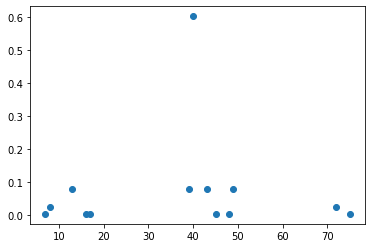

In [74]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [75]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    sigma_e = rot_sigma(0,i,j,phi,theta)@rot_sigma(3,i,j,phi,theta)
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    sigma_o = rot_sigma(1,i,j,phi,theta)@rot_sigma(2,i,j,phi,theta)
    return(sigma_o)



def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    sigma_e = sigma(0,i,j,phi) + sigma(3,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    sigma_o = sigma(1,i,j,phi) + sigma(2,i,j,phi)
    return sigma_o


In [76]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()


def ms_hamiltonian_2(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe@summe@summe
                
matrix_part_2 = ms_hamiltonian_2(1,2,0)
ms_ham_eigenval_2, ms_ham_eigenvec_2 = scipy.linalg.eigh(matrix_part_2)




def ms_gate_global_2(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_2[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_2@exponential@ms_ham_eigenvec_2.T.conj()


    
    
    
    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [77]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [78]:
def R(i,theta):
    
    if i%14 == 0:
        return(ms_gate_global(theta))

    if i%14 == 1:
        return(ms_gate_global_2(theta))
    
    if i%14 == 2:
        return(rot_sigma(3,0,1,0,theta).toarray())


    if i%14 == 3:
        return(rot_sigma(3,0,2,0,theta).toarray())

    
    if i%14 == 4:
        return(rot_sigma(3,1,2,np.pi/2,theta).toarray())
    
    
    if i%14 == 5:
        return(rot_sigma(2,0,1,0,theta).toarray())


    if i%14 == 6:
        return(rot_sigma(2,0,2,0,theta).toarray())

    
    if i%14 == 7:
        return(rot_sigma(2,1,2,np.pi/2,theta).toarray())
    

    if i%14 == 8:
        return(rot_sigma(1,0,1,0,theta).toarray())


    if i%14 == 9:
        return(rot_sigma(1,0,2,0,theta).toarray())

    
    if i%14 == 10:
        return(rot_sigma(1,1,2,np.pi/2,theta).toarray())
    
    
    if i%14 == 11:
        return(rot_sigma(0,0,1,0,theta).toarray())


    if i%14 == 12:
        return(rot_sigma(0,0,2,0,theta).toarray())

    
    if i%14 == 13:
        return(rot_sigma(0,1,2,np.pi/2,theta).toarray())
    
    
def S(i):
    
    if i%14 == 0:
        return(-1j*matrix_part)

    if i%14 == 1:
        return(-1j*matrix_part_2)

    if i%14 == 2:
        return(-1j*sigma(3,0,1,0).toarray())

    
    if i%14 == 3:
        return(-1j*sigma(3,0,2,0).toarray())

    
    if i%14 == 4:
        return(-1j*sigma(3,1,2,np.pi/2).toarray())


     
    if i%14 == 5:
        return(-1j*sigma(2,0,1,0).toarray())

    
    if i%14 == 6:
        return(-1j*sigma(2,0,2,0).toarray())

    
    if i%14 == 7:
        return(-1j*sigma(2,1,2,np.pi/2).toarray())


    if i%14 == 8:
        return(-1j*sigma(1,0,1,0).toarray())

    
    if i%14 == 9:
        return(-1j*sigma(1,0,2,0).toarray())

    
    if i%14 == 10:
        return(-1j*sigma(1,1,2,np.pi/2).toarray())

     
    if i%14 == 11:
        return(-1j*sigma(0,0,1,0).toarray())

    
    if i%14 == 12:
        return(-1j*sigma(0,0,2,0).toarray())

    
    if i%14 == 13:
        return(-1j*sigma(0,1,2,np.pi/2).toarray())

In [79]:
coeff = 14

In [80]:
matr = full_ham_matrix.toarray()
ones = np.ones(coeff*N)
ID = np.identity(coeff*N)
psi_0_conj = np.conj(psi_0)
A = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
dd = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]


In [81]:
def rhs(t,theta):
    #A = [-1j*entanglement_ham.toarray()@exp_ent(theta[0]),-1j*sigma_z.toarray()@exp_sigma_z(theta[1]),-1j*sigma_x.toarray()@exp_sigma_x(theta[2]),-1j*sigma_z.toarray()@exp_sigma_z(theta[3])]
    #B = [exp_ent(theta[0]),exp_sigma_z(theta[1]),exp_sigma_x(theta[2]),exp_sigma_z(theta[3])]
    ID = np.identity(coeff*N)

    print(datetime.datetime.now())
    for k in range(coeff*N):
        A[k] = S(k)@R(k,theta[k])
        B[k] = R(k,theta[k])

    CC = np.einsum("i,ljk->iljk",np.ones(coeff*N),B)

    AA = np.einsum("ijk,il->iljk",A,ID)

    BB = np.einsum("ijk,il->iljk",B,ID)

    DD = CC-BB+AA

    for i in range(coeff*N):
        dd[i] = reduce(np.dot,DD[i])
    DD = np.array(dd)

    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)

    BBB = reduce(np.dot,B)
    DD_d = np.einsum("kij->kji",DD.conj())
    BBB_dagger = BBB.conj().T

    
    
    psi_conj_d = np.einsum("m,imn->in",psi_0_conj,DD_d)
    psi_d = np.einsum("jnl,l->jn",DD,psi_0)
    
    psi_conj_b = np.einsum("m,mn->n",psi_0_conj,BBB_dagger)
    psi_b = np.einsum("lk,k->l",BBB,psi_0)

    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [82]:
stepp = 10000
t_final = 30

In [83]:
time_domain = np.linspace(0, t_final, stepp)
Y = []

In [84]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [85]:
start_point = 0.001*np.ones(coeff*N)
#for i in range(4*N):
#    start_point[i] += i/4*N
rk4(0,0.001*np.ones(coeff*N),t_final,stepp)


2022-07-22 22:12:14.013493
2022-07-22 22:12:14.539319
0
2022-07-22 22:12:14.540757
2022-07-22 22:12:15.023747
0.0015
2022-07-22 22:12:15.025129
2022-07-22 22:12:15.513898
0.0015
2022-07-22 22:12:15.515289
2022-07-22 22:12:16.019410
0.003
2022-07-22 22:12:16.021356
2022-07-22 22:12:16.549762
0.003
2022-07-22 22:12:16.551182
2022-07-22 22:12:17.031563
0.0045000000000000005
2022-07-22 22:12:17.032976
2022-07-22 22:12:17.511703
0.0045000000000000005
2022-07-22 22:12:17.513109
2022-07-22 22:12:17.995750
0.006
2022-07-22 22:12:17.997472
2022-07-22 22:12:18.498679
0.006
2022-07-22 22:12:18.500409
2022-07-22 22:12:19.032736
0.0075
2022-07-22 22:12:19.035289
2022-07-22 22:12:19.584126
0.0075
2022-07-22 22:12:19.585894
2022-07-22 22:12:20.118799
0.009000000000000001
2022-07-22 22:12:20.120840
2022-07-22 22:12:20.668805
0.009000000000000001
2022-07-22 22:12:20.670497
2022-07-22 22:12:21.152709
0.0105
2022-07-22 22:12:21.154141
2022-07-22 22:12:21.635378
0.0105
2022-07-22 22:12:21.636816
2022-07-2

2022-07-22 22:13:11.824430
0.08850000000000004
2022-07-22 22:13:11.826185
2022-07-22 22:13:12.314071
0.08850000000000004
2022-07-22 22:13:12.315838
2022-07-22 22:13:12.802292
0.09000000000000004
2022-07-22 22:13:12.803748
2022-07-22 22:13:13.291358
0.09000000000000004
2022-07-22 22:13:13.292808
2022-07-22 22:13:13.778470
0.09150000000000004
2022-07-22 22:13:13.779926
2022-07-22 22:13:14.267992
0.09150000000000004
2022-07-22 22:13:14.269743
2022-07-22 22:13:14.759080
0.09300000000000004
2022-07-22 22:13:14.760851
2022-07-22 22:13:15.248923
0.09300000000000004
2022-07-22 22:13:15.250369
2022-07-22 22:13:15.736784
0.09450000000000004
2022-07-22 22:13:15.738449
2022-07-22 22:13:16.222246
0.09450000000000004
2022-07-22 22:13:16.223707
2022-07-22 22:13:16.709823
0.09600000000000004
2022-07-22 22:13:16.711304
2022-07-22 22:13:17.195045
0.09600000000000004
2022-07-22 22:13:17.196506
2022-07-22 22:13:17.679524
0.09750000000000004
2022-07-22 22:13:17.680992
2022-07-22 22:13:18.166608
0.097500000

2022-07-22 22:14:06.071186
0.1710000000000001
2022-07-22 22:14:06.072726
2022-07-22 22:14:06.559040
0.1725000000000001
2022-07-22 22:14:06.560790
2022-07-22 22:14:07.046531
0.1725000000000001
2022-07-22 22:14:07.047971
2022-07-22 22:14:07.531244
0.1740000000000001
2022-07-22 22:14:07.532815
2022-07-22 22:14:08.019233
0.1740000000000001
2022-07-22 22:14:08.020865
2022-07-22 22:14:08.506892
0.1755000000000001
2022-07-22 22:14:08.508647
2022-07-22 22:14:08.995324
0.1755000000000001
2022-07-22 22:14:08.997122
2022-07-22 22:14:09.481881
0.1770000000000001
2022-07-22 22:14:09.483350
2022-07-22 22:14:09.971593
0.1770000000000001
2022-07-22 22:14:09.973206
2022-07-22 22:14:10.457323
0.1785000000000001
2022-07-22 22:14:10.459090
2022-07-22 22:14:10.942770
0.1785000000000001
2022-07-22 22:14:10.944223
2022-07-22 22:14:11.431325
0.1800000000000001
2022-07-22 22:14:11.433190
2022-07-22 22:14:11.917625
0.1800000000000001
2022-07-22 22:14:11.919393
2022-07-22 22:14:12.405205
0.1815000000000001
2022-

2022-07-22 22:15:01.122363
0.25500000000000017
2022-07-22 22:15:01.124049
2022-07-22 22:15:01.620026
0.2565000000000002
2022-07-22 22:15:01.621783
2022-07-22 22:15:02.114660
0.2565000000000002
2022-07-22 22:15:02.116103
2022-07-22 22:15:02.611339
0.2580000000000002
2022-07-22 22:15:02.613004
2022-07-22 22:15:03.104134
0.2580000000000002
2022-07-22 22:15:03.105588
2022-07-22 22:15:03.605287
0.2595000000000002
2022-07-22 22:15:03.606754
2022-07-22 22:15:04.097135
0.2595000000000002
2022-07-22 22:15:04.098862
2022-07-22 22:15:04.599305
0.2610000000000002
2022-07-22 22:15:04.601069
2022-07-22 22:15:05.092579
0.2610000000000002
2022-07-22 22:15:05.094288
2022-07-22 22:15:05.589549
0.2625000000000002
2022-07-22 22:15:05.591422
2022-07-22 22:15:06.082626
0.2625000000000002
2022-07-22 22:15:06.084066
2022-07-22 22:15:06.583183
0.2640000000000002
2022-07-22 22:15:06.584640
2022-07-22 22:15:07.074459
0.2640000000000002
2022-07-22 22:15:07.076087
2022-07-22 22:15:07.575298
0.2655000000000002
2022

2022-07-22 22:16:05.324882
0.33900000000000025
2022-07-22 22:16:05.327079
2022-07-22 22:16:05.931345
0.34050000000000025
2022-07-22 22:16:05.932966
2022-07-22 22:16:06.546425
0.34050000000000025
2022-07-22 22:16:06.548231
2022-07-22 22:16:07.153512
0.34200000000000025
2022-07-22 22:16:07.155327
2022-07-22 22:16:07.765176
0.34200000000000025
2022-07-22 22:16:07.766983
2022-07-22 22:16:08.394225
0.34350000000000025
2022-07-22 22:16:08.396453
2022-07-22 22:16:08.996003
0.34350000000000025
2022-07-22 22:16:08.998241
2022-07-22 22:16:09.607909
0.34500000000000025
2022-07-22 22:16:09.609703
2022-07-22 22:16:10.213446
0.34500000000000025
2022-07-22 22:16:10.215092
2022-07-22 22:16:10.828751
0.34650000000000025
2022-07-22 22:16:10.830717
2022-07-22 22:16:11.443600
0.34650000000000025
2022-07-22 22:16:11.445499
2022-07-22 22:16:12.049544
0.34800000000000025
2022-07-22 22:16:12.051496
2022-07-22 22:16:12.658947
0.34800000000000025
2022-07-22 22:16:12.660665
2022-07-22 22:16:13.271648
0.349500000

2022-07-22 22:17:14.011574
0.4230000000000003
2022-07-22 22:17:14.013636
2022-07-22 22:17:14.624730
0.4245000000000003
2022-07-22 22:17:14.626417
2022-07-22 22:17:15.241146
0.4245000000000003
2022-07-22 22:17:15.243044
2022-07-22 22:17:15.848669
0.4260000000000003
2022-07-22 22:17:15.850684
2022-07-22 22:17:16.465845
0.4260000000000003
2022-07-22 22:17:16.467808
2022-07-22 22:17:17.083128
0.4275000000000003
2022-07-22 22:17:17.085361
2022-07-22 22:17:17.691846
0.4275000000000003
2022-07-22 22:17:17.693854
2022-07-22 22:17:18.307204
0.4290000000000003
2022-07-22 22:17:18.309375
2022-07-22 22:17:18.916540
0.4290000000000003
2022-07-22 22:17:18.918143
2022-07-22 22:17:19.533617
0.4305000000000003
2022-07-22 22:17:19.535524
2022-07-22 22:17:20.151675
0.4305000000000003
2022-07-22 22:17:20.153619
2022-07-22 22:17:20.777616
0.43200000000000033
2022-07-22 22:17:20.779840
2022-07-22 22:17:21.396401
0.43200000000000033
2022-07-22 22:17:21.398291
2022-07-22 22:17:22.005359
0.43350000000000033
20

2022-07-22 22:18:23.179641
0.5070000000000003
2022-07-22 22:18:23.181438
2022-07-22 22:18:23.791843
0.5085000000000003
2022-07-22 22:18:23.793534
2022-07-22 22:18:24.412580
0.5085000000000003
2022-07-22 22:18:24.414285
2022-07-22 22:18:25.033204
0.5100000000000003
2022-07-22 22:18:25.035157
2022-07-22 22:18:25.645355
0.5100000000000003
2022-07-22 22:18:25.647346
2022-07-22 22:18:26.264979
0.5115000000000003
2022-07-22 22:18:26.266707
2022-07-22 22:18:26.878741
0.5115000000000003
2022-07-22 22:18:26.880519
2022-07-22 22:18:27.501239
0.5130000000000003
2022-07-22 22:18:27.503059
2022-07-22 22:18:28.123221
0.5130000000000003
2022-07-22 22:18:28.125024
2022-07-22 22:18:28.734632
0.5145000000000003
2022-07-22 22:18:28.736450
2022-07-22 22:18:29.351268
0.5145000000000003
2022-07-22 22:18:29.353223
2022-07-22 22:18:29.963292
0.5160000000000003
2022-07-22 22:18:29.965187
2022-07-22 22:18:30.582425
0.5160000000000003
2022-07-22 22:18:30.584478
2022-07-22 22:18:31.203489
0.5175000000000003
2022-

2022-07-22 22:19:33.005837
0.5925000000000004
2022-07-22 22:19:33.007785
2022-07-22 22:19:33.616859
0.5925000000000004
2022-07-22 22:19:33.618753
2022-07-22 22:19:34.237084
0.5940000000000004
2022-07-22 22:19:34.239348
2022-07-22 22:19:34.924398
0.5940000000000004
2022-07-22 22:19:34.926676
2022-07-22 22:19:35.568561
0.5955000000000004
2022-07-22 22:19:35.570535
2022-07-22 22:19:36.189246
0.5955000000000004
2022-07-22 22:19:36.191164
2022-07-22 22:19:36.816845
0.5970000000000004
2022-07-22 22:19:36.818795
2022-07-22 22:19:37.452387
0.5970000000000004
2022-07-22 22:19:37.454329
2022-07-22 22:19:38.071422
0.5985000000000004
2022-07-22 22:19:38.073021
2022-07-22 22:19:38.693892
0.5985000000000004
2022-07-22 22:19:38.695949
2022-07-22 22:19:39.326447
0.6000000000000004
2022-07-22 22:19:39.328344
2022-07-22 22:19:39.938012
0.6000000000000004
2022-07-22 22:19:39.939851
2022-07-22 22:19:40.557001
0.6015000000000004
2022-07-22 22:19:40.558614
2022-07-22 22:19:41.191480
0.6015000000000004
2022-

2022-07-22 22:20:43.134340
0.6765000000000004
2022-07-22 22:20:43.136292
2022-07-22 22:20:43.758525
0.6780000000000005
2022-07-22 22:20:43.760248
2022-07-22 22:20:44.372035
0.6780000000000005
2022-07-22 22:20:44.373980
2022-07-22 22:20:44.989458
0.6795000000000004
2022-07-22 22:20:44.991450
2022-07-22 22:20:45.608262
0.6795000000000004
2022-07-22 22:20:45.610059
2022-07-22 22:20:46.225555
0.6810000000000005
2022-07-22 22:20:46.227418
2022-07-22 22:20:46.848952
0.6810000000000005
2022-07-22 22:20:46.850862
2022-07-22 22:20:47.464924
0.6825000000000004
2022-07-22 22:20:47.466623
2022-07-22 22:20:48.084580
0.6825000000000004
2022-07-22 22:20:48.086536
2022-07-22 22:20:48.701202
0.6840000000000005
2022-07-22 22:20:48.702823
2022-07-22 22:20:49.320691
0.6840000000000005
2022-07-22 22:20:49.322413
2022-07-22 22:20:49.942378
0.6855000000000004
2022-07-22 22:20:49.944252
2022-07-22 22:20:50.555877
0.6855000000000004
2022-07-22 22:20:50.558056
2022-07-22 22:20:51.177827
0.6870000000000005
2022-

2022-07-22 22:21:53.525454
0.7620000000000006
2022-07-22 22:21:53.527136
2022-07-22 22:21:54.150008
0.7620000000000006
2022-07-22 22:21:54.152116
2022-07-22 22:21:54.778758
0.7635000000000005
2022-07-22 22:21:54.781000
2022-07-22 22:21:55.400818
0.7635000000000005
2022-07-22 22:21:55.402790
2022-07-22 22:21:56.028777
0.7650000000000006
2022-07-22 22:21:56.030917
2022-07-22 22:21:56.645738
0.7650000000000006
2022-07-22 22:21:56.647607
2022-07-22 22:21:57.269363
0.7665000000000005
2022-07-22 22:21:57.270997
2022-07-22 22:21:57.890146
0.7665000000000005
2022-07-22 22:21:57.892383
2022-07-22 22:21:58.509936
0.7680000000000006
2022-07-22 22:21:58.511840
2022-07-22 22:21:59.129964
0.7680000000000006
2022-07-22 22:21:59.131569
2022-07-22 22:21:59.757172
0.7695000000000005
2022-07-22 22:21:59.759158
2022-07-22 22:22:00.379133
0.7695000000000005
2022-07-22 22:22:00.380843
2022-07-22 22:22:01.002967
0.7710000000000006
2022-07-22 22:22:01.004764
2022-07-22 22:22:01.627539
0.7710000000000006
2022-

2022-07-22 22:23:03.887814
0.8460000000000006
2022-07-22 22:23:03.889731
2022-07-22 22:23:04.503803
0.8475000000000006
2022-07-22 22:23:04.505412
2022-07-22 22:23:05.120939
0.8475000000000006
2022-07-22 22:23:05.122754
2022-07-22 22:23:05.745691
0.8490000000000006
2022-07-22 22:23:05.747399
2022-07-22 22:23:06.358764
0.8490000000000006
2022-07-22 22:23:06.360553
2022-07-22 22:23:06.986170
0.8505000000000006
2022-07-22 22:23:06.987867
2022-07-22 22:23:07.610597
0.8505000000000006
2022-07-22 22:23:07.612201
2022-07-22 22:23:08.228301
0.8520000000000006
2022-07-22 22:23:08.230466
2022-07-22 22:23:08.855112
0.8520000000000006
2022-07-22 22:23:08.857035
2022-07-22 22:23:09.473295
0.8535000000000006
2022-07-22 22:23:09.475195
2022-07-22 22:23:10.096579
0.8535000000000006
2022-07-22 22:23:10.098259
2022-07-22 22:23:10.716869
0.8550000000000006
2022-07-22 22:23:10.718909
2022-07-22 22:23:11.334389
0.8550000000000006
2022-07-22 22:23:11.336062
2022-07-22 22:23:11.957169
0.8565000000000006
2022-

2022-07-22 22:24:14.564600
0.9315000000000007
2022-07-22 22:24:14.566519
2022-07-22 22:24:15.190458
0.9315000000000007
2022-07-22 22:24:15.192361
2022-07-22 22:24:15.817885
0.9330000000000007
2022-07-22 22:24:15.819870
2022-07-22 22:24:16.440474
0.9330000000000007
2022-07-22 22:24:16.442089
2022-07-22 22:24:17.064166
0.9345000000000007
2022-07-22 22:24:17.066017
2022-07-22 22:24:17.689197
0.9345000000000007
2022-07-22 22:24:17.690869
2022-07-22 22:24:18.306438
0.9360000000000007
2022-07-22 22:24:18.308660
2022-07-22 22:24:18.930472
0.9360000000000007
2022-07-22 22:24:18.932419
2022-07-22 22:24:19.556115
0.9375000000000007
2022-07-22 22:24:19.558334
2022-07-22 22:24:20.174582
0.9375000000000007
2022-07-22 22:24:20.176361
2022-07-22 22:24:20.799393
0.9390000000000007
2022-07-22 22:24:20.801176
2022-07-22 22:24:21.416847
0.9390000000000007
2022-07-22 22:24:21.418750
2022-07-22 22:24:22.042708
0.9405000000000007
2022-07-22 22:24:22.044650
2022-07-22 22:24:22.665428
0.9405000000000007
2022-

2022-07-22 22:25:25.168018
1.0155000000000003
2022-07-22 22:25:25.169980
2022-07-22 22:25:25.796817
1.0170000000000001
2022-07-22 22:25:25.798761
2022-07-22 22:25:26.425100
1.0170000000000001
2022-07-22 22:25:26.426915
2022-07-22 22:25:27.046164
1.0185000000000002
2022-07-22 22:25:27.048207
2022-07-22 22:25:27.675725
1.0185000000000002
2022-07-22 22:25:27.677670
2022-07-22 22:25:28.295296
1.02
2022-07-22 22:25:28.296972
2022-07-22 22:25:28.919925
1.02
2022-07-22 22:25:28.921588
2022-07-22 22:25:29.547052
1.0215
2022-07-22 22:25:29.548762
2022-07-22 22:25:30.165898
1.0215
2022-07-22 22:25:30.168133
2022-07-22 22:25:30.791530
1.023
2022-07-22 22:25:30.793248
2022-07-22 22:25:31.408602
1.023
2022-07-22 22:25:31.410477
2022-07-22 22:25:32.035001
1.0245
2022-07-22 22:25:32.036607
2022-07-22 22:25:32.666225
1.0245
2022-07-22 22:25:32.668139
2022-07-22 22:25:33.285813
1.0259999999999998
2022-07-22 22:25:33.287548
2022-07-22 22:25:33.914758
1.0259999999999998
2022-07-22 22:25:33.916664
2022-07

2022-07-22 22:26:36.545400
1.100999999999997
2022-07-22 22:26:36.547713
2022-07-22 22:26:37.166308
1.1024999999999971
2022-07-22 22:26:37.168595
2022-07-22 22:26:37.788193
1.1024999999999971
2022-07-22 22:26:37.789962
2022-07-22 22:26:38.412750
1.103999999999997
2022-07-22 22:26:38.414635
2022-07-22 22:26:39.034928
1.103999999999997
2022-07-22 22:26:39.036525
2022-07-22 22:26:39.664273
1.105499999999997
2022-07-22 22:26:39.666493
2022-07-22 22:26:40.285067
1.105499999999997
2022-07-22 22:26:40.286890
2022-07-22 22:26:40.914365
1.1069999999999969
2022-07-22 22:26:40.916269
2022-07-22 22:26:41.542245
1.1069999999999969
2022-07-22 22:26:41.544447
2022-07-22 22:26:42.163946
1.108499999999997
2022-07-22 22:26:42.165978
2022-07-22 22:26:42.789833
1.108499999999997
2022-07-22 22:26:42.791424
2022-07-22 22:26:43.418021
1.1099999999999968
2022-07-22 22:26:43.420186
2022-07-22 22:26:44.039928
1.1099999999999968
2022-07-22 22:26:44.041673
2022-07-22 22:26:44.665093
1.1114999999999968
2022-07-22 2

2022-07-22 22:27:47.622869
1.1864999999999941
2022-07-22 22:27:47.624465
2022-07-22 22:27:48.248035
1.1864999999999941
2022-07-22 22:27:48.249889
2022-07-22 22:27:48.874880
1.187999999999994
2022-07-22 22:27:48.876817
2022-07-22 22:27:49.499183
1.187999999999994
2022-07-22 22:27:49.500901
2022-07-22 22:27:50.124882
1.189499999999994
2022-07-22 22:27:50.126670
2022-07-22 22:27:50.748881
1.189499999999994
2022-07-22 22:27:50.750787
2022-07-22 22:27:51.374167
1.1909999999999938
2022-07-22 22:27:51.375872
2022-07-22 22:27:51.999085
1.1909999999999938
2022-07-22 22:27:52.000809
2022-07-22 22:27:52.620858
1.192499999999994
2022-07-22 22:27:52.622585
2022-07-22 22:27:53.243772
1.192499999999994
2022-07-22 22:27:53.245715
2022-07-22 22:27:53.869345
1.1939999999999937
2022-07-22 22:27:53.871260
2022-07-22 22:27:54.493190
1.1939999999999937
2022-07-22 22:27:54.495260
2022-07-22 22:27:55.120724
1.1954999999999938
2022-07-22 22:27:55.122642
2022-07-22 22:27:55.745655
1.1954999999999938
2022-07-22 

2022-07-22 22:28:58.598451
1.270499999999991
2022-07-22 22:28:58.600358
2022-07-22 22:28:59.229596
1.271999999999991
2022-07-22 22:28:59.231471
2022-07-22 22:28:59.856246
1.271999999999991
2022-07-22 22:28:59.858045
2022-07-22 22:29:00.488348
1.273499999999991
2022-07-22 22:29:00.490131
2022-07-22 22:29:01.124084
1.273499999999991
2022-07-22 22:29:01.125696
2022-07-22 22:29:01.751093
1.2749999999999908
2022-07-22 22:29:01.752996
2022-07-22 22:29:02.379325
1.2749999999999908
2022-07-22 22:29:02.381563
2022-07-22 22:29:03.009934
1.2764999999999909
2022-07-22 22:29:03.012075
2022-07-22 22:29:03.638319
1.2764999999999909
2022-07-22 22:29:03.640434
2022-07-22 22:29:04.263085
1.2779999999999907
2022-07-22 22:29:04.264820
2022-07-22 22:29:04.891210
1.2779999999999907
2022-07-22 22:29:04.893171
2022-07-22 22:29:05.519651
1.2794999999999908
2022-07-22 22:29:05.521499
2022-07-22 22:29:06.146831
1.2794999999999908
2022-07-22 22:29:06.148699
2022-07-22 22:29:06.773462
1.2809999999999906
2022-07-22

2022-07-22 22:30:09.754634
1.3559999999999879
2022-07-22 22:30:09.756671
2022-07-22 22:30:10.386532
1.3559999999999879
2022-07-22 22:30:10.388133
2022-07-22 22:30:11.017467
1.357499999999988
2022-07-22 22:30:11.019185
2022-07-22 22:30:11.647421
1.357499999999988
2022-07-22 22:30:11.649019
2022-07-22 22:30:12.281125
1.3589999999999878
2022-07-22 22:30:12.283081
2022-07-22 22:30:12.903429
1.3589999999999878
2022-07-22 22:30:12.905094
2022-07-22 22:30:13.534249
1.3604999999999878
2022-07-22 22:30:13.535847
2022-07-22 22:30:14.157479
1.3604999999999878
2022-07-22 22:30:14.159733
2022-07-22 22:30:14.781840
1.3619999999999877
2022-07-22 22:30:14.783788
2022-07-22 22:30:15.412570
1.3619999999999877
2022-07-22 22:30:15.414375
2022-07-22 22:30:16.036755
1.3634999999999877
2022-07-22 22:30:16.038708
2022-07-22 22:30:16.666770
1.3634999999999877
2022-07-22 22:30:16.668421
2022-07-22 22:30:17.297919
1.3649999999999876
2022-07-22 22:30:17.299775
2022-07-22 22:30:17.919886
1.3649999999999876
2022-07

2022-07-22 22:31:20.806197
1.4399999999999848
2022-07-22 22:31:20.807918
2022-07-22 22:31:21.436078
1.441499999999985
2022-07-22 22:31:21.437849
2022-07-22 22:31:22.069513
1.441499999999985
2022-07-22 22:31:22.071741
2022-07-22 22:31:22.694355
1.4429999999999847
2022-07-22 22:31:22.696238
2022-07-22 22:31:23.328023
1.4429999999999847
2022-07-22 22:31:23.329668
2022-07-22 22:31:23.961106
1.4444999999999848
2022-07-22 22:31:23.963338
2022-07-22 22:31:24.585230
1.4444999999999848
2022-07-22 22:31:24.587048
2022-07-22 22:31:25.216812
1.4459999999999846
2022-07-22 22:31:25.218489
2022-07-22 22:31:25.841363
1.4459999999999846
2022-07-22 22:31:25.843530
2022-07-22 22:31:26.469556
1.4474999999999847
2022-07-22 22:31:26.471478
2022-07-22 22:31:27.095582
1.4474999999999847
2022-07-22 22:31:27.097495
2022-07-22 22:31:27.727641
1.4489999999999845
2022-07-22 22:31:27.729338
2022-07-22 22:31:28.355554
1.4489999999999845
2022-07-22 22:31:28.357487
2022-07-22 22:31:28.978630
1.4504999999999846
2022-07

2022-07-22 22:32:32.050658
1.5254999999999819
2022-07-22 22:32:32.052404
2022-07-22 22:32:32.679221
1.5254999999999819
2022-07-22 22:32:32.681096
2022-07-22 22:32:33.307260
1.5269999999999817
2022-07-22 22:32:33.309431
2022-07-22 22:32:33.933194
1.5269999999999817
2022-07-22 22:32:33.935041
2022-07-22 22:32:34.561652
1.5284999999999818
2022-07-22 22:32:34.563546
2022-07-22 22:32:35.195148
1.5284999999999818
2022-07-22 22:32:35.197278
2022-07-22 22:32:35.824343
1.5299999999999816
2022-07-22 22:32:35.826175
2022-07-22 22:32:36.451971
1.5299999999999816
2022-07-22 22:32:36.453690
2022-07-22 22:32:37.077603
1.5314999999999817
2022-07-22 22:32:37.079565
2022-07-22 22:32:37.703556
1.5314999999999817
2022-07-22 22:32:37.705269
2022-07-22 22:32:38.328952
1.5329999999999815
2022-07-22 22:32:38.330633
2022-07-22 22:32:38.957922
1.5329999999999815
2022-07-22 22:32:38.959605
2022-07-22 22:32:39.586263
1.5344999999999815
2022-07-22 22:32:39.588198
2022-07-22 22:32:40.213686
1.5344999999999815
2022-

2022-07-22 22:33:43.472511
1.6094999999999788
2022-07-22 22:33:43.474199
2022-07-22 22:33:44.105660
1.6109999999999787
2022-07-22 22:33:44.107253
2022-07-22 22:33:44.736365
1.6109999999999787
2022-07-22 22:33:44.738375
2022-07-22 22:33:45.371313
1.6124999999999787
2022-07-22 22:33:45.373494
2022-07-22 22:33:46.001394
1.6124999999999787
2022-07-22 22:33:46.003197
2022-07-22 22:33:46.632912
1.6139999999999786
2022-07-22 22:33:46.634971
2022-07-22 22:33:47.262888
1.6139999999999786
2022-07-22 22:33:47.264659
2022-07-22 22:33:47.890245
1.6154999999999786
2022-07-22 22:33:47.892194
2022-07-22 22:33:48.520401
1.6154999999999786
2022-07-22 22:33:48.522110
2022-07-22 22:33:49.150396
1.6169999999999785
2022-07-22 22:33:49.152186
2022-07-22 22:33:49.779644
1.6169999999999785
2022-07-22 22:33:49.781923
2022-07-22 22:33:50.407415
1.6184999999999785
2022-07-22 22:33:50.409294
2022-07-22 22:33:51.037095
1.6184999999999785
2022-07-22 22:33:51.038875
2022-07-22 22:33:51.673289
1.6199999999999783
2022-

2022-07-22 22:34:54.828315
1.6949999999999756
2022-07-22 22:34:54.830328
2022-07-22 22:34:55.465358
1.6949999999999756
2022-07-22 22:34:55.467455
2022-07-22 22:34:56.098049
1.6964999999999757
2022-07-22 22:34:56.099941
2022-07-22 22:34:56.730837
1.6964999999999757
2022-07-22 22:34:56.732889
2022-07-22 22:34:57.362983
1.6979999999999755
2022-07-22 22:34:57.364696
2022-07-22 22:34:57.993125
1.6979999999999755
2022-07-22 22:34:57.994941
2022-07-22 22:34:58.620732
1.6994999999999756
2022-07-22 22:34:58.622415
2022-07-22 22:34:59.250043
1.6994999999999756
2022-07-22 22:34:59.251949
2022-07-22 22:34:59.878694
1.7009999999999754
2022-07-22 22:34:59.880298
2022-07-22 22:35:00.510383
1.7009999999999754
2022-07-22 22:35:00.512376
2022-07-22 22:35:01.144574
1.7024999999999755
2022-07-22 22:35:01.146159
2022-07-22 22:35:01.784280
1.7024999999999755
2022-07-22 22:35:01.785936
2022-07-22 22:35:02.413124
1.7039999999999753
2022-07-22 22:35:02.414932
2022-07-22 22:35:03.048463
1.7039999999999753
2022-

2022-07-22 22:36:06.425652
1.7789999999999726
2022-07-22 22:36:06.427563
2022-07-22 22:36:07.059704
1.7804999999999727
2022-07-22 22:36:07.061633
2022-07-22 22:36:07.692743
1.7804999999999727
2022-07-22 22:36:07.694722
2022-07-22 22:36:08.320678
1.7819999999999725
2022-07-22 22:36:08.322334
2022-07-22 22:36:08.956011
1.7819999999999725
2022-07-22 22:36:08.957776
2022-07-22 22:36:09.584618
1.7834999999999726
2022-07-22 22:36:09.589022
2022-07-22 22:36:10.216265
1.7834999999999726
2022-07-22 22:36:10.218151
2022-07-22 22:36:10.851840
1.7849999999999724
2022-07-22 22:36:10.853548
2022-07-22 22:36:11.482713
1.7849999999999724
2022-07-22 22:36:11.484400
2022-07-22 22:36:12.115682
1.7864999999999724
2022-07-22 22:36:12.117289
2022-07-22 22:36:12.749596
1.7864999999999724
2022-07-22 22:36:12.751521
2022-07-22 22:36:13.375322
1.7879999999999723
2022-07-22 22:36:13.377241
2022-07-22 22:36:14.010820
1.7879999999999723
2022-07-22 22:36:14.012710
2022-07-22 22:36:14.638671
1.7894999999999723
2022-

2022-07-22 22:37:18.022659
1.8644999999999696
2022-07-22 22:37:18.024299
2022-07-22 22:37:18.653488
1.8644999999999696
2022-07-22 22:37:18.655102
2022-07-22 22:37:19.282970
1.8659999999999695
2022-07-22 22:37:19.284927
2022-07-22 22:37:19.918427
1.8659999999999695
2022-07-22 22:37:19.920246
2022-07-22 22:37:20.555539
1.8674999999999695
2022-07-22 22:37:20.557560
2022-07-22 22:37:21.183474
1.8674999999999695
2022-07-22 22:37:21.185154
2022-07-22 22:37:21.820326
1.8689999999999694
2022-07-22 22:37:21.822178
2022-07-22 22:37:22.444056
1.8689999999999694
2022-07-22 22:37:22.445958
2022-07-22 22:37:23.078705
1.8704999999999694
2022-07-22 22:37:23.080647
2022-07-22 22:37:23.712991
1.8704999999999694
2022-07-22 22:37:23.715026
2022-07-22 22:37:24.337708
1.8719999999999692
2022-07-22 22:37:24.339408
2022-07-22 22:37:24.974228
1.8719999999999692
2022-07-22 22:37:24.975966
2022-07-22 22:37:25.608836
1.8734999999999693
2022-07-22 22:37:25.610888
2022-07-22 22:37:26.235993
1.8734999999999693
2022-

2022-07-22 22:38:29.707313
1.9484999999999666
2022-07-22 22:38:29.709206
2022-07-22 22:38:30.336150
1.9499999999999664
2022-07-22 22:38:30.337868
2022-07-22 22:38:30.969873
1.9499999999999664
2022-07-22 22:38:30.971565
2022-07-22 22:38:31.603123
1.9514999999999665
2022-07-22 22:38:31.605289
2022-07-22 22:38:32.227501
1.9514999999999665
2022-07-22 22:38:32.229195
2022-07-22 22:38:32.864469
1.9529999999999663
2022-07-22 22:38:32.866155
2022-07-22 22:38:33.498324
1.9529999999999663
2022-07-22 22:38:33.500129
2022-07-22 22:38:34.126415
1.9544999999999664
2022-07-22 22:38:34.128371
2022-07-22 22:38:34.760185
1.9544999999999664
2022-07-22 22:38:34.762195
2022-07-22 22:38:35.389878
1.9559999999999662
2022-07-22 22:38:35.391639
2022-07-22 22:38:36.023910
1.9559999999999662
2022-07-22 22:38:36.026093
2022-07-22 22:38:36.658379
1.9574999999999663
2022-07-22 22:38:36.660063
2022-07-22 22:38:37.282576
1.9574999999999663
2022-07-22 22:38:37.284476
2022-07-22 22:38:37.915030
1.958999999999966
2022-0

2022-07-22 22:39:41.370419
2.033999999999966
2022-07-22 22:39:41.372639
2022-07-22 22:39:42.000923
2.033999999999966
2022-07-22 22:39:42.002827
2022-07-22 22:39:42.637724
2.035499999999966
2022-07-22 22:39:42.639393
2022-07-22 22:39:43.265710
2.035499999999966
2022-07-22 22:39:43.267484
2022-07-22 22:39:43.900774
2.036999999999966
2022-07-22 22:39:43.902445
2022-07-22 22:39:44.542718
2.036999999999966
2022-07-22 22:39:44.544495
2022-07-22 22:39:45.171892
2.0384999999999662
2022-07-22 22:39:45.173768
2022-07-22 22:39:45.806502
2.0384999999999662
2022-07-22 22:39:45.808588
2022-07-22 22:39:46.439374
2.0399999999999663
2022-07-22 22:39:46.441009
2022-07-22 22:39:47.068840
2.0399999999999663
2022-07-22 22:39:47.071029
2022-07-22 22:39:47.710677
2.0414999999999663
2022-07-22 22:39:47.712466
2022-07-22 22:39:48.339248
2.0414999999999663
2022-07-22 22:39:48.340855
2022-07-22 22:39:48.975572
2.0429999999999664
2022-07-22 22:39:48.977355
2022-07-22 22:39:49.607755
2.0429999999999664
2022-07-22 

2022-07-22 22:40:52.973144
2.1179999999999692
2022-07-22 22:40:52.975365
2022-07-22 22:40:53.608748
2.1194999999999693
2022-07-22 22:40:53.610976
2022-07-22 22:40:54.236143
2.1194999999999693
2022-07-22 22:40:54.238168
2022-07-22 22:40:54.869281
2.1209999999999694
2022-07-22 22:40:54.871303
2022-07-22 22:40:55.498201
2.1209999999999694
2022-07-22 22:40:55.500168
2022-07-22 22:40:56.126652
2.1224999999999694
2022-07-22 22:40:56.128908
2022-07-22 22:40:56.763653
2.1224999999999694
2022-07-22 22:40:56.765344
2022-07-22 22:40:57.395036
2.1239999999999695
2022-07-22 22:40:57.396743
2022-07-22 22:40:58.028997
2.1239999999999695
2022-07-22 22:40:58.030906
2022-07-22 22:40:58.661142
2.1254999999999695
2022-07-22 22:40:58.663017
2022-07-22 22:40:59.287574
2.1254999999999695
2022-07-22 22:40:59.289384
2022-07-22 22:40:59.923860
2.1269999999999696
2022-07-22 22:40:59.925755
2022-07-22 22:41:00.563595
2.1269999999999696
2022-07-22 22:41:00.565531
2022-07-22 22:41:01.190707
2.1284999999999696
2022-

2022-07-22 22:42:05.437601
2.2034999999999725
2022-07-22 22:42:05.439401
2022-07-22 22:42:06.054809
2.2049999999999725
2022-07-22 22:42:06.057006
2022-07-22 22:42:06.690286
2.2049999999999725
2022-07-22 22:42:06.692261
2022-07-22 22:42:07.326737
2.2064999999999726
2022-07-22 22:42:07.328421
2022-07-22 22:42:07.956311
2.2064999999999726
2022-07-22 22:42:07.958098
2022-07-22 22:42:08.591013
2.2079999999999727
2022-07-22 22:42:08.593270
2022-07-22 22:42:09.221097
2.2079999999999727
2022-07-22 22:42:09.222782
2022-07-22 22:42:09.861790
2.2094999999999727
2022-07-22 22:42:09.863745
2022-07-22 22:42:10.492998
2.2094999999999727
2022-07-22 22:42:10.494793
2022-07-22 22:42:11.123734
2.2109999999999728
2022-07-22 22:42:11.125534
2022-07-22 22:42:11.762178
2.2109999999999728
2022-07-22 22:42:11.764155
2022-07-22 22:42:12.400743
2.212499999999973
2022-07-22 22:42:12.402408
2022-07-22 22:42:13.028778
2.212499999999973
2022-07-22 22:42:13.031053
2022-07-22 22:42:13.666932
2.213999999999973
2022-07-

2022-07-22 22:43:17.421676
2.2889999999999757
2022-07-22 22:43:17.423382
2022-07-22 22:43:18.059900
2.2889999999999757
2022-07-22 22:43:18.061753
2022-07-22 22:43:18.701077
2.2904999999999758
2022-07-22 22:43:18.703040
2022-07-22 22:43:19.336455
2.2904999999999758
2022-07-22 22:43:19.338494
2022-07-22 22:43:19.975645
2.291999999999976
2022-07-22 22:43:19.977611
2022-07-22 22:43:20.610960
2.291999999999976
2022-07-22 22:43:20.612685
2022-07-22 22:43:21.256384
2.293499999999976
2022-07-22 22:43:21.258367
2022-07-22 22:43:21.891439
2.293499999999976
2022-07-22 22:43:21.893668
2022-07-22 22:43:22.527961
2.294999999999976
2022-07-22 22:43:22.529694
2022-07-22 22:43:23.186629
2.294999999999976
2022-07-22 22:43:23.188621
2022-07-22 22:43:23.831325
2.296499999999976
2022-07-22 22:43:23.833570
2022-07-22 22:43:24.465780
2.296499999999976
2022-07-22 22:43:24.467795
2022-07-22 22:43:25.102853
2.297999999999976
2022-07-22 22:43:25.104992
2022-07-22 22:43:25.739842
2.297999999999976
2022-07-22 22:4

2022-07-22 22:44:29.672274
2.372999999999979
2022-07-22 22:44:29.673868
2022-07-22 22:44:30.305560
2.374499999999979
2022-07-22 22:44:30.307283
2022-07-22 22:44:30.936569
2.374499999999979
2022-07-22 22:44:30.938541
2022-07-22 22:44:31.570226
2.375999999999979
2022-07-22 22:44:31.572211
2022-07-22 22:44:32.202616
2.375999999999979
2022-07-22 22:44:32.204402
2022-07-22 22:44:32.834545
2.377499999999979
2022-07-22 22:44:32.836762
2022-07-22 22:44:33.468179
2.377499999999979
2022-07-22 22:44:33.469977
2022-07-22 22:44:34.100020
2.378999999999979
2022-07-22 22:44:34.101763
2022-07-22 22:44:34.732921
2.378999999999979
2022-07-22 22:44:34.734870
2022-07-22 22:44:35.369433
2.380499999999979
2022-07-22 22:44:35.371074
2022-07-22 22:44:36.004192
2.380499999999979
2022-07-22 22:44:36.006088
2022-07-22 22:44:36.635642
2.3819999999999792
2022-07-22 22:44:36.637496
2022-07-22 22:44:37.266747
2.3819999999999792
2022-07-22 22:44:37.268445
2022-07-22 22:44:37.897105
2.3834999999999793
2022-07-22 22:44

2022-07-22 22:45:42.158899
2.458499999999982
2022-07-22 22:45:42.160824
2022-07-22 22:45:42.792963
2.459999999999982
2022-07-22 22:45:42.794753
2022-07-22 22:45:43.430599
2.459999999999982
2022-07-22 22:45:43.432286
2022-07-22 22:45:44.063286
2.4614999999999823
2022-07-22 22:45:44.064991
2022-07-22 22:45:44.707292
2.4614999999999823
2022-07-22 22:45:44.709171
2022-07-22 22:45:45.343618
2.4629999999999823
2022-07-22 22:45:45.345314
2022-07-22 22:45:45.977131
2.4629999999999823
2022-07-22 22:45:45.978982
2022-07-22 22:45:46.635875
2.4644999999999824
2022-07-22 22:45:46.637780
2022-07-22 22:45:47.262109
2.4644999999999824
2022-07-22 22:45:47.264167
2022-07-22 22:45:47.893625
2.4659999999999824
2022-07-22 22:45:47.895587
2022-07-22 22:45:48.527233
2.4659999999999824
2022-07-22 22:45:48.528910
2022-07-22 22:45:49.158303
2.4674999999999825
2022-07-22 22:45:49.160187
2022-07-22 22:45:49.792831
2.4674999999999825
2022-07-22 22:45:49.794550
2022-07-22 22:45:50.426403
2.4689999999999825
2022-07-

2022-07-22 22:46:53.985396
2.5439999999999854
2022-07-22 22:46:53.987361
2022-07-22 22:46:54.619392
2.5439999999999854
2022-07-22 22:46:54.621097
2022-07-22 22:46:55.252767
2.5454999999999854
2022-07-22 22:46:55.254543
2022-07-22 22:46:55.888897
2.5454999999999854
2022-07-22 22:46:55.890725
2022-07-22 22:46:56.522962
2.5469999999999855
2022-07-22 22:46:56.524755
2022-07-22 22:46:57.159227
2.5469999999999855
2022-07-22 22:46:57.161379
2022-07-22 22:46:57.793449
2.5484999999999856
2022-07-22 22:46:57.795213
2022-07-22 22:46:58.426520
2.5484999999999856
2022-07-22 22:46:58.428439
2022-07-22 22:46:59.058950
2.5499999999999856
2022-07-22 22:46:59.060734
2022-07-22 22:46:59.703850
2.5499999999999856
2022-07-22 22:46:59.705795
2022-07-22 22:47:00.342756
2.5514999999999857
2022-07-22 22:47:00.344947
2022-07-22 22:47:00.973699
2.5514999999999857
2022-07-22 22:47:00.975681
2022-07-22 22:47:01.622616
2.5529999999999857
2022-07-22 22:47:01.624428
2022-07-22 22:47:02.257593
2.5529999999999857
2022-

2022-07-22 22:48:06.093172
2.6279999999999886
2022-07-22 22:48:06.094885
2022-07-22 22:48:06.731426
2.6294999999999886
2022-07-22 22:48:06.733382
2022-07-22 22:48:07.366185
2.6294999999999886
2022-07-22 22:48:07.367896
2022-07-22 22:48:08.000094
2.6309999999999887
2022-07-22 22:48:08.001933
2022-07-22 22:48:08.635470
2.6309999999999887
2022-07-22 22:48:08.637154
2022-07-22 22:48:09.269235
2.6324999999999887
2022-07-22 22:48:09.271092
2022-07-22 22:48:09.905192
2.6324999999999887
2022-07-22 22:48:09.907167
2022-07-22 22:48:10.544733
2.633999999999989
2022-07-22 22:48:10.546578
2022-07-22 22:48:11.180880
2.633999999999989
2022-07-22 22:48:11.182744
2022-07-22 22:48:11.817249
2.635499999999989
2022-07-22 22:48:11.819521
2022-07-22 22:48:12.450785
2.635499999999989
2022-07-22 22:48:12.452981
2022-07-22 22:48:13.086248
2.636999999999989
2022-07-22 22:48:13.088129
2022-07-22 22:48:13.721646
2.636999999999989
2022-07-22 22:48:13.723606
2022-07-22 22:48:14.356565
2.638499999999989
2022-07-22 2

2022-07-22 22:49:18.711349
2.713499999999992
2022-07-22 22:49:18.713009
2022-07-22 22:49:19.347785
2.714999999999992
2022-07-22 22:49:19.349528
2022-07-22 22:49:19.980408
2.714999999999992
2022-07-22 22:49:19.982104
2022-07-22 22:49:20.617913
2.716499999999992
2022-07-22 22:49:20.619760
2022-07-22 22:49:21.257610
2.716499999999992
2022-07-22 22:49:21.259327
2022-07-22 22:49:21.894183
2.717999999999992
2022-07-22 22:49:21.896098
2022-07-22 22:49:22.531434
2.717999999999992
2022-07-22 22:49:22.533386
2022-07-22 22:49:23.165939
2.719499999999992
2022-07-22 22:49:23.167718
2022-07-22 22:49:23.801057
2.719499999999992
2022-07-22 22:49:23.802836
2022-07-22 22:49:24.438838
2.720999999999992
2022-07-22 22:49:24.440442
2022-07-22 22:49:25.080846
2.720999999999992
2022-07-22 22:49:25.082907
2022-07-22 22:49:25.714752
2.722499999999992
2022-07-22 22:49:25.716439
2022-07-22 22:49:26.349478
2.722499999999992
2022-07-22 22:49:26.351440
2022-07-22 22:49:26.986515
2.723999999999992
2022-07-22 22:49:26

2022-07-22 22:50:30.975634
2.798999999999995
2022-07-22 22:50:30.977564
2022-07-22 22:50:31.611892
2.798999999999995
2022-07-22 22:50:31.614080
2022-07-22 22:50:32.247930
2.800499999999995
2022-07-22 22:50:32.249708
2022-07-22 22:50:32.882899
2.800499999999995
2022-07-22 22:50:32.884483
2022-07-22 22:50:33.518560
2.801999999999995
2022-07-22 22:50:33.520242
2022-07-22 22:50:34.153364
2.801999999999995
2022-07-22 22:50:34.154908
2022-07-22 22:50:34.787283
2.803499999999995
2022-07-22 22:50:34.789127
2022-07-22 22:50:35.426705
2.803499999999995
2022-07-22 22:50:35.428418
2022-07-22 22:50:36.063292
2.8049999999999953
2022-07-22 22:50:36.065032
2022-07-22 22:50:36.701640
2.8049999999999953
2022-07-22 22:50:36.703634
2022-07-22 22:50:37.337997
2.8064999999999953
2022-07-22 22:50:37.339859
2022-07-22 22:50:37.972976
2.8064999999999953
2022-07-22 22:50:37.975030
2022-07-22 22:50:38.612807
2.8079999999999954
2022-07-22 22:50:38.615059
2022-07-22 22:50:39.251387
2.8079999999999954
2022-07-22 22

2022-07-22 22:51:43.654428
2.8829999999999982
2022-07-22 22:51:43.656104
2022-07-22 22:51:44.294024
2.8844999999999983
2022-07-22 22:51:44.295727
2022-07-22 22:51:44.942092
2.8844999999999983
2022-07-22 22:51:44.943784
2022-07-22 22:51:45.584135
2.8859999999999983
2022-07-22 22:51:45.586006
2022-07-22 22:51:46.225631
2.8859999999999983
2022-07-22 22:51:46.227365
2022-07-22 22:51:46.868287
2.8874999999999984
2022-07-22 22:51:46.870033
2022-07-22 22:51:47.510088
2.8874999999999984
2022-07-22 22:51:47.511960
2022-07-22 22:51:48.152151
2.8889999999999985
2022-07-22 22:51:48.154112
2022-07-22 22:51:48.806188
2.8889999999999985
2022-07-22 22:51:48.808037
2022-07-22 22:51:49.449391
2.8904999999999985
2022-07-22 22:51:49.451310
2022-07-22 22:51:50.091256
2.8904999999999985
2022-07-22 22:51:50.093044
2022-07-22 22:51:50.731276
2.8919999999999986
2022-07-22 22:51:50.732891
2022-07-22 22:51:51.373216
2.8919999999999986
2022-07-22 22:51:51.375398
2022-07-22 22:51:52.017073
2.8934999999999986
2022-

2022-07-22 22:52:58.241508
2.9700000000000015
2022-07-22 22:52:58.243756
2022-07-22 22:52:58.889048
2.9715000000000016
2022-07-22 22:52:58.890752
2022-07-22 22:52:59.529269
2.9715000000000016
2022-07-22 22:52:59.531472
2022-07-22 22:53:00.170096
2.9730000000000016
2022-07-22 22:53:00.172346
2022-07-22 22:53:00.821126
2.9730000000000016
2022-07-22 22:53:00.822878
2022-07-22 22:53:01.461001
2.9745000000000017
2022-07-22 22:53:01.462688
2022-07-22 22:53:02.104609
2.9745000000000017
2022-07-22 22:53:02.106613
2022-07-22 22:53:02.748043
2.9760000000000018
2022-07-22 22:53:02.749981
2022-07-22 22:53:03.391362
2.9760000000000018
2022-07-22 22:53:03.393173
2022-07-22 22:53:04.032848
2.977500000000002
2022-07-22 22:53:04.034648
2022-07-22 22:53:04.675967
2.977500000000002
2022-07-22 22:53:04.677667
2022-07-22 22:53:05.316651
2.979000000000002
2022-07-22 22:53:05.318597
2022-07-22 22:53:05.960223
2.979000000000002
2022-07-22 22:53:05.962201
2022-07-22 22:53:06.600634
2.980500000000002
2022-07-22

2022-07-22 22:54:11.060852
3.0555000000000048
2022-07-22 22:54:11.062773
2022-07-22 22:54:11.710442
3.0555000000000048
2022-07-22 22:54:11.712359
2022-07-22 22:54:12.356356
3.057000000000005
2022-07-22 22:54:12.358272
2022-07-22 22:54:12.996264
3.057000000000005
2022-07-22 22:54:12.998469
2022-07-22 22:54:13.637237
3.058500000000005
2022-07-22 22:54:13.639067
2022-07-22 22:54:14.279552
3.058500000000005
2022-07-22 22:54:14.281146
2022-07-22 22:54:14.919995
3.060000000000005
2022-07-22 22:54:14.921930
2022-07-22 22:54:15.565734
3.060000000000005
2022-07-22 22:54:15.567461
2022-07-22 22:54:16.208435
3.061500000000005
2022-07-22 22:54:16.210403
2022-07-22 22:54:16.855690
3.061500000000005
2022-07-22 22:54:16.857648
2022-07-22 22:54:17.496517
3.063000000000005
2022-07-22 22:54:17.498200
2022-07-22 22:54:18.140355
3.063000000000005
2022-07-22 22:54:18.142285
2022-07-22 22:54:18.781724
3.064500000000005
2022-07-22 22:54:18.783343
2022-07-22 22:54:19.420216
3.064500000000005
2022-07-22 22:54:

2022-07-22 22:55:23.371371
3.139500000000008
2022-07-22 22:55:23.372976
2022-07-22 22:55:24.010679
3.141000000000008
2022-07-22 22:55:24.012857
2022-07-22 22:55:24.648165
3.141000000000008
2022-07-22 22:55:24.649760
2022-07-22 22:55:25.285262
3.142500000000008
2022-07-22 22:55:25.287230
2022-07-22 22:55:25.926975
3.142500000000008
2022-07-22 22:55:25.928643
2022-07-22 22:55:26.561913
3.144000000000008
2022-07-22 22:55:26.563544
2022-07-22 22:55:27.202561
3.144000000000008
2022-07-22 22:55:27.204629
2022-07-22 22:55:27.842338
3.145500000000008
2022-07-22 22:55:27.844117
2022-07-22 22:55:28.482919
3.145500000000008
2022-07-22 22:55:28.484589
2022-07-22 22:55:29.119064
3.1470000000000082
2022-07-22 22:55:29.120879
2022-07-22 22:55:29.759087
3.1470000000000082
2022-07-22 22:55:29.761686
2022-07-22 22:55:30.395784
3.1485000000000083
2022-07-22 22:55:30.398069
2022-07-22 22:55:31.032566
3.1485000000000083
2022-07-22 22:55:31.034238
2022-07-22 22:55:31.671032
3.1500000000000083
2022-07-22 22:

2022-07-22 22:56:36.590740
3.225000000000011
2022-07-22 22:56:36.592705
2022-07-22 22:56:37.233978
3.2265000000000112
2022-07-22 22:56:37.235965
2022-07-22 22:56:37.879175
3.2265000000000112
2022-07-22 22:56:37.880800
2022-07-22 22:56:38.510592
3.2280000000000113
2022-07-22 22:56:38.512356
2022-07-22 22:56:39.149202
3.2280000000000113
2022-07-22 22:56:39.151137
2022-07-22 22:56:39.791621
3.2295000000000114
2022-07-22 22:56:39.793436
2022-07-22 22:56:40.426995
3.2295000000000114
2022-07-22 22:56:40.428896
2022-07-22 22:56:41.072834
3.2310000000000114
2022-07-22 22:56:41.074543
2022-07-22 22:56:41.716940
3.2310000000000114
2022-07-22 22:56:41.718797
2022-07-22 22:56:42.351290
3.2325000000000115
2022-07-22 22:56:42.353137
2022-07-22 22:56:42.997025
3.2325000000000115
2022-07-22 22:56:42.998999
2022-07-22 22:56:43.633577
3.2340000000000115
2022-07-22 22:56:43.635576
2022-07-22 22:56:44.278692
3.2340000000000115
2022-07-22 22:56:44.280376
2022-07-22 22:56:44.922651
3.2355000000000116
2022-0

2022-07-22 22:57:49.174291
3.3105000000000144
2022-07-22 22:57:49.176584
2022-07-22 22:57:49.811839
3.3105000000000144
2022-07-22 22:57:49.813730
2022-07-22 22:57:50.446962
3.3120000000000145
2022-07-22 22:57:50.448939
2022-07-22 22:57:51.084933
3.3120000000000145
2022-07-22 22:57:51.086902
2022-07-22 22:57:51.722526
3.3135000000000145
2022-07-22 22:57:51.724247
2022-07-22 22:57:52.361149
3.3135000000000145
2022-07-22 22:57:52.363060
2022-07-22 22:57:53.007294
3.3150000000000146
2022-07-22 22:57:53.008897
2022-07-22 22:57:53.645997
3.3150000000000146
2022-07-22 22:57:53.647957
2022-07-22 22:57:54.283192
3.3165000000000147
2022-07-22 22:57:54.285455
2022-07-22 22:57:54.929671
3.3165000000000147
2022-07-22 22:57:54.931569
2022-07-22 22:57:55.575292
3.3180000000000147
2022-07-22 22:57:55.577520
2022-07-22 22:57:56.216162
3.3180000000000147
2022-07-22 22:57:56.218409
2022-07-22 22:57:56.857593
3.3195000000000148
2022-07-22 22:57:56.859702
2022-07-22 22:57:57.496898
3.3195000000000148
2022-

2022-07-22 22:59:01.614450
3.3945000000000176
2022-07-22 22:59:01.616688
2022-07-22 22:59:02.257333
3.3960000000000177
2022-07-22 22:59:02.259301
2022-07-22 22:59:02.898810
3.3960000000000177
2022-07-22 22:59:02.900428
2022-07-22 22:59:03.538998
3.3975000000000177
2022-07-22 22:59:03.541013
2022-07-22 22:59:04.182398
3.3975000000000177
2022-07-22 22:59:04.184862
2022-07-22 22:59:04.830668
3.399000000000018
2022-07-22 22:59:04.832599
2022-07-22 22:59:05.466392
3.399000000000018
2022-07-22 22:59:05.468285
2022-07-22 22:59:06.109188
3.400500000000018
2022-07-22 22:59:06.110982
2022-07-22 22:59:06.745643
3.400500000000018
2022-07-22 22:59:06.747526
2022-07-22 22:59:07.383851
3.402000000000018
2022-07-22 22:59:07.385829
2022-07-22 22:59:08.027316
3.402000000000018
2022-07-22 22:59:08.028997
2022-07-22 22:59:08.664743
3.403500000000018
2022-07-22 22:59:08.666965
2022-07-22 22:59:09.300374
3.403500000000018
2022-07-22 22:59:09.302044
2022-07-22 22:59:09.938434
3.405000000000018
2022-07-22 22:

2022-07-22 23:00:15.035683
3.480000000000021
2022-07-22 23:00:15.037500
2022-07-22 23:00:15.682868
3.481500000000021
2022-07-22 23:00:15.684815
2022-07-22 23:00:16.324812
3.481500000000021
2022-07-22 23:00:16.326531
2022-07-22 23:00:16.969196
3.483000000000021
2022-07-22 23:00:16.971014
2022-07-22 23:00:17.615332
3.483000000000021
2022-07-22 23:00:17.617077
2022-07-22 23:00:18.254555
3.484500000000021
2022-07-22 23:00:18.256531
2022-07-22 23:00:18.901887
3.484500000000021
2022-07-22 23:00:18.903528
2022-07-22 23:00:19.542894
3.486000000000021
2022-07-22 23:00:19.545164
2022-07-22 23:00:20.183184
3.486000000000021
2022-07-22 23:00:20.185099
2022-07-22 23:00:20.825360
3.487500000000021
2022-07-22 23:00:20.827354
2022-07-22 23:00:21.467943
3.487500000000021
2022-07-22 23:00:21.469877
2022-07-22 23:00:22.112620
3.489000000000021
2022-07-22 23:00:22.114633
2022-07-22 23:00:22.754458
3.489000000000021
2022-07-22 23:00:22.756303
2022-07-22 23:00:23.395125
3.4905000000000213
2022-07-22 23:00:2

2022-07-22 23:01:27.587488
3.565500000000024
2022-07-22 23:01:27.589301
2022-07-22 23:01:28.225487
3.565500000000024
2022-07-22 23:01:28.227321
2022-07-22 23:01:28.868394
3.567000000000024
2022-07-22 23:01:28.870141
2022-07-22 23:01:29.507419
3.567000000000024
2022-07-22 23:01:29.513327
2022-07-22 23:01:30.147725
3.568500000000024
2022-07-22 23:01:30.149448
2022-07-22 23:01:30.787734
3.568500000000024
2022-07-22 23:01:30.789769
2022-07-22 23:01:31.422105
3.5700000000000243
2022-07-22 23:01:31.423888
2022-07-22 23:01:32.065817
3.5700000000000243
2022-07-22 23:01:32.067477
2022-07-22 23:01:32.707782
3.5715000000000243
2022-07-22 23:01:32.709386
2022-07-22 23:01:33.343956
3.5715000000000243
2022-07-22 23:01:33.346045
2022-07-22 23:01:33.986027
3.5730000000000244
2022-07-22 23:01:33.987663
2022-07-22 23:01:34.650944
3.5730000000000244
2022-07-22 23:01:34.653010
2022-07-22 23:01:35.365040
3.5745000000000244
2022-07-22 23:01:35.367320
2022-07-22 23:01:36.030465
3.5745000000000244
2022-07-22 

2022-07-22 23:02:40.131750
3.6495000000000273
2022-07-22 23:02:40.133426
2022-07-22 23:02:40.769219
3.6510000000000273
2022-07-22 23:02:40.770868
2022-07-22 23:02:41.404917
3.6510000000000273
2022-07-22 23:02:41.406834
2022-07-22 23:02:42.044662
3.6525000000000274
2022-07-22 23:02:42.046583
2022-07-22 23:02:42.691075
3.6525000000000274
2022-07-22 23:02:42.693355
2022-07-22 23:02:43.328141
3.6540000000000274
2022-07-22 23:02:43.330275
2022-07-22 23:02:43.967557
3.6540000000000274
2022-07-22 23:02:43.969459
2022-07-22 23:02:44.606583
3.6555000000000275
2022-07-22 23:02:44.608367
2022-07-22 23:02:45.245333
3.6555000000000275
2022-07-22 23:02:45.247133
2022-07-22 23:02:45.884077
3.6570000000000276
2022-07-22 23:02:45.885853
2022-07-22 23:02:46.532288
3.6570000000000276
2022-07-22 23:02:46.534279
2022-07-22 23:02:47.170514
3.6585000000000276
2022-07-22 23:02:47.172296
2022-07-22 23:02:47.812009
3.6585000000000276
2022-07-22 23:02:47.813975
2022-07-22 23:02:48.452016
3.6600000000000277
2022-

2022-07-22 23:03:53.203622
3.7350000000000305
2022-07-22 23:03:53.205295
2022-07-22 23:03:53.846034
3.7365000000000306
2022-07-22 23:03:53.847978
2022-07-22 23:03:54.495626
3.7365000000000306
2022-07-22 23:03:54.497581
2022-07-22 23:03:55.138194
3.7380000000000306
2022-07-22 23:03:55.140505
2022-07-22 23:03:55.785038
3.7380000000000306
2022-07-22 23:03:55.786785
2022-07-22 23:03:56.421626
3.7395000000000307
2022-07-22 23:03:56.423862
2022-07-22 23:03:57.057794
3.7395000000000307
2022-07-22 23:03:57.059765
2022-07-22 23:03:57.694287
3.7410000000000307
2022-07-22 23:03:57.695930
2022-07-22 23:03:58.334065
3.7410000000000307
2022-07-22 23:03:58.335839
2022-07-22 23:03:58.970480
3.742500000000031
2022-07-22 23:03:58.972200
2022-07-22 23:03:59.607319
3.742500000000031
2022-07-22 23:03:59.609208
2022-07-22 23:04:00.244816
3.744000000000031
2022-07-22 23:04:00.246672
2022-07-22 23:04:00.883563
3.744000000000031
2022-07-22 23:04:00.885723
2022-07-22 23:04:01.528660
3.745500000000031
2022-07-22

2022-07-22 23:05:05.346180
3.8205000000000338
2022-07-22 23:05:05.348336
2022-07-22 23:05:05.984148
3.8205000000000338
2022-07-22 23:05:05.986343
2022-07-22 23:05:06.619302
3.822000000000034
2022-07-22 23:05:06.621084
2022-07-22 23:05:07.254327
3.822000000000034
2022-07-22 23:05:07.256098
2022-07-22 23:05:07.897424
3.823500000000034
2022-07-22 23:05:07.899120
2022-07-22 23:05:08.536801
3.823500000000034
2022-07-22 23:05:08.538601
2022-07-22 23:05:09.174816
3.825000000000034
2022-07-22 23:05:09.176619
2022-07-22 23:05:09.815023
3.825000000000034
2022-07-22 23:05:09.816701
2022-07-22 23:05:10.452112
3.826500000000034
2022-07-22 23:05:10.454132
2022-07-22 23:05:11.089578
3.826500000000034
2022-07-22 23:05:11.091548
2022-07-22 23:05:11.729468
3.828000000000034
2022-07-22 23:05:11.731218
2022-07-22 23:05:12.367002
3.828000000000034
2022-07-22 23:05:12.368832
2022-07-22 23:05:13.006490
3.829500000000034
2022-07-22 23:05:13.008548
2022-07-22 23:05:13.644273
3.829500000000034
2022-07-22 23:05:

2022-07-22 23:06:17.712047
3.904500000000037
2022-07-22 23:06:17.714273
2022-07-22 23:06:18.351526
3.906000000000037
2022-07-22 23:06:18.353162
2022-07-22 23:06:18.988615
3.906000000000037
2022-07-22 23:06:18.990532
2022-07-22 23:06:19.624955
3.907500000000037
2022-07-22 23:06:19.626907
2022-07-22 23:06:20.259027
3.907500000000037
2022-07-22 23:06:20.260977
2022-07-22 23:06:20.894521
3.909000000000037
2022-07-22 23:06:20.896306
2022-07-22 23:06:21.532262
3.909000000000037
2022-07-22 23:06:21.534383
2022-07-22 23:06:22.170619
3.910500000000037
2022-07-22 23:06:22.172487
2022-07-22 23:06:22.810163
3.910500000000037
2022-07-22 23:06:22.812182
2022-07-22 23:06:23.448393
3.9120000000000372
2022-07-22 23:06:23.450653
2022-07-22 23:06:24.088931
3.9120000000000372
2022-07-22 23:06:24.090854
2022-07-22 23:06:24.736645
3.9135000000000373
2022-07-22 23:06:24.738415
2022-07-22 23:06:25.382315
3.9135000000000373
2022-07-22 23:06:25.384227
2022-07-22 23:06:26.023638
3.9150000000000373
2022-07-22 23:

2022-07-22 23:07:30.912525
3.99000000000004
2022-07-22 23:07:30.914222
2022-07-22 23:07:31.551044
3.9915000000000402
2022-07-22 23:07:31.553007
2022-07-22 23:07:32.192347
3.9915000000000402
2022-07-22 23:07:32.193973
2022-07-22 23:07:32.834925
3.9930000000000403
2022-07-22 23:07:32.837114
2022-07-22 23:07:33.472908
3.9930000000000403
2022-07-22 23:07:33.474732
2022-07-22 23:07:34.110543
3.9945000000000404
2022-07-22 23:07:34.112156
2022-07-22 23:07:34.804430
3.9945000000000404
2022-07-22 23:07:34.806364
2022-07-22 23:07:35.501371
3.9960000000000404
2022-07-22 23:07:35.503316
2022-07-22 23:07:36.151455
3.9960000000000404
2022-07-22 23:07:36.153326
2022-07-22 23:07:36.803437
3.9975000000000405
2022-07-22 23:07:36.805344
2022-07-22 23:07:37.460050
3.9975000000000405
2022-07-22 23:07:37.462305
2022-07-22 23:07:38.099910
3.9990000000000405
2022-07-22 23:07:38.101902
2022-07-22 23:07:38.745791
3.9990000000000405
2022-07-22 23:07:38.748043
2022-07-22 23:07:39.390737
4.000500000000041
2022-07-

2022-07-22 23:08:44.206474
4.075500000000043
2022-07-22 23:08:44.208465
2022-07-22 23:08:44.847857
4.0770000000000435
2022-07-22 23:08:44.850093
2022-07-22 23:08:45.487335
4.0770000000000435
2022-07-22 23:08:45.489341
2022-07-22 23:08:46.125774
4.0785000000000435
2022-07-22 23:08:46.127868
2022-07-22 23:08:46.766635
4.0785000000000435
2022-07-22 23:08:46.768665
2022-07-22 23:08:47.404471
4.080000000000044
2022-07-22 23:08:47.406450
2022-07-22 23:08:48.049974
4.080000000000044
2022-07-22 23:08:48.051895
2022-07-22 23:08:48.696930
4.081500000000044
2022-07-22 23:08:48.699207
2022-07-22 23:08:49.339229
4.081500000000044
2022-07-22 23:08:49.341018
2022-07-22 23:08:49.984444
4.083000000000044
2022-07-22 23:08:49.986084
2022-07-22 23:08:50.622657
4.083000000000044
2022-07-22 23:08:50.624444
2022-07-22 23:08:51.259442
4.084500000000044
2022-07-22 23:08:51.261137
2022-07-22 23:08:51.896135
4.084500000000044
2022-07-22 23:08:51.898440
2022-07-22 23:08:52.531898
4.086000000000044
2022-07-22 23:0

2022-07-22 23:09:57.406304
4.161000000000047
2022-07-22 23:09:57.408202
2022-07-22 23:09:58.043272
4.162500000000047
2022-07-22 23:09:58.045143
2022-07-22 23:09:58.681104
4.162500000000047
2022-07-22 23:09:58.682793
2022-07-22 23:09:59.317338
4.164000000000047
2022-07-22 23:09:59.319137
2022-07-22 23:09:59.955663
4.164000000000047
2022-07-22 23:09:59.957773
2022-07-22 23:10:00.602561
4.165500000000047
2022-07-22 23:10:00.604459
2022-07-22 23:10:01.249549
4.165500000000047
2022-07-22 23:10:01.251458
2022-07-22 23:10:01.893269
4.167000000000047
2022-07-22 23:10:01.895069
2022-07-22 23:10:02.531271
4.167000000000047
2022-07-22 23:10:02.533041
2022-07-22 23:10:03.166523
4.168500000000047
2022-07-22 23:10:03.168454
2022-07-22 23:10:03.803814
4.168500000000047
2022-07-22 23:10:03.805476
2022-07-22 23:10:04.438236
4.170000000000047
2022-07-22 23:10:04.440147
2022-07-22 23:10:05.082604
4.170000000000047
2022-07-22 23:10:05.084617
2022-07-22 23:10:05.721099
4.171500000000047
2022-07-22 23:10:05

2022-07-22 23:11:10.284596
4.24650000000005
2022-07-22 23:11:10.286692
2022-07-22 23:11:10.923271
4.24800000000005
2022-07-22 23:11:10.924992
2022-07-22 23:11:11.563240
4.24800000000005
2022-07-22 23:11:11.564942
2022-07-22 23:11:12.205462
4.24950000000005
2022-07-22 23:11:12.207201
2022-07-22 23:11:12.845521
4.24950000000005
2022-07-22 23:11:12.847518
2022-07-22 23:11:13.485749
4.25100000000005
2022-07-22 23:11:13.487653
2022-07-22 23:11:14.125249
4.25100000000005
2022-07-22 23:11:14.127085
2022-07-22 23:11:14.765053
4.25250000000005
2022-07-22 23:11:14.767198
2022-07-22 23:11:15.404806
4.25250000000005
2022-07-22 23:11:15.406760
2022-07-22 23:11:16.047268
4.25400000000005
2022-07-22 23:11:16.049383
2022-07-22 23:11:16.693127
4.25400000000005
2022-07-22 23:11:16.695104
2022-07-22 23:11:17.332093
4.25550000000005
2022-07-22 23:11:17.333973
2022-07-22 23:11:17.972305
4.25550000000005
2022-07-22 23:11:17.974001
2022-07-22 23:11:18.615902
4.25700000000005
2022-07-22 23:11:18.617864
2022-0

2022-07-22 23:12:23.564224
4.332000000000053
2022-07-22 23:12:23.566167
2022-07-22 23:12:24.211487
4.333500000000053
2022-07-22 23:12:24.213507
2022-07-22 23:12:24.857817
4.333500000000053
2022-07-22 23:12:24.859554
2022-07-22 23:12:25.501288
4.335000000000053
2022-07-22 23:12:25.503239
2022-07-22 23:12:26.143798
4.335000000000053
2022-07-22 23:12:26.145592
2022-07-22 23:12:26.788235
4.336500000000053
2022-07-22 23:12:26.790137
2022-07-22 23:12:27.430247
4.336500000000053
2022-07-22 23:12:27.432366
2022-07-22 23:12:28.070794
4.338000000000053
2022-07-22 23:12:28.072880
2022-07-22 23:12:28.727431
4.338000000000053
2022-07-22 23:12:28.729520
2022-07-22 23:12:29.368038
4.339500000000053
2022-07-22 23:12:29.370156
2022-07-22 23:12:30.006186
4.339500000000053
2022-07-22 23:12:30.008102
2022-07-22 23:12:30.649464
4.3410000000000535
2022-07-22 23:12:30.651706
2022-07-22 23:12:31.297063
4.3410000000000535
2022-07-22 23:12:31.299371
2022-07-22 23:12:31.938124
4.3425000000000535
2022-07-22 23:12

2022-07-22 23:13:37.060804
4.417500000000056
2022-07-22 23:13:37.062590
2022-07-22 23:13:37.709322
4.419000000000056
2022-07-22 23:13:37.711334
2022-07-22 23:13:38.354834
4.419000000000056
2022-07-22 23:13:38.357023
2022-07-22 23:13:39.005530
4.4205000000000565
2022-07-22 23:13:39.007178
2022-07-22 23:13:39.646775
4.4205000000000565
2022-07-22 23:13:39.648424
2022-07-22 23:13:40.296357
4.4220000000000566
2022-07-22 23:13:40.298224
2022-07-22 23:13:40.933845
4.4220000000000566
2022-07-22 23:13:40.935710
2022-07-22 23:13:41.577830
4.423500000000057
2022-07-22 23:13:41.579385
2022-07-22 23:13:42.214820
4.423500000000057
2022-07-22 23:13:42.216297
2022-07-22 23:13:42.850695
4.425000000000057
2022-07-22 23:13:42.852273
2022-07-22 23:13:43.493388
4.425000000000057
2022-07-22 23:13:43.495300
2022-07-22 23:13:44.129288
4.426500000000057
2022-07-22 23:13:44.131040
2022-07-22 23:13:44.770047
4.426500000000057
2022-07-22 23:13:44.771933
2022-07-22 23:13:45.408431
4.428000000000057
2022-07-22 23:1

2022-07-22 23:14:50.223551
4.50300000000006
2022-07-22 23:14:50.225435
2022-07-22 23:14:50.858573
4.50450000000006
2022-07-22 23:14:50.860522
2022-07-22 23:14:51.504302
4.50450000000006
2022-07-22 23:14:51.506004
2022-07-22 23:14:52.147140
4.50600000000006
2022-07-22 23:14:52.149038
2022-07-22 23:14:52.781480
4.50600000000006
2022-07-22 23:14:52.783756
2022-07-22 23:14:53.424645
4.50750000000006
2022-07-22 23:14:53.426855
2022-07-22 23:14:54.060393
4.50750000000006
2022-07-22 23:14:54.062611
2022-07-22 23:14:54.700324
4.50900000000006
2022-07-22 23:14:54.702118
2022-07-22 23:14:55.339213
4.50900000000006
2022-07-22 23:14:55.341135
2022-07-22 23:14:55.972312
4.51050000000006
2022-07-22 23:14:55.974221
2022-07-22 23:14:56.617357
4.51050000000006
2022-07-22 23:14:56.619405
2022-07-22 23:14:57.260334
4.51200000000006
2022-07-22 23:14:57.262294
2022-07-22 23:14:57.895633
4.51200000000006
2022-07-22 23:14:57.897228
2022-07-22 23:14:58.547950
4.51350000000006
2022-07-22 23:14:58.549782
2022-0

2022-07-22 23:16:03.956300
4.590000000000063
2022-07-22 23:16:03.958242
2022-07-22 23:16:04.600824
4.590000000000063
2022-07-22 23:16:04.603112
2022-07-22 23:16:05.241061
4.591500000000063
2022-07-22 23:16:05.242675
2022-07-22 23:16:05.882556
4.591500000000063
2022-07-22 23:16:05.884441
2022-07-22 23:16:06.524516
4.593000000000063
2022-07-22 23:16:06.526536
2022-07-22 23:16:07.162669
4.593000000000063
2022-07-22 23:16:07.164405
2022-07-22 23:16:07.796962
4.594500000000063
2022-07-22 23:16:07.798944
2022-07-22 23:16:08.437137
4.594500000000063
2022-07-22 23:16:08.439089
2022-07-22 23:16:09.078584
4.596000000000063
2022-07-22 23:16:09.080642
2022-07-22 23:16:09.717433
4.596000000000063
2022-07-22 23:16:09.719418
2022-07-22 23:16:10.356480
4.597500000000063
2022-07-22 23:16:10.358338
2022-07-22 23:16:10.994636
4.597500000000063
2022-07-22 23:16:10.996655
2022-07-22 23:16:11.637536
4.599000000000063
2022-07-22 23:16:11.639443
2022-07-22 23:16:12.281345
4.599000000000063
2022-07-22 23:16:12

2022-07-22 23:17:16.993749
4.675500000000066
2022-07-22 23:17:16.995868
2022-07-22 23:17:17.629682
4.675500000000066
2022-07-22 23:17:17.631475
2022-07-22 23:17:18.278825
4.677000000000066
2022-07-22 23:17:18.280673
2022-07-22 23:17:18.916797
4.677000000000066
2022-07-22 23:17:18.918847
2022-07-22 23:17:19.559749
4.678500000000066
2022-07-22 23:17:19.561722
2022-07-22 23:17:20.202729
4.678500000000066
2022-07-22 23:17:20.204621
2022-07-22 23:17:20.843888
4.680000000000066
2022-07-22 23:17:20.845809
2022-07-22 23:17:21.487450
4.680000000000066
2022-07-22 23:17:21.489067
2022-07-22 23:17:22.129784
4.681500000000066
2022-07-22 23:17:22.131778
2022-07-22 23:17:22.764924
4.681500000000066
2022-07-22 23:17:22.767014
2022-07-22 23:17:23.407006
4.683000000000066
2022-07-22 23:17:23.409066
2022-07-22 23:17:24.052668
4.683000000000066
2022-07-22 23:17:24.054596
2022-07-22 23:17:24.687929
4.6845000000000665
2022-07-22 23:17:24.689845
2022-07-22 23:17:25.330879
4.6845000000000665
2022-07-22 23:17:

2022-07-22 23:18:30.211316
4.761000000000069
2022-07-22 23:18:30.213240
2022-07-22 23:18:30.849125
4.761000000000069
2022-07-22 23:18:30.851197
2022-07-22 23:18:31.491233
4.7625000000000695
2022-07-22 23:18:31.492937
2022-07-22 23:18:32.129026
4.7625000000000695
2022-07-22 23:18:32.130861
2022-07-22 23:18:32.768006
4.7640000000000695
2022-07-22 23:18:32.769702
2022-07-22 23:18:33.407591
4.7640000000000695
2022-07-22 23:18:33.409266
2022-07-22 23:18:34.044646
4.76550000000007
2022-07-22 23:18:34.046367
2022-07-22 23:18:34.680912
4.76550000000007
2022-07-22 23:18:34.682646
2022-07-22 23:18:35.318771
4.76700000000007
2022-07-22 23:18:35.320492
2022-07-22 23:18:35.962374
4.76700000000007
2022-07-22 23:18:35.964239
2022-07-22 23:18:36.599173
4.76850000000007
2022-07-22 23:18:36.601279
2022-07-22 23:18:37.239803
4.76850000000007
2022-07-22 23:18:37.241735
2022-07-22 23:18:37.878734
4.77000000000007
2022-07-22 23:18:37.880356
2022-07-22 23:18:38.518331
4.77000000000007
2022-07-22 23:18:38.520

2022-07-22 23:19:43.918602
4.846500000000073
2022-07-22 23:19:43.920282
2022-07-22 23:19:44.563150
4.848000000000073
2022-07-22 23:19:44.564964
2022-07-22 23:19:45.204062
4.848000000000073
2022-07-22 23:19:45.205759
2022-07-22 23:19:45.842887
4.849500000000073
2022-07-22 23:19:45.844503
2022-07-22 23:19:46.480964
4.849500000000073
2022-07-22 23:19:46.482947
2022-07-22 23:19:47.119194
4.851000000000073
2022-07-22 23:19:47.121165
2022-07-22 23:19:47.756967
4.851000000000073
2022-07-22 23:19:47.758728
2022-07-22 23:19:48.395026
4.852500000000073
2022-07-22 23:19:48.396946
2022-07-22 23:19:49.029927
4.852500000000073
2022-07-22 23:19:49.031805
2022-07-22 23:19:49.665726
4.854000000000073
2022-07-22 23:19:49.667922
2022-07-22 23:19:50.304497
4.854000000000073
2022-07-22 23:19:50.306625
2022-07-22 23:19:50.951631
4.855500000000073
2022-07-22 23:19:50.953311
2022-07-22 23:19:51.586998
4.855500000000073
2022-07-22 23:19:51.588717
2022-07-22 23:19:52.224650
4.857000000000073
2022-07-22 23:19:52

2022-07-22 23:20:57.035031
4.932000000000076
2022-07-22 23:20:57.036625
2022-07-22 23:20:57.667887
4.933500000000076
2022-07-22 23:20:57.669989
2022-07-22 23:20:58.316551
4.933500000000076
2022-07-22 23:20:58.318723
2022-07-22 23:20:58.961088
4.935000000000076
2022-07-22 23:20:58.963206
2022-07-22 23:20:59.593598
4.935000000000076
2022-07-22 23:20:59.595594
2022-07-22 23:21:00.235578
4.936500000000076
2022-07-22 23:21:00.237753
2022-07-22 23:21:00.882008
4.936500000000076
2022-07-22 23:21:00.883681
2022-07-22 23:21:01.517662
4.938000000000076
2022-07-22 23:21:01.519281
2022-07-22 23:21:02.155664
4.938000000000076
2022-07-22 23:21:02.157678
2022-07-22 23:21:02.789788
4.939500000000076
2022-07-22 23:21:02.792054
2022-07-22 23:21:03.433289
4.939500000000076
2022-07-22 23:21:03.434958
2022-07-22 23:21:04.078715
4.941000000000076
2022-07-22 23:21:04.080338
2022-07-22 23:21:04.714155
4.941000000000076
2022-07-22 23:21:04.715983
2022-07-22 23:21:05.360788
4.942500000000076
2022-07-22 23:21:05

2022-07-22 23:22:10.246481
5.017500000000079
2022-07-22 23:22:10.248274
2022-07-22 23:22:10.882983
5.019000000000079
2022-07-22 23:22:10.884770
2022-07-22 23:22:11.527157
5.019000000000079
2022-07-22 23:22:11.529051
2022-07-22 23:22:12.168270
5.020500000000079
2022-07-22 23:22:12.170188
2022-07-22 23:22:12.807956
5.020500000000079
2022-07-22 23:22:12.810100
2022-07-22 23:22:13.444124
5.022000000000079
2022-07-22 23:22:13.446431
2022-07-22 23:22:14.078158
5.022000000000079
2022-07-22 23:22:14.080100
2022-07-22 23:22:14.714435
5.023500000000079
2022-07-22 23:22:14.716361
2022-07-22 23:22:15.349833
5.023500000000079
2022-07-22 23:22:15.351668
2022-07-22 23:22:15.986707
5.025000000000079
2022-07-22 23:22:15.988677
2022-07-22 23:22:16.622873
5.025000000000079
2022-07-22 23:22:16.624978
2022-07-22 23:22:17.258601
5.0265000000000795
2022-07-22 23:22:17.260485
2022-07-22 23:22:17.903279
5.0265000000000795
2022-07-22 23:22:17.904962
2022-07-22 23:22:18.542720
5.0280000000000795
2022-07-22 23:22

2022-07-22 23:23:23.681215
5.104500000000082
2022-07-22 23:23:23.683296
2022-07-22 23:23:24.316286
5.104500000000082
2022-07-22 23:23:24.318074
2022-07-22 23:23:24.955386
5.1060000000000825
2022-07-22 23:23:24.957557
2022-07-22 23:23:25.592333
5.1060000000000825
2022-07-22 23:23:25.593956
2022-07-22 23:23:26.228045
5.1075000000000825
2022-07-22 23:23:26.230026
2022-07-22 23:23:26.870889
5.1075000000000825
2022-07-22 23:23:26.873058
2022-07-22 23:23:27.510848
5.109000000000083
2022-07-22 23:23:27.512741
2022-07-22 23:23:28.148476
5.109000000000083
2022-07-22 23:23:28.150227
2022-07-22 23:23:28.787813
5.110500000000083
2022-07-22 23:23:28.789716
2022-07-22 23:23:29.425447
5.110500000000083
2022-07-22 23:23:29.427663
2022-07-22 23:23:30.063423
5.112000000000083
2022-07-22 23:23:30.065227
2022-07-22 23:23:30.701066
5.112000000000083
2022-07-22 23:23:30.702683
2022-07-22 23:23:31.343613
5.113500000000083
2022-07-22 23:23:31.345621
2022-07-22 23:23:31.982495
5.113500000000083
2022-07-22 23:2

2022-07-22 23:24:36.786439
5.190000000000086
2022-07-22 23:24:36.788414
2022-07-22 23:24:37.422650
5.190000000000086
2022-07-22 23:24:37.424325
2022-07-22 23:24:38.058886
5.191500000000086
2022-07-22 23:24:38.060664
2022-07-22 23:24:38.696877
5.191500000000086
2022-07-22 23:24:38.698619
2022-07-22 23:24:39.334170
5.193000000000086
2022-07-22 23:24:39.336171
2022-07-22 23:24:39.969617
5.193000000000086
2022-07-22 23:24:39.971591
2022-07-22 23:24:40.605958
5.194500000000086
2022-07-22 23:24:40.607893
2022-07-22 23:24:41.243175
5.194500000000086
2022-07-22 23:24:41.245004
2022-07-22 23:24:41.882851
5.196000000000086
2022-07-22 23:24:41.884586
2022-07-22 23:24:42.523116
5.196000000000086
2022-07-22 23:24:42.524827
2022-07-22 23:24:43.163995
5.197500000000086
2022-07-22 23:24:43.165597
2022-07-22 23:24:43.798588
5.197500000000086
2022-07-22 23:24:43.800565
2022-07-22 23:24:44.436120
5.199000000000086
2022-07-22 23:24:44.437880
2022-07-22 23:24:45.073837
5.199000000000086
2022-07-22 23:24:45

2022-07-22 23:25:50.174736
5.275500000000089
2022-07-22 23:25:50.176432
2022-07-22 23:25:50.811662
5.275500000000089
2022-07-22 23:25:50.813322
2022-07-22 23:25:51.446980
5.277000000000089
2022-07-22 23:25:51.448714
2022-07-22 23:25:52.083868
5.277000000000089
2022-07-22 23:25:52.085713
2022-07-22 23:25:52.720389
5.278500000000089
2022-07-22 23:25:52.721978
2022-07-22 23:25:53.357369
5.278500000000089
2022-07-22 23:25:53.359055
2022-07-22 23:25:53.991572
5.280000000000089
2022-07-22 23:25:53.993239
2022-07-22 23:25:54.631590
5.280000000000089
2022-07-22 23:25:54.633483
2022-07-22 23:25:55.270409
5.281500000000089
2022-07-22 23:25:55.272083
2022-07-22 23:25:55.906263
5.281500000000089
2022-07-22 23:25:55.907935
2022-07-22 23:25:56.543043
5.283000000000089
2022-07-22 23:25:56.544655
2022-07-22 23:25:57.182433
5.283000000000089
2022-07-22 23:25:57.184204
2022-07-22 23:25:57.815887
5.284500000000089
2022-07-22 23:25:57.818285
2022-07-22 23:25:58.456794
5.284500000000089
2022-07-22 23:25:58

2022-07-22 23:27:03.638574
5.361000000000092
2022-07-22 23:27:03.640257
2022-07-22 23:27:04.277845
5.362500000000092
2022-07-22 23:27:04.279547
2022-07-22 23:27:04.913774
5.362500000000092
2022-07-22 23:27:04.915696
2022-07-22 23:27:05.551808
5.364000000000092
2022-07-22 23:27:05.553994
2022-07-22 23:27:06.191603
5.364000000000092
2022-07-22 23:27:06.193488
2022-07-22 23:27:06.832624
5.365500000000092
2022-07-22 23:27:06.834344
2022-07-22 23:27:07.464696
5.365500000000092
2022-07-22 23:27:07.466482
2022-07-22 23:27:08.102990
5.367000000000092
2022-07-22 23:27:08.104962
2022-07-22 23:27:08.737772
5.367000000000092
2022-07-22 23:27:08.739546
2022-07-22 23:27:09.377346
5.368500000000092
2022-07-22 23:27:09.379297
2022-07-22 23:27:10.015211
5.368500000000092
2022-07-22 23:27:10.017166
2022-07-22 23:27:10.647194
5.3700000000000925
2022-07-22 23:27:10.649102
2022-07-22 23:27:11.286856
5.3700000000000925
2022-07-22 23:27:11.289125
2022-07-22 23:27:11.924598
5.3715000000000925
2022-07-22 23:27

2022-07-22 23:28:16.772218
5.446500000000095
2022-07-22 23:28:16.774533
2022-07-22 23:28:17.407161
5.448000000000095
2022-07-22 23:28:17.408955
2022-07-22 23:28:18.050728
5.448000000000095
2022-07-22 23:28:18.052328
2022-07-22 23:28:18.690246
5.4495000000000955
2022-07-22 23:28:18.692207
2022-07-22 23:28:19.325953
5.4495000000000955
2022-07-22 23:28:19.327836
2022-07-22 23:28:19.970695
5.4510000000000955
2022-07-22 23:28:19.972373
2022-07-22 23:28:20.602821
5.4510000000000955
2022-07-22 23:28:20.604483
2022-07-22 23:28:21.245064
5.452500000000096
2022-07-22 23:28:21.246803
2022-07-22 23:28:21.883552
5.452500000000096
2022-07-22 23:28:21.885484
2022-07-22 23:28:22.517332
5.454000000000096
2022-07-22 23:28:22.518940
2022-07-22 23:28:23.159484
5.454000000000096
2022-07-22 23:28:23.161205
2022-07-22 23:28:23.802656
5.455500000000096
2022-07-22 23:28:23.804625
2022-07-22 23:28:24.438512
5.455500000000096
2022-07-22 23:28:24.440370
2022-07-22 23:28:25.083175
5.457000000000096
2022-07-22 23:2

2022-07-22 23:29:29.703882
5.532000000000099
2022-07-22 23:29:29.705669
2022-07-22 23:29:30.339144
5.533500000000099
2022-07-22 23:29:30.340845
2022-07-22 23:29:30.980649
5.533500000000099
2022-07-22 23:29:30.982624
2022-07-22 23:29:31.615089
5.535000000000099
2022-07-22 23:29:31.616763
2022-07-22 23:29:32.255124
5.535000000000099
2022-07-22 23:29:32.257168
2022-07-22 23:29:32.901336
5.536500000000099
2022-07-22 23:29:32.903457
2022-07-22 23:29:33.536732
5.536500000000099
2022-07-22 23:29:33.538616
2022-07-22 23:29:34.181967
5.538000000000099
2022-07-22 23:29:34.184171
2022-07-22 23:29:34.882743
5.538000000000099
2022-07-22 23:29:34.884941
2022-07-22 23:29:35.567309
5.539500000000099
2022-07-22 23:29:35.569118
2022-07-22 23:29:36.215987
5.539500000000099
2022-07-22 23:29:36.217924
2022-07-22 23:29:36.870395
5.541000000000099
2022-07-22 23:29:36.872726
2022-07-22 23:29:37.516497
5.541000000000099
2022-07-22 23:29:37.518187
2022-07-22 23:29:38.158417
5.542500000000099
2022-07-22 23:29:38

2022-07-22 23:30:43.360688
5.619000000000102
2022-07-22 23:30:43.362476
2022-07-22 23:30:44.001362
5.619000000000102
2022-07-22 23:30:44.003290
2022-07-22 23:30:44.642358
5.620500000000102
2022-07-22 23:30:44.644404
2022-07-22 23:30:45.277435
5.620500000000102
2022-07-22 23:30:45.279094
2022-07-22 23:30:45.917892
5.622000000000102
2022-07-22 23:30:45.919693
2022-07-22 23:30:46.552723
5.622000000000102
2022-07-22 23:30:46.554401
2022-07-22 23:30:47.192583
5.623500000000102
2022-07-22 23:30:47.194645
2022-07-22 23:30:47.833945
5.623500000000102
2022-07-22 23:30:47.835826
2022-07-22 23:30:48.466972
5.625000000000102
2022-07-22 23:30:48.468992
2022-07-22 23:30:49.107026
5.625000000000102
2022-07-22 23:30:49.108714
2022-07-22 23:30:49.747899
5.626500000000102
2022-07-22 23:30:49.749612
2022-07-22 23:30:50.383485
5.626500000000102
2022-07-22 23:30:50.385195
2022-07-22 23:30:51.024660
5.628000000000102
2022-07-22 23:30:51.026624
2022-07-22 23:30:51.667338
5.628000000000102
2022-07-22 23:30:51

2022-07-22 23:31:56.374134
5.704500000000105
2022-07-22 23:31:56.376108
2022-07-22 23:31:57.015189
5.704500000000105
2022-07-22 23:31:57.017061
2022-07-22 23:31:57.657700
5.706000000000105
2022-07-22 23:31:57.659414
2022-07-22 23:31:58.291117
5.706000000000105
2022-07-22 23:31:58.293131
2022-07-22 23:31:58.930493
5.707500000000105
2022-07-22 23:31:58.932191
2022-07-22 23:31:59.574334
5.707500000000105
2022-07-22 23:31:59.576279
2022-07-22 23:32:00.210523
5.709000000000105
2022-07-22 23:32:00.212356
2022-07-22 23:32:00.854660
5.709000000000105
2022-07-22 23:32:00.856915
2022-07-22 23:32:01.484212
5.710500000000105
2022-07-22 23:32:01.486086
2022-07-22 23:32:02.129002
5.710500000000105
2022-07-22 23:32:02.131157
2022-07-22 23:32:02.771168
5.712000000000105
2022-07-22 23:32:02.772960
2022-07-22 23:32:03.410949
5.712000000000105
2022-07-22 23:32:03.412619
2022-07-22 23:32:04.050414
5.7135000000001055
2022-07-22 23:32:04.052360
2022-07-22 23:32:04.688303
5.7135000000001055
2022-07-22 23:32:

2022-07-22 23:33:09.195732
5.790000000000108
2022-07-22 23:33:09.197652
2022-07-22 23:33:09.834112
5.790000000000108
2022-07-22 23:33:09.835837
2022-07-22 23:33:10.470090
5.7915000000001085
2022-07-22 23:33:10.473544
2022-07-22 23:33:11.116472
5.7915000000001085
2022-07-22 23:33:11.118497
2022-07-22 23:33:11.757310
5.7930000000001085
2022-07-22 23:33:11.759021
2022-07-22 23:33:12.400556
5.7930000000001085
2022-07-22 23:33:12.402305
2022-07-22 23:33:13.044930
5.794500000000109
2022-07-22 23:33:13.046734
2022-07-22 23:33:13.689692
5.794500000000109
2022-07-22 23:33:13.691424
2022-07-22 23:33:14.331369
5.796000000000109
2022-07-22 23:33:14.333278
2022-07-22 23:33:14.988042
5.796000000000109
2022-07-22 23:33:14.989723
2022-07-22 23:33:15.623155
5.797500000000109
2022-07-22 23:33:15.625078
2022-07-22 23:33:16.263081
5.797500000000109
2022-07-22 23:33:16.264745
2022-07-22 23:33:16.905707
5.799000000000109
2022-07-22 23:33:16.907977
2022-07-22 23:33:17.545682
5.799000000000109
2022-07-22 23:3

2022-07-22 23:34:23.360697
5.875500000000112
2022-07-22 23:34:23.362361
2022-07-22 23:34:24.004870
5.877000000000112
2022-07-22 23:34:24.006694
2022-07-22 23:34:24.650067
5.877000000000112
2022-07-22 23:34:24.651873
2022-07-22 23:34:25.288941
5.878500000000112
2022-07-22 23:34:25.290662
2022-07-22 23:34:25.930605
5.878500000000112
2022-07-22 23:34:25.932780
2022-07-22 23:34:26.579761
5.880000000000112
2022-07-22 23:34:26.581561
2022-07-22 23:34:27.223034
5.880000000000112
2022-07-22 23:34:27.225281
2022-07-22 23:34:27.863949
5.881500000000112
2022-07-22 23:34:27.865735
2022-07-22 23:34:28.506196
5.881500000000112
2022-07-22 23:34:28.507889
2022-07-22 23:34:29.146576
5.883000000000112
2022-07-22 23:34:29.148298
2022-07-22 23:34:29.788848
5.883000000000112
2022-07-22 23:34:29.790648
2022-07-22 23:34:30.429767
5.884500000000112
2022-07-22 23:34:30.431891
2022-07-22 23:34:31.072149
5.884500000000112
2022-07-22 23:34:31.073825
2022-07-22 23:34:31.714994
5.886000000000112
2022-07-22 23:34:31

2022-07-22 23:35:36.808853
5.961000000000115
2022-07-22 23:35:36.810767
2022-07-22 23:35:37.464808
5.962500000000115
2022-07-22 23:35:37.466700
2022-07-22 23:35:38.110509
5.962500000000115
2022-07-22 23:35:38.112417
2022-07-22 23:35:38.754383
5.964000000000115
2022-07-22 23:35:38.756257
2022-07-22 23:35:39.394704
5.964000000000115
2022-07-22 23:35:39.396365
2022-07-22 23:35:40.037079
5.965500000000115
2022-07-22 23:35:40.039135
2022-07-22 23:35:40.681026
5.965500000000115
2022-07-22 23:35:40.683026
2022-07-22 23:35:41.321289
5.967000000000115
2022-07-22 23:35:41.323499
2022-07-22 23:35:41.962470
5.967000000000115
2022-07-22 23:35:41.964490
2022-07-22 23:35:42.603508
5.968500000000115
2022-07-22 23:35:42.605621
2022-07-22 23:35:43.270571
5.968500000000115
2022-07-22 23:35:43.272653
2022-07-22 23:35:43.909008
5.970000000000115
2022-07-22 23:35:43.910675
2022-07-22 23:35:44.549090
5.970000000000115
2022-07-22 23:35:44.550794
2022-07-22 23:35:45.192741
5.971500000000115
2022-07-22 23:35:45

2022-07-22 23:36:50.207615
6.046500000000118
2022-07-22 23:36:50.209560
2022-07-22 23:36:50.860657
6.048000000000118
2022-07-22 23:36:50.862579
2022-07-22 23:36:51.509460
6.048000000000118
2022-07-22 23:36:51.511251
2022-07-22 23:36:52.145176
6.049500000000118
2022-07-22 23:36:52.146781
2022-07-22 23:36:52.783491
6.049500000000118
2022-07-22 23:36:52.785133
2022-07-22 23:36:53.419797
6.051000000000118
2022-07-22 23:36:53.421970
2022-07-22 23:36:54.062881
6.051000000000118
2022-07-22 23:36:54.064789
2022-07-22 23:36:54.702718
6.052500000000118
2022-07-22 23:36:54.704274
2022-07-22 23:36:55.339354
6.052500000000118
2022-07-22 23:36:55.341245
2022-07-22 23:36:55.982457
6.054000000000118
2022-07-22 23:36:55.984593
2022-07-22 23:36:56.619938
6.054000000000118
2022-07-22 23:36:56.621770
2022-07-22 23:36:57.257517
6.0555000000001185
2022-07-22 23:36:57.259282
2022-07-22 23:36:57.895541
6.0555000000001185
2022-07-22 23:36:57.897162
2022-07-22 23:36:58.532070
6.0570000000001185
2022-07-22 23:36

2022-07-22 23:38:03.949391
6.133500000000121
2022-07-22 23:38:03.951501
2022-07-22 23:38:04.586868
6.133500000000121
2022-07-22 23:38:04.588716
2022-07-22 23:38:05.228303
6.1350000000001215
2022-07-22 23:38:05.229992
2022-07-22 23:38:05.871282
6.1350000000001215
2022-07-22 23:38:05.872879
2022-07-22 23:38:06.513368
6.1365000000001215
2022-07-22 23:38:06.515273
2022-07-22 23:38:07.157156
6.1365000000001215
2022-07-22 23:38:07.159335
2022-07-22 23:38:07.796984
6.138000000000122
2022-07-22 23:38:07.798792
2022-07-22 23:38:08.435805
6.138000000000122
2022-07-22 23:38:08.437701
2022-07-22 23:38:09.074007
6.139500000000122
2022-07-22 23:38:09.076021
2022-07-22 23:38:09.708100
6.139500000000122
2022-07-22 23:38:09.710223
2022-07-22 23:38:10.345421
6.141000000000122
2022-07-22 23:38:10.347328
2022-07-22 23:38:10.982909
6.141000000000122
2022-07-22 23:38:10.984648
2022-07-22 23:38:11.621742
6.142500000000122
2022-07-22 23:38:11.623574
2022-07-22 23:38:12.262156
6.142500000000122
2022-07-22 23:3

2022-07-22 23:39:16.838007
6.219000000000125
2022-07-22 23:39:16.839626
2022-07-22 23:39:17.475188
6.219000000000125
2022-07-22 23:39:17.477000
2022-07-22 23:39:18.115367
6.220500000000125
2022-07-22 23:39:18.117423
2022-07-22 23:39:18.757657
6.220500000000125
2022-07-22 23:39:18.759488
2022-07-22 23:39:19.398021
6.222000000000125
2022-07-22 23:39:19.399871
2022-07-22 23:39:20.034854
6.222000000000125
2022-07-22 23:39:20.036828
2022-07-22 23:39:20.678032
6.223500000000125
2022-07-22 23:39:20.679807
2022-07-22 23:39:21.315918
6.223500000000125
2022-07-22 23:39:21.317943
2022-07-22 23:39:21.954610
6.225000000000125
2022-07-22 23:39:21.956337
2022-07-22 23:39:22.590098
6.225000000000125
2022-07-22 23:39:22.592077
2022-07-22 23:39:23.230109
6.226500000000125
2022-07-22 23:39:23.231887
2022-07-22 23:39:23.866224
6.226500000000125
2022-07-22 23:39:23.868112
2022-07-22 23:39:24.515094
6.228000000000125
2022-07-22 23:39:24.516755
2022-07-22 23:39:25.149773
6.228000000000125
2022-07-22 23:39:25

2022-07-22 23:40:29.814311
6.304500000000128
2022-07-22 23:40:29.815969
2022-07-22 23:40:30.448659
6.304500000000128
2022-07-22 23:40:30.450442
2022-07-22 23:40:31.087611
6.306000000000128
2022-07-22 23:40:31.089404
2022-07-22 23:40:31.725279
6.306000000000128
2022-07-22 23:40:31.726944
2022-07-22 23:40:32.360739
6.307500000000128
2022-07-22 23:40:32.362679
2022-07-22 23:40:33.003036
6.307500000000128
2022-07-22 23:40:33.004953
2022-07-22 23:40:33.641537
6.309000000000128
2022-07-22 23:40:33.643498
2022-07-22 23:40:34.279671
6.309000000000128
2022-07-22 23:40:34.281564
2022-07-22 23:40:34.916969
6.310500000000128
2022-07-22 23:40:34.918918
2022-07-22 23:40:35.552438
6.310500000000128
2022-07-22 23:40:35.554697
2022-07-22 23:40:36.188921
6.312000000000128
2022-07-22 23:40:36.190939
2022-07-22 23:40:36.827815
6.312000000000128
2022-07-22 23:40:36.829766
2022-07-22 23:40:37.466521
6.313500000000128
2022-07-22 23:40:37.468538
2022-07-22 23:40:38.107797
6.313500000000128
2022-07-22 23:40:38

2022-07-22 23:41:43.488794
6.390000000000131
2022-07-22 23:41:43.490758
2022-07-22 23:41:44.127669
6.391500000000131
2022-07-22 23:41:44.129297
2022-07-22 23:41:44.767241
6.391500000000131
2022-07-22 23:41:44.769084
2022-07-22 23:41:45.413370
6.393000000000131
2022-07-22 23:41:45.415114
2022-07-22 23:41:46.050569
6.393000000000131
2022-07-22 23:41:46.052219
2022-07-22 23:41:46.684713
6.394500000000131
2022-07-22 23:41:46.686582
2022-07-22 23:41:47.320616
6.394500000000131
2022-07-22 23:41:47.322358
2022-07-22 23:41:47.957368
6.396000000000131
2022-07-22 23:41:47.959229
2022-07-22 23:41:48.597143
6.396000000000131
2022-07-22 23:41:48.599312
2022-07-22 23:41:49.238305
6.397500000000131
2022-07-22 23:41:49.240085
2022-07-22 23:41:49.880119
6.397500000000131
2022-07-22 23:41:49.882007
2022-07-22 23:41:50.520094
6.3990000000001315
2022-07-22 23:41:50.522138
2022-07-22 23:41:51.158867
6.3990000000001315
2022-07-22 23:41:51.160555
2022-07-22 23:41:51.797367
6.4005000000001315
2022-07-22 23:41

2022-07-22 23:42:56.267592
6.475500000000134
2022-07-22 23:42:56.269527
2022-07-22 23:42:56.903666
6.477000000000134
2022-07-22 23:42:56.905578
2022-07-22 23:42:57.539823
6.477000000000134
2022-07-22 23:42:57.541725
2022-07-22 23:42:58.176667
6.4785000000001345
2022-07-22 23:42:58.178275
2022-07-22 23:42:58.817824
6.4785000000001345
2022-07-22 23:42:58.819733
2022-07-22 23:42:59.452091
6.4800000000001345
2022-07-22 23:42:59.453718
2022-07-22 23:43:00.088596
6.4800000000001345
2022-07-22 23:43:00.090329
2022-07-22 23:43:00.727645
6.481500000000135
2022-07-22 23:43:00.729488
2022-07-22 23:43:01.362130
6.481500000000135
2022-07-22 23:43:01.364088
2022-07-22 23:43:01.998726
6.483000000000135
2022-07-22 23:43:02.000510
2022-07-22 23:43:02.631997
6.483000000000135
2022-07-22 23:43:02.634221
2022-07-22 23:43:03.266618
6.484500000000135
2022-07-22 23:43:03.268770
2022-07-22 23:43:03.903535
6.484500000000135
2022-07-22 23:43:03.905177
2022-07-22 23:43:04.537324
6.486000000000135
2022-07-22 23:4

2022-07-22 23:44:09.129995
6.561000000000138
2022-07-22 23:44:09.131618
2022-07-22 23:44:09.764365
6.562500000000138
2022-07-22 23:44:09.766540
2022-07-22 23:44:10.401270
6.562500000000138
2022-07-22 23:44:10.402931
2022-07-22 23:44:11.036651
6.564000000000138
2022-07-22 23:44:11.038887
2022-07-22 23:44:11.675984
6.564000000000138
2022-07-22 23:44:11.677864
2022-07-22 23:44:12.312561
6.565500000000138
2022-07-22 23:44:12.314235
2022-07-22 23:44:12.951377
6.565500000000138
2022-07-22 23:44:12.953287
2022-07-22 23:44:13.587143
6.567000000000138
2022-07-22 23:44:13.589231
2022-07-22 23:44:14.222586
6.567000000000138
2022-07-22 23:44:14.224651
2022-07-22 23:44:14.861827
6.568500000000138
2022-07-22 23:44:14.864044
2022-07-22 23:44:15.500750
6.568500000000138
2022-07-22 23:44:15.502719
2022-07-22 23:44:16.135433
6.570000000000138
2022-07-22 23:44:16.137150
2022-07-22 23:44:16.774820
6.570000000000138
2022-07-22 23:44:16.776696
2022-07-22 23:44:17.411303
6.571500000000138
2022-07-22 23:44:17

2022-07-22 23:45:22.530001
6.648000000000141
2022-07-22 23:45:22.531800
2022-07-22 23:45:23.162211
6.648000000000141
2022-07-22 23:45:23.164102
2022-07-22 23:45:23.800504
6.649500000000141
2022-07-22 23:45:23.802417
2022-07-22 23:45:24.433404
6.649500000000141
2022-07-22 23:45:24.435132
2022-07-22 23:45:25.067743
6.651000000000141
2022-07-22 23:45:25.069553
2022-07-22 23:45:25.706755
6.651000000000141
2022-07-22 23:45:25.708563
2022-07-22 23:45:26.346303
6.652500000000141
2022-07-22 23:45:26.348226
2022-07-22 23:45:26.977800
6.652500000000141
2022-07-22 23:45:26.979520
2022-07-22 23:45:27.615489
6.654000000000141
2022-07-22 23:45:27.617194
2022-07-22 23:45:28.244950
6.654000000000141
2022-07-22 23:45:28.246863
2022-07-22 23:45:28.886383
6.655500000000141
2022-07-22 23:45:28.888175
2022-07-22 23:45:29.528134
6.655500000000141
2022-07-22 23:45:29.529738
2022-07-22 23:45:30.157452
6.657000000000141
2022-07-22 23:45:30.159274
2022-07-22 23:45:30.796636
6.657000000000141
2022-07-22 23:45:30

2022-07-22 23:46:35.533478
6.733500000000144
2022-07-22 23:46:35.535302
2022-07-22 23:46:36.170095
6.733500000000144
2022-07-22 23:46:36.172379
2022-07-22 23:46:36.816851
6.735000000000144
2022-07-22 23:46:36.818923
2022-07-22 23:46:37.455530
6.735000000000144
2022-07-22 23:46:37.457759
2022-07-22 23:46:38.092676
6.736500000000144
2022-07-22 23:46:38.094730
2022-07-22 23:46:38.732731
6.736500000000144
2022-07-22 23:46:38.734410
2022-07-22 23:46:39.368001
6.738000000000144
2022-07-22 23:46:39.370131
2022-07-22 23:46:40.004753
6.738000000000144
2022-07-22 23:46:40.006462
2022-07-22 23:46:40.646683
6.739500000000144
2022-07-22 23:46:40.648299
2022-07-22 23:46:41.282924
6.739500000000144
2022-07-22 23:46:41.284698
2022-07-22 23:46:41.922011
6.741000000000144
2022-07-22 23:46:41.923809
2022-07-22 23:46:42.560252
6.741000000000144
2022-07-22 23:46:42.562052
2022-07-22 23:46:43.198502
6.7425000000001445
2022-07-22 23:46:43.200728
2022-07-22 23:46:43.847684
6.7425000000001445
2022-07-22 23:46:

2022-07-22 23:47:48.953849
6.819000000000147
2022-07-22 23:47:48.955594
2022-07-22 23:47:49.596056
6.819000000000147
2022-07-22 23:47:49.597633
2022-07-22 23:47:50.243549
6.8205000000001474
2022-07-22 23:47:50.245432
2022-07-22 23:47:50.883992
6.8205000000001474
2022-07-22 23:47:50.885899
2022-07-22 23:47:51.525241
6.8220000000001475
2022-07-22 23:47:51.527008
2022-07-22 23:47:52.167864
6.8220000000001475
2022-07-22 23:47:52.169776
2022-07-22 23:47:52.816321
6.823500000000148
2022-07-22 23:47:52.818014
2022-07-22 23:47:53.462325
6.823500000000148
2022-07-22 23:47:53.464561
2022-07-22 23:47:54.103857
6.825000000000148
2022-07-22 23:47:54.105539
2022-07-22 23:47:54.751599
6.825000000000148
2022-07-22 23:47:54.753459
2022-07-22 23:47:55.392905
6.826500000000148
2022-07-22 23:47:55.395113
2022-07-22 23:47:56.033929
6.826500000000148
2022-07-22 23:47:56.035544
2022-07-22 23:47:56.676944
6.828000000000148
2022-07-22 23:47:56.678806
2022-07-22 23:47:57.318246
6.828000000000148
2022-07-22 23:4

2022-07-22 23:49:02.294174
6.904500000000151
2022-07-22 23:49:02.296489
2022-07-22 23:49:02.940610
6.904500000000151
2022-07-22 23:49:02.942330
2022-07-22 23:49:03.585581
6.906000000000151
2022-07-22 23:49:03.587788
2022-07-22 23:49:04.225191
6.906000000000151
2022-07-22 23:49:04.227668
2022-07-22 23:49:04.868343
6.907500000000151
2022-07-22 23:49:04.870158
2022-07-22 23:49:05.507243
6.907500000000151
2022-07-22 23:49:05.509154
2022-07-22 23:49:06.147631
6.909000000000151
2022-07-22 23:49:06.149350
2022-07-22 23:49:06.791422
6.909000000000151
2022-07-22 23:49:06.793354
2022-07-22 23:49:07.434554
6.910500000000151
2022-07-22 23:49:07.436560
2022-07-22 23:49:08.080275
6.910500000000151
2022-07-22 23:49:08.081961
2022-07-22 23:49:08.727299
6.912000000000151
2022-07-22 23:49:08.728908
2022-07-22 23:49:09.372413
6.912000000000151
2022-07-22 23:49:09.374021
2022-07-22 23:49:10.014133
6.913500000000151
2022-07-22 23:49:10.015933
2022-07-22 23:49:10.655349
6.913500000000151
2022-07-22 23:49:10

2022-07-22 23:50:15.753721
6.990000000000154
2022-07-22 23:50:15.755419
2022-07-22 23:50:16.393738
6.990000000000154
2022-07-22 23:50:16.395672
2022-07-22 23:50:17.033726
6.991500000000154
2022-07-22 23:50:17.035585
2022-07-22 23:50:17.670748
6.991500000000154
2022-07-22 23:50:17.672445
2022-07-22 23:50:18.308850
6.993000000000154
2022-07-22 23:50:18.310688
2022-07-22 23:50:18.948809
6.993000000000154
2022-07-22 23:50:18.950629
2022-07-22 23:50:19.591245
6.994500000000154
2022-07-22 23:50:19.593058
2022-07-22 23:50:20.231373
6.994500000000154
2022-07-22 23:50:20.233163
2022-07-22 23:50:20.885157
6.996000000000154
2022-07-22 23:50:20.887396
2022-07-22 23:50:21.526271
6.996000000000154
2022-07-22 23:50:21.528220
2022-07-22 23:50:22.167397
6.997500000000154
2022-07-22 23:50:22.169277
2022-07-22 23:50:22.808739
6.997500000000154
2022-07-22 23:50:22.810691
2022-07-22 23:50:23.451993
6.999000000000154
2022-07-22 23:50:23.453951
2022-07-22 23:50:24.093524
6.999000000000154
2022-07-22 23:50:24

2022-07-22 23:51:28.908962
7.075500000000157
2022-07-22 23:51:28.911203
2022-07-22 23:51:29.549126
7.075500000000157
2022-07-22 23:51:29.550923
2022-07-22 23:51:30.188099
7.077000000000157
2022-07-22 23:51:30.189819
2022-07-22 23:51:30.826832
7.077000000000157
2022-07-22 23:51:30.828569
2022-07-22 23:51:31.464284
7.078500000000157
2022-07-22 23:51:31.466147
2022-07-22 23:51:32.099987
7.078500000000157
2022-07-22 23:51:32.102275
2022-07-22 23:51:32.737888
7.080000000000157
2022-07-22 23:51:32.739509
2022-07-22 23:51:33.373641
7.080000000000157
2022-07-22 23:51:33.375440
2022-07-22 23:51:34.030453
7.081500000000157
2022-07-22 23:51:34.032418
2022-07-22 23:51:34.694963
7.081500000000157
2022-07-22 23:51:34.697020
2022-07-22 23:51:35.406033
7.083000000000157
2022-07-22 23:51:35.408080
2022-07-22 23:51:36.068627
7.083000000000157
2022-07-22 23:51:36.070606
2022-07-22 23:51:36.727939
7.0845000000001574
2022-07-22 23:51:36.729980
2022-07-22 23:51:37.386570
7.0845000000001574
2022-07-22 23:51:

2022-07-22 23:52:42.381540
7.16100000000016
2022-07-22 23:52:42.383237
2022-07-22 23:52:43.019664
7.16100000000016
2022-07-22 23:52:43.022061
2022-07-22 23:52:43.663793
7.16250000000016
2022-07-22 23:52:43.665829
2022-07-22 23:52:44.306073
7.16250000000016
2022-07-22 23:52:44.307757
2022-07-22 23:52:44.952092
7.1640000000001605
2022-07-22 23:52:44.954401
2022-07-22 23:52:45.592689
7.1640000000001605
2022-07-22 23:52:45.594623
2022-07-22 23:52:46.241076
7.1655000000001605
2022-07-22 23:52:46.243079
2022-07-22 23:52:46.881071
7.1655000000001605
2022-07-22 23:52:46.883055
2022-07-22 23:52:47.523046
7.167000000000161
2022-07-22 23:52:47.524875
2022-07-22 23:52:48.162605
7.167000000000161
2022-07-22 23:52:48.164900
2022-07-22 23:52:48.806263
7.168500000000161
2022-07-22 23:52:48.808206
2022-07-22 23:52:49.446608
7.168500000000161
2022-07-22 23:52:49.448507
2022-07-22 23:52:50.097037
7.170000000000161
2022-07-22 23:52:50.099163
2022-07-22 23:52:50.755699
7.170000000000161
2022-07-22 23:52:50

2022-07-22 23:53:55.708403
7.246500000000164
2022-07-22 23:53:55.709944
2022-07-22 23:53:56.352024
7.246500000000164
2022-07-22 23:53:56.354113
2022-07-22 23:53:56.994447
7.248000000000164
2022-07-22 23:53:56.996303
2022-07-22 23:53:57.643400
7.248000000000164
2022-07-22 23:53:57.645320
2022-07-22 23:53:58.288582
7.249500000000164
2022-07-22 23:53:58.290808
2022-07-22 23:53:58.934936
7.249500000000164
2022-07-22 23:53:58.936470
2022-07-22 23:53:59.578496
7.251000000000164
2022-07-22 23:53:59.580125
2022-07-22 23:54:00.230306
7.251000000000164
2022-07-22 23:54:00.231873
2022-07-22 23:54:00.874017
7.252500000000164
2022-07-22 23:54:00.875949
2022-07-22 23:54:01.519016
7.252500000000164
2022-07-22 23:54:01.520623
2022-07-22 23:54:02.160747
7.254000000000164
2022-07-22 23:54:02.162645
2022-07-22 23:54:02.800827
7.254000000000164
2022-07-22 23:54:02.802463
2022-07-22 23:54:03.441826
7.255500000000164
2022-07-22 23:54:03.444049
2022-07-22 23:54:04.080459
7.255500000000164
2022-07-22 23:54:04

2022-07-22 23:55:09.833831
7.332000000000167
2022-07-22 23:55:09.835783
2022-07-22 23:55:10.478900
7.332000000000167
2022-07-22 23:55:10.480510
2022-07-22 23:55:11.131606
7.333500000000167
2022-07-22 23:55:11.133763
2022-07-22 23:55:11.778858
7.333500000000167
2022-07-22 23:55:11.780828
2022-07-22 23:55:12.428061
7.335000000000167
2022-07-22 23:55:12.429946
2022-07-22 23:55:13.073901
7.335000000000167
2022-07-22 23:55:13.075982
2022-07-22 23:55:13.722388
7.336500000000167
2022-07-22 23:55:13.724102
2022-07-22 23:55:14.368904
7.336500000000167
2022-07-22 23:55:14.370700
2022-07-22 23:55:15.014979
7.338000000000167
2022-07-22 23:55:15.016583
2022-07-22 23:55:15.661307
7.338000000000167
2022-07-22 23:55:15.662923
2022-07-22 23:55:16.305244
7.339500000000167
2022-07-22 23:55:16.307208
2022-07-22 23:55:16.953403
7.339500000000167
2022-07-22 23:55:16.955355
2022-07-22 23:55:17.602356
7.341000000000167
2022-07-22 23:55:17.603960
2022-07-22 23:55:18.256887
7.341000000000167
2022-07-22 23:55:18

2022-07-22 23:56:23.683038
7.41750000000017
2022-07-22 23:56:23.684750
2022-07-22 23:56:24.326476
7.41750000000017
2022-07-22 23:56:24.328448
2022-07-22 23:56:24.968881
7.41900000000017
2022-07-22 23:56:24.970777
2022-07-22 23:56:25.615408
7.41900000000017
2022-07-22 23:56:25.617435
2022-07-22 23:56:26.266365
7.42050000000017
2022-07-22 23:56:26.268166
2022-07-22 23:56:26.911859
7.42050000000017
2022-07-22 23:56:26.913770
2022-07-22 23:56:27.558162
7.42200000000017
2022-07-22 23:56:27.560131
2022-07-22 23:56:28.206904
7.42200000000017
2022-07-22 23:56:28.208592
2022-07-22 23:56:28.858889
7.42350000000017
2022-07-22 23:56:28.860940
2022-07-22 23:56:29.503943
7.42350000000017
2022-07-22 23:56:29.506054
2022-07-22 23:56:30.147517
7.42500000000017
2022-07-22 23:56:30.149683
2022-07-22 23:56:30.794821
7.42500000000017
2022-07-22 23:56:30.796477
2022-07-22 23:56:31.444107
7.42650000000017
2022-07-22 23:56:31.446021
2022-07-22 23:56:32.087934
7.42650000000017
2022-07-22 23:56:32.089542
2022-0

2022-07-22 23:57:37.511836
7.503000000000173
2022-07-22 23:57:37.514049
2022-07-22 23:57:38.162569
7.503000000000173
2022-07-22 23:57:38.164131
2022-07-22 23:57:38.804085
7.504500000000173
2022-07-22 23:57:38.805955
2022-07-22 23:57:39.446300
7.504500000000173
2022-07-22 23:57:39.447944
2022-07-22 23:57:40.086900
7.506000000000173
2022-07-22 23:57:40.088807
2022-07-22 23:57:40.736264
7.506000000000173
2022-07-22 23:57:40.738103
2022-07-22 23:57:41.379911
7.5075000000001735
2022-07-22 23:57:41.381938
2022-07-22 23:57:42.022385
7.5075000000001735
2022-07-22 23:57:42.024121
2022-07-22 23:57:42.666537
7.5090000000001735
2022-07-22 23:57:42.668412
2022-07-22 23:57:43.309492
7.5090000000001735
2022-07-22 23:57:43.311368
2022-07-22 23:57:43.951744
7.510500000000174
2022-07-22 23:57:43.953738
2022-07-22 23:57:44.596493
7.510500000000174
2022-07-22 23:57:44.598147
2022-07-22 23:57:45.248690
7.512000000000174
2022-07-22 23:57:45.250589
2022-07-22 23:57:45.900108
7.512000000000174
2022-07-22 23:5

2022-07-22 23:58:51.276766
7.5885000000001765
2022-07-22 23:58:51.278767
2022-07-22 23:58:51.924556
7.5885000000001765
2022-07-22 23:58:51.926473
2022-07-22 23:58:52.574829
7.590000000000177
2022-07-22 23:58:52.576529
2022-07-22 23:58:53.226854
7.590000000000177
2022-07-22 23:58:53.228670
2022-07-22 23:58:53.873108
7.591500000000177
2022-07-22 23:58:53.875053
2022-07-22 23:58:54.521972
7.591500000000177
2022-07-22 23:58:54.523785
2022-07-22 23:58:55.170631
7.593000000000177
2022-07-22 23:58:55.172422
2022-07-22 23:58:55.818919
7.593000000000177
2022-07-22 23:58:55.820737
2022-07-22 23:58:56.465456
7.594500000000177
2022-07-22 23:58:56.467218
2022-07-22 23:58:57.111185
7.594500000000177
2022-07-22 23:58:57.113092
2022-07-22 23:58:57.764748
7.596000000000177
2022-07-22 23:58:57.766624
2022-07-22 23:58:58.411865
7.596000000000177
2022-07-22 23:58:58.413783
2022-07-22 23:58:59.061970
7.597500000000177
2022-07-22 23:58:59.063729
2022-07-22 23:58:59.709710
7.597500000000177
2022-07-22 23:58:

2022-07-23 00:00:05.209196
7.67400000000018
2022-07-23 00:00:05.211320
2022-07-23 00:00:05.908305
7.67400000000018
2022-07-23 00:00:05.909980
2022-07-23 00:00:06.563482
7.67550000000018
2022-07-23 00:00:06.565690
2022-07-23 00:00:07.214745
7.67550000000018
2022-07-23 00:00:07.216608
2022-07-23 00:00:07.856573
7.67700000000018
2022-07-23 00:00:07.858671
2022-07-23 00:00:08.503560
7.67700000000018
2022-07-23 00:00:08.505554
2022-07-23 00:00:09.152091
7.67850000000018
2022-07-23 00:00:09.153747
2022-07-23 00:00:09.794460
7.67850000000018
2022-07-23 00:00:09.796489
2022-07-23 00:00:10.437415
7.68000000000018
2022-07-23 00:00:10.439475
2022-07-23 00:00:11.078058
7.68000000000018
2022-07-23 00:00:11.080007
2022-07-23 00:00:11.732885
7.68150000000018
2022-07-23 00:00:11.734738
2022-07-23 00:00:12.380981
7.68150000000018
2022-07-23 00:00:12.382628
2022-07-23 00:00:13.020776
7.68300000000018
2022-07-23 00:00:13.022743
2022-07-23 00:00:13.665323
7.68300000000018
2022-07-23 00:00:13.667193
2022-0

2022-07-23 00:01:18.820381
7.759500000000183
2022-07-23 00:01:18.822332
2022-07-23 00:01:19.467951
7.759500000000183
2022-07-23 00:01:19.469796
2022-07-23 00:01:20.110324
7.761000000000183
2022-07-23 00:01:20.111859
2022-07-23 00:01:20.750574
7.761000000000183
2022-07-23 00:01:20.752183
2022-07-23 00:01:21.396168
7.762500000000183
2022-07-23 00:01:21.398016
2022-07-23 00:01:22.043943
7.762500000000183
2022-07-23 00:01:22.045847
2022-07-23 00:01:22.685027
7.764000000000183
2022-07-23 00:01:22.686975
2022-07-23 00:01:23.334853
7.764000000000183
2022-07-23 00:01:23.336622
2022-07-23 00:01:23.974768
7.765500000000183
2022-07-23 00:01:23.976964
2022-07-23 00:01:24.620560
7.765500000000183
2022-07-23 00:01:24.622723
2022-07-23 00:01:25.272257
7.767000000000183
2022-07-23 00:01:25.274535
2022-07-23 00:01:25.912845
7.767000000000183
2022-07-23 00:01:25.914769
2022-07-23 00:01:26.561844
7.768500000000183
2022-07-23 00:01:26.563516
2022-07-23 00:01:27.206986
7.768500000000183
2022-07-23 00:01:27

2022-07-23 00:02:32.437941
7.845000000000186
2022-07-23 00:02:32.439875
2022-07-23 00:02:33.084350
7.845000000000186
2022-07-23 00:02:33.086259
2022-07-23 00:02:33.730851
7.846500000000186
2022-07-23 00:02:33.732988
2022-07-23 00:02:34.372822
7.846500000000186
2022-07-23 00:02:34.374711
2022-07-23 00:02:35.019284
7.848000000000186
2022-07-23 00:02:35.021192
2022-07-23 00:02:35.662495
7.848000000000186
2022-07-23 00:02:35.664265
2022-07-23 00:02:36.303624
7.849500000000186
2022-07-23 00:02:36.305207
2022-07-23 00:02:36.948585
7.849500000000186
2022-07-23 00:02:36.950493
2022-07-23 00:02:37.593390
7.8510000000001865
2022-07-23 00:02:37.595416
2022-07-23 00:02:38.234998
7.8510000000001865
2022-07-23 00:02:38.236784
2022-07-23 00:02:38.876048
7.8525000000001866
2022-07-23 00:02:38.877632
2022-07-23 00:02:39.519030
7.8525000000001866
2022-07-23 00:02:39.520647
2022-07-23 00:02:40.162701
7.854000000000187
2022-07-23 00:02:40.164691
2022-07-23 00:02:40.802559
7.854000000000187
2022-07-23 00:0

2022-07-23 00:03:45.989594
7.9305000000001895
2022-07-23 00:03:45.991349
2022-07-23 00:03:46.634286
7.9305000000001895
2022-07-23 00:03:46.636407
2022-07-23 00:03:47.272571
7.93200000000019
2022-07-23 00:03:47.274349
2022-07-23 00:03:47.911791
7.93200000000019
2022-07-23 00:03:47.913504
2022-07-23 00:03:48.552611
7.93350000000019
2022-07-23 00:03:48.554242
2022-07-23 00:03:49.198844
7.93350000000019
2022-07-23 00:03:49.200500
2022-07-23 00:03:49.837901
7.93500000000019
2022-07-23 00:03:49.839786
2022-07-23 00:03:50.476996
7.93500000000019
2022-07-23 00:03:50.478899
2022-07-23 00:03:51.118073
7.93650000000019
2022-07-23 00:03:51.120302
2022-07-23 00:03:51.759337
7.93650000000019
2022-07-23 00:03:51.761134
2022-07-23 00:03:52.400705
7.93800000000019
2022-07-23 00:03:52.402955
2022-07-23 00:03:53.047319
7.93800000000019
2022-07-23 00:03:53.049235
2022-07-23 00:03:53.688359
7.93950000000019
2022-07-23 00:03:53.690151
2022-07-23 00:03:54.329151
7.93950000000019
2022-07-23 00:03:54.330776
20

2022-07-23 00:05:00.077317
8.016000000000192
2022-07-23 00:05:00.079395
2022-07-23 00:05:00.726143
8.017500000000192
2022-07-23 00:05:00.727818
2022-07-23 00:05:01.374195
8.017500000000192
2022-07-23 00:05:01.376210
2022-07-23 00:05:02.018951
8.019000000000192
2022-07-23 00:05:02.021237
2022-07-23 00:05:02.660686
8.019000000000192
2022-07-23 00:05:02.662561
2022-07-23 00:05:03.311668
8.020500000000192
2022-07-23 00:05:03.313348
2022-07-23 00:05:03.960571
8.020500000000192
2022-07-23 00:05:03.962724
2022-07-23 00:05:04.599848
8.022000000000192
2022-07-23 00:05:04.601816
2022-07-23 00:05:05.247825
8.022000000000192
2022-07-23 00:05:05.250008
2022-07-23 00:05:05.889652
8.023500000000192
2022-07-23 00:05:05.891365
2022-07-23 00:05:06.535377
8.023500000000192
2022-07-23 00:05:06.537311
2022-07-23 00:05:07.176851
8.025000000000192
2022-07-23 00:05:07.178841
2022-07-23 00:05:07.821625
8.025000000000192
2022-07-23 00:05:07.823235
2022-07-23 00:05:08.467020
8.026500000000192
2022-07-23 00:05:08

2022-07-23 00:06:13.812038
8.101500000000195
2022-07-23 00:06:13.813945
2022-07-23 00:06:14.450613
8.103000000000195
2022-07-23 00:06:14.452677
2022-07-23 00:06:15.096869
8.103000000000195
2022-07-23 00:06:15.098776
2022-07-23 00:06:15.736803
8.104500000000195
2022-07-23 00:06:15.738675
2022-07-23 00:06:16.384596
8.104500000000195
2022-07-23 00:06:16.386619
2022-07-23 00:06:17.033651
8.106000000000195
2022-07-23 00:06:17.035325
2022-07-23 00:06:17.674462
8.106000000000195
2022-07-23 00:06:17.676695
2022-07-23 00:06:18.321544
8.107500000000195
2022-07-23 00:06:18.323492
2022-07-23 00:06:18.969945
8.107500000000195
2022-07-23 00:06:18.971718
2022-07-23 00:06:19.613247
8.109000000000195
2022-07-23 00:06:19.614930
2022-07-23 00:06:20.260864
8.109000000000195
2022-07-23 00:06:20.262763
2022-07-23 00:06:20.908490
8.110500000000195
2022-07-23 00:06:20.910725
2022-07-23 00:06:21.544984
8.110500000000195
2022-07-23 00:06:21.546936
2022-07-23 00:06:22.191573
8.112000000000195
2022-07-23 00:06:22

2022-07-23 00:07:27.476114
8.187000000000198
2022-07-23 00:07:27.478061
2022-07-23 00:07:28.124655
8.188500000000198
2022-07-23 00:07:28.126302
2022-07-23 00:07:28.774037
8.188500000000198
2022-07-23 00:07:28.775939
2022-07-23 00:07:29.415247
8.190000000000198
2022-07-23 00:07:29.416833
2022-07-23 00:07:30.060392
8.190000000000198
2022-07-23 00:07:30.062074
2022-07-23 00:07:30.703148
8.191500000000199
2022-07-23 00:07:30.704814
2022-07-23 00:07:31.349865
8.191500000000199
2022-07-23 00:07:31.351790
2022-07-23 00:07:31.996731
8.193000000000199
2022-07-23 00:07:31.998771
2022-07-23 00:07:32.635840
8.193000000000199
2022-07-23 00:07:32.637512
2022-07-23 00:07:33.287257
8.194500000000199
2022-07-23 00:07:33.289441
2022-07-23 00:07:33.932169
8.194500000000199
2022-07-23 00:07:33.933755
2022-07-23 00:07:34.622734
8.196000000000199
2022-07-23 00:07:34.625112
2022-07-23 00:07:35.384966
8.196000000000199
2022-07-23 00:07:35.386824
2022-07-23 00:07:36.045437
8.197500000000199
2022-07-23 00:07:36

2022-07-23 00:08:42.703353
8.274000000000202
2022-07-23 00:08:42.705271
2022-07-23 00:08:43.345964
8.275500000000202
2022-07-23 00:08:43.348165
2022-07-23 00:08:43.993198
8.275500000000202
2022-07-23 00:08:43.995147
2022-07-23 00:08:44.635243
8.277000000000202
2022-07-23 00:08:44.637540
2022-07-23 00:08:45.283688
8.277000000000202
2022-07-23 00:08:45.285642
2022-07-23 00:08:45.931291
8.278500000000202
2022-07-23 00:08:45.933052
2022-07-23 00:08:46.572675
8.278500000000202
2022-07-23 00:08:46.574443
2022-07-23 00:08:47.224613
8.280000000000202
2022-07-23 00:08:47.226498
2022-07-23 00:08:47.876418
8.280000000000202
2022-07-23 00:08:47.878389
2022-07-23 00:08:48.517685
8.281500000000202
2022-07-23 00:08:48.519911
2022-07-23 00:08:49.168041
8.281500000000202
2022-07-23 00:08:49.169990
2022-07-23 00:08:49.818373
8.283000000000202
2022-07-23 00:08:49.820030
2022-07-23 00:08:50.459498
8.283000000000202
2022-07-23 00:08:50.461211
2022-07-23 00:08:51.105220
8.284500000000202
2022-07-23 00:08:51

2022-07-23 00:09:56.700464
8.359500000000205
2022-07-23 00:09:56.702082
2022-07-23 00:09:57.343445
8.361000000000205
2022-07-23 00:09:57.345170
2022-07-23 00:09:57.990084
8.361000000000205
2022-07-23 00:09:57.992283
2022-07-23 00:09:58.638126
8.362500000000205
2022-07-23 00:09:58.639775
2022-07-23 00:09:59.284185
8.362500000000205
2022-07-23 00:09:59.286290
2022-07-23 00:09:59.930129
8.364000000000205
2022-07-23 00:09:59.932051
2022-07-23 00:10:00.586686
8.364000000000205
2022-07-23 00:10:00.588542
2022-07-23 00:10:01.237265
8.365500000000205
2022-07-23 00:10:01.239259
2022-07-23 00:10:01.883323
8.365500000000205
2022-07-23 00:10:01.884871
2022-07-23 00:10:02.531323
8.367000000000205
2022-07-23 00:10:02.532878
2022-07-23 00:10:03.178754
8.367000000000205
2022-07-23 00:10:03.180468
2022-07-23 00:10:03.822439
8.368500000000205
2022-07-23 00:10:03.824294
2022-07-23 00:10:04.467590
8.368500000000205
2022-07-23 00:10:04.469335
2022-07-23 00:10:05.122581
8.370000000000205
2022-07-23 00:10:05

2022-07-23 00:11:10.572266
8.445000000000208
2022-07-23 00:11:10.574054
2022-07-23 00:11:11.215765
8.446500000000208
2022-07-23 00:11:11.217377
2022-07-23 00:11:11.858505
8.446500000000208
2022-07-23 00:11:11.860354
2022-07-23 00:11:12.498748
8.448000000000208
2022-07-23 00:11:12.500375
2022-07-23 00:11:13.145581
8.448000000000208
2022-07-23 00:11:13.147409
2022-07-23 00:11:13.788725
8.449500000000208
2022-07-23 00:11:13.790609
2022-07-23 00:11:14.430203
8.449500000000208
2022-07-23 00:11:14.431803
2022-07-23 00:11:15.072861
8.451000000000208
2022-07-23 00:11:15.074939
2022-07-23 00:11:15.714136
8.451000000000208
2022-07-23 00:11:15.716338
2022-07-23 00:11:16.355237
8.452500000000208
2022-07-23 00:11:16.356896
2022-07-23 00:11:17.000126
8.452500000000208
2022-07-23 00:11:17.001707
2022-07-23 00:11:17.644632
8.454000000000208
2022-07-23 00:11:17.646368
2022-07-23 00:11:18.293672
8.454000000000208
2022-07-23 00:11:18.295299
2022-07-23 00:11:18.941549
8.455500000000209
2022-07-23 00:11:18

2022-07-23 00:12:24.938171
8.532000000000211
2022-07-23 00:12:24.940096
2022-07-23 00:12:25.580846
8.532000000000211
2022-07-23 00:12:25.582504
2022-07-23 00:12:26.225645
8.533500000000211
2022-07-23 00:12:26.227751
2022-07-23 00:12:26.869328
8.533500000000211
2022-07-23 00:12:26.871473
2022-07-23 00:12:27.507531
8.535000000000212
2022-07-23 00:12:27.509386
2022-07-23 00:12:28.150909
8.535000000000212
2022-07-23 00:12:28.152785
2022-07-23 00:12:28.798694
8.536500000000212
2022-07-23 00:12:28.800263
2022-07-23 00:12:29.438599
8.536500000000212
2022-07-23 00:12:29.440162
2022-07-23 00:12:30.080348
8.538000000000212
2022-07-23 00:12:30.082286
2022-07-23 00:12:30.725125
8.538000000000212
2022-07-23 00:12:30.727022
2022-07-23 00:12:31.365977
8.539500000000212
2022-07-23 00:12:31.367765
2022-07-23 00:12:32.008212
8.539500000000212
2022-07-23 00:12:32.010040
2022-07-23 00:12:32.654641
8.541000000000212
2022-07-23 00:12:32.656444
2022-07-23 00:12:33.295788
8.541000000000212
2022-07-23 00:12:33

2022-07-23 00:13:38.645164
8.617500000000215
2022-07-23 00:13:38.646800
2022-07-23 00:13:39.286422
8.617500000000215
2022-07-23 00:13:39.288233
2022-07-23 00:13:39.930440
8.619000000000215
2022-07-23 00:13:39.932634
2022-07-23 00:13:40.574125
8.619000000000215
2022-07-23 00:13:40.575980
2022-07-23 00:13:41.215891
8.620500000000215
2022-07-23 00:13:41.217406
2022-07-23 00:13:41.858411
8.620500000000215
2022-07-23 00:13:41.860159
2022-07-23 00:13:42.498024
8.622000000000215
2022-07-23 00:13:42.499547
2022-07-23 00:13:43.138943
8.622000000000215
2022-07-23 00:13:43.140576
2022-07-23 00:13:43.781963
8.623500000000215
2022-07-23 00:13:43.783816
2022-07-23 00:13:44.426580
8.623500000000215
2022-07-23 00:13:44.428106
2022-07-23 00:13:45.069855
8.625000000000215
2022-07-23 00:13:45.071518
2022-07-23 00:13:45.717914
8.625000000000215
2022-07-23 00:13:45.719729
2022-07-23 00:13:46.357055
8.626500000000215
2022-07-23 00:13:46.358876
2022-07-23 00:13:47.003039
8.626500000000215
2022-07-23 00:13:47

2022-07-23 00:14:52.307292
8.703000000000218
2022-07-23 00:14:52.309144
2022-07-23 00:14:52.952847
8.703000000000218
2022-07-23 00:14:52.954827
2022-07-23 00:14:53.601323
8.704500000000218
2022-07-23 00:14:53.603365
2022-07-23 00:14:54.241497
8.704500000000218
2022-07-23 00:14:54.243433
2022-07-23 00:14:54.887837
8.706000000000218
2022-07-23 00:14:54.889801
2022-07-23 00:14:55.527350
8.706000000000218
2022-07-23 00:14:55.529463
2022-07-23 00:14:56.173054
8.707500000000218
2022-07-23 00:14:56.175071
2022-07-23 00:14:56.827231
8.707500000000218
2022-07-23 00:14:56.829328
2022-07-23 00:14:57.467051
8.709000000000218
2022-07-23 00:14:57.468682
2022-07-23 00:14:58.112316
8.709000000000218
2022-07-23 00:14:58.114041
2022-07-23 00:14:58.758856
8.710500000000218
2022-07-23 00:14:58.760589
2022-07-23 00:14:59.398041
8.710500000000218
2022-07-23 00:14:59.399993
2022-07-23 00:15:00.045226
8.712000000000218
2022-07-23 00:15:00.046982
2022-07-23 00:15:00.697940
8.712000000000218
2022-07-23 00:15:00

2022-07-23 00:16:06.712593
8.788500000000221
2022-07-23 00:16:06.714515
2022-07-23 00:16:07.352491
8.790000000000221
2022-07-23 00:16:07.354413
2022-07-23 00:16:07.995147
8.790000000000221
2022-07-23 00:16:07.997110
2022-07-23 00:16:08.637462
8.791500000000221
2022-07-23 00:16:08.639346
2022-07-23 00:16:09.282228
8.791500000000221
2022-07-23 00:16:09.284111
2022-07-23 00:16:09.925266
8.793000000000221
2022-07-23 00:16:09.927242
2022-07-23 00:16:10.573910
8.793000000000221
2022-07-23 00:16:10.575783
2022-07-23 00:16:11.216439
8.794500000000221
2022-07-23 00:16:11.218211
2022-07-23 00:16:11.863934
8.794500000000221
2022-07-23 00:16:11.865802
2022-07-23 00:16:12.507116
8.796000000000221
2022-07-23 00:16:12.508730
2022-07-23 00:16:13.148574
8.796000000000221
2022-07-23 00:16:13.150376
2022-07-23 00:16:13.789631
8.797500000000221
2022-07-23 00:16:13.791239
2022-07-23 00:16:14.432547
8.797500000000221
2022-07-23 00:16:14.434221
2022-07-23 00:16:15.077332
8.799000000000222
2022-07-23 00:16:15

2022-07-23 00:17:20.180438
8.874000000000224
2022-07-23 00:17:20.182437
2022-07-23 00:17:20.823278
8.875500000000224
2022-07-23 00:17:20.825208
2022-07-23 00:17:21.476522
8.875500000000224
2022-07-23 00:17:21.478491
2022-07-23 00:17:22.118845
8.877000000000224
2022-07-23 00:17:22.120529
2022-07-23 00:17:22.760944
8.877000000000224
2022-07-23 00:17:22.762861
2022-07-23 00:17:23.400117
8.878500000000225
2022-07-23 00:17:23.402069
2022-07-23 00:17:24.041805
8.878500000000225
2022-07-23 00:17:24.043706
2022-07-23 00:17:24.680423
8.880000000000225
2022-07-23 00:17:24.682150
2022-07-23 00:17:25.320277
8.880000000000225
2022-07-23 00:17:25.322395
2022-07-23 00:17:25.961025
8.881500000000225
2022-07-23 00:17:25.962621
2022-07-23 00:17:26.601995
8.881500000000225
2022-07-23 00:17:26.603795
2022-07-23 00:17:27.247396
8.883000000000225
2022-07-23 00:17:27.249061
2022-07-23 00:17:27.893564
8.883000000000225
2022-07-23 00:17:27.895425
2022-07-23 00:17:28.546512
8.884500000000225
2022-07-23 00:17:28

2022-07-23 00:18:33.839325
8.959500000000228
2022-07-23 00:18:33.841271
2022-07-23 00:18:34.480437
8.961000000000228
2022-07-23 00:18:34.482562
2022-07-23 00:18:35.121042
8.961000000000228
2022-07-23 00:18:35.122659
2022-07-23 00:18:35.762891
8.962500000000228
2022-07-23 00:18:35.764663
2022-07-23 00:18:36.404771
8.962500000000228
2022-07-23 00:18:36.406757
2022-07-23 00:18:37.044212
8.964000000000228
2022-07-23 00:18:37.045811
2022-07-23 00:18:37.689081
8.964000000000228
2022-07-23 00:18:37.691034
2022-07-23 00:18:38.331879
8.965500000000228
2022-07-23 00:18:38.333641
2022-07-23 00:18:38.973826
8.965500000000228
2022-07-23 00:18:38.975501
2022-07-23 00:18:39.614147
8.967000000000228
2022-07-23 00:18:39.616455
2022-07-23 00:18:40.254552
8.967000000000228
2022-07-23 00:18:40.256600
2022-07-23 00:18:40.897828
8.968500000000228
2022-07-23 00:18:40.899807
2022-07-23 00:18:41.548794
8.968500000000228
2022-07-23 00:18:41.550406
2022-07-23 00:18:42.193838
8.970000000000228
2022-07-23 00:18:42

2022-07-23 00:19:48.139026
9.046500000000231
2022-07-23 00:19:48.140594
2022-07-23 00:19:48.779547
9.046500000000231
2022-07-23 00:19:48.781079
2022-07-23 00:19:49.430444
9.048000000000231
2022-07-23 00:19:49.432327
2022-07-23 00:19:50.075077
9.048000000000231
2022-07-23 00:19:50.076626
2022-07-23 00:19:50.715842
9.049500000000231
2022-07-23 00:19:50.717756
2022-07-23 00:19:51.357985
9.049500000000231
2022-07-23 00:19:51.359901
2022-07-23 00:19:51.999871
9.051000000000231
2022-07-23 00:19:52.001551
2022-07-23 00:19:52.641451
9.051000000000231
2022-07-23 00:19:52.643296
2022-07-23 00:19:53.283691
9.052500000000231
2022-07-23 00:19:53.285535
2022-07-23 00:19:53.925202
9.052500000000231
2022-07-23 00:19:53.927031
2022-07-23 00:19:54.568811
9.054000000000231
2022-07-23 00:19:54.570693
2022-07-23 00:19:55.214110
9.054000000000231
2022-07-23 00:19:55.216107
2022-07-23 00:19:55.860426
9.055500000000231
2022-07-23 00:19:55.862517
2022-07-23 00:19:56.501182
9.055500000000231
2022-07-23 00:19:56

2022-07-23 00:21:01.496084
9.132000000000234
2022-07-23 00:21:01.497975
2022-07-23 00:21:02.133842
9.132000000000234
2022-07-23 00:21:02.135466
2022-07-23 00:21:02.775605
9.133500000000234
2022-07-23 00:21:02.777497
2022-07-23 00:21:03.423518
9.133500000000234
2022-07-23 00:21:03.425543
2022-07-23 00:21:04.065537
9.135000000000234
2022-07-23 00:21:04.067418
2022-07-23 00:21:04.714111
9.135000000000234
2022-07-23 00:21:04.715710
2022-07-23 00:21:05.355042
9.136500000000234
2022-07-23 00:21:05.356729
2022-07-23 00:21:05.999106
9.136500000000234
2022-07-23 00:21:06.001058
2022-07-23 00:21:06.639374
9.138000000000234
2022-07-23 00:21:06.641545
2022-07-23 00:21:07.277091
9.138000000000234
2022-07-23 00:21:07.279222
2022-07-23 00:21:07.922328
9.139500000000234
2022-07-23 00:21:07.923904
2022-07-23 00:21:08.562904
9.139500000000234
2022-07-23 00:21:08.564722
2022-07-23 00:21:09.202004
9.141000000000234
2022-07-23 00:21:09.203696
2022-07-23 00:21:09.849759
9.141000000000234
2022-07-23 00:21:09

2022-07-23 00:22:14.961189
9.217500000000237
2022-07-23 00:22:14.963018
2022-07-23 00:22:15.602126
9.217500000000237
2022-07-23 00:22:15.603830
2022-07-23 00:22:16.240436
9.219000000000237
2022-07-23 00:22:16.242243
2022-07-23 00:22:16.885269
9.219000000000237
2022-07-23 00:22:16.886897
2022-07-23 00:22:17.527823
9.220500000000238
2022-07-23 00:22:17.529670
2022-07-23 00:22:18.170440
9.220500000000238
2022-07-23 00:22:18.172128
2022-07-23 00:22:18.810029
9.222000000000238
2022-07-23 00:22:18.811980
2022-07-23 00:22:19.449522
9.222000000000238
2022-07-23 00:22:19.451214
2022-07-23 00:22:20.094406
9.223500000000238
2022-07-23 00:22:20.096616
2022-07-23 00:22:20.734753
9.223500000000238
2022-07-23 00:22:20.736431
2022-07-23 00:22:21.378509
9.225000000000238
2022-07-23 00:22:21.380446
2022-07-23 00:22:22.016728
9.225000000000238
2022-07-23 00:22:22.018645
2022-07-23 00:22:22.660435
9.226500000000238
2022-07-23 00:22:22.662133
2022-07-23 00:22:23.302627
9.226500000000238
2022-07-23 00:22:23

2022-07-23 00:23:28.908268
9.30300000000024
2022-07-23 00:23:28.910246
2022-07-23 00:23:29.546929
9.30450000000024
2022-07-23 00:23:29.548532
2022-07-23 00:23:30.189191
9.30450000000024
2022-07-23 00:23:30.190843
2022-07-23 00:23:30.829445
9.30600000000024
2022-07-23 00:23:30.831273
2022-07-23 00:23:31.472203
9.30600000000024
2022-07-23 00:23:31.474058
2022-07-23 00:23:32.113199
9.30750000000024
2022-07-23 00:23:32.114906
2022-07-23 00:23:32.755638
9.30750000000024
2022-07-23 00:23:32.757254
2022-07-23 00:23:33.397990
9.30900000000024
2022-07-23 00:23:33.400047
2022-07-23 00:23:34.038136
9.30900000000024
2022-07-23 00:23:34.039809
2022-07-23 00:23:34.718068
9.310500000000241
2022-07-23 00:23:34.720022
2022-07-23 00:23:35.430761
9.310500000000241
2022-07-23 00:23:35.432508
2022-07-23 00:23:36.096092
9.312000000000241
2022-07-23 00:23:36.098068
2022-07-23 00:23:36.752541
9.312000000000241
2022-07-23 00:23:36.754754
2022-07-23 00:23:37.417201
9.313500000000241
2022-07-23 00:23:37.419355
2

2022-07-23 00:24:42.376294
9.388500000000244
2022-07-23 00:24:42.378046
2022-07-23 00:24:43.021685
9.390000000000244
2022-07-23 00:24:43.023229
2022-07-23 00:24:43.663632
9.390000000000244
2022-07-23 00:24:43.665131
2022-07-23 00:24:44.300846
9.391500000000244
2022-07-23 00:24:44.302431
2022-07-23 00:24:44.940901
9.391500000000244
2022-07-23 00:24:44.942519
2022-07-23 00:24:45.578064
9.393000000000244
2022-07-23 00:24:45.579668
2022-07-23 00:24:46.215855
9.393000000000244
2022-07-23 00:24:46.217370
2022-07-23 00:24:46.859900
9.394500000000244
2022-07-23 00:24:46.861577
2022-07-23 00:24:47.501217
9.394500000000244
2022-07-23 00:24:47.502805
2022-07-23 00:24:48.144049
9.396000000000244
2022-07-23 00:24:48.145766
2022-07-23 00:24:48.790447
9.396000000000244
2022-07-23 00:24:48.792251
2022-07-23 00:24:49.430475
9.397500000000244
2022-07-23 00:24:49.432534
2022-07-23 00:24:50.072208
9.397500000000244
2022-07-23 00:24:50.073773
2022-07-23 00:24:50.714061
9.399000000000244
2022-07-23 00:24:50

2022-07-23 00:25:55.726341
9.474000000000247
2022-07-23 00:25:55.727798
2022-07-23 00:25:56.365336
9.475500000000247
2022-07-23 00:25:56.367409
2022-07-23 00:25:57.006185
9.475500000000247
2022-07-23 00:25:57.007816
2022-07-23 00:25:57.645337
9.477000000000247
2022-07-23 00:25:57.646897
2022-07-23 00:25:58.281853
9.477000000000247
2022-07-23 00:25:58.283602
2022-07-23 00:25:58.921479
9.478500000000247
2022-07-23 00:25:58.923346
2022-07-23 00:25:59.560404
9.478500000000247
2022-07-23 00:25:59.562026
2022-07-23 00:26:00.205565
9.480000000000247
2022-07-23 00:26:00.207409
2022-07-23 00:26:00.849947
9.480000000000247
2022-07-23 00:26:00.851936
2022-07-23 00:26:01.494943
9.481500000000247
2022-07-23 00:26:01.496756
2022-07-23 00:26:02.135305
9.481500000000247
2022-07-23 00:26:02.137086
2022-07-23 00:26:02.774423
9.483000000000247
2022-07-23 00:26:02.775912
2022-07-23 00:26:03.414197
9.483000000000247
2022-07-23 00:26:03.415688
2022-07-23 00:26:04.052023
9.484500000000248
2022-07-23 00:26:04

2022-07-23 00:27:09.450607
9.56100000000025
2022-07-23 00:27:09.452443
2022-07-23 00:27:10.090791
9.56100000000025
2022-07-23 00:27:10.092566
2022-07-23 00:27:10.733815
9.56250000000025
2022-07-23 00:27:10.735401
2022-07-23 00:27:11.374930
9.56250000000025
2022-07-23 00:27:11.377064
2022-07-23 00:27:12.017848
9.56400000000025
2022-07-23 00:27:12.019665
2022-07-23 00:27:12.657992
9.56400000000025
2022-07-23 00:27:12.659563
2022-07-23 00:27:13.295757
9.56550000000025
2022-07-23 00:27:13.297585
2022-07-23 00:27:13.934685
9.56550000000025
2022-07-23 00:27:13.936444
2022-07-23 00:27:14.573776
9.56700000000025
2022-07-23 00:27:14.575318
2022-07-23 00:27:15.211825
9.56700000000025
2022-07-23 00:27:15.213330
2022-07-23 00:27:15.850785
9.56850000000025
2022-07-23 00:27:15.852475
2022-07-23 00:27:16.491007
9.56850000000025
2022-07-23 00:27:16.492684
2022-07-23 00:27:17.130100
9.57000000000025
2022-07-23 00:27:17.131721
2022-07-23 00:27:17.769104
9.57000000000025
2022-07-23 00:27:17.770679
2022-0

2022-07-23 00:28:23.465342
9.646500000000254
2022-07-23 00:28:23.467033
2022-07-23 00:28:24.103199
9.648000000000254
2022-07-23 00:28:24.104916
2022-07-23 00:28:24.748526
9.648000000000254
2022-07-23 00:28:24.750356
2022-07-23 00:28:25.387066
9.649500000000254
2022-07-23 00:28:25.388857
2022-07-23 00:28:26.025108
9.649500000000254
2022-07-23 00:28:26.026965
2022-07-23 00:28:26.671119
9.651000000000254
2022-07-23 00:28:26.673134
2022-07-23 00:28:27.315701
9.651000000000254
2022-07-23 00:28:27.317749
2022-07-23 00:28:27.959151
9.652500000000254
2022-07-23 00:28:27.961158
2022-07-23 00:28:28.602216
9.652500000000254
2022-07-23 00:28:28.604083
2022-07-23 00:28:29.238491
9.654000000000254
2022-07-23 00:28:29.240320
2022-07-23 00:28:29.877253
9.654000000000254
2022-07-23 00:28:29.878967
2022-07-23 00:28:30.513291
9.655500000000254
2022-07-23 00:28:30.514905
2022-07-23 00:28:31.149874
9.655500000000254
2022-07-23 00:28:31.151687
2022-07-23 00:28:31.789488
9.657000000000254
2022-07-23 00:28:31

2022-07-23 00:29:36.753007
9.732000000000257
2022-07-23 00:29:36.755232
2022-07-23 00:29:37.413217
9.733500000000257
2022-07-23 00:29:37.414994
2022-07-23 00:29:38.054150
9.733500000000257
2022-07-23 00:29:38.055847
2022-07-23 00:29:38.694025
9.735000000000257
2022-07-23 00:29:38.695828
2022-07-23 00:29:39.338156
9.735000000000257
2022-07-23 00:29:39.340272
2022-07-23 00:29:39.977152
9.736500000000257
2022-07-23 00:29:39.979010
2022-07-23 00:29:40.619491
9.736500000000257
2022-07-23 00:29:40.621364
2022-07-23 00:29:41.259271
9.738000000000257
2022-07-23 00:29:41.261233
2022-07-23 00:29:41.903073
9.738000000000257
2022-07-23 00:29:41.905210
2022-07-23 00:29:42.542360
9.739500000000257
2022-07-23 00:29:42.544218
2022-07-23 00:29:43.179731
9.739500000000257
2022-07-23 00:29:43.181409
2022-07-23 00:29:43.824584
9.741000000000257
2022-07-23 00:29:43.826473
2022-07-23 00:29:44.463849
9.741000000000257
2022-07-23 00:29:44.465731
2022-07-23 00:29:45.102501
9.742500000000257
2022-07-23 00:29:45

2022-07-23 00:30:50.819598
9.81900000000026
2022-07-23 00:30:50.821478
2022-07-23 00:30:51.464643
9.81900000000026
2022-07-23 00:30:51.466631
2022-07-23 00:30:52.106728
9.82050000000026
2022-07-23 00:30:52.108665
2022-07-23 00:30:52.748536
9.82050000000026
2022-07-23 00:30:52.750398
2022-07-23 00:30:53.388657
9.82200000000026
2022-07-23 00:30:53.390301
2022-07-23 00:30:54.029748
9.82200000000026
2022-07-23 00:30:54.031462
2022-07-23 00:30:54.668633
9.82350000000026
2022-07-23 00:30:54.670269
2022-07-23 00:30:55.316411
9.82350000000026
2022-07-23 00:30:55.318479
2022-07-23 00:30:55.956917
9.82500000000026
2022-07-23 00:30:55.958740
2022-07-23 00:30:56.602607
9.82500000000026
2022-07-23 00:30:56.604378
2022-07-23 00:30:57.246015
9.82650000000026
2022-07-23 00:30:57.247658
2022-07-23 00:30:57.888153
9.82650000000026
2022-07-23 00:30:57.889849
2022-07-23 00:30:58.529761
9.82800000000026
2022-07-23 00:30:58.531484
2022-07-23 00:30:59.169332
9.82800000000026
2022-07-23 00:30:59.171237
2022-0

2022-07-23 00:32:05.096732
9.904500000000263
2022-07-23 00:32:05.098427
2022-07-23 00:32:05.743128
9.906000000000263
2022-07-23 00:32:05.744966
2022-07-23 00:32:06.383456
9.906000000000263
2022-07-23 00:32:06.385343
2022-07-23 00:32:07.024168
9.907500000000264
2022-07-23 00:32:07.026016
2022-07-23 00:32:07.664891
9.907500000000264
2022-07-23 00:32:07.666606
2022-07-23 00:32:08.307869
9.909000000000264
2022-07-23 00:32:08.309933
2022-07-23 00:32:08.949595
9.909000000000264
2022-07-23 00:32:08.951255
2022-07-23 00:32:09.589176
9.910500000000264
2022-07-23 00:32:09.591085
2022-07-23 00:32:10.234607
9.910500000000264
2022-07-23 00:32:10.236205
2022-07-23 00:32:10.876083
9.912000000000264
2022-07-23 00:32:10.877821
2022-07-23 00:32:11.516983
9.912000000000264
2022-07-23 00:32:11.518886
2022-07-23 00:32:12.156576
9.913500000000264
2022-07-23 00:32:12.158307
2022-07-23 00:32:12.796388
9.913500000000264
2022-07-23 00:32:12.798381
2022-07-23 00:32:13.443886
9.915000000000264
2022-07-23 00:32:13

2022-07-23 00:33:18.218096
9.990000000000267
2022-07-23 00:33:18.219626
2022-07-23 00:33:18.860160
9.991500000000267
2022-07-23 00:33:18.861857
2022-07-23 00:33:19.500929
9.991500000000267
2022-07-23 00:33:19.502672
2022-07-23 00:33:20.134308
9.993000000000267
2022-07-23 00:33:20.135857
2022-07-23 00:33:20.782496
9.993000000000267
2022-07-23 00:33:20.784613
2022-07-23 00:33:21.426345
9.994500000000267
2022-07-23 00:33:21.428191
2022-07-23 00:33:22.060993
9.994500000000267
2022-07-23 00:33:22.062656
2022-07-23 00:33:22.703189
9.996000000000267
2022-07-23 00:33:22.704701
2022-07-23 00:33:23.344495
9.996000000000267
2022-07-23 00:33:23.346367
2022-07-23 00:33:23.978661
9.997500000000267
2022-07-23 00:33:23.980206
2022-07-23 00:33:24.615449
9.997500000000267
2022-07-23 00:33:24.617263
2022-07-23 00:33:25.250285
9.999000000000267
2022-07-23 00:33:25.252093
2022-07-23 00:33:25.893553
9.999000000000267
2022-07-23 00:33:25.895216
2022-07-23 00:33:26.535310
10.000500000000267
2022-07-23 00:33:2

2022-07-23 00:34:30.829700
10.07550000000027
2022-07-23 00:34:30.831205
2022-07-23 00:34:31.466282
10.07550000000027
2022-07-23 00:34:31.468082
2022-07-23 00:34:32.105233
10.07700000000027
2022-07-23 00:34:32.106869
2022-07-23 00:34:32.745286
10.07700000000027
2022-07-23 00:34:32.746971
2022-07-23 00:34:33.384104
10.07850000000027
2022-07-23 00:34:33.386229
2022-07-23 00:34:34.025020
10.07850000000027
2022-07-23 00:34:34.026896
2022-07-23 00:34:34.666039
10.08000000000027
2022-07-23 00:34:34.667922
2022-07-23 00:34:35.316097
10.08000000000027
2022-07-23 00:34:35.317711
2022-07-23 00:34:35.952886
10.08150000000027
2022-07-23 00:34:35.954525
2022-07-23 00:34:36.593614
10.08150000000027
2022-07-23 00:34:36.595617
2022-07-23 00:34:37.230329
10.08300000000027
2022-07-23 00:34:37.232434
2022-07-23 00:34:37.870775
10.08300000000027
2022-07-23 00:34:37.872609
2022-07-23 00:34:38.512181
10.08450000000027
2022-07-23 00:34:38.513893
2022-07-23 00:34:39.156443
10.08450000000027
2022-07-23 00:34:39

2022-07-23 00:35:43.515744
10.159500000000273
2022-07-23 00:35:43.517513
2022-07-23 00:35:44.153270
10.161000000000273
2022-07-23 00:35:44.155225
2022-07-23 00:35:44.800888
10.161000000000273
2022-07-23 00:35:44.802596
2022-07-23 00:35:45.443397
10.162500000000273
2022-07-23 00:35:45.445277
2022-07-23 00:35:46.080829
10.162500000000273
2022-07-23 00:35:46.082582
2022-07-23 00:35:46.719225
10.164000000000273
2022-07-23 00:35:46.720974
2022-07-23 00:35:47.356837
10.164000000000273
2022-07-23 00:35:47.358833
2022-07-23 00:35:47.993042
10.165500000000273
2022-07-23 00:35:47.994831
2022-07-23 00:35:48.634763
10.165500000000273
2022-07-23 00:35:48.636314
2022-07-23 00:35:49.280001
10.167000000000273
2022-07-23 00:35:49.282149
2022-07-23 00:35:49.918980
10.167000000000273
2022-07-23 00:35:49.920474
2022-07-23 00:35:50.559846
10.168500000000273
2022-07-23 00:35:50.561645
2022-07-23 00:35:51.198466
10.168500000000273
2022-07-23 00:35:51.200289
2022-07-23 00:35:51.845242
10.170000000000273
2022-

2022-07-23 00:36:55.995349
10.245000000000276
2022-07-23 00:36:55.997242
2022-07-23 00:36:56.633271
10.245000000000276
2022-07-23 00:36:56.634964
2022-07-23 00:36:57.271651
10.246500000000276
2022-07-23 00:36:57.273284
2022-07-23 00:36:57.909002
10.246500000000276
2022-07-23 00:36:57.910875
2022-07-23 00:36:58.545925
10.248000000000276
2022-07-23 00:36:58.548036
2022-07-23 00:36:59.189751
10.248000000000276
2022-07-23 00:36:59.191448
2022-07-23 00:36:59.836028
10.249500000000277
2022-07-23 00:36:59.837834
2022-07-23 00:37:00.480865
10.249500000000277
2022-07-23 00:37:00.482912
2022-07-23 00:37:01.123010
10.251000000000277
2022-07-23 00:37:01.124640
2022-07-23 00:37:01.770908
10.251000000000277
2022-07-23 00:37:01.772589
2022-07-23 00:37:02.415332
10.252500000000277
2022-07-23 00:37:02.417204
2022-07-23 00:37:03.051630
10.252500000000277
2022-07-23 00:37:03.053294
2022-07-23 00:37:03.691915
10.254000000000277
2022-07-23 00:37:03.694095
2022-07-23 00:37:04.336235
10.254000000000277
2022-

2022-07-23 00:38:09.214124
10.32900000000028
2022-07-23 00:38:09.216264
2022-07-23 00:38:09.856562
10.33050000000028
2022-07-23 00:38:09.858134
2022-07-23 00:38:10.498420
10.33050000000028
2022-07-23 00:38:10.500619
2022-07-23 00:38:11.160372
10.33200000000028
2022-07-23 00:38:11.161916
2022-07-23 00:38:11.803434
10.33200000000028
2022-07-23 00:38:11.805224
2022-07-23 00:38:12.445433
10.33350000000028
2022-07-23 00:38:12.447237
2022-07-23 00:38:13.088975
10.33350000000028
2022-07-23 00:38:13.090680
2022-07-23 00:38:13.730231
10.33500000000028
2022-07-23 00:38:13.732145
2022-07-23 00:38:14.372034
10.33500000000028
2022-07-23 00:38:14.374001
2022-07-23 00:38:15.017075
10.33650000000028
2022-07-23 00:38:15.018794
2022-07-23 00:38:15.660021
10.33650000000028
2022-07-23 00:38:15.661790
2022-07-23 00:38:16.308061
10.33800000000028
2022-07-23 00:38:16.309903
2022-07-23 00:38:16.950570
10.33800000000028
2022-07-23 00:38:16.952748
2022-07-23 00:38:17.597299
10.33950000000028
2022-07-23 00:38:17

2022-07-23 00:39:22.077098
10.414500000000283
2022-07-23 00:39:22.078716
2022-07-23 00:39:22.722242
10.414500000000283
2022-07-23 00:39:22.724002
2022-07-23 00:39:23.371105
10.416000000000283
2022-07-23 00:39:23.373249
2022-07-23 00:39:24.012157
10.416000000000283
2022-07-23 00:39:24.013963
2022-07-23 00:39:24.658738
10.417500000000283
2022-07-23 00:39:24.660815
2022-07-23 00:39:25.300713
10.417500000000283
2022-07-23 00:39:25.302877
2022-07-23 00:39:25.942685
10.419000000000283
2022-07-23 00:39:25.944688
2022-07-23 00:39:26.581713
10.419000000000283
2022-07-23 00:39:26.583412
2022-07-23 00:39:27.221006
10.420500000000283
2022-07-23 00:39:27.223114
2022-07-23 00:39:27.862498
10.420500000000283
2022-07-23 00:39:27.864637
2022-07-23 00:39:28.507862
10.422000000000283
2022-07-23 00:39:28.509775
2022-07-23 00:39:29.151170
10.422000000000283
2022-07-23 00:39:29.153371
2022-07-23 00:39:29.796372
10.423500000000283
2022-07-23 00:39:29.798198
2022-07-23 00:39:30.443807
10.423500000000283
2022-

2022-07-23 00:40:35.233924
10.498500000000286
2022-07-23 00:40:35.235860
2022-07-23 00:40:35.875963
10.500000000000286
2022-07-23 00:40:35.877783
2022-07-23 00:40:36.519962
10.500000000000286
2022-07-23 00:40:36.522032
2022-07-23 00:40:37.163594
10.501500000000286
2022-07-23 00:40:37.165535
2022-07-23 00:40:37.805275
10.501500000000286
2022-07-23 00:40:37.807099
2022-07-23 00:40:38.459276
10.503000000000286
2022-07-23 00:40:38.461404
2022-07-23 00:40:39.102510
10.503000000000286
2022-07-23 00:40:39.104440
2022-07-23 00:40:39.751348
10.504500000000286
2022-07-23 00:40:39.753602
2022-07-23 00:40:40.391804
10.504500000000286
2022-07-23 00:40:40.394082
2022-07-23 00:40:41.037662
10.506000000000286
2022-07-23 00:40:41.039680
2022-07-23 00:40:41.683605
10.506000000000286
2022-07-23 00:40:41.685789
2022-07-23 00:40:42.326920
10.507500000000286
2022-07-23 00:40:42.328880
2022-07-23 00:40:42.967569
10.507500000000286
2022-07-23 00:40:42.969823
2022-07-23 00:40:43.607519
10.509000000000286
2022-

2022-07-23 00:41:48.244522
10.58400000000029
2022-07-23 00:41:48.246407
2022-07-23 00:41:48.890134
10.58400000000029
2022-07-23 00:41:48.892080
2022-07-23 00:41:49.534885
10.58550000000029
2022-07-23 00:41:49.536662
2022-07-23 00:41:50.186664
10.58550000000029
2022-07-23 00:41:50.188754
2022-07-23 00:41:50.826137
10.58700000000029
2022-07-23 00:41:50.827750
2022-07-23 00:41:51.466327
10.58700000000029
2022-07-23 00:41:51.467928
2022-07-23 00:41:52.106887
10.58850000000029
2022-07-23 00:41:52.108545
2022-07-23 00:41:52.753910
10.58850000000029
2022-07-23 00:41:52.755444
2022-07-23 00:41:53.395872
10.59000000000029
2022-07-23 00:41:53.398027
2022-07-23 00:41:54.038451
10.59000000000029
2022-07-23 00:41:54.040098
2022-07-23 00:41:54.681902
10.59150000000029
2022-07-23 00:41:54.683815
2022-07-23 00:41:55.325371
10.59150000000029
2022-07-23 00:41:55.327142
2022-07-23 00:41:55.969781
10.59300000000029
2022-07-23 00:41:55.971552
2022-07-23 00:41:56.610648
10.59300000000029
2022-07-23 00:41:56

2022-07-23 00:43:01.699035
10.669500000000292
2022-07-23 00:43:01.700902
2022-07-23 00:43:02.340974
10.669500000000292
2022-07-23 00:43:02.342937
2022-07-23 00:43:02.981736
10.671000000000292
2022-07-23 00:43:02.984040
2022-07-23 00:43:03.626738
10.671000000000292
2022-07-23 00:43:03.628531
2022-07-23 00:43:04.267697
10.672500000000293
2022-07-23 00:43:04.269606
2022-07-23 00:43:04.908536
10.672500000000293
2022-07-23 00:43:04.910754
2022-07-23 00:43:05.559409
10.674000000000293
2022-07-23 00:43:05.561560
2022-07-23 00:43:06.208390
10.674000000000293
2022-07-23 00:43:06.210173
2022-07-23 00:43:06.853925
10.675500000000293
2022-07-23 00:43:06.855893
2022-07-23 00:43:07.494564
10.675500000000293
2022-07-23 00:43:07.496328
2022-07-23 00:43:08.133879
10.677000000000293
2022-07-23 00:43:08.135800
2022-07-23 00:43:08.781217
10.677000000000293
2022-07-23 00:43:08.783492
2022-07-23 00:43:09.420895
10.678500000000293
2022-07-23 00:43:09.423143
2022-07-23 00:43:10.062424
10.678500000000293
2022-

2022-07-23 00:44:14.594492
10.753500000000296
2022-07-23 00:44:14.596568
2022-07-23 00:44:15.237009
10.755000000000296
2022-07-23 00:44:15.238697
2022-07-23 00:44:15.879847
10.755000000000296
2022-07-23 00:44:15.881467
2022-07-23 00:44:16.519337
10.756500000000296
2022-07-23 00:44:16.521270
2022-07-23 00:44:17.158164
10.756500000000296
2022-07-23 00:44:17.160090
2022-07-23 00:44:17.799238
10.758000000000296
2022-07-23 00:44:17.801206
2022-07-23 00:44:18.446887
10.758000000000296
2022-07-23 00:44:18.448606
2022-07-23 00:44:19.095837
10.759500000000296
2022-07-23 00:44:19.097439
2022-07-23 00:44:19.733929
10.759500000000296
2022-07-23 00:44:19.735942
2022-07-23 00:44:20.373835
10.761000000000296
2022-07-23 00:44:20.376099
2022-07-23 00:44:21.014219
10.761000000000296
2022-07-23 00:44:21.015824
2022-07-23 00:44:21.655804
10.762500000000296
2022-07-23 00:44:21.657772
2022-07-23 00:44:22.296660
10.762500000000296
2022-07-23 00:44:22.298884
2022-07-23 00:44:22.938701
10.764000000000296
2022-

2022-07-23 00:45:27.343510
10.839000000000299
2022-07-23 00:45:27.345408
2022-07-23 00:45:27.983530
10.839000000000299
2022-07-23 00:45:27.985444
2022-07-23 00:45:28.626300
10.840500000000299
2022-07-23 00:45:28.627966
2022-07-23 00:45:29.268372
10.840500000000299
2022-07-23 00:45:29.269963
2022-07-23 00:45:29.912925
10.842000000000299
2022-07-23 00:45:29.914584
2022-07-23 00:45:30.556683
10.842000000000299
2022-07-23 00:45:30.558564
2022-07-23 00:45:31.209039
10.843500000000299
2022-07-23 00:45:31.210698
2022-07-23 00:45:31.843522
10.843500000000299
2022-07-23 00:45:31.845457
2022-07-23 00:45:32.477445
10.845000000000299
2022-07-23 00:45:32.479483
2022-07-23 00:45:33.122146
10.845000000000299
2022-07-23 00:45:33.123759
2022-07-23 00:45:33.758505
10.8465000000003
2022-07-23 00:45:33.760451
2022-07-23 00:45:34.397792
10.8465000000003
2022-07-23 00:45:34.399632
2022-07-23 00:45:35.241654
10.8480000000003
2022-07-23 00:45:35.243605
2022-07-23 00:45:35.909371
10.8480000000003
2022-07-23 00

2022-07-23 00:46:40.571239
10.924500000000302
2022-07-23 00:46:40.572894
2022-07-23 00:46:41.208057
10.924500000000302
2022-07-23 00:46:41.209624
2022-07-23 00:46:41.854885
10.926000000000302
2022-07-23 00:46:41.856827
2022-07-23 00:46:42.497719
10.926000000000302
2022-07-23 00:46:42.499308
2022-07-23 00:46:43.135361
10.927500000000302
2022-07-23 00:46:43.137099
2022-07-23 00:46:43.774831
10.927500000000302
2022-07-23 00:46:43.776962
2022-07-23 00:46:44.413486
10.929000000000302
2022-07-23 00:46:44.415309
2022-07-23 00:46:45.057267
10.929000000000302
2022-07-23 00:46:45.058946
2022-07-23 00:46:45.693486
10.930500000000302
2022-07-23 00:46:45.695088
2022-07-23 00:46:46.331410
10.930500000000302
2022-07-23 00:46:46.333276
2022-07-23 00:46:46.974804
10.932000000000302
2022-07-23 00:46:46.976569
2022-07-23 00:46:47.614147
10.932000000000302
2022-07-23 00:46:47.616093
2022-07-23 00:46:48.257057
10.933500000000302
2022-07-23 00:46:48.258759
2022-07-23 00:46:48.896587
10.933500000000302
2022-

2022-07-23 00:47:53.124818
11.008500000000305
2022-07-23 00:47:53.126557
2022-07-23 00:47:53.768739
11.010000000000305
2022-07-23 00:47:53.770619
2022-07-23 00:47:54.410404
11.010000000000305
2022-07-23 00:47:54.412058
2022-07-23 00:47:55.054794
11.011500000000305
2022-07-23 00:47:55.056526
2022-07-23 00:47:55.694876
11.011500000000305
2022-07-23 00:47:55.696491
2022-07-23 00:47:56.335900
11.013000000000305
2022-07-23 00:47:56.337728
2022-07-23 00:47:56.981652
11.013000000000305
2022-07-23 00:47:56.983616
2022-07-23 00:47:57.622362
11.014500000000305
2022-07-23 00:47:57.624243
2022-07-23 00:47:58.264189
11.014500000000305
2022-07-23 00:47:58.266136
2022-07-23 00:47:58.904047
11.016000000000306
2022-07-23 00:47:58.905719
2022-07-23 00:47:59.543480
11.016000000000306
2022-07-23 00:47:59.545448
2022-07-23 00:48:00.181817
11.017500000000306
2022-07-23 00:48:00.183762
2022-07-23 00:48:00.822416
11.017500000000306
2022-07-23 00:48:00.824114
2022-07-23 00:48:01.460450
11.019000000000306
2022-

2022-07-23 00:49:05.560090
11.094000000000309
2022-07-23 00:49:05.561921
2022-07-23 00:49:06.202067
11.094000000000309
2022-07-23 00:49:06.204016
2022-07-23 00:49:06.841268
11.095500000000309
2022-07-23 00:49:06.843276
2022-07-23 00:49:07.484178
11.095500000000309
2022-07-23 00:49:07.485854
2022-07-23 00:49:08.119637
11.097000000000309
2022-07-23 00:49:08.121366
2022-07-23 00:49:08.759278
11.097000000000309
2022-07-23 00:49:08.761175
2022-07-23 00:49:09.398494
11.098500000000309
2022-07-23 00:49:09.400330
2022-07-23 00:49:10.037447
11.098500000000309
2022-07-23 00:49:10.039337
2022-07-23 00:49:10.678274
11.100000000000309
2022-07-23 00:49:10.679889
2022-07-23 00:49:11.318366
11.100000000000309
2022-07-23 00:49:11.320094
2022-07-23 00:49:11.963443
11.101500000000309
2022-07-23 00:49:11.965482
2022-07-23 00:49:12.601172
11.101500000000309
2022-07-23 00:49:12.602824
2022-07-23 00:49:13.238711
11.103000000000309
2022-07-23 00:49:13.240895
2022-07-23 00:49:13.882801
11.103000000000309
2022-

2022-07-23 00:50:19.026782
11.179500000000312
2022-07-23 00:50:19.029030
2022-07-23 00:50:19.671305
11.179500000000312
2022-07-23 00:50:19.673247
2022-07-23 00:50:20.312698
11.181000000000312
2022-07-23 00:50:20.314625
2022-07-23 00:50:20.954939
11.181000000000312
2022-07-23 00:50:20.956745
2022-07-23 00:50:21.597440
11.182500000000312
2022-07-23 00:50:21.599549
2022-07-23 00:50:22.241835
11.182500000000312
2022-07-23 00:50:22.243722
2022-07-23 00:50:22.903893
11.184000000000312
2022-07-23 00:50:22.905507
2022-07-23 00:50:23.548088
11.184000000000312
2022-07-23 00:50:23.549772
2022-07-23 00:50:24.192580
11.185500000000312
2022-07-23 00:50:24.194368
2022-07-23 00:50:24.836173
11.185500000000312
2022-07-23 00:50:24.837891
2022-07-23 00:50:25.483079
11.187000000000312
2022-07-23 00:50:25.485265
2022-07-23 00:50:26.126425
11.187000000000312
2022-07-23 00:50:26.128345
2022-07-23 00:50:26.768280
11.188500000000312
2022-07-23 00:50:26.770006
2022-07-23 00:50:27.408973
11.188500000000312
2022-

2022-07-23 00:51:31.393204
11.263500000000315
2022-07-23 00:51:31.395484
2022-07-23 00:51:32.027052
11.265000000000315
2022-07-23 00:51:32.028722
2022-07-23 00:51:32.664133
11.265000000000315
2022-07-23 00:51:32.666234
2022-07-23 00:51:33.301885
11.266500000000315
2022-07-23 00:51:33.303772
2022-07-23 00:51:33.941279
11.266500000000315
2022-07-23 00:51:33.943191
2022-07-23 00:51:34.592078
11.268000000000315
2022-07-23 00:51:34.594398
2022-07-23 00:51:35.347726
11.268000000000315
2022-07-23 00:51:35.349634
2022-07-23 00:51:36.009610
11.269500000000315
2022-07-23 00:51:36.011468
2022-07-23 00:51:36.650465
11.269500000000315
2022-07-23 00:51:36.652521
2022-07-23 00:51:37.315007
11.271000000000315
2022-07-23 00:51:37.317190
2022-07-23 00:51:37.951516
11.271000000000315
2022-07-23 00:51:37.953394
2022-07-23 00:51:38.587022
11.272500000000315
2022-07-23 00:51:38.588673
2022-07-23 00:51:39.224546
11.272500000000315
2022-07-23 00:51:39.226093
2022-07-23 00:51:39.860228
11.274000000000315
2022-

2022-07-23 00:52:43.796117
11.349000000000318
2022-07-23 00:52:43.798280
2022-07-23 00:52:44.432655
11.349000000000318
2022-07-23 00:52:44.434333
2022-07-23 00:52:45.070124
11.350500000000318
2022-07-23 00:52:45.071820
2022-07-23 00:52:45.707103
11.350500000000318
2022-07-23 00:52:45.708708
2022-07-23 00:52:46.348621
11.352000000000318
2022-07-23 00:52:46.350326
2022-07-23 00:52:46.987704
11.352000000000318
2022-07-23 00:52:46.989299
2022-07-23 00:52:47.627826
11.353500000000318
2022-07-23 00:52:47.629721
2022-07-23 00:52:48.272493
11.353500000000318
2022-07-23 00:52:48.274530
2022-07-23 00:52:48.910393
11.355000000000318
2022-07-23 00:52:48.912671
2022-07-23 00:52:49.553554
11.355000000000318
2022-07-23 00:52:49.555337
2022-07-23 00:52:50.190360
11.356500000000318
2022-07-23 00:52:50.192064
2022-07-23 00:52:50.831388
11.356500000000318
2022-07-23 00:52:50.833282
2022-07-23 00:52:51.474910
11.358000000000319
2022-07-23 00:52:51.476792
2022-07-23 00:52:52.118575
11.358000000000319
2022-

2022-07-23 00:53:56.862620
11.434500000000321
2022-07-23 00:53:56.864317
2022-07-23 00:53:57.500162
11.434500000000321
2022-07-23 00:53:57.502008
2022-07-23 00:53:58.138317
11.436000000000321
2022-07-23 00:53:58.139905
2022-07-23 00:53:58.783739
11.436000000000321
2022-07-23 00:53:58.785676
2022-07-23 00:53:59.424369
11.437500000000322
2022-07-23 00:53:59.426295
2022-07-23 00:54:00.062763
11.437500000000322
2022-07-23 00:54:00.064626
2022-07-23 00:54:00.703174
11.439000000000322
2022-07-23 00:54:00.704792
2022-07-23 00:54:01.342998
11.439000000000322
2022-07-23 00:54:01.344892
2022-07-23 00:54:01.978909
11.440500000000322
2022-07-23 00:54:01.980580
2022-07-23 00:54:02.614266
11.440500000000322
2022-07-23 00:54:02.616145
2022-07-23 00:54:03.252558
11.442000000000322
2022-07-23 00:54:03.254160
2022-07-23 00:54:03.889016
11.442000000000322
2022-07-23 00:54:03.890940
2022-07-23 00:54:04.526962
11.443500000000322
2022-07-23 00:54:04.528816
2022-07-23 00:54:05.171381
11.443500000000322
2022-

2022-07-23 00:55:09.181355
11.518500000000325
2022-07-23 00:55:09.183512
2022-07-23 00:55:09.825375
11.520000000000325
2022-07-23 00:55:09.827519
2022-07-23 00:55:10.461876
11.520000000000325
2022-07-23 00:55:10.463543
2022-07-23 00:55:11.097573
11.521500000000325
2022-07-23 00:55:11.099107
2022-07-23 00:55:11.733240
11.521500000000325
2022-07-23 00:55:11.735015
2022-07-23 00:55:12.370972
11.523000000000325
2022-07-23 00:55:12.372836
2022-07-23 00:55:13.010811
11.523000000000325
2022-07-23 00:55:13.012440
2022-07-23 00:55:13.647239
11.524500000000325
2022-07-23 00:55:13.648876
2022-07-23 00:55:14.285283
11.524500000000325
2022-07-23 00:55:14.287000
2022-07-23 00:55:14.925892
11.526000000000325
2022-07-23 00:55:14.927466
2022-07-23 00:55:15.564722
11.526000000000325
2022-07-23 00:55:15.566365
2022-07-23 00:55:16.201594
11.527500000000325
2022-07-23 00:55:16.203657
2022-07-23 00:55:16.840757
11.527500000000325
2022-07-23 00:55:16.842553
2022-07-23 00:55:17.481036
11.529000000000325
2022-

2022-07-23 00:56:21.568115
11.604000000000328
2022-07-23 00:56:21.569751
2022-07-23 00:56:22.211234
11.604000000000328
2022-07-23 00:56:22.213425
2022-07-23 00:56:22.852464
11.605500000000328
2022-07-23 00:56:22.854221
2022-07-23 00:56:23.493361
11.605500000000328
2022-07-23 00:56:23.495178
2022-07-23 00:56:24.130796
11.607000000000328
2022-07-23 00:56:24.132677
2022-07-23 00:56:24.769044
11.607000000000328
2022-07-23 00:56:24.770974
2022-07-23 00:56:25.405100
11.608500000000328
2022-07-23 00:56:25.407003
2022-07-23 00:56:26.044272
11.608500000000328
2022-07-23 00:56:26.046160
2022-07-23 00:56:26.685845
11.610000000000328
2022-07-23 00:56:26.687765
2022-07-23 00:56:27.326378
11.610000000000328
2022-07-23 00:56:27.327972
2022-07-23 00:56:27.966553
11.611500000000328
2022-07-23 00:56:27.968117
2022-07-23 00:56:28.608985
11.611500000000328
2022-07-23 00:56:28.610829
2022-07-23 00:56:29.248387
11.613000000000328
2022-07-23 00:56:29.250086
2022-07-23 00:56:29.903099
11.613000000000328
2022-

2022-07-23 00:57:34.595409
11.689500000000331
2022-07-23 00:57:34.598230
2022-07-23 00:57:35.358945
11.689500000000331
2022-07-23 00:57:35.361127
2022-07-23 00:57:36.024672
11.691000000000331
2022-07-23 00:57:36.026449
2022-07-23 00:57:36.666179
11.691000000000331
2022-07-23 00:57:36.668255
2022-07-23 00:57:37.338580
11.692500000000331
2022-07-23 00:57:37.340280
2022-07-23 00:57:37.981916
11.692500000000331
2022-07-23 00:57:37.984047
2022-07-23 00:57:38.628676
11.694000000000331
2022-07-23 00:57:38.630800
2022-07-23 00:57:39.266742
11.694000000000331
2022-07-23 00:57:39.268436
2022-07-23 00:57:39.902806
11.695500000000331
2022-07-23 00:57:39.904977
2022-07-23 00:57:40.544273
11.695500000000331
2022-07-23 00:57:40.545905
2022-07-23 00:57:41.185170
11.697000000000331
2022-07-23 00:57:41.186789
2022-07-23 00:57:41.824349
11.697000000000331
2022-07-23 00:57:41.826252
2022-07-23 00:57:42.464259
11.698500000000331
2022-07-23 00:57:42.466125
2022-07-23 00:57:43.106652
11.698500000000331
2022-

2022-07-23 00:58:47.341765
11.773500000000334
2022-07-23 00:58:47.343339
2022-07-23 00:58:47.981223
11.775000000000334
2022-07-23 00:58:47.983089
2022-07-23 00:58:48.617739
11.775000000000334
2022-07-23 00:58:48.619314
2022-07-23 00:58:49.257020
11.776500000000334
2022-07-23 00:58:49.258630
2022-07-23 00:58:49.897314
11.776500000000334
2022-07-23 00:58:49.899163
2022-07-23 00:58:50.539696
11.778000000000334
2022-07-23 00:58:50.541591
2022-07-23 00:58:51.179746
11.778000000000334
2022-07-23 00:58:51.181410
2022-07-23 00:58:51.824881
11.779500000000334
2022-07-23 00:58:51.826715
2022-07-23 00:58:52.462973
11.779500000000334
2022-07-23 00:58:52.464647
2022-07-23 00:58:53.101712
11.781000000000335
2022-07-23 00:58:53.103333
2022-07-23 00:58:53.739346
11.781000000000335
2022-07-23 00:58:53.741191
2022-07-23 00:58:54.379508
11.782500000000335
2022-07-23 00:58:54.381387
2022-07-23 00:58:55.025034
11.782500000000335
2022-07-23 00:58:55.026721
2022-07-23 00:58:55.672226
11.784000000000335
2022-

2022-07-23 01:00:00.107157
11.859000000000337
2022-07-23 01:00:00.109088
2022-07-23 01:00:00.753374
11.859000000000337
2022-07-23 01:00:00.755569
2022-07-23 01:00:01.390447
11.860500000000338
2022-07-23 01:00:01.392599
2022-07-23 01:00:02.027287
11.860500000000338
2022-07-23 01:00:02.029084
2022-07-23 01:00:02.666321
11.862000000000338
2022-07-23 01:00:02.667884
2022-07-23 01:00:03.303323
11.862000000000338
2022-07-23 01:00:03.305471
2022-07-23 01:00:03.946416
11.863500000000338
2022-07-23 01:00:03.948158
2022-07-23 01:00:04.587239
11.863500000000338
2022-07-23 01:00:04.589397
2022-07-23 01:00:05.230225
11.865000000000338
2022-07-23 01:00:05.232220
2022-07-23 01:00:05.871909
11.865000000000338
2022-07-23 01:00:05.873585
2022-07-23 01:00:06.515289
11.866500000000338
2022-07-23 01:00:06.517274
2022-07-23 01:00:07.153603
11.866500000000338
2022-07-23 01:00:07.155448
2022-07-23 01:00:07.791625
11.868000000000338
2022-07-23 01:00:07.793367
2022-07-23 01:00:08.432212
11.868000000000338
2022-

2022-07-23 01:01:12.542294
11.94300000000034
2022-07-23 01:01:12.544041
2022-07-23 01:01:13.180006
11.94450000000034
2022-07-23 01:01:13.181772
2022-07-23 01:01:13.815881
11.94450000000034
2022-07-23 01:01:13.817464
2022-07-23 01:01:14.465459
11.94600000000034
2022-07-23 01:01:14.467421
2022-07-23 01:01:15.108993
11.94600000000034
2022-07-23 01:01:15.110946
2022-07-23 01:01:15.746657
11.94750000000034
2022-07-23 01:01:15.748430
2022-07-23 01:01:16.384778
11.94750000000034
2022-07-23 01:01:16.386747
2022-07-23 01:01:17.023333
11.949000000000341
2022-07-23 01:01:17.025044
2022-07-23 01:01:17.664749
11.949000000000341
2022-07-23 01:01:17.666571
2022-07-23 01:01:18.308414
11.950500000000341
2022-07-23 01:01:18.310319
2022-07-23 01:01:18.948839
11.950500000000341
2022-07-23 01:01:18.950733
2022-07-23 01:01:19.589164
11.952000000000341
2022-07-23 01:01:19.590982
2022-07-23 01:01:20.229534
11.952000000000341
2022-07-23 01:01:20.231423
2022-07-23 01:01:20.867474
11.953500000000341
2022-07-23 0

2022-07-23 01:02:25.176496
12.028500000000344
2022-07-23 01:02:25.178291
2022-07-23 01:02:25.819401
12.028500000000344
2022-07-23 01:02:25.821360
2022-07-23 01:02:26.464583
12.030000000000344
2022-07-23 01:02:26.466544
2022-07-23 01:02:27.103844
12.030000000000344
2022-07-23 01:02:27.105781
2022-07-23 01:02:27.742947
12.031500000000344
2022-07-23 01:02:27.744873
2022-07-23 01:02:28.385078
12.031500000000344
2022-07-23 01:02:28.386751
2022-07-23 01:02:29.030361
12.033000000000344
2022-07-23 01:02:29.032124
2022-07-23 01:02:29.669399
12.033000000000344
2022-07-23 01:02:29.670997
2022-07-23 01:02:30.309979
12.034500000000344
2022-07-23 01:02:30.311742
2022-07-23 01:02:30.949873
12.034500000000344
2022-07-23 01:02:30.951762
2022-07-23 01:02:31.586097
12.036000000000344
2022-07-23 01:02:31.587751
2022-07-23 01:02:32.224391
12.036000000000344
2022-07-23 01:02:32.226521
2022-07-23 01:02:32.868184
12.037500000000344
2022-07-23 01:02:32.869924
2022-07-23 01:02:33.539212
12.037500000000344
2022-

2022-07-23 01:03:38.482364
12.112500000000347
2022-07-23 01:03:38.484225
2022-07-23 01:03:39.127397
12.114000000000347
2022-07-23 01:03:39.129623
2022-07-23 01:03:39.771057
12.114000000000347
2022-07-23 01:03:39.773119
2022-07-23 01:03:40.412937
12.115500000000347
2022-07-23 01:03:40.414755
2022-07-23 01:03:41.056536
12.115500000000347
2022-07-23 01:03:41.058773
2022-07-23 01:03:41.697604
12.117000000000347
2022-07-23 01:03:41.699349
2022-07-23 01:03:42.336544
12.117000000000347
2022-07-23 01:03:42.338140
2022-07-23 01:03:42.977431
12.118500000000347
2022-07-23 01:03:42.979281
2022-07-23 01:03:43.619016
12.118500000000347
2022-07-23 01:03:43.620539
2022-07-23 01:03:44.260786
12.120000000000347
2022-07-23 01:03:44.262639
2022-07-23 01:03:44.900873
12.120000000000347
2022-07-23 01:03:44.902844
2022-07-23 01:03:45.544618
12.121500000000347
2022-07-23 01:03:45.546230
2022-07-23 01:03:46.186454
12.121500000000347
2022-07-23 01:03:46.188000
2022-07-23 01:03:46.830533
12.123000000000347
2022-

2022-07-23 01:04:51.058848
12.19800000000035
2022-07-23 01:04:51.060716
2022-07-23 01:04:51.700185
12.19800000000035
2022-07-23 01:04:51.702296
2022-07-23 01:04:52.344901
12.19950000000035
2022-07-23 01:04:52.346824
2022-07-23 01:04:52.983830
12.19950000000035
2022-07-23 01:04:52.985473
2022-07-23 01:04:53.618300
12.20100000000035
2022-07-23 01:04:53.620228
2022-07-23 01:04:54.255754
12.20100000000035
2022-07-23 01:04:54.257414
2022-07-23 01:04:54.896587
12.20250000000035
2022-07-23 01:04:54.898158
2022-07-23 01:04:55.533545
12.20250000000035
2022-07-23 01:04:55.535328
2022-07-23 01:04:56.171725
12.20400000000035
2022-07-23 01:04:56.173510
2022-07-23 01:04:56.827830
12.20400000000035
2022-07-23 01:04:56.829935
2022-07-23 01:04:57.465466
12.20550000000035
2022-07-23 01:04:57.467228
2022-07-23 01:04:58.101416
12.20550000000035
2022-07-23 01:04:58.103356
2022-07-23 01:04:58.743037
12.20700000000035
2022-07-23 01:04:58.744948
2022-07-23 01:04:59.380866
12.20700000000035
2022-07-23 01:04:59

2022-07-23 01:06:03.721023
12.282000000000354
2022-07-23 01:06:03.722978
2022-07-23 01:06:04.356790
12.283500000000354
2022-07-23 01:06:04.358572
2022-07-23 01:06:05.001739
12.283500000000354
2022-07-23 01:06:05.003395
2022-07-23 01:06:05.639281
12.285000000000354
2022-07-23 01:06:05.640996
2022-07-23 01:06:06.280752
12.285000000000354
2022-07-23 01:06:06.282879
2022-07-23 01:06:06.922141
12.286500000000354
2022-07-23 01:06:06.924232
2022-07-23 01:06:07.560035
12.286500000000354
2022-07-23 01:06:07.561797
2022-07-23 01:06:08.201818
12.288000000000354
2022-07-23 01:06:08.203422
2022-07-23 01:06:08.840778
12.288000000000354
2022-07-23 01:06:08.842584
2022-07-23 01:06:09.478823
12.289500000000354
2022-07-23 01:06:09.480786
2022-07-23 01:06:10.115051
12.289500000000354
2022-07-23 01:06:10.116710
2022-07-23 01:06:10.765777
12.291000000000354
2022-07-23 01:06:10.767574
2022-07-23 01:06:11.405676
12.291000000000354
2022-07-23 01:06:11.407650
2022-07-23 01:06:12.045266
12.292500000000354
2022-

2022-07-23 01:07:16.174055
12.367500000000357
2022-07-23 01:07:16.175958
2022-07-23 01:07:16.814410
12.367500000000357
2022-07-23 01:07:16.816008
2022-07-23 01:07:17.454425
12.369000000000357
2022-07-23 01:07:17.456045
2022-07-23 01:07:18.092361
12.369000000000357
2022-07-23 01:07:18.093972
2022-07-23 01:07:18.736422
12.370500000000357
2022-07-23 01:07:18.738139
2022-07-23 01:07:19.381305
12.370500000000357
2022-07-23 01:07:19.383216
2022-07-23 01:07:20.017471
12.372000000000357
2022-07-23 01:07:20.019300
2022-07-23 01:07:20.661044
12.372000000000357
2022-07-23 01:07:20.662802
2022-07-23 01:07:21.301712
12.373500000000357
2022-07-23 01:07:21.303336
2022-07-23 01:07:21.936732
12.373500000000357
2022-07-23 01:07:21.938567
2022-07-23 01:07:22.582135
12.375000000000357
2022-07-23 01:07:22.583711
2022-07-23 01:07:23.220740
12.375000000000357
2022-07-23 01:07:23.222924
2022-07-23 01:07:23.860404
12.376500000000357
2022-07-23 01:07:23.862328
2022-07-23 01:07:24.501819
12.376500000000357
2022-

2022-07-23 01:08:28.795358
12.45150000000036
2022-07-23 01:08:28.797233
2022-07-23 01:08:29.437262
12.45300000000036
2022-07-23 01:08:29.439263
2022-07-23 01:08:30.073133
12.45300000000036
2022-07-23 01:08:30.074944
2022-07-23 01:08:30.717856
12.45450000000036
2022-07-23 01:08:30.719836
2022-07-23 01:08:31.362029
12.45450000000036
2022-07-23 01:08:31.364006
2022-07-23 01:08:31.998691
12.45600000000036
2022-07-23 01:08:32.000886
2022-07-23 01:08:32.639367
12.45600000000036
2022-07-23 01:08:32.641005
2022-07-23 01:08:33.278561
12.45750000000036
2022-07-23 01:08:33.280166
2022-07-23 01:08:33.921422
12.45750000000036
2022-07-23 01:08:33.923336
2022-07-23 01:08:34.571293
12.45900000000036
2022-07-23 01:08:34.573083
2022-07-23 01:08:35.222806
12.45900000000036
2022-07-23 01:08:35.224710
2022-07-23 01:08:35.862427
12.46050000000036
2022-07-23 01:08:35.864094
2022-07-23 01:08:36.503927
12.46050000000036
2022-07-23 01:08:36.505871
2022-07-23 01:08:37.141045
12.46200000000036
2022-07-23 01:08:37

2022-07-23 01:09:41.507895
12.537000000000363
2022-07-23 01:09:41.509746
2022-07-23 01:09:42.147010
12.537000000000363
2022-07-23 01:09:42.148609
2022-07-23 01:09:42.781047
12.538500000000363
2022-07-23 01:09:42.783016
2022-07-23 01:09:43.425159
12.538500000000363
2022-07-23 01:09:43.426752
2022-07-23 01:09:44.061219
12.540000000000363
2022-07-23 01:09:44.062837
2022-07-23 01:09:44.699728
12.540000000000363
2022-07-23 01:09:44.701386
2022-07-23 01:09:45.335219
12.541500000000363
2022-07-23 01:09:45.336915
2022-07-23 01:09:45.970455
12.541500000000363
2022-07-23 01:09:45.972266
2022-07-23 01:09:46.608621
12.543000000000363
2022-07-23 01:09:46.610159
2022-07-23 01:09:47.249929
12.543000000000363
2022-07-23 01:09:47.251778
2022-07-23 01:09:47.882081
12.544500000000363
2022-07-23 01:09:47.883934
2022-07-23 01:09:48.519999
12.544500000000363
2022-07-23 01:09:48.521861
2022-07-23 01:09:49.165902
12.546000000000364
2022-07-23 01:09:49.167745
2022-07-23 01:09:49.802713
12.546000000000364
2022-

2022-07-23 01:10:54.033919
12.621000000000366
2022-07-23 01:10:54.035555
2022-07-23 01:10:54.673005
12.622500000000366
2022-07-23 01:10:54.674752
2022-07-23 01:10:55.312668
12.622500000000366
2022-07-23 01:10:55.314509
2022-07-23 01:10:55.952669
12.624000000000366
2022-07-23 01:10:55.954682
2022-07-23 01:10:56.592135
12.624000000000366
2022-07-23 01:10:56.593862
2022-07-23 01:10:57.232604
12.625500000000367
2022-07-23 01:10:57.234862
2022-07-23 01:10:57.870000
12.625500000000367
2022-07-23 01:10:57.871917
2022-07-23 01:10:58.512900
12.627000000000367
2022-07-23 01:10:58.514801
2022-07-23 01:10:59.160964
12.627000000000367
2022-07-23 01:10:59.162896
2022-07-23 01:10:59.797941
12.628500000000367
2022-07-23 01:10:59.799880
2022-07-23 01:11:00.440499
12.628500000000367
2022-07-23 01:11:00.442381
2022-07-23 01:11:01.080614
12.630000000000367
2022-07-23 01:11:01.082467
2022-07-23 01:11:01.720367
12.630000000000367
2022-07-23 01:11:01.722323
2022-07-23 01:11:02.362024
12.631500000000367
2022-

2022-07-23 01:12:06.695006
12.70650000000037
2022-07-23 01:12:06.696934
2022-07-23 01:12:07.336144
12.70650000000037
2022-07-23 01:12:07.338251
2022-07-23 01:12:07.980658
12.70800000000037
2022-07-23 01:12:07.982952
2022-07-23 01:12:08.624991
12.70800000000037
2022-07-23 01:12:08.626749
2022-07-23 01:12:09.268960
12.70950000000037
2022-07-23 01:12:09.271060
2022-07-23 01:12:09.909974
12.70950000000037
2022-07-23 01:12:09.911918
2022-07-23 01:12:10.552177
12.71100000000037
2022-07-23 01:12:10.554115
2022-07-23 01:12:11.191368
12.71100000000037
2022-07-23 01:12:11.193322
2022-07-23 01:12:11.836924
12.71250000000037
2022-07-23 01:12:11.838594
2022-07-23 01:12:12.480956
12.71250000000037
2022-07-23 01:12:12.482959
2022-07-23 01:12:13.121600
12.71400000000037
2022-07-23 01:12:13.123618
2022-07-23 01:12:13.762690
12.71400000000037
2022-07-23 01:12:13.764591
2022-07-23 01:12:14.404068
12.71550000000037
2022-07-23 01:12:14.405990
2022-07-23 01:12:15.053348
12.71550000000037
2022-07-23 01:12:15

2022-07-23 01:13:19.206613
12.790500000000373
2022-07-23 01:13:19.208155
2022-07-23 01:13:19.849675
12.792000000000373
2022-07-23 01:13:19.851624
2022-07-23 01:13:20.486347
12.792000000000373
2022-07-23 01:13:20.487982
2022-07-23 01:13:21.129901
12.793500000000373
2022-07-23 01:13:21.131756
2022-07-23 01:13:21.764494
12.793500000000373
2022-07-23 01:13:21.766111
2022-07-23 01:13:22.404498
12.795000000000373
2022-07-23 01:13:22.406120
2022-07-23 01:13:23.047249
12.795000000000373
2022-07-23 01:13:23.049181
2022-07-23 01:13:23.680524
12.796500000000373
2022-07-23 01:13:23.682453
2022-07-23 01:13:24.322020
12.796500000000373
2022-07-23 01:13:24.323645
2022-07-23 01:13:24.969882
12.798000000000373
2022-07-23 01:13:24.971707
2022-07-23 01:13:25.609312
12.798000000000373
2022-07-23 01:13:25.611214
2022-07-23 01:13:26.247238
12.799500000000373
2022-07-23 01:13:26.249398
2022-07-23 01:13:26.891774
12.799500000000373
2022-07-23 01:13:26.893746
2022-07-23 01:13:27.533159
12.801000000000373
2022-

2022-07-23 01:14:32.228153
12.876000000000376
2022-07-23 01:14:32.230064
2022-07-23 01:14:32.889528
12.876000000000376
2022-07-23 01:14:32.891326
2022-07-23 01:14:33.537065
12.877500000000376
2022-07-23 01:14:33.539258
2022-07-23 01:14:34.182806
12.877500000000376
2022-07-23 01:14:34.184877
2022-07-23 01:14:34.833187
12.879000000000376
2022-07-23 01:14:34.835459
2022-07-23 01:14:35.479401
12.879000000000376
2022-07-23 01:14:35.481352
2022-07-23 01:14:36.125026
12.880500000000376
2022-07-23 01:14:36.127125
2022-07-23 01:14:36.769912
12.880500000000376
2022-07-23 01:14:36.771803
2022-07-23 01:14:37.411618
12.882000000000376
2022-07-23 01:14:37.413604
2022-07-23 01:14:38.061165
12.882000000000376
2022-07-23 01:14:38.063353
2022-07-23 01:14:38.705396
12.883500000000376
2022-07-23 01:14:38.707581
2022-07-23 01:14:39.350469
12.883500000000376
2022-07-23 01:14:39.352688
2022-07-23 01:14:39.997739
12.885000000000376
2022-07-23 01:14:39.999728
2022-07-23 01:14:40.644803
12.885000000000376
2022-

2022-07-23 01:15:45.310063
12.96000000000038
2022-07-23 01:15:45.311989
2022-07-23 01:15:45.952679
12.96150000000038
2022-07-23 01:15:45.954439
2022-07-23 01:15:46.594473
12.96150000000038
2022-07-23 01:15:46.596458
2022-07-23 01:15:47.236469
12.96300000000038
2022-07-23 01:15:47.238420
2022-07-23 01:15:47.877482
12.96300000000038
2022-07-23 01:15:47.879577
2022-07-23 01:15:48.519632
12.96450000000038
2022-07-23 01:15:48.521292
2022-07-23 01:15:49.165661
12.96450000000038
2022-07-23 01:15:49.167356
2022-07-23 01:15:49.813954
12.96600000000038
2022-07-23 01:15:49.815631
2022-07-23 01:15:50.454455
12.96600000000038
2022-07-23 01:15:50.456117
2022-07-23 01:15:51.101133
12.96750000000038
2022-07-23 01:15:51.102923
2022-07-23 01:15:51.743997
12.96750000000038
2022-07-23 01:15:51.745692
2022-07-23 01:15:52.393899
12.96900000000038
2022-07-23 01:15:52.395793
2022-07-23 01:15:53.036144
12.96900000000038
2022-07-23 01:15:53.038009
2022-07-23 01:15:53.678032
12.97050000000038
2022-07-23 01:15:53

2022-07-23 01:16:59.040423
13.045500000000382
2022-07-23 01:16:59.042098
2022-07-23 01:16:59.687317
13.047000000000383
2022-07-23 01:16:59.689217
2022-07-23 01:17:00.334474
13.047000000000383
2022-07-23 01:17:00.336400
2022-07-23 01:17:00.978711
13.048500000000383
2022-07-23 01:17:00.980307
2022-07-23 01:17:01.626531
13.048500000000383
2022-07-23 01:17:01.628143
2022-07-23 01:17:02.279207
13.050000000000383
2022-07-23 01:17:02.280920
2022-07-23 01:17:02.921731
13.050000000000383
2022-07-23 01:17:02.923456
2022-07-23 01:17:03.565394
13.051500000000383
2022-07-23 01:17:03.567515
2022-07-23 01:17:04.207578
13.051500000000383
2022-07-23 01:17:04.209502
2022-07-23 01:17:04.858923
13.053000000000383
2022-07-23 01:17:04.860814
2022-07-23 01:17:05.502652
13.053000000000383
2022-07-23 01:17:05.504324
2022-07-23 01:17:06.146256
13.054500000000383
2022-07-23 01:17:06.148165
2022-07-23 01:17:06.791392
13.054500000000383
2022-07-23 01:17:06.793349
2022-07-23 01:17:07.438234
13.056000000000383
2022-

2022-07-23 01:18:12.259675
13.131000000000386
2022-07-23 01:18:12.261408
2022-07-23 01:18:12.899214
13.131000000000386
2022-07-23 01:18:12.901032
2022-07-23 01:18:13.541465
13.132500000000386
2022-07-23 01:18:13.543320
2022-07-23 01:18:14.181702
13.132500000000386
2022-07-23 01:18:14.183374
2022-07-23 01:18:14.839873
13.134000000000386
2022-07-23 01:18:14.841618
2022-07-23 01:18:15.476457
13.134000000000386
2022-07-23 01:18:15.478104
2022-07-23 01:18:16.114728
13.135500000000386
2022-07-23 01:18:16.116586
2022-07-23 01:18:16.759681
13.135500000000386
2022-07-23 01:18:16.761552
2022-07-23 01:18:17.403143
13.137000000000386
2022-07-23 01:18:17.404903
2022-07-23 01:18:18.043159
13.137000000000386
2022-07-23 01:18:18.044738
2022-07-23 01:18:18.684694
13.138500000000386
2022-07-23 01:18:18.686569
2022-07-23 01:18:19.334970
13.138500000000386
2022-07-23 01:18:19.336551
2022-07-23 01:18:19.979323
13.140000000000386
2022-07-23 01:18:19.981231
2022-07-23 01:18:20.624361
13.140000000000386
2022-

2022-07-23 01:19:24.981805
13.215000000000389
2022-07-23 01:19:24.983498
2022-07-23 01:19:25.624298
13.216500000000389
2022-07-23 01:19:25.625974
2022-07-23 01:19:26.273531
13.216500000000389
2022-07-23 01:19:26.275278
2022-07-23 01:19:26.912798
13.218000000000389
2022-07-23 01:19:26.914655
2022-07-23 01:19:27.553647
13.218000000000389
2022-07-23 01:19:27.555340
2022-07-23 01:19:28.197440
13.219500000000389
2022-07-23 01:19:28.199167
2022-07-23 01:19:28.842691
13.219500000000389
2022-07-23 01:19:28.844412
2022-07-23 01:19:29.483201
13.221000000000389
2022-07-23 01:19:29.484853
2022-07-23 01:19:30.122815
13.221000000000389
2022-07-23 01:19:30.124591
2022-07-23 01:19:30.762030
13.22250000000039
2022-07-23 01:19:30.763690
2022-07-23 01:19:31.405040
13.22250000000039
2022-07-23 01:19:31.406591
2022-07-23 01:19:32.045153
13.22400000000039
2022-07-23 01:19:32.046787
2022-07-23 01:19:32.683856
13.22400000000039
2022-07-23 01:19:32.685595
2022-07-23 01:19:33.327722
13.22550000000039
2022-07-23

2022-07-23 01:20:38.793065
13.300500000000392
2022-07-23 01:20:38.794882
2022-07-23 01:20:39.434859
13.302000000000392
2022-07-23 01:20:39.436540
2022-07-23 01:20:40.079699
13.302000000000392
2022-07-23 01:20:40.081468
2022-07-23 01:20:40.720943
13.303500000000392
2022-07-23 01:20:40.722623
2022-07-23 01:20:41.363272
13.303500000000392
2022-07-23 01:20:41.365254
2022-07-23 01:20:42.004621
13.305000000000392
2022-07-23 01:20:42.006609
2022-07-23 01:20:42.655779
13.305000000000392
2022-07-23 01:20:42.657344
2022-07-23 01:20:43.303143
13.306500000000392
2022-07-23 01:20:43.304816
2022-07-23 01:20:43.946341
13.306500000000392
2022-07-23 01:20:43.947963
2022-07-23 01:20:44.588195
13.308000000000392
2022-07-23 01:20:44.590072
2022-07-23 01:20:45.231958
13.308000000000392
2022-07-23 01:20:45.233692
2022-07-23 01:20:45.874596
13.309500000000392
2022-07-23 01:20:45.876547
2022-07-23 01:20:46.516521
13.309500000000392
2022-07-23 01:20:46.518464
2022-07-23 01:20:47.157673
13.311000000000393
2022-

2022-07-23 01:21:51.530116
13.386000000000395
2022-07-23 01:21:51.531798
2022-07-23 01:21:52.168023
13.386000000000395
2022-07-23 01:21:52.169845
2022-07-23 01:21:52.806948
13.387500000000395
2022-07-23 01:21:52.808966
2022-07-23 01:21:53.445771
13.387500000000395
2022-07-23 01:21:53.447562
2022-07-23 01:21:54.082978
13.389000000000395
2022-07-23 01:21:54.084738
2022-07-23 01:21:54.735122
13.389000000000395
2022-07-23 01:21:54.736927
2022-07-23 01:21:55.380024
13.390500000000396
2022-07-23 01:21:55.381571
2022-07-23 01:21:56.020472
13.390500000000396
2022-07-23 01:21:56.022298
2022-07-23 01:21:56.663193
13.392000000000396
2022-07-23 01:21:56.664914
2022-07-23 01:21:57.301065
13.392000000000396
2022-07-23 01:21:57.302687
2022-07-23 01:21:57.938201
13.393500000000396
2022-07-23 01:21:57.939752
2022-07-23 01:21:58.577151
13.393500000000396
2022-07-23 01:21:58.578748
2022-07-23 01:21:59.217130
13.395000000000396
2022-07-23 01:21:59.218785
2022-07-23 01:21:59.860375
13.395000000000396
2022-

2022-07-23 01:23:04.113763
13.470000000000399
2022-07-23 01:23:04.115576
2022-07-23 01:23:04.756695
13.471500000000399
2022-07-23 01:23:04.758638
2022-07-23 01:23:05.402879
13.471500000000399
2022-07-23 01:23:05.404490
2022-07-23 01:23:06.049285
13.473000000000399
2022-07-23 01:23:06.051100
2022-07-23 01:23:06.699794
13.473000000000399
2022-07-23 01:23:06.701599
2022-07-23 01:23:07.343023
13.474500000000399
2022-07-23 01:23:07.344910
2022-07-23 01:23:07.987546
13.474500000000399
2022-07-23 01:23:07.989239
2022-07-23 01:23:08.631652
13.476000000000399
2022-07-23 01:23:08.633609
2022-07-23 01:23:09.277284
13.476000000000399
2022-07-23 01:23:09.278922
2022-07-23 01:23:09.917136
13.477500000000399
2022-07-23 01:23:09.918858
2022-07-23 01:23:10.561404
13.477500000000399
2022-07-23 01:23:10.563100
2022-07-23 01:23:11.206477
13.479000000000399
2022-07-23 01:23:11.208110
2022-07-23 01:23:11.853639
13.479000000000399
2022-07-23 01:23:11.855323
2022-07-23 01:23:12.501172
13.480500000000399
2022-

2022-07-23 01:24:17.781635
13.555500000000402
2022-07-23 01:24:17.783832
2022-07-23 01:24:18.430813
13.557000000000402
2022-07-23 01:24:18.432368
2022-07-23 01:24:19.075451
13.557000000000402
2022-07-23 01:24:19.077016
2022-07-23 01:24:19.723921
13.558500000000402
2022-07-23 01:24:19.725612
2022-07-23 01:24:20.364310
13.558500000000402
2022-07-23 01:24:20.366193
2022-07-23 01:24:21.004822
13.560000000000402
2022-07-23 01:24:21.006730
2022-07-23 01:24:21.642149
13.560000000000402
2022-07-23 01:24:21.643803
2022-07-23 01:24:22.284477
13.561500000000402
2022-07-23 01:24:22.286619
2022-07-23 01:24:22.926011
13.561500000000402
2022-07-23 01:24:22.927677
2022-07-23 01:24:23.567711
13.563000000000402
2022-07-23 01:24:23.569442
2022-07-23 01:24:24.208319
13.563000000000402
2022-07-23 01:24:24.210266
2022-07-23 01:24:24.848031
13.564500000000402
2022-07-23 01:24:24.849681
2022-07-23 01:24:25.491340
13.564500000000402
2022-07-23 01:24:25.493082
2022-07-23 01:24:26.134233
13.566000000000402
2022-

2022-07-23 01:25:30.599077
13.641000000000405
2022-07-23 01:25:30.600993
2022-07-23 01:25:31.242859
13.641000000000405
2022-07-23 01:25:31.244606
2022-07-23 01:25:31.888932
13.642500000000405
2022-07-23 01:25:31.890820
2022-07-23 01:25:32.531231
13.642500000000405
2022-07-23 01:25:32.533363
2022-07-23 01:25:33.174596
13.644000000000405
2022-07-23 01:25:33.176636
2022-07-23 01:25:33.819672
13.644000000000405
2022-07-23 01:25:33.821807
2022-07-23 01:25:34.505369
13.645500000000405
2022-07-23 01:25:34.507262
2022-07-23 01:25:35.258868
13.645500000000405
2022-07-23 01:25:35.260706
2022-07-23 01:25:35.926574
13.647000000000405
2022-07-23 01:25:35.928303
2022-07-23 01:25:36.569979
13.647000000000405
2022-07-23 01:25:36.571621
2022-07-23 01:25:37.259131
13.648500000000405
2022-07-23 01:25:37.260998
2022-07-23 01:25:37.910123
13.648500000000405
2022-07-23 01:25:37.911966
2022-07-23 01:25:38.550063
13.650000000000405
2022-07-23 01:25:38.551700
2022-07-23 01:25:39.196095
13.650000000000405
2022-

2022-07-23 01:26:43.532782
13.725000000000408
2022-07-23 01:26:43.534510
2022-07-23 01:26:44.181157
13.726500000000408
2022-07-23 01:26:44.183089
2022-07-23 01:26:44.822451
13.726500000000408
2022-07-23 01:26:44.824029
2022-07-23 01:26:45.465375
13.728000000000408
2022-07-23 01:26:45.466967
2022-07-23 01:26:46.106093
13.728000000000408
2022-07-23 01:26:46.108133
2022-07-23 01:26:46.741916
13.729500000000408
2022-07-23 01:26:46.743621
2022-07-23 01:26:47.379175
13.729500000000408
2022-07-23 01:26:47.380918
2022-07-23 01:26:48.017918
13.731000000000408
2022-07-23 01:26:48.020030
2022-07-23 01:26:48.655594
13.731000000000408
2022-07-23 01:26:48.658294
2022-07-23 01:26:49.299197
13.732500000000408
2022-07-23 01:26:49.301079
2022-07-23 01:26:49.941608
13.732500000000408
2022-07-23 01:26:49.943543
2022-07-23 01:26:50.578366
13.734000000000409
2022-07-23 01:26:50.580296
2022-07-23 01:26:51.219351
13.734000000000409
2022-07-23 01:26:51.220958
2022-07-23 01:26:51.856427
13.735500000000409
2022-

2022-07-23 01:27:56.769702
13.810500000000411
2022-07-23 01:27:56.771818
2022-07-23 01:27:57.407870
13.812000000000412
2022-07-23 01:27:57.409744
2022-07-23 01:27:58.045479
13.812000000000412
2022-07-23 01:27:58.047442
2022-07-23 01:27:58.684775
13.813500000000412
2022-07-23 01:27:58.686875
2022-07-23 01:27:59.325036
13.813500000000412
2022-07-23 01:27:59.327025
2022-07-23 01:27:59.963560
13.815000000000412
2022-07-23 01:27:59.965413
2022-07-23 01:28:00.610819
13.815000000000412
2022-07-23 01:28:00.612787
2022-07-23 01:28:01.250440
13.816500000000412
2022-07-23 01:28:01.251977
2022-07-23 01:28:01.891832
13.816500000000412
2022-07-23 01:28:01.893349
2022-07-23 01:28:02.530047
13.818000000000412
2022-07-23 01:28:02.531720
2022-07-23 01:28:03.168473
13.818000000000412
2022-07-23 01:28:03.170373
2022-07-23 01:28:03.805808
13.819500000000412
2022-07-23 01:28:03.807676
2022-07-23 01:28:04.448736
13.819500000000412
2022-07-23 01:28:04.450607
2022-07-23 01:28:05.091983
13.821000000000412
2022-

2022-07-23 01:29:09.247986
13.896000000000415
2022-07-23 01:29:09.250151
2022-07-23 01:29:09.898317
13.896000000000415
2022-07-23 01:29:09.899908
2022-07-23 01:29:10.544386
13.897500000000415
2022-07-23 01:29:10.546444
2022-07-23 01:29:11.181971
13.897500000000415
2022-07-23 01:29:11.183659
2022-07-23 01:29:11.820116
13.899000000000415
2022-07-23 01:29:11.821870
2022-07-23 01:29:12.460565
13.899000000000415
2022-07-23 01:29:12.462158
2022-07-23 01:29:13.106888
13.900500000000415
2022-07-23 01:29:13.108829
2022-07-23 01:29:13.753515
13.900500000000415
2022-07-23 01:29:13.755392
2022-07-23 01:29:14.387160
13.902000000000415
2022-07-23 01:29:14.388939
2022-07-23 01:29:15.034120
13.902000000000415
2022-07-23 01:29:15.035805
2022-07-23 01:29:15.681039
13.903500000000415
2022-07-23 01:29:15.683019
2022-07-23 01:29:16.321195
13.903500000000415
2022-07-23 01:29:16.323167
2022-07-23 01:29:16.969126
13.905000000000415
2022-07-23 01:29:16.970810
2022-07-23 01:29:17.609584
13.905000000000415
2022-

2022-07-23 01:30:22.111946
13.980000000000418
2022-07-23 01:30:22.113616
2022-07-23 01:30:22.756293
13.981500000000418
2022-07-23 01:30:22.758449
2022-07-23 01:30:23.394353
13.981500000000418
2022-07-23 01:30:23.396641
2022-07-23 01:30:24.042624
13.983000000000418
2022-07-23 01:30:24.044386
2022-07-23 01:30:24.683367
13.983000000000418
2022-07-23 01:30:24.685473
2022-07-23 01:30:25.325971
13.984500000000418
2022-07-23 01:30:25.327644
2022-07-23 01:30:25.967129
13.984500000000418
2022-07-23 01:30:25.968888
2022-07-23 01:30:26.606481
13.986000000000418
2022-07-23 01:30:26.608117
2022-07-23 01:30:27.242993
13.986000000000418
2022-07-23 01:30:27.244911
2022-07-23 01:30:27.885444
13.987500000000418
2022-07-23 01:30:27.887077
2022-07-23 01:30:28.532077
13.987500000000418
2022-07-23 01:30:28.534300
2022-07-23 01:30:29.177151
13.989000000000418
2022-07-23 01:30:29.178890
2022-07-23 01:30:29.819842
13.989000000000418
2022-07-23 01:30:29.821742
2022-07-23 01:30:30.457588
13.990500000000418
2022-

2022-07-23 01:31:35.482014
14.065500000000421
2022-07-23 01:31:35.483962
2022-07-23 01:31:36.147980
14.067000000000421
2022-07-23 01:31:36.149721
2022-07-23 01:31:36.807437
14.067000000000421
2022-07-23 01:31:36.809701
2022-07-23 01:31:37.468877
14.068500000000421
2022-07-23 01:31:37.470700
2022-07-23 01:31:38.115955
14.068500000000421
2022-07-23 01:31:38.117832
2022-07-23 01:31:38.761667
14.070000000000421
2022-07-23 01:31:38.763328
2022-07-23 01:31:39.397260
14.070000000000421
2022-07-23 01:31:39.398801
2022-07-23 01:31:40.042573
14.071500000000421
2022-07-23 01:31:40.044172
2022-07-23 01:31:40.685646
14.071500000000421
2022-07-23 01:31:40.687173
2022-07-23 01:31:41.324127
14.073000000000421
2022-07-23 01:31:41.326235
2022-07-23 01:31:41.966232
14.073000000000421
2022-07-23 01:31:41.968032
2022-07-23 01:31:42.611488
14.074500000000421
2022-07-23 01:31:42.613131
2022-07-23 01:31:43.247691
14.074500000000421
2022-07-23 01:31:43.249551
2022-07-23 01:31:43.891301
14.076000000000422
2022-

2022-07-23 01:32:48.302778
14.151000000000424
2022-07-23 01:32:48.304721
2022-07-23 01:32:48.951434
14.151000000000424
2022-07-23 01:32:48.953369
2022-07-23 01:32:49.594523
14.152500000000424
2022-07-23 01:32:49.596747
2022-07-23 01:32:50.243307
14.152500000000424
2022-07-23 01:32:50.244903
2022-07-23 01:32:50.890885
14.154000000000424
2022-07-23 01:32:50.892698
2022-07-23 01:32:51.533624
14.154000000000424
2022-07-23 01:32:51.535352
2022-07-23 01:32:52.181204
14.155500000000425
2022-07-23 01:32:52.183118
2022-07-23 01:32:52.823347
14.155500000000425
2022-07-23 01:32:52.825057
2022-07-23 01:32:53.468367
14.157000000000425
2022-07-23 01:32:53.470426
2022-07-23 01:32:54.115353
14.157000000000425
2022-07-23 01:32:54.117186
2022-07-23 01:32:54.760396
14.158500000000425
2022-07-23 01:32:54.762041
2022-07-23 01:32:55.413356
14.158500000000425
2022-07-23 01:32:55.415047
2022-07-23 01:32:56.061787
14.160000000000425
2022-07-23 01:32:56.063454
2022-07-23 01:32:56.703223
14.160000000000425
2022-

2022-07-23 01:34:01.353884
14.235000000000428
2022-07-23 01:34:01.355973
2022-07-23 01:34:01.995458
14.236500000000428
2022-07-23 01:34:01.997236
2022-07-23 01:34:02.639341
14.236500000000428
2022-07-23 01:34:02.640887
2022-07-23 01:34:03.276361
14.238000000000428
2022-07-23 01:34:03.278315
2022-07-23 01:34:03.919605
14.238000000000428
2022-07-23 01:34:03.921409
2022-07-23 01:34:04.567475
14.239500000000428
2022-07-23 01:34:04.569185
2022-07-23 01:34:05.210179
14.239500000000428
2022-07-23 01:34:05.212029
2022-07-23 01:34:05.855249
14.241000000000428
2022-07-23 01:34:05.857139
2022-07-23 01:34:06.498236
14.241000000000428
2022-07-23 01:34:06.499931
2022-07-23 01:34:07.140632
14.242500000000428
2022-07-23 01:34:07.142441
2022-07-23 01:34:07.790188
14.242500000000428
2022-07-23 01:34:07.792144
2022-07-23 01:34:08.435396
14.244000000000428
2022-07-23 01:34:08.437546
2022-07-23 01:34:09.078560
14.244000000000428
2022-07-23 01:34:09.080504
2022-07-23 01:34:09.722702
14.245500000000428
2022-

2022-07-23 01:35:14.659319
14.32050000000043
2022-07-23 01:35:14.661539
2022-07-23 01:35:15.306523
14.32200000000043
2022-07-23 01:35:15.308423
2022-07-23 01:35:15.944204
14.32200000000043
2022-07-23 01:35:15.945962
2022-07-23 01:35:16.588696
14.32350000000043
2022-07-23 01:35:16.590639
2022-07-23 01:35:17.225902
14.32350000000043
2022-07-23 01:35:17.227636
2022-07-23 01:35:17.868376
14.325000000000431
2022-07-23 01:35:17.870128
2022-07-23 01:35:18.515110
14.325000000000431
2022-07-23 01:35:18.517297
2022-07-23 01:35:19.156332
14.326500000000431
2022-07-23 01:35:19.158250
2022-07-23 01:35:19.803728
14.326500000000431
2022-07-23 01:35:19.805607
2022-07-23 01:35:20.446743
14.328000000000431
2022-07-23 01:35:20.448458
2022-07-23 01:35:21.086362
14.328000000000431
2022-07-23 01:35:21.088312
2022-07-23 01:35:21.730755
14.329500000000431
2022-07-23 01:35:21.732655
2022-07-23 01:35:22.369776
14.329500000000431
2022-07-23 01:35:22.371645
2022-07-23 01:35:23.014041
14.331000000000431
2022-07-23

2022-07-23 01:36:27.492078
14.406000000000434
2022-07-23 01:36:27.493614
2022-07-23 01:36:28.131160
14.406000000000434
2022-07-23 01:36:28.132922
2022-07-23 01:36:28.777640
14.407500000000434
2022-07-23 01:36:28.779681
2022-07-23 01:36:29.416792
14.407500000000434
2022-07-23 01:36:29.418416
2022-07-23 01:36:30.056332
14.409000000000434
2022-07-23 01:36:30.058323
2022-07-23 01:36:30.696481
14.409000000000434
2022-07-23 01:36:30.698047
2022-07-23 01:36:31.347043
14.410500000000434
2022-07-23 01:36:31.348919
2022-07-23 01:36:31.990557
14.410500000000434
2022-07-23 01:36:31.992415
2022-07-23 01:36:32.636986
14.412000000000434
2022-07-23 01:36:32.639129
2022-07-23 01:36:33.274639
14.412000000000434
2022-07-23 01:36:33.276197
2022-07-23 01:36:33.914489
14.413500000000434
2022-07-23 01:36:33.916032
2022-07-23 01:36:34.554460
14.413500000000434
2022-07-23 01:36:34.556329
2022-07-23 01:36:35.193602
14.415000000000434
2022-07-23 01:36:35.195224
2022-07-23 01:36:35.831831
14.415000000000434
2022-

2022-07-23 01:37:40.357964
14.490000000000437
2022-07-23 01:37:40.360179
2022-07-23 01:37:41.002914
14.491500000000437
2022-07-23 01:37:41.004958
2022-07-23 01:37:41.646296
14.491500000000437
2022-07-23 01:37:41.648014
2022-07-23 01:37:42.294297
14.493000000000437
2022-07-23 01:37:42.295913
2022-07-23 01:37:42.933399
14.493000000000437
2022-07-23 01:37:42.935387
2022-07-23 01:37:43.576441
14.494500000000437
2022-07-23 01:37:43.578196
2022-07-23 01:37:44.216563
14.494500000000437
2022-07-23 01:37:44.218297
2022-07-23 01:37:44.863699
14.496000000000437
2022-07-23 01:37:44.865652
2022-07-23 01:37:45.502423
14.496000000000437
2022-07-23 01:37:45.504114
2022-07-23 01:37:46.143008
14.497500000000437
2022-07-23 01:37:46.144619
2022-07-23 01:37:46.787219
14.497500000000437
2022-07-23 01:37:46.789174
2022-07-23 01:37:47.428475
14.499000000000438
2022-07-23 01:37:47.430411
2022-07-23 01:37:48.073112
14.499000000000438
2022-07-23 01:37:48.074781
2022-07-23 01:37:48.721106
14.500500000000438
2022-

2022-07-23 01:38:53.133546
14.57550000000044
2022-07-23 01:38:53.135359
2022-07-23 01:38:53.776861
14.57550000000044
2022-07-23 01:38:53.778983
2022-07-23 01:38:54.423022
14.57700000000044
2022-07-23 01:38:54.424896
2022-07-23 01:38:55.064942
14.57700000000044
2022-07-23 01:38:55.066775
2022-07-23 01:38:55.710053
14.57850000000044
2022-07-23 01:38:55.711918
2022-07-23 01:38:56.365822
14.57850000000044
2022-07-23 01:38:56.367343
2022-07-23 01:38:57.008387
14.58000000000044
2022-07-23 01:38:57.010076
2022-07-23 01:38:57.653575
14.58000000000044
2022-07-23 01:38:57.655269
2022-07-23 01:38:58.302446
14.58150000000044
2022-07-23 01:38:58.304296
2022-07-23 01:38:58.944821
14.58150000000044
2022-07-23 01:38:58.946346
2022-07-23 01:38:59.589197
14.58300000000044
2022-07-23 01:38:59.590823
2022-07-23 01:39:00.226628
14.58300000000044
2022-07-23 01:39:00.228325
2022-07-23 01:39:00.872129
14.58450000000044
2022-07-23 01:39:00.873935
2022-07-23 01:39:01.519422
14.58450000000044
2022-07-23 01:39:01

2022-07-23 01:40:06.013396
14.659500000000444
2022-07-23 01:40:06.015515
2022-07-23 01:40:06.664503
14.661000000000444
2022-07-23 01:40:06.666258
2022-07-23 01:40:07.311674
14.661000000000444
2022-07-23 01:40:07.313346
2022-07-23 01:40:07.946623
14.662500000000444
2022-07-23 01:40:07.948236
2022-07-23 01:40:08.594071
14.662500000000444
2022-07-23 01:40:08.596045
2022-07-23 01:40:09.238278
14.664000000000444
2022-07-23 01:40:09.239978
2022-07-23 01:40:09.874876
14.664000000000444
2022-07-23 01:40:09.876493
2022-07-23 01:40:10.513541
14.665500000000444
2022-07-23 01:40:10.515548
2022-07-23 01:40:11.153225
14.665500000000444
2022-07-23 01:40:11.155966
2022-07-23 01:40:11.797126
14.667000000000444
2022-07-23 01:40:11.798985
2022-07-23 01:40:12.444405
14.667000000000444
2022-07-23 01:40:12.446104
2022-07-23 01:40:13.082060
14.668500000000444
2022-07-23 01:40:13.083667
2022-07-23 01:40:13.724251
14.668500000000444
2022-07-23 01:40:13.725973
2022-07-23 01:40:14.368118
14.670000000000444
2022-

2022-07-23 01:41:19.031420
14.745000000000447
2022-07-23 01:41:19.033411
2022-07-23 01:41:19.676650
14.745000000000447
2022-07-23 01:41:19.678855
2022-07-23 01:41:20.330797
14.746500000000447
2022-07-23 01:41:20.332609
2022-07-23 01:41:20.978609
14.746500000000447
2022-07-23 01:41:20.980190
2022-07-23 01:41:21.625950
14.748000000000447
2022-07-23 01:41:21.627614
2022-07-23 01:41:22.273103
14.748000000000447
2022-07-23 01:41:22.275033
2022-07-23 01:41:22.916340
14.749500000000447
2022-07-23 01:41:22.918021
2022-07-23 01:41:23.560777
14.749500000000447
2022-07-23 01:41:23.562411
2022-07-23 01:41:24.205143
14.751000000000447
2022-07-23 01:41:24.207169
2022-07-23 01:41:24.851376
14.751000000000447
2022-07-23 01:41:24.853179
2022-07-23 01:41:25.496175
14.752500000000447
2022-07-23 01:41:25.497914
2022-07-23 01:41:26.141609
14.752500000000447
2022-07-23 01:41:26.143743
2022-07-23 01:41:26.794590
14.754000000000447
2022-07-23 01:41:26.796260
2022-07-23 01:41:27.443995
14.754000000000447
2022-

2022-07-23 01:42:32.429467
14.82900000000045
2022-07-23 01:42:32.431378
2022-07-23 01:42:33.076660
14.83050000000045
2022-07-23 01:42:33.078400
2022-07-23 01:42:33.718117
14.83050000000045
2022-07-23 01:42:33.719984
2022-07-23 01:42:34.362437
14.83200000000045
2022-07-23 01:42:34.364102
2022-07-23 01:42:35.002820
14.83200000000045
2022-07-23 01:42:35.004506
2022-07-23 01:42:35.653073
14.83350000000045
2022-07-23 01:42:35.654743
2022-07-23 01:42:36.302948
14.83350000000045
2022-07-23 01:42:36.304815
2022-07-23 01:42:36.946001
14.83500000000045
2022-07-23 01:42:36.947930
2022-07-23 01:42:37.592960
14.83500000000045
2022-07-23 01:42:37.594831
2022-07-23 01:42:38.242268
14.83650000000045
2022-07-23 01:42:38.244201
2022-07-23 01:42:38.891997
14.83650000000045
2022-07-23 01:42:38.894179
2022-07-23 01:42:39.539656
14.83800000000045
2022-07-23 01:42:39.541610
2022-07-23 01:42:40.190303
14.83800000000045
2022-07-23 01:42:40.192435
2022-07-23 01:42:40.831999
14.83950000000045
2022-07-23 01:42:40

2022-07-23 01:43:45.894468
14.914500000000453
2022-07-23 01:43:45.896243
2022-07-23 01:43:46.544548
14.914500000000453
2022-07-23 01:43:46.546122
2022-07-23 01:43:47.194819
14.916000000000453
2022-07-23 01:43:47.196409
2022-07-23 01:43:47.837459
14.916000000000453
2022-07-23 01:43:47.839245
2022-07-23 01:43:48.492610
14.917500000000453
2022-07-23 01:43:48.494255
2022-07-23 01:43:49.146959
14.917500000000453
2022-07-23 01:43:49.148512
2022-07-23 01:43:49.793465
14.919000000000453
2022-07-23 01:43:49.795151
2022-07-23 01:43:50.440559
14.919000000000453
2022-07-23 01:43:50.442099
2022-07-23 01:43:51.087949
14.920500000000454
2022-07-23 01:43:51.090177
2022-07-23 01:43:51.733186
14.920500000000454
2022-07-23 01:43:51.735298
2022-07-23 01:43:52.381345
14.922000000000454
2022-07-23 01:43:52.383316
2022-07-23 01:43:53.025269
14.922000000000454
2022-07-23 01:43:53.027046
2022-07-23 01:43:53.671677
14.923500000000454
2022-07-23 01:43:53.673475
2022-07-23 01:43:54.330139
14.923500000000454
2022-

2022-07-23 01:44:59.316796
14.998500000000456
2022-07-23 01:44:59.318843
2022-07-23 01:44:59.961138
15.000000000000457
2022-07-23 01:44:59.963314
2022-07-23 01:45:00.612033
15.000000000000457
2022-07-23 01:45:00.613984
2022-07-23 01:45:01.260248
15.001500000000457
2022-07-23 01:45:01.262212
2022-07-23 01:45:01.914785
15.001500000000457
2022-07-23 01:45:01.917302
2022-07-23 01:45:02.567921
15.003000000000457
2022-07-23 01:45:02.569842
2022-07-23 01:45:03.212766
15.003000000000457
2022-07-23 01:45:03.214433
2022-07-23 01:45:03.854246
15.004500000000457
2022-07-23 01:45:03.856206
2022-07-23 01:45:04.497100
15.004500000000457
2022-07-23 01:45:04.498893
2022-07-23 01:45:05.138368
15.006000000000457
2022-07-23 01:45:05.140306
2022-07-23 01:45:05.780082
15.006000000000457
2022-07-23 01:45:05.782052
2022-07-23 01:45:06.426452
15.007500000000457
2022-07-23 01:45:06.428137
2022-07-23 01:45:07.068595
15.007500000000457
2022-07-23 01:45:07.070452
2022-07-23 01:45:07.718357
15.009000000000457
2022-

2022-07-23 01:46:12.579345
15.08400000000046
2022-07-23 01:46:12.580956
2022-07-23 01:46:13.226221
15.08400000000046
2022-07-23 01:46:13.227878
2022-07-23 01:46:13.875318
15.08550000000046
2022-07-23 01:46:13.876913
2022-07-23 01:46:14.525849
15.08550000000046
2022-07-23 01:46:14.527515
2022-07-23 01:46:15.171181
15.08700000000046
2022-07-23 01:46:15.172760
2022-07-23 01:46:15.818419
15.08700000000046
2022-07-23 01:46:15.820619
2022-07-23 01:46:16.466049
15.08850000000046
2022-07-23 01:46:16.467946
2022-07-23 01:46:17.114926
15.08850000000046
2022-07-23 01:46:17.116795
2022-07-23 01:46:17.762890
15.09000000000046
2022-07-23 01:46:17.764787
2022-07-23 01:46:18.412996
15.09000000000046
2022-07-23 01:46:18.414797
2022-07-23 01:46:19.063460
15.09150000000046
2022-07-23 01:46:19.065063
2022-07-23 01:46:19.709345
15.09150000000046
2022-07-23 01:46:19.711249
2022-07-23 01:46:20.359675
15.09300000000046
2022-07-23 01:46:20.361456
2022-07-23 01:46:21.013533
15.09300000000046
2022-07-23 01:46:21

2022-07-23 01:47:26.236665
15.168000000000463
2022-07-23 01:47:26.238575
2022-07-23 01:47:26.893334
15.169500000000463
2022-07-23 01:47:26.894938
2022-07-23 01:47:27.544864
15.169500000000463
2022-07-23 01:47:27.546694
2022-07-23 01:47:28.197130
15.171000000000463
2022-07-23 01:47:28.199287
2022-07-23 01:47:28.849784
15.171000000000463
2022-07-23 01:47:28.851393
2022-07-23 01:47:29.503553
15.172500000000463
2022-07-23 01:47:29.505641
2022-07-23 01:47:30.157524
15.172500000000463
2022-07-23 01:47:30.159384
2022-07-23 01:47:30.811628
15.174000000000463
2022-07-23 01:47:30.813377
2022-07-23 01:47:31.463487
15.174000000000463
2022-07-23 01:47:31.465197
2022-07-23 01:47:32.115231
15.175500000000463
2022-07-23 01:47:32.117482
2022-07-23 01:47:32.765520
15.175500000000463
2022-07-23 01:47:32.767450
2022-07-23 01:47:33.409833
15.177000000000463
2022-07-23 01:47:33.411460
2022-07-23 01:47:34.052922
15.177000000000463
2022-07-23 01:47:34.054866
2022-07-23 01:47:34.761559
15.178500000000463
2022-

2022-07-23 01:48:39.510544
15.253500000000466
2022-07-23 01:48:39.512233
2022-07-23 01:48:40.155812
15.253500000000466
2022-07-23 01:48:40.157762
2022-07-23 01:48:40.796690
15.255000000000466
2022-07-23 01:48:40.798356
2022-07-23 01:48:41.440424
15.255000000000466
2022-07-23 01:48:41.442383
2022-07-23 01:48:42.082674
15.256500000000466
2022-07-23 01:48:42.084331
2022-07-23 01:48:42.728398
15.256500000000466
2022-07-23 01:48:42.730317
2022-07-23 01:48:43.375268
15.258000000000466
2022-07-23 01:48:43.377053
2022-07-23 01:48:44.023076
15.258000000000466
2022-07-23 01:48:44.024954
2022-07-23 01:48:44.662642
15.259500000000466
2022-07-23 01:48:44.664297
2022-07-23 01:48:45.309765
15.259500000000466
2022-07-23 01:48:45.311717
2022-07-23 01:48:45.954118
15.261000000000466
2022-07-23 01:48:45.956038
2022-07-23 01:48:46.602278
15.261000000000466
2022-07-23 01:48:46.603886
2022-07-23 01:48:47.245815
15.262500000000466
2022-07-23 01:48:47.248052
2022-07-23 01:48:47.891122
15.262500000000466
2022-

2022-07-23 01:49:52.779188
15.33750000000047
2022-07-23 01:49:52.780989
2022-07-23 01:49:53.422115
15.33900000000047
2022-07-23 01:49:53.424374
2022-07-23 01:49:54.064783
15.33900000000047
2022-07-23 01:49:54.066994
2022-07-23 01:49:54.709418
15.34050000000047
2022-07-23 01:49:54.711191
2022-07-23 01:49:55.356418
15.34050000000047
2022-07-23 01:49:55.358410
2022-07-23 01:49:56.004208
15.34200000000047
2022-07-23 01:49:56.006348
2022-07-23 01:49:56.653582
15.34200000000047
2022-07-23 01:49:56.655396
2022-07-23 01:49:57.301206
15.34350000000047
2022-07-23 01:49:57.302794
2022-07-23 01:49:57.946509
15.34350000000047
2022-07-23 01:49:57.948638
2022-07-23 01:49:58.597244
15.34500000000047
2022-07-23 01:49:58.599224
2022-07-23 01:49:59.246578
15.34500000000047
2022-07-23 01:49:59.248255
2022-07-23 01:49:59.896467
15.34650000000047
2022-07-23 01:49:59.898339
2022-07-23 01:50:00.545550
15.34650000000047
2022-07-23 01:50:00.547705
2022-07-23 01:50:01.190385
15.34800000000047
2022-07-23 01:50:01

2022-07-23 01:51:05.871942
15.423000000000473
2022-07-23 01:51:05.873911
2022-07-23 01:51:06.514885
15.423000000000473
2022-07-23 01:51:06.516606
2022-07-23 01:51:07.158881
15.424500000000473
2022-07-23 01:51:07.160962
2022-07-23 01:51:07.802707
15.424500000000473
2022-07-23 01:51:07.804898
2022-07-23 01:51:08.449657
15.426000000000473
2022-07-23 01:51:08.451551
2022-07-23 01:51:09.094442
15.426000000000473
2022-07-23 01:51:09.096347
2022-07-23 01:51:09.742079
15.427500000000473
2022-07-23 01:51:09.743960
2022-07-23 01:51:10.388476
15.427500000000473
2022-07-23 01:51:10.390441
2022-07-23 01:51:11.031766
15.429000000000473
2022-07-23 01:51:11.033542
2022-07-23 01:51:11.673881
15.429000000000473
2022-07-23 01:51:11.676007
2022-07-23 01:51:12.316969
15.430500000000473
2022-07-23 01:51:12.318766
2022-07-23 01:51:12.963889
15.430500000000473
2022-07-23 01:51:12.965657
2022-07-23 01:51:13.612135
15.432000000000473
2022-07-23 01:51:13.613785
2022-07-23 01:51:14.253627
15.432000000000473
2022-

2022-07-23 01:52:19.024124
15.507000000000476
2022-07-23 01:52:19.026076
2022-07-23 01:52:19.668978
15.508500000000476
2022-07-23 01:52:19.670819
2022-07-23 01:52:20.313163
15.508500000000476
2022-07-23 01:52:20.314765
2022-07-23 01:52:20.955550
15.510000000000476
2022-07-23 01:52:20.957459
2022-07-23 01:52:21.597610
15.510000000000476
2022-07-23 01:52:21.599476
2022-07-23 01:52:22.242351
15.511500000000476
2022-07-23 01:52:22.243950
2022-07-23 01:52:22.890048
15.511500000000476
2022-07-23 01:52:22.891970
2022-07-23 01:52:23.533167
15.513000000000476
2022-07-23 01:52:23.535145
2022-07-23 01:52:24.175365
15.513000000000476
2022-07-23 01:52:24.177222
2022-07-23 01:52:24.823256
15.514500000000476
2022-07-23 01:52:24.824938
2022-07-23 01:52:25.486457
15.514500000000476
2022-07-23 01:52:25.488393
2022-07-23 01:52:26.129511
15.516000000000476
2022-07-23 01:52:26.131305
2022-07-23 01:52:26.772883
15.516000000000476
2022-07-23 01:52:26.774940
2022-07-23 01:52:27.438809
15.517500000000476
2022-

2022-07-23 01:53:31.991921
15.592500000000479
2022-07-23 01:53:31.993572
2022-07-23 01:53:32.632338
15.592500000000479
2022-07-23 01:53:32.634048
2022-07-23 01:53:33.272231
15.594000000000479
2022-07-23 01:53:33.274069
2022-07-23 01:53:33.913994
15.594000000000479
2022-07-23 01:53:33.915668
2022-07-23 01:53:34.571238
15.595500000000479
2022-07-23 01:53:34.573453
2022-07-23 01:53:35.339258
15.595500000000479
2022-07-23 01:53:35.341270
2022-07-23 01:53:36.002495
15.59700000000048
2022-07-23 01:53:36.004189
2022-07-23 01:53:36.644645
15.59700000000048
2022-07-23 01:53:36.646674
2022-07-23 01:53:37.332362
15.59850000000048
2022-07-23 01:53:37.334132
2022-07-23 01:53:37.983195
15.59850000000048
2022-07-23 01:53:37.985059
2022-07-23 01:53:38.619593
15.60000000000048
2022-07-23 01:53:38.621644
2022-07-23 01:53:39.269848
15.60000000000048
2022-07-23 01:53:39.271442
2022-07-23 01:53:39.913131
15.60150000000048
2022-07-23 01:53:39.915034
2022-07-23 01:53:40.560749
15.60150000000048
2022-07-23 01

2022-07-23 01:54:45.789168
15.678000000000482
2022-07-23 01:54:45.790896
2022-07-23 01:54:46.434078
15.678000000000482
2022-07-23 01:54:46.435790
2022-07-23 01:54:47.080754
15.679500000000482
2022-07-23 01:54:47.082517
2022-07-23 01:54:47.724004
15.679500000000482
2022-07-23 01:54:47.726201
2022-07-23 01:54:48.362732
15.681000000000482
2022-07-23 01:54:48.364972
2022-07-23 01:54:49.008690
15.681000000000482
2022-07-23 01:54:49.010752
2022-07-23 01:54:49.648845
15.682500000000482
2022-07-23 01:54:49.652047
2022-07-23 01:54:50.296294
15.682500000000482
2022-07-23 01:54:50.298368
2022-07-23 01:54:50.943881
15.684000000000482
2022-07-23 01:54:50.945814
2022-07-23 01:54:51.582954
15.684000000000482
2022-07-23 01:54:51.584858
2022-07-23 01:54:52.228827
15.685500000000483
2022-07-23 01:54:52.230587
2022-07-23 01:54:52.875615
15.685500000000483
2022-07-23 01:54:52.877389
2022-07-23 01:54:53.513499
15.687000000000483
2022-07-23 01:54:53.515449
2022-07-23 01:54:54.160245
15.687000000000483
2022-

2022-07-23 01:55:59.090143
15.762000000000485
2022-07-23 01:55:59.091999
2022-07-23 01:55:59.733860
15.763500000000485
2022-07-23 01:55:59.735461
2022-07-23 01:56:00.382170
15.763500000000485
2022-07-23 01:56:00.383699
2022-07-23 01:56:01.031532
15.765000000000486
2022-07-23 01:56:01.033222
2022-07-23 01:56:01.674661
15.765000000000486
2022-07-23 01:56:01.676357
2022-07-23 01:56:02.317988
15.766500000000486
2022-07-23 01:56:02.319644
2022-07-23 01:56:02.960633
15.766500000000486
2022-07-23 01:56:02.962515
2022-07-23 01:56:03.604061
15.768000000000486
2022-07-23 01:56:03.606083
2022-07-23 01:56:04.246950
15.768000000000486
2022-07-23 01:56:04.248807
2022-07-23 01:56:04.897585
15.769500000000486
2022-07-23 01:56:04.899318
2022-07-23 01:56:05.553353
15.769500000000486
2022-07-23 01:56:05.555531
2022-07-23 01:56:06.203551
15.771000000000486
2022-07-23 01:56:06.205459
2022-07-23 01:56:06.850849
15.771000000000486
2022-07-23 01:56:06.852725
2022-07-23 01:56:07.498067
15.772500000000486
2022-

2022-07-23 01:57:12.281012
15.847500000000489
2022-07-23 01:57:12.282930
2022-07-23 01:57:12.930915
15.847500000000489
2022-07-23 01:57:12.932745
2022-07-23 01:57:13.578726
15.849000000000489
2022-07-23 01:57:13.580596
2022-07-23 01:57:14.223836
15.849000000000489
2022-07-23 01:57:14.225616
2022-07-23 01:57:14.868185
15.850500000000489
2022-07-23 01:57:14.869766
2022-07-23 01:57:15.514185
15.850500000000489
2022-07-23 01:57:15.516056
2022-07-23 01:57:16.160060
15.852000000000489
2022-07-23 01:57:16.162055
2022-07-23 01:57:16.810753
15.852000000000489
2022-07-23 01:57:16.812838
2022-07-23 01:57:17.455966
15.853500000000489
2022-07-23 01:57:17.457856
2022-07-23 01:57:18.104110
15.853500000000489
2022-07-23 01:57:18.106219
2022-07-23 01:57:18.758423
15.855000000000489
2022-07-23 01:57:18.760371
2022-07-23 01:57:19.404711
15.855000000000489
2022-07-23 01:57:19.406423
2022-07-23 01:57:20.050603
15.856500000000489
2022-07-23 01:57:20.052437
2022-07-23 01:57:20.701493
15.856500000000489
2022-

2022-07-23 01:58:26.120374
15.933000000000492
2022-07-23 01:58:26.122358
2022-07-23 01:58:26.761533
15.933000000000492
2022-07-23 01:58:26.763245
2022-07-23 01:58:27.404307
15.934500000000492
2022-07-23 01:58:27.406279
2022-07-23 01:58:28.054219
15.934500000000492
2022-07-23 01:58:28.056319
2022-07-23 01:58:28.696531
15.936000000000492
2022-07-23 01:58:28.698466
2022-07-23 01:58:29.339058
15.936000000000492
2022-07-23 01:58:29.341210
2022-07-23 01:58:29.981002
15.937500000000492
2022-07-23 01:58:29.983263
2022-07-23 01:58:30.627881
15.937500000000492
2022-07-23 01:58:30.629652
2022-07-23 01:58:31.267063
15.939000000000492
2022-07-23 01:58:31.269074
2022-07-23 01:58:31.908795
15.939000000000492
2022-07-23 01:58:31.910672
2022-07-23 01:58:32.549447
15.940500000000492
2022-07-23 01:58:32.551369
2022-07-23 01:58:33.203625
15.940500000000492
2022-07-23 01:58:33.205567
2022-07-23 01:58:33.844462
15.942000000000492
2022-07-23 01:58:33.846422
2022-07-23 01:58:34.487683
15.942000000000492
2022-

2022-07-23 01:59:39.093358
16.017000000000493
2022-07-23 01:59:39.095086
2022-07-23 01:59:39.736271
16.018500000000493
2022-07-23 01:59:39.738456
2022-07-23 01:59:40.386588
16.018500000000493
2022-07-23 01:59:40.388782
2022-07-23 01:59:41.032947
16.020000000000493
2022-07-23 01:59:41.034874
2022-07-23 01:59:41.682461
16.020000000000493
2022-07-23 01:59:41.684388
2022-07-23 01:59:42.324895
16.021500000000493
2022-07-23 01:59:42.326823
2022-07-23 01:59:42.967152
16.021500000000493
2022-07-23 01:59:42.969090
2022-07-23 01:59:43.608740
16.023000000000494
2022-07-23 01:59:43.610670
2022-07-23 01:59:44.252330
16.023000000000494
2022-07-23 01:59:44.254252
2022-07-23 01:59:44.895135
16.024500000000494
2022-07-23 01:59:44.896892
2022-07-23 01:59:45.538650
16.024500000000494
2022-07-23 01:59:45.541126
2022-07-23 01:59:46.181784
16.026000000000494
2022-07-23 01:59:46.183659
2022-07-23 01:59:46.824846
16.026000000000494
2022-07-23 01:59:46.826595
2022-07-23 01:59:47.468250
16.027500000000494
2022-

2022-07-23 02:00:52.040751
16.102500000000497
2022-07-23 02:00:52.042389
2022-07-23 02:00:52.686845
16.102500000000497
2022-07-23 02:00:52.688711
2022-07-23 02:00:53.328401
16.104000000000497
2022-07-23 02:00:53.330439
2022-07-23 02:00:53.973428
16.104000000000497
2022-07-23 02:00:53.975253
2022-07-23 02:00:54.615952
16.105500000000497
2022-07-23 02:00:54.617607
2022-07-23 02:00:55.256348
16.105500000000497
2022-07-23 02:00:55.258090
2022-07-23 02:00:55.901402
16.107000000000497
2022-07-23 02:00:55.903066
2022-07-23 02:00:56.552118
16.107000000000497
2022-07-23 02:00:56.553922
2022-07-23 02:00:57.194708
16.108500000000497
2022-07-23 02:00:57.196329
2022-07-23 02:00:57.840183
16.108500000000497
2022-07-23 02:00:57.841936
2022-07-23 02:00:58.481097
16.110000000000497
2022-07-23 02:00:58.482867
2022-07-23 02:00:59.127975
16.110000000000497
2022-07-23 02:00:59.129557
2022-07-23 02:00:59.770520
16.111500000000497
2022-07-23 02:00:59.772398
2022-07-23 02:01:00.413131
16.111500000000497
2022-

2022-07-23 02:02:05.845974
16.1880000000005
2022-07-23 02:02:05.847895
2022-07-23 02:02:06.489744
16.1880000000005
2022-07-23 02:02:06.491688
2022-07-23 02:02:07.132373
16.1895000000005
2022-07-23 02:02:07.133969
2022-07-23 02:02:07.777318
16.1895000000005
2022-07-23 02:02:07.779199
2022-07-23 02:02:08.423129
16.1910000000005
2022-07-23 02:02:08.424870
2022-07-23 02:02:09.072765
16.1910000000005
2022-07-23 02:02:09.074684
2022-07-23 02:02:09.717893
16.1925000000005
2022-07-23 02:02:09.719671
2022-07-23 02:02:10.363838
16.1925000000005
2022-07-23 02:02:10.366045
2022-07-23 02:02:11.005732
16.1940000000005
2022-07-23 02:02:11.007536
2022-07-23 02:02:11.654661
16.1940000000005
2022-07-23 02:02:11.656969
2022-07-23 02:02:12.298427
16.1955000000005
2022-07-23 02:02:12.300021
2022-07-23 02:02:12.940792
16.1955000000005
2022-07-23 02:02:12.942907
2022-07-23 02:02:13.583034
16.1970000000005
2022-07-23 02:02:13.584899
2022-07-23 02:02:14.228316
16.1970000000005
2022-07-23 02:02:14.230271
2022-0

2022-07-23 02:03:19.908049
16.273500000000503
2022-07-23 02:03:19.909763
2022-07-23 02:03:20.555620
16.275000000000503
2022-07-23 02:03:20.557255
2022-07-23 02:03:21.194699
16.275000000000503
2022-07-23 02:03:21.196417
2022-07-23 02:03:21.841792
16.276500000000503
2022-07-23 02:03:21.843644
2022-07-23 02:03:22.483000
16.276500000000503
2022-07-23 02:03:22.484617
2022-07-23 02:03:23.123064
16.278000000000503
2022-07-23 02:03:23.124861
2022-07-23 02:03:23.771389
16.278000000000503
2022-07-23 02:03:23.773226
2022-07-23 02:03:24.415342
16.279500000000503
2022-07-23 02:03:24.416949
2022-07-23 02:03:25.059755
16.279500000000503
2022-07-23 02:03:25.061574
2022-07-23 02:03:25.703412
16.281000000000503
2022-07-23 02:03:25.705063
2022-07-23 02:03:26.339953
16.281000000000503
2022-07-23 02:03:26.341965
2022-07-23 02:03:26.984579
16.282500000000503
2022-07-23 02:03:26.986179
2022-07-23 02:03:27.629705
16.282500000000503
2022-07-23 02:03:27.631241
2022-07-23 02:03:28.267326
16.284000000000503
2022-

2022-07-23 02:04:32.922144
16.359000000000506
2022-07-23 02:04:32.924300
2022-07-23 02:04:33.567405
16.359000000000506
2022-07-23 02:04:33.569330
2022-07-23 02:04:34.204632
16.360500000000506
2022-07-23 02:04:34.206494
2022-07-23 02:04:34.857616
16.360500000000506
2022-07-23 02:04:34.859252
2022-07-23 02:04:35.499948
16.362000000000506
2022-07-23 02:04:35.501539
2022-07-23 02:04:36.140079
16.362000000000506
2022-07-23 02:04:36.141953
2022-07-23 02:04:36.781260
16.363500000000506
2022-07-23 02:04:36.783325
2022-07-23 02:04:37.426948
16.363500000000506
2022-07-23 02:04:37.428833
2022-07-23 02:04:38.071553
16.365000000000506
2022-07-23 02:04:38.073191
2022-07-23 02:04:38.718140
16.365000000000506
2022-07-23 02:04:38.719711
2022-07-23 02:04:39.361105
16.366500000000507
2022-07-23 02:04:39.362976
2022-07-23 02:04:40.014952
16.366500000000507
2022-07-23 02:04:40.016848
2022-07-23 02:04:40.660913
16.368000000000507
2022-07-23 02:04:40.662959
2022-07-23 02:04:41.304545
16.368000000000507
2022-

2022-07-23 02:05:46.031773
16.44300000000051
2022-07-23 02:05:46.033650
2022-07-23 02:05:46.676905
16.44450000000051
2022-07-23 02:05:46.678803
2022-07-23 02:05:47.326154
16.44450000000051
2022-07-23 02:05:47.328438
2022-07-23 02:05:47.978990
16.44600000000051
2022-07-23 02:05:47.980540
2022-07-23 02:05:48.621807
16.44600000000051
2022-07-23 02:05:48.623367
2022-07-23 02:05:49.262063
16.44750000000051
2022-07-23 02:05:49.264221
2022-07-23 02:05:49.910919
16.44750000000051
2022-07-23 02:05:49.912761
2022-07-23 02:05:50.551204
16.44900000000051
2022-07-23 02:05:50.552982
2022-07-23 02:05:51.192614
16.44900000000051
2022-07-23 02:05:51.194411
2022-07-23 02:05:51.843253
16.45050000000051
2022-07-23 02:05:51.845231
2022-07-23 02:05:52.489086
16.45050000000051
2022-07-23 02:05:52.490893
2022-07-23 02:05:53.134166
16.45200000000051
2022-07-23 02:05:53.135811
2022-07-23 02:05:53.778546
16.45200000000051
2022-07-23 02:05:53.780156
2022-07-23 02:05:54.433658
16.45350000000051
2022-07-23 02:05:54

2022-07-23 02:06:59.657926
16.528500000000513
2022-07-23 02:06:59.659909
2022-07-23 02:07:00.308965
16.530000000000513
2022-07-23 02:07:00.310884
2022-07-23 02:07:00.962640
16.530000000000513
2022-07-23 02:07:00.964320
2022-07-23 02:07:01.611425
16.531500000000513
2022-07-23 02:07:01.613130
2022-07-23 02:07:02.259909
16.531500000000513
2022-07-23 02:07:02.262166
2022-07-23 02:07:02.905123
16.533000000000513
2022-07-23 02:07:02.907137
2022-07-23 02:07:03.548220
16.533000000000513
2022-07-23 02:07:03.550113
2022-07-23 02:07:04.191792
16.534500000000513
2022-07-23 02:07:04.193988
2022-07-23 02:07:04.838964
16.534500000000513
2022-07-23 02:07:04.840905
2022-07-23 02:07:05.488115
16.536000000000513
2022-07-23 02:07:05.489808
2022-07-23 02:07:06.136477
16.536000000000513
2022-07-23 02:07:06.138440
2022-07-23 02:07:06.782037
16.537500000000513
2022-07-23 02:07:06.783987
2022-07-23 02:07:07.425174
16.537500000000513
2022-07-23 02:07:07.427125
2022-07-23 02:07:08.069985
16.539000000000513
2022-

2022-07-23 02:08:12.933520
16.614000000000516
2022-07-23 02:08:12.935460
2022-07-23 02:08:13.582342
16.614000000000516
2022-07-23 02:08:13.584273
2022-07-23 02:08:14.229832
16.615500000000516
2022-07-23 02:08:14.231771
2022-07-23 02:08:14.879549
16.615500000000516
2022-07-23 02:08:14.881418
2022-07-23 02:08:15.523953
16.617000000000516
2022-07-23 02:08:15.525664
2022-07-23 02:08:16.166844
16.617000000000516
2022-07-23 02:08:16.168751
2022-07-23 02:08:16.811572
16.618500000000516
2022-07-23 02:08:16.813260
2022-07-23 02:08:17.453889
16.618500000000516
2022-07-23 02:08:17.455884
2022-07-23 02:08:18.095214
16.620000000000516
2022-07-23 02:08:18.097128
2022-07-23 02:08:18.738887
16.620000000000516
2022-07-23 02:08:18.740892
2022-07-23 02:08:19.386274
16.621500000000516
2022-07-23 02:08:19.388186
2022-07-23 02:08:20.031296
16.621500000000516
2022-07-23 02:08:20.033024
2022-07-23 02:08:20.674103
16.623000000000516
2022-07-23 02:08:20.676048
2022-07-23 02:08:21.321738
16.623000000000516
2022-

2022-07-23 02:09:26.034463
16.69800000000052
2022-07-23 02:09:26.036290
2022-07-23 02:09:26.690728
16.69950000000052
2022-07-23 02:09:26.692412
2022-07-23 02:09:27.334870
16.69950000000052
2022-07-23 02:09:27.336558
2022-07-23 02:09:27.979870
16.70100000000052
2022-07-23 02:09:27.982110
2022-07-23 02:09:28.630643
16.70100000000052
2022-07-23 02:09:28.632831
2022-07-23 02:09:29.283776
16.70250000000052
2022-07-23 02:09:29.285681
2022-07-23 02:09:29.927502
16.70250000000052
2022-07-23 02:09:29.929735
2022-07-23 02:09:30.575973
16.70400000000052
2022-07-23 02:09:30.577869
2022-07-23 02:09:31.224360
16.70400000000052
2022-07-23 02:09:31.226142
2022-07-23 02:09:31.867925
16.70550000000052
2022-07-23 02:09:31.870101
2022-07-23 02:09:32.512251
16.70550000000052
2022-07-23 02:09:32.513940
2022-07-23 02:09:33.155870
16.70700000000052
2022-07-23 02:09:33.157600
2022-07-23 02:09:33.801349
16.70700000000052
2022-07-23 02:09:33.803304
2022-07-23 02:09:34.449695
16.70850000000052
2022-07-23 02:09:34

2022-07-23 02:10:39.687854
16.783500000000522
2022-07-23 02:10:39.689313
2022-07-23 02:10:40.325757
16.785000000000522
2022-07-23 02:10:40.327239
2022-07-23 02:10:40.965112
16.785000000000522
2022-07-23 02:10:40.966521
2022-07-23 02:10:41.601492
16.786500000000522
2022-07-23 02:10:41.602972
2022-07-23 02:10:42.245381
16.786500000000522
2022-07-23 02:10:42.246861
2022-07-23 02:10:42.886348
16.788000000000523
2022-07-23 02:10:42.887807
2022-07-23 02:10:43.533294
16.788000000000523
2022-07-23 02:10:43.534751
2022-07-23 02:10:44.173232
16.789500000000523
2022-07-23 02:10:44.174661
2022-07-23 02:10:44.817758
16.789500000000523
2022-07-23 02:10:44.819452
2022-07-23 02:10:45.455682
16.791000000000523
2022-07-23 02:10:45.457190
2022-07-23 02:10:46.095157
16.791000000000523
2022-07-23 02:10:46.096867
2022-07-23 02:10:46.734551
16.792500000000523
2022-07-23 02:10:46.736019
2022-07-23 02:10:47.372996
16.792500000000523
2022-07-23 02:10:47.374463
2022-07-23 02:10:48.011525
16.794000000000523
2022-

2022-07-23 02:11:52.381885
16.869000000000526
2022-07-23 02:11:52.383240
2022-07-23 02:11:53.025689
16.869000000000526
2022-07-23 02:11:53.027048
2022-07-23 02:11:53.666145
16.870500000000526
2022-07-23 02:11:53.667804
2022-07-23 02:11:54.310135
16.870500000000526
2022-07-23 02:11:54.311869
2022-07-23 02:11:54.959957
16.872000000000526
2022-07-23 02:11:54.961704
2022-07-23 02:11:55.601840
16.872000000000526
2022-07-23 02:11:55.603492
2022-07-23 02:11:56.244416
16.873500000000526
2022-07-23 02:11:56.246033
2022-07-23 02:11:56.892383
16.873500000000526
2022-07-23 02:11:56.894069
2022-07-23 02:11:57.537619
16.875000000000526
2022-07-23 02:11:57.539018
2022-07-23 02:11:58.179343
16.875000000000526
2022-07-23 02:11:58.180678
2022-07-23 02:11:58.821915
16.876500000000526
2022-07-23 02:11:58.823340
2022-07-23 02:11:59.463924
16.876500000000526
2022-07-23 02:11:59.465299
2022-07-23 02:12:00.110717
16.878000000000526
2022-07-23 02:12:00.112100
2022-07-23 02:12:00.758570
16.878000000000526
2022-

2022-07-23 02:13:03.400462
16.95300000000053
2022-07-23 02:13:03.401837
2022-07-23 02:13:03.979638
16.95450000000053
2022-07-23 02:13:03.980986
2022-07-23 02:13:04.576817
16.95450000000053
2022-07-23 02:13:04.578225
2022-07-23 02:13:05.208138
16.95600000000053
2022-07-23 02:13:05.209601
2022-07-23 02:13:05.849301
16.95600000000053
2022-07-23 02:13:05.850717
2022-07-23 02:13:06.492795
16.95750000000053
2022-07-23 02:13:06.494248
2022-07-23 02:13:07.147558
16.95750000000053
2022-07-23 02:13:07.149236
2022-07-23 02:13:07.790170
16.95900000000053
2022-07-23 02:13:07.791635
2022-07-23 02:13:08.434947
16.95900000000053
2022-07-23 02:13:08.436380
2022-07-23 02:13:09.077705
16.96050000000053
2022-07-23 02:13:09.079107
2022-07-23 02:13:09.726188
16.96050000000053
2022-07-23 02:13:09.727666
2022-07-23 02:13:10.370226
16.96200000000053
2022-07-23 02:13:10.371654
2022-07-23 02:13:11.014869
16.96200000000053
2022-07-23 02:13:11.016300
2022-07-23 02:13:11.657505
16.96350000000053
2022-07-23 02:13:11

2022-07-23 02:14:16.955092
17.038500000000532
2022-07-23 02:14:16.956477
2022-07-23 02:14:17.596825
17.040000000000532
2022-07-23 02:14:17.598275
2022-07-23 02:14:18.235109
17.040000000000532
2022-07-23 02:14:18.236494
2022-07-23 02:14:18.873301
17.041500000000532
2022-07-23 02:14:18.874762
2022-07-23 02:14:19.512228
17.041500000000532
2022-07-23 02:14:19.513658
2022-07-23 02:14:20.156524
17.043000000000532
2022-07-23 02:14:20.157965
2022-07-23 02:14:20.796697
17.043000000000532
2022-07-23 02:14:20.798482
2022-07-23 02:14:21.445953
17.044500000000532
2022-07-23 02:14:21.447379
2022-07-23 02:14:22.089029
17.044500000000532
2022-07-23 02:14:22.090423
2022-07-23 02:14:22.731271
17.046000000000532
2022-07-23 02:14:22.733049
2022-07-23 02:14:23.369661
17.046000000000532
2022-07-23 02:14:23.371415
2022-07-23 02:14:24.007422
17.047500000000532
2022-07-23 02:14:24.009184
2022-07-23 02:14:24.645719
17.047500000000532
2022-07-23 02:14:24.647156
2022-07-23 02:14:25.283988
17.049000000000532
2022-

2022-07-23 02:15:27.762107
17.124000000000535
2022-07-23 02:15:27.763579
2022-07-23 02:15:28.407593
17.124000000000535
2022-07-23 02:15:28.409317
2022-07-23 02:15:29.054991
17.125500000000535
2022-07-23 02:15:29.056385
2022-07-23 02:15:29.692417
17.125500000000535
2022-07-23 02:15:29.693801
2022-07-23 02:15:30.330452
17.127000000000535
2022-07-23 02:15:30.331856
2022-07-23 02:15:30.967321
17.127000000000535
2022-07-23 02:15:30.968722
2022-07-23 02:15:31.605311
17.128500000000535
2022-07-23 02:15:31.606710
2022-07-23 02:15:32.242913
17.128500000000535
2022-07-23 02:15:32.244302
2022-07-23 02:15:32.886000
17.130000000000535
2022-07-23 02:15:32.887475
2022-07-23 02:15:33.527273
17.130000000000535
2022-07-23 02:15:33.528700
2022-07-23 02:15:34.209525
17.131500000000536
2022-07-23 02:15:34.210918
2022-07-23 02:15:34.941122
17.131500000000536
2022-07-23 02:15:34.942654
2022-07-23 02:15:35.632443
17.133000000000536
2022-07-23 02:15:35.633921
2022-07-23 02:15:36.279429
17.133000000000536
2022-

2022-07-23 02:16:39.849911
17.20800000000054
2022-07-23 02:16:39.851530
2022-07-23 02:16:40.497323
17.20950000000054
2022-07-23 02:16:40.498938
2022-07-23 02:16:41.146278
17.20950000000054
2022-07-23 02:16:41.147664
2022-07-23 02:16:41.783447
17.21100000000054
2022-07-23 02:16:41.784824
2022-07-23 02:16:42.423139
17.21100000000054
2022-07-23 02:16:42.424530
2022-07-23 02:16:43.061183
17.21250000000054
2022-07-23 02:16:43.062608
2022-07-23 02:16:43.665905
17.21250000000054
2022-07-23 02:16:43.667209
2022-07-23 02:16:44.256102
17.21400000000054
2022-07-23 02:16:44.257707
2022-07-23 02:16:44.832762
17.21400000000054
2022-07-23 02:16:44.834056
2022-07-23 02:16:45.418257
17.21550000000054
2022-07-23 02:16:45.419815
2022-07-23 02:16:45.998196
17.21550000000054
2022-07-23 02:16:45.999481
2022-07-23 02:16:46.600510
17.21700000000054
2022-07-23 02:16:46.602222
2022-07-23 02:16:47.239186
17.21700000000054
2022-07-23 02:16:47.240893
2022-07-23 02:16:47.881402
17.21850000000054
2022-07-23 02:16:47

2022-07-23 02:17:52.077624
17.29350000000054
2022-07-23 02:17:52.079039
2022-07-23 02:17:52.660754
17.29500000000054
2022-07-23 02:17:52.662134
2022-07-23 02:17:53.243010
17.29500000000054
2022-07-23 02:17:53.244389
2022-07-23 02:17:53.822329
17.29650000000054
2022-07-23 02:17:53.823679
2022-07-23 02:17:54.405583
17.29650000000054
2022-07-23 02:17:54.407274
2022-07-23 02:17:54.991963
17.298000000000542
2022-07-23 02:17:54.993577
2022-07-23 02:17:55.576908
17.298000000000542
2022-07-23 02:17:55.578235
2022-07-23 02:17:56.156148
17.299500000000542
2022-07-23 02:17:56.157516
2022-07-23 02:17:56.740042
17.299500000000542
2022-07-23 02:17:56.741394
2022-07-23 02:17:57.330541
17.301000000000542
2022-07-23 02:17:57.332267
2022-07-23 02:17:57.962516
17.301000000000542
2022-07-23 02:17:57.963967
2022-07-23 02:17:58.603114
17.302500000000542
2022-07-23 02:17:58.604547
2022-07-23 02:17:59.243171
17.302500000000542
2022-07-23 02:17:59.244562
2022-07-23 02:17:59.887120
17.304000000000542
2022-07-23

2022-07-23 02:19:02.786178
17.379000000000545
2022-07-23 02:19:02.787635
2022-07-23 02:19:03.433607
17.379000000000545
2022-07-23 02:19:03.435147
2022-07-23 02:19:04.074257
17.380500000000545
2022-07-23 02:19:04.075780
2022-07-23 02:19:04.718118
17.380500000000545
2022-07-23 02:19:04.719605
2022-07-23 02:19:05.359776
17.382000000000545
2022-07-23 02:19:05.361247
2022-07-23 02:19:05.998625
17.382000000000545
2022-07-23 02:19:06.000105
2022-07-23 02:19:06.639160
17.383500000000545
2022-07-23 02:19:06.640796
2022-07-23 02:19:07.280787
17.383500000000545
2022-07-23 02:19:07.282224
2022-07-23 02:19:07.929376
17.385000000000545
2022-07-23 02:19:07.930879
2022-07-23 02:19:08.566261
17.385000000000545
2022-07-23 02:19:08.567774
2022-07-23 02:19:09.206309
17.386500000000545
2022-07-23 02:19:09.207771
2022-07-23 02:19:09.854537
17.386500000000545
2022-07-23 02:19:09.855994
2022-07-23 02:19:10.503040
17.388000000000545
2022-07-23 02:19:10.504539
2022-07-23 02:19:11.145121
17.388000000000545
2022-

2022-07-23 02:20:14.015780
17.463000000000548
2022-07-23 02:20:14.017238
2022-07-23 02:20:14.655308
17.464500000000548
2022-07-23 02:20:14.656715
2022-07-23 02:20:15.295121
17.464500000000548
2022-07-23 02:20:15.296581
2022-07-23 02:20:15.939770
17.466000000000548
2022-07-23 02:20:15.941206
2022-07-23 02:20:16.579600
17.466000000000548
2022-07-23 02:20:16.581016
2022-07-23 02:20:17.219607
17.46750000000055
2022-07-23 02:20:17.221322
2022-07-23 02:20:17.865902
17.46750000000055
2022-07-23 02:20:17.867636
2022-07-23 02:20:18.508966
17.46900000000055
2022-07-23 02:20:18.510381
2022-07-23 02:20:19.151596
17.46900000000055
2022-07-23 02:20:19.153054
2022-07-23 02:20:19.790703
17.47050000000055
2022-07-23 02:20:19.792109
2022-07-23 02:20:20.432197
17.47050000000055
2022-07-23 02:20:20.434000
2022-07-23 02:20:21.072458
17.47200000000055
2022-07-23 02:20:21.074249
2022-07-23 02:20:21.712665
17.47200000000055
2022-07-23 02:20:21.714130
2022-07-23 02:20:22.354317
17.47350000000055
2022-07-23 02:

2022-07-23 02:21:26.697513
17.54850000000055
2022-07-23 02:21:26.698926
2022-07-23 02:21:27.280468
17.55000000000055
2022-07-23 02:21:27.282095
2022-07-23 02:21:27.859213
17.55000000000055
2022-07-23 02:21:27.860606
2022-07-23 02:21:28.441569
17.55150000000055
2022-07-23 02:21:28.443160
2022-07-23 02:21:29.026194
17.55150000000055
2022-07-23 02:21:29.027753
2022-07-23 02:21:29.668584
17.55300000000055
2022-07-23 02:21:29.670329
2022-07-23 02:21:30.301331
17.55300000000055
2022-07-23 02:21:30.302818
2022-07-23 02:21:30.942174
17.55450000000055
2022-07-23 02:21:30.943937
2022-07-23 02:21:31.578909
17.55450000000055
2022-07-23 02:21:31.580376
2022-07-23 02:21:32.228984
17.55600000000055
2022-07-23 02:21:32.230678
2022-07-23 02:21:32.872490
17.55600000000055
2022-07-23 02:21:32.874143
2022-07-23 02:21:33.515880
17.55750000000055
2022-07-23 02:21:33.517319
2022-07-23 02:21:34.161128
17.55750000000055
2022-07-23 02:21:34.162617
2022-07-23 02:21:34.839647
17.55900000000055
2022-07-23 02:21:34

2022-07-23 02:22:37.398582
17.634000000000555
2022-07-23 02:22:37.399996
2022-07-23 02:22:38.039805
17.634000000000555
2022-07-23 02:22:38.041541
2022-07-23 02:22:38.682430
17.635500000000555
2022-07-23 02:22:38.683880
2022-07-23 02:22:39.328092
17.635500000000555
2022-07-23 02:22:39.329576
2022-07-23 02:22:39.970015
17.637000000000555
2022-07-23 02:22:39.971489
2022-07-23 02:22:40.607179
17.637000000000555
2022-07-23 02:22:40.608635
2022-07-23 02:22:41.246573
17.638500000000555
2022-07-23 02:22:41.248001
2022-07-23 02:22:41.888400
17.638500000000555
2022-07-23 02:22:41.889825
2022-07-23 02:22:42.526945
17.640000000000555
2022-07-23 02:22:42.528717
2022-07-23 02:22:43.170846
17.640000000000555
2022-07-23 02:22:43.172614
2022-07-23 02:22:43.814853
17.641500000000555
2022-07-23 02:22:43.816580
2022-07-23 02:22:44.452681
17.641500000000555
2022-07-23 02:22:44.454135
2022-07-23 02:22:45.096991
17.643000000000555
2022-07-23 02:22:45.098432
2022-07-23 02:22:45.734456
17.643000000000555
2022-

2022-07-23 02:23:49.542986
17.718000000000558
2022-07-23 02:23:49.544381
2022-07-23 02:23:50.126863
17.719500000000558
2022-07-23 02:23:50.128273
2022-07-23 02:23:50.717616
17.719500000000558
2022-07-23 02:23:50.719005
2022-07-23 02:23:51.330009
17.721000000000558
2022-07-23 02:23:51.331505
2022-07-23 02:23:51.975207
17.721000000000558
2022-07-23 02:23:51.976630
2022-07-23 02:23:52.619388
17.722500000000558
2022-07-23 02:23:52.620855
2022-07-23 02:23:53.261890
17.722500000000558
2022-07-23 02:23:53.263456
2022-07-23 02:23:53.910870
17.724000000000558
2022-07-23 02:23:53.912314
2022-07-23 02:23:54.558861
17.724000000000558
2022-07-23 02:23:54.560352
2022-07-23 02:23:55.209367
17.725500000000558
2022-07-23 02:23:55.210812
2022-07-23 02:23:55.854780
17.725500000000558
2022-07-23 02:23:55.856191
2022-07-23 02:23:56.495197
17.727000000000558
2022-07-23 02:23:56.496677
2022-07-23 02:23:57.141209
17.727000000000558
2022-07-23 02:23:57.142653
2022-07-23 02:23:57.783093
17.728500000000558
2022-

2022-07-23 02:25:02.613567
17.80350000000056
2022-07-23 02:25:02.614984
2022-07-23 02:25:03.251680
17.80500000000056
2022-07-23 02:25:03.253169
2022-07-23 02:25:03.890377
17.80500000000056
2022-07-23 02:25:03.891823
2022-07-23 02:25:04.526110
17.80650000000056
2022-07-23 02:25:04.527586
2022-07-23 02:25:05.166368
17.80650000000056
2022-07-23 02:25:05.167779
2022-07-23 02:25:05.818944
17.80800000000056
2022-07-23 02:25:05.820742
2022-07-23 02:25:06.456288
17.80800000000056
2022-07-23 02:25:06.457765
2022-07-23 02:25:07.098445
17.80950000000056
2022-07-23 02:25:07.099870
2022-07-23 02:25:07.740417
17.80950000000056
2022-07-23 02:25:07.742034
2022-07-23 02:25:08.375050
17.81100000000056
2022-07-23 02:25:08.376485
2022-07-23 02:25:09.021637
17.81100000000056
2022-07-23 02:25:09.023111
2022-07-23 02:25:09.660251
17.81250000000056
2022-07-23 02:25:09.661674
2022-07-23 02:25:10.301849
17.81250000000056
2022-07-23 02:25:10.303324
2022-07-23 02:25:10.944254
17.81400000000056
2022-07-23 02:25:10

2022-07-23 02:26:13.670969
17.889000000000564
2022-07-23 02:26:13.672372
2022-07-23 02:26:14.305586
17.889000000000564
2022-07-23 02:26:14.306992
2022-07-23 02:26:14.948842
17.890500000000564
2022-07-23 02:26:14.950250
2022-07-23 02:26:15.591475
17.890500000000564
2022-07-23 02:26:15.592917
2022-07-23 02:26:16.230061
17.892000000000564
2022-07-23 02:26:16.231426
2022-07-23 02:26:16.879106
17.892000000000564
2022-07-23 02:26:16.880540
2022-07-23 02:26:17.520582
17.893500000000564
2022-07-23 02:26:17.522426
2022-07-23 02:26:18.159740
17.893500000000564
2022-07-23 02:26:18.161152
2022-07-23 02:26:18.797646
17.895000000000564
2022-07-23 02:26:18.799100
2022-07-23 02:26:19.435696
17.895000000000564
2022-07-23 02:26:19.437122
2022-07-23 02:26:20.074778
17.896500000000565
2022-07-23 02:26:20.076471
2022-07-23 02:26:20.725986
17.896500000000565
2022-07-23 02:26:20.727394
2022-07-23 02:26:21.360888
17.898000000000565
2022-07-23 02:26:21.362313
2022-07-23 02:26:22.002614
17.898000000000565
2022-

2022-07-23 02:27:24.040895
17.973000000000567
2022-07-23 02:27:24.042599
2022-07-23 02:27:24.687640
17.974500000000567
2022-07-23 02:27:24.689089
2022-07-23 02:27:25.332307
17.974500000000567
2022-07-23 02:27:25.333792
2022-07-23 02:27:25.947469
17.976000000000568
2022-07-23 02:27:25.948880
2022-07-23 02:27:26.537279
17.976000000000568
2022-07-23 02:27:26.538703
2022-07-23 02:27:27.120447
17.977500000000568
2022-07-23 02:27:27.121865
2022-07-23 02:27:27.699566
17.977500000000568
2022-07-23 02:27:27.701259
2022-07-23 02:27:28.279586
17.979000000000568
2022-07-23 02:27:28.281264
2022-07-23 02:27:28.862200
17.979000000000568
2022-07-23 02:27:28.863581
2022-07-23 02:27:29.442385
17.980500000000568
2022-07-23 02:27:29.444010
2022-07-23 02:27:30.025112
17.980500000000568
2022-07-23 02:27:30.026470
2022-07-23 02:27:30.603952
17.982000000000568
2022-07-23 02:27:30.605354
2022-07-23 02:27:31.181602
17.982000000000568
2022-07-23 02:27:31.182971
2022-07-23 02:27:31.771290
17.983500000000568
2022-

2022-07-23 02:28:34.827321
18.05850000000057
2022-07-23 02:28:34.828778
2022-07-23 02:28:35.467544
18.06000000000057
2022-07-23 02:28:35.469257
2022-07-23 02:28:36.108272
18.06000000000057
2022-07-23 02:28:36.109760
2022-07-23 02:28:36.776620
18.06150000000057
2022-07-23 02:28:36.777992
2022-07-23 02:28:37.417178
18.06150000000057
2022-07-23 02:28:37.418972
2022-07-23 02:28:38.060359
18.06300000000057
2022-07-23 02:28:38.062180
2022-07-23 02:28:38.699741
18.06300000000057
2022-07-23 02:28:38.701219
2022-07-23 02:28:39.342554
18.06450000000057
2022-07-23 02:28:39.343967
2022-07-23 02:28:39.982307
18.06450000000057
2022-07-23 02:28:39.984063
2022-07-23 02:28:40.627014
18.06600000000057
2022-07-23 02:28:40.628462
2022-07-23 02:28:41.267596
18.06600000000057
2022-07-23 02:28:41.269083
2022-07-23 02:28:41.913320
18.06750000000057
2022-07-23 02:28:41.915080
2022-07-23 02:28:42.556633
18.06750000000057
2022-07-23 02:28:42.558360
2022-07-23 02:28:43.213757
18.06900000000057
2022-07-23 02:28:43

2022-07-23 02:29:45.923203
18.144000000000574
2022-07-23 02:29:45.924678
2022-07-23 02:29:46.563849
18.144000000000574
2022-07-23 02:29:46.565638
2022-07-23 02:29:47.206704
18.145500000000574
2022-07-23 02:29:47.208159
2022-07-23 02:29:47.850275
18.145500000000574
2022-07-23 02:29:47.851720
2022-07-23 02:29:48.488079
18.147000000000574
2022-07-23 02:29:48.489526
2022-07-23 02:29:49.126620
18.147000000000574
2022-07-23 02:29:49.128062
2022-07-23 02:29:49.764011
18.148500000000574
2022-07-23 02:29:49.765472
2022-07-23 02:29:50.400590
18.148500000000574
2022-07-23 02:29:50.402308
2022-07-23 02:29:51.039162
18.150000000000574
2022-07-23 02:29:51.040646
2022-07-23 02:29:51.678102
18.150000000000574
2022-07-23 02:29:51.679511
2022-07-23 02:29:52.325550
18.151500000000574
2022-07-23 02:29:52.327010
2022-07-23 02:29:52.968571
18.151500000000574
2022-07-23 02:29:52.969963
2022-07-23 02:29:53.601396
18.153000000000574
2022-07-23 02:29:53.602942
2022-07-23 02:29:54.197226
18.153000000000574
2022-

2022-07-23 02:30:57.719165
18.228000000000577
2022-07-23 02:30:57.720593
2022-07-23 02:30:58.364253
18.229500000000577
2022-07-23 02:30:58.365670
2022-07-23 02:30:59.002830
18.229500000000577
2022-07-23 02:30:59.004223
2022-07-23 02:30:59.644103
18.231000000000577
2022-07-23 02:30:59.645505
2022-07-23 02:31:00.293058
18.231000000000577
2022-07-23 02:31:00.294478
2022-07-23 02:31:00.936856
18.232500000000577
2022-07-23 02:31:00.938306
2022-07-23 02:31:01.587466
18.232500000000577
2022-07-23 02:31:01.588912
2022-07-23 02:31:02.231366
18.234000000000577
2022-07-23 02:31:02.232797
2022-07-23 02:31:02.880291
18.234000000000577
2022-07-23 02:31:02.881713
2022-07-23 02:31:03.526861
18.235500000000577
2022-07-23 02:31:03.528541
2022-07-23 02:31:04.170782
18.235500000000577
2022-07-23 02:31:04.172191
2022-07-23 02:31:04.811899
18.237000000000577
2022-07-23 02:31:04.813342
2022-07-23 02:31:05.455544
18.237000000000577
2022-07-23 02:31:05.456952
2022-07-23 02:31:06.103041
18.238500000000577
2022-

2022-07-23 02:32:11.368782
18.31350000000058
2022-07-23 02:32:11.370415
2022-07-23 02:32:12.009203
18.31500000000058
2022-07-23 02:32:12.010679
2022-07-23 02:32:12.648127
18.31500000000058
2022-07-23 02:32:12.649530
2022-07-23 02:32:13.294101
18.31650000000058
2022-07-23 02:32:13.295497
2022-07-23 02:32:13.939440
18.31650000000058
2022-07-23 02:32:13.940850
2022-07-23 02:32:14.580574
18.31800000000058
2022-07-23 02:32:14.581999
2022-07-23 02:32:15.221406
18.31800000000058
2022-07-23 02:32:15.222844
2022-07-23 02:32:15.863868
18.31950000000058
2022-07-23 02:32:15.865246
2022-07-23 02:32:16.502092
18.31950000000058
2022-07-23 02:32:16.503513
2022-07-23 02:32:17.140688
18.32100000000058
2022-07-23 02:32:17.142118
2022-07-23 02:32:17.785120
18.32100000000058
2022-07-23 02:32:17.786883
2022-07-23 02:32:18.431658
18.32250000000058
2022-07-23 02:32:18.433429
2022-07-23 02:32:19.078052
18.32250000000058
2022-07-23 02:32:19.079718
2022-07-23 02:32:19.718925
18.32400000000058
2022-07-23 02:32:19

2022-07-23 02:33:23.972525
18.399000000000584
2022-07-23 02:33:23.973947
2022-07-23 02:33:24.610780
18.399000000000584
2022-07-23 02:33:24.612204
2022-07-23 02:33:25.250424
18.400500000000584
2022-07-23 02:33:25.252155
2022-07-23 02:33:25.892296
18.400500000000584
2022-07-23 02:33:25.893750
2022-07-23 02:33:26.540813
18.402000000000584
2022-07-23 02:33:26.542231
2022-07-23 02:33:27.179300
18.402000000000584
2022-07-23 02:33:27.180714
2022-07-23 02:33:27.826646
18.403500000000584
2022-07-23 02:33:27.828073
2022-07-23 02:33:28.468884
18.403500000000584
2022-07-23 02:33:28.470379
2022-07-23 02:33:29.116283
18.405000000000584
2022-07-23 02:33:29.117768
2022-07-23 02:33:29.757108
18.405000000000584
2022-07-23 02:33:29.758533
2022-07-23 02:33:30.395562
18.406500000000584
2022-07-23 02:33:30.397008
2022-07-23 02:33:31.035387
18.406500000000584
2022-07-23 02:33:31.036800
2022-07-23 02:33:31.676811
18.408000000000584
2022-07-23 02:33:31.678237
2022-07-23 02:33:32.324034
18.408000000000584
2022-

2022-07-23 02:34:36.809453
18.483000000000587
2022-07-23 02:34:36.810871
2022-07-23 02:34:37.451700
18.484500000000587
2022-07-23 02:34:37.453165
2022-07-23 02:34:38.092228
18.484500000000587
2022-07-23 02:34:38.093702
2022-07-23 02:34:38.729938
18.486000000000587
2022-07-23 02:34:38.731436
2022-07-23 02:34:39.369268
18.486000000000587
2022-07-23 02:34:39.370704
2022-07-23 02:34:40.004988
18.487500000000587
2022-07-23 02:34:40.006484
2022-07-23 02:34:40.645943
18.487500000000587
2022-07-23 02:34:40.647335
2022-07-23 02:34:41.287579
18.489000000000587
2022-07-23 02:34:41.289043
2022-07-23 02:34:41.924636
18.489000000000587
2022-07-23 02:34:41.926342
2022-07-23 02:34:42.565152
18.490500000000587
2022-07-23 02:34:42.566856
2022-07-23 02:34:43.201614
18.490500000000587
2022-07-23 02:34:43.203376
2022-07-23 02:34:43.849200
18.492000000000587
2022-07-23 02:34:43.850605
2022-07-23 02:34:44.487439
18.492000000000587
2022-07-23 02:34:44.489139
2022-07-23 02:34:45.126044
18.493500000000587
2022-

2022-07-23 02:35:50.393508
18.56850000000059
2022-07-23 02:35:50.394879
2022-07-23 02:35:51.034023
18.57000000000059
2022-07-23 02:35:51.035441
2022-07-23 02:35:51.672270
18.57000000000059
2022-07-23 02:35:51.673650
2022-07-23 02:35:52.309319
18.57150000000059
2022-07-23 02:35:52.310727
2022-07-23 02:35:52.947610
18.57150000000059
2022-07-23 02:35:52.948969
2022-07-23 02:35:53.584738
18.57300000000059
2022-07-23 02:35:53.586157
2022-07-23 02:35:54.230838
18.57300000000059
2022-07-23 02:35:54.232243
2022-07-23 02:35:54.876872
18.57450000000059
2022-07-23 02:35:54.878264
2022-07-23 02:35:55.517742
18.57450000000059
2022-07-23 02:35:55.519151
2022-07-23 02:35:56.157648
18.57600000000059
2022-07-23 02:35:56.159055
2022-07-23 02:35:56.802374
18.57600000000059
2022-07-23 02:35:56.803713
2022-07-23 02:35:57.442114
18.57750000000059
2022-07-23 02:35:57.443805
2022-07-23 02:35:58.086381
18.57750000000059
2022-07-23 02:35:58.087771
2022-07-23 02:35:58.729384
18.57900000000059
2022-07-23 02:35:58

2022-07-23 02:37:03.706966
18.654000000000593
2022-07-23 02:37:03.708357
2022-07-23 02:37:04.345693
18.655500000000593
2022-07-23 02:37:04.347152
2022-07-23 02:37:04.983900
18.655500000000593
2022-07-23 02:37:04.985299
2022-07-23 02:37:05.629661
18.657000000000593
2022-07-23 02:37:05.631073
2022-07-23 02:37:06.266999
18.657000000000593
2022-07-23 02:37:06.268446
2022-07-23 02:37:06.904466
18.658500000000593
2022-07-23 02:37:06.905931
2022-07-23 02:37:07.543039
18.658500000000593
2022-07-23 02:37:07.544495
2022-07-23 02:37:08.184324
18.660000000000593
2022-07-23 02:37:08.185771
2022-07-23 02:37:08.821119
18.660000000000593
2022-07-23 02:37:08.822570
2022-07-23 02:37:09.459231
18.661500000000594
2022-07-23 02:37:09.460933
2022-07-23 02:37:10.097929
18.661500000000594
2022-07-23 02:37:10.099385
2022-07-23 02:37:10.736880
18.663000000000594
2022-07-23 02:37:10.738347
2022-07-23 02:37:11.375254
18.663000000000594
2022-07-23 02:37:11.376969
2022-07-23 02:37:12.013677
18.664500000000594
2022-

2022-07-23 02:38:16.410153
18.739500000000596
2022-07-23 02:38:16.411558
2022-07-23 02:38:17.047104
18.739500000000596
2022-07-23 02:38:17.048824
2022-07-23 02:38:17.691573
18.741000000000597
2022-07-23 02:38:17.693308
2022-07-23 02:38:18.333505
18.741000000000597
2022-07-23 02:38:18.334938
2022-07-23 02:38:18.972548
18.742500000000597
2022-07-23 02:38:18.974338
2022-07-23 02:38:19.615565
18.742500000000597
2022-07-23 02:38:19.616972
2022-07-23 02:38:20.255417
18.744000000000597
2022-07-23 02:38:20.257148
2022-07-23 02:38:20.899167
18.744000000000597
2022-07-23 02:38:20.900577
2022-07-23 02:38:21.537124
18.745500000000597
2022-07-23 02:38:21.538924
2022-07-23 02:38:22.176681
18.745500000000597
2022-07-23 02:38:22.178452
2022-07-23 02:38:22.813136
18.747000000000597
2022-07-23 02:38:22.814609
2022-07-23 02:38:23.452407
18.747000000000597
2022-07-23 02:38:23.453866
2022-07-23 02:38:24.089036
18.748500000000597
2022-07-23 02:38:24.090787
2022-07-23 02:38:24.735053
18.748500000000597
2022-

2022-07-23 02:39:29.602073
18.8250000000006
2022-07-23 02:39:29.603792
2022-07-23 02:39:30.251813
18.8250000000006
2022-07-23 02:39:30.253547
2022-07-23 02:39:30.889701
18.8265000000006
2022-07-23 02:39:30.891485
2022-07-23 02:39:31.535918
18.8265000000006
2022-07-23 02:39:31.537618
2022-07-23 02:39:32.185554
18.8280000000006
2022-07-23 02:39:32.187273
2022-07-23 02:39:32.819998
18.8280000000006
2022-07-23 02:39:32.821448
2022-07-23 02:39:33.471093
18.8295000000006
2022-07-23 02:39:33.472508
2022-07-23 02:39:34.117615
18.8295000000006
2022-07-23 02:39:34.119072
2022-07-23 02:39:34.847127
18.8310000000006
2022-07-23 02:39:34.848855
2022-07-23 02:39:35.564122
18.8310000000006
2022-07-23 02:39:35.565585
2022-07-23 02:39:36.218436
18.8325000000006
2022-07-23 02:39:36.219859
2022-07-23 02:39:36.910471
18.8325000000006
2022-07-23 02:39:36.912305
2022-07-23 02:39:37.576736
18.8340000000006
2022-07-23 02:39:37.578196
2022-07-23 02:39:38.218438
18.8340000000006
2022-07-23 02:39:38.219886
2022-0

2022-07-23 02:40:43.914393
18.910500000000603
2022-07-23 02:40:43.915877
2022-07-23 02:40:44.557439
18.912000000000603
2022-07-23 02:40:44.558951
2022-07-23 02:40:45.198917
18.912000000000603
2022-07-23 02:40:45.200677
2022-07-23 02:40:45.843017
18.913500000000603
2022-07-23 02:40:45.844495
2022-07-23 02:40:46.488268
18.913500000000603
2022-07-23 02:40:46.490051
2022-07-23 02:40:47.135938
18.915000000000603
2022-07-23 02:40:47.137392
2022-07-23 02:40:47.784080
18.915000000000603
2022-07-23 02:40:47.785758
2022-07-23 02:40:48.433776
18.916500000000603
2022-07-23 02:40:48.435225
2022-07-23 02:40:49.086460
18.916500000000603
2022-07-23 02:40:49.088035
2022-07-23 02:40:49.734968
18.918000000000603
2022-07-23 02:40:49.736471
2022-07-23 02:40:50.383036
18.918000000000603
2022-07-23 02:40:50.384806
2022-07-23 02:40:51.035385
18.919500000000603
2022-07-23 02:40:51.037106
2022-07-23 02:40:51.685427
18.919500000000603
2022-07-23 02:40:51.686922
2022-07-23 02:40:52.329190
18.921000000000603
2022-

2022-07-23 02:41:56.701707
18.996000000000606
2022-07-23 02:41:56.703189
2022-07-23 02:41:57.342683
18.996000000000606
2022-07-23 02:41:57.344172
2022-07-23 02:41:57.979731
18.997500000000606
2022-07-23 02:41:57.981213
2022-07-23 02:41:58.621221
18.997500000000606
2022-07-23 02:41:58.622700
2022-07-23 02:41:59.259247
18.999000000000606
2022-07-23 02:41:59.260740
2022-07-23 02:41:59.900896
18.999000000000606
2022-07-23 02:41:59.902373
2022-07-23 02:42:00.543676
19.000500000000606
2022-07-23 02:42:00.545154
2022-07-23 02:42:01.185305
19.000500000000606
2022-07-23 02:42:01.186776
2022-07-23 02:42:01.823216
19.002000000000606
2022-07-23 02:42:01.824880
2022-07-23 02:42:02.461949
19.002000000000606
2022-07-23 02:42:02.463405
2022-07-23 02:42:03.104386
19.003500000000606
2022-07-23 02:42:03.105806
2022-07-23 02:42:03.743587
19.003500000000606
2022-07-23 02:42:03.745088
2022-07-23 02:42:04.382780
19.005000000000607
2022-07-23 02:42:04.384272
2022-07-23 02:42:05.026988
19.005000000000607
2022-

2022-07-23 02:43:09.012837
19.08000000000061
2022-07-23 02:43:09.014310
2022-07-23 02:43:09.650660
19.08150000000061
2022-07-23 02:43:09.652133
2022-07-23 02:43:10.289540
19.08150000000061
2022-07-23 02:43:10.291036
2022-07-23 02:43:10.929603
19.08300000000061
2022-07-23 02:43:10.931089
2022-07-23 02:43:11.570197
19.08300000000061
2022-07-23 02:43:11.571635
2022-07-23 02:43:12.207435
19.08450000000061
2022-07-23 02:43:12.208894
2022-07-23 02:43:12.847388
19.08450000000061
2022-07-23 02:43:12.849171
2022-07-23 02:43:13.483865
19.08600000000061
2022-07-23 02:43:13.485347
2022-07-23 02:43:14.120703
19.08600000000061
2022-07-23 02:43:14.122125
2022-07-23 02:43:14.758421
19.08750000000061
2022-07-23 02:43:14.759834
2022-07-23 02:43:15.396615
19.08750000000061
2022-07-23 02:43:15.398070
2022-07-23 02:43:16.041167
19.08900000000061
2022-07-23 02:43:16.042872
2022-07-23 02:43:16.677586
19.08900000000061
2022-07-23 02:43:16.679052
2022-07-23 02:43:17.314760
19.09050000000061
2022-07-23 02:43:17

2022-07-23 02:44:22.210533
19.165500000000613
2022-07-23 02:44:22.211979
2022-07-23 02:44:22.850003
19.167000000000613
2022-07-23 02:44:22.851440
2022-07-23 02:44:23.489019
19.167000000000613
2022-07-23 02:44:23.490456
2022-07-23 02:44:24.129273
19.168500000000613
2022-07-23 02:44:24.130765
2022-07-23 02:44:24.767974
19.168500000000613
2022-07-23 02:44:24.769508
2022-07-23 02:44:25.409959
19.170000000000613
2022-07-23 02:44:25.411437
2022-07-23 02:44:26.052118
19.170000000000613
2022-07-23 02:44:26.053586
2022-07-23 02:44:26.696874
19.171500000000613
2022-07-23 02:44:26.698333
2022-07-23 02:44:27.335102
19.171500000000613
2022-07-23 02:44:27.336602
2022-07-23 02:44:27.980817
19.173000000000613
2022-07-23 02:44:27.982230
2022-07-23 02:44:28.621752
19.173000000000613
2022-07-23 02:44:28.623387
2022-07-23 02:44:29.261263
19.174500000000613
2022-07-23 02:44:29.262717
2022-07-23 02:44:29.900260
19.174500000000613
2022-07-23 02:44:29.901719
2022-07-23 02:44:30.540087
19.176000000000613
2022-

2022-07-23 02:45:34.755012
19.251000000000616
2022-07-23 02:45:34.756940
2022-07-23 02:45:35.498815
19.251000000000616
2022-07-23 02:45:35.500302
2022-07-23 02:45:36.170070
19.252500000000616
2022-07-23 02:45:36.171518
2022-07-23 02:45:36.823631
19.252500000000616
2022-07-23 02:45:36.825500
2022-07-23 02:45:37.489220
19.254000000000616
2022-07-23 02:45:37.490995
2022-07-23 02:45:38.131240
19.254000000000616
2022-07-23 02:45:38.132871
2022-07-23 02:45:38.773461
19.255500000000616
2022-07-23 02:45:38.774881
2022-07-23 02:45:39.415829
19.255500000000616
2022-07-23 02:45:39.417297
2022-07-23 02:45:40.053722
19.257000000000616
2022-07-23 02:45:40.055142
2022-07-23 02:45:40.698930
19.257000000000616
2022-07-23 02:45:40.700396
2022-07-23 02:45:41.343296
19.258500000000616
2022-07-23 02:45:41.344713
2022-07-23 02:45:41.984082
19.258500000000616
2022-07-23 02:45:41.985488
2022-07-23 02:45:42.627067
19.260000000000616
2022-07-23 02:45:42.628527
2022-07-23 02:45:43.268983
19.260000000000616
2022-

2022-07-23 02:46:47.338284
19.33500000000062
2022-07-23 02:46:47.340016
2022-07-23 02:46:47.979713
19.33650000000062
2022-07-23 02:46:47.981448
2022-07-23 02:46:48.618613
19.33650000000062
2022-07-23 02:46:48.620020
2022-07-23 02:46:49.257929
19.33800000000062
2022-07-23 02:46:49.259364
2022-07-23 02:46:49.895748
19.33800000000062
2022-07-23 02:46:49.897168
2022-07-23 02:46:50.536462
19.33950000000062
2022-07-23 02:46:50.538168
2022-07-23 02:46:51.177140
19.33950000000062
2022-07-23 02:46:51.178632
2022-07-23 02:46:51.817491
19.34100000000062
2022-07-23 02:46:51.818917
2022-07-23 02:46:52.457649
19.34100000000062
2022-07-23 02:46:52.459094
2022-07-23 02:46:53.100976
19.34250000000062
2022-07-23 02:46:53.102411
2022-07-23 02:46:53.744051
19.34250000000062
2022-07-23 02:46:53.745832
2022-07-23 02:46:54.383927
19.34400000000062
2022-07-23 02:46:54.385413
2022-07-23 02:46:55.021573
19.34400000000062
2022-07-23 02:46:55.023048
2022-07-23 02:46:55.660660
19.34550000000062
2022-07-23 02:46:55

2022-07-23 02:48:00.667326
19.420500000000622
2022-07-23 02:48:00.668748
2022-07-23 02:48:01.307384
19.422000000000622
2022-07-23 02:48:01.308845
2022-07-23 02:48:01.948648
19.422000000000622
2022-07-23 02:48:01.950112
2022-07-23 02:48:02.587623
19.423500000000622
2022-07-23 02:48:02.589088
2022-07-23 02:48:03.226977
19.423500000000622
2022-07-23 02:48:03.228454
2022-07-23 02:48:03.872256
19.425000000000622
2022-07-23 02:48:03.873685
2022-07-23 02:48:04.511779
19.425000000000622
2022-07-23 02:48:04.513599
2022-07-23 02:48:05.153582
19.426500000000622
2022-07-23 02:48:05.155095
2022-07-23 02:48:05.800341
19.426500000000622
2022-07-23 02:48:05.801810
2022-07-23 02:48:06.440491
19.428000000000623
2022-07-23 02:48:06.441969
2022-07-23 02:48:07.080885
19.428000000000623
2022-07-23 02:48:07.082373
2022-07-23 02:48:07.722074
19.429500000000623
2022-07-23 02:48:07.723502
2022-07-23 02:48:08.363751
19.429500000000623
2022-07-23 02:48:08.365258
2022-07-23 02:48:09.007567
19.431000000000623
2022-

2022-07-23 02:49:13.096574
19.506000000000626
2022-07-23 02:49:13.098057
2022-07-23 02:49:13.735762
19.506000000000626
2022-07-23 02:49:13.737452
2022-07-23 02:49:14.373350
19.507500000000626
2022-07-23 02:49:14.374852
2022-07-23 02:49:15.012219
19.507500000000626
2022-07-23 02:49:15.013629
2022-07-23 02:49:15.652247
19.509000000000626
2022-07-23 02:49:15.653672
2022-07-23 02:49:16.295028
19.509000000000626
2022-07-23 02:49:16.296441
2022-07-23 02:49:16.932963
19.510500000000626
2022-07-23 02:49:16.934696
2022-07-23 02:49:17.571741
19.510500000000626
2022-07-23 02:49:17.573162
2022-07-23 02:49:18.210300
19.512000000000626
2022-07-23 02:49:18.211718
2022-07-23 02:49:18.861462
19.512000000000626
2022-07-23 02:49:18.863273
2022-07-23 02:49:19.499094
19.513500000000626
2022-07-23 02:49:19.500825
2022-07-23 02:49:20.137242
19.513500000000626
2022-07-23 02:49:20.138729
2022-07-23 02:49:20.790457
19.515000000000626
2022-07-23 02:49:20.791955
2022-07-23 02:49:21.433695
19.515000000000626
2022-

2022-07-23 02:50:25.724815
19.59000000000063
2022-07-23 02:50:25.726556
2022-07-23 02:50:26.367778
19.59150000000063
2022-07-23 02:50:26.369589
2022-07-23 02:50:27.011330
19.59150000000063
2022-07-23 02:50:27.012757
2022-07-23 02:50:27.648198
19.59300000000063
2022-07-23 02:50:27.649616
2022-07-23 02:50:28.284876
19.59300000000063
2022-07-23 02:50:28.286366
2022-07-23 02:50:28.921973
19.59450000000063
2022-07-23 02:50:28.923474
2022-07-23 02:50:29.559681
19.59450000000063
2022-07-23 02:50:29.561112
2022-07-23 02:50:30.196761
19.59600000000063
2022-07-23 02:50:30.198238
2022-07-23 02:50:30.834312
19.59600000000063
2022-07-23 02:50:30.835809
2022-07-23 02:50:31.473411
19.59750000000063
2022-07-23 02:50:31.474901
2022-07-23 02:50:32.111036
19.59750000000063
2022-07-23 02:50:32.112493
2022-07-23 02:50:32.759066
19.59900000000063
2022-07-23 02:50:32.760506
2022-07-23 02:50:33.403088
19.59900000000063
2022-07-23 02:50:33.404561
2022-07-23 02:50:34.047236
19.60050000000063
2022-07-23 02:50:34

2022-07-23 02:51:39.112011
19.675500000000632
2022-07-23 02:51:39.113424
2022-07-23 02:51:39.753337
19.677000000000632
2022-07-23 02:51:39.754827
2022-07-23 02:51:40.396101
19.677000000000632
2022-07-23 02:51:40.397817
2022-07-23 02:51:41.038612
19.678500000000632
2022-07-23 02:51:41.040377
2022-07-23 02:51:41.678733
19.678500000000632
2022-07-23 02:51:41.680201
2022-07-23 02:51:42.318507
19.680000000000632
2022-07-23 02:51:42.319959
2022-07-23 02:51:42.957504
19.680000000000632
2022-07-23 02:51:42.958922
2022-07-23 02:51:43.596186
19.681500000000632
2022-07-23 02:51:43.597673
2022-07-23 02:51:44.234952
19.681500000000632
2022-07-23 02:51:44.236405
2022-07-23 02:51:44.880732
19.683000000000632
2022-07-23 02:51:44.882221
2022-07-23 02:51:45.521670
19.683000000000632
2022-07-23 02:51:45.523128
2022-07-23 02:51:46.165766
19.684500000000632
2022-07-23 02:51:46.167179
2022-07-23 02:51:46.812931
19.684500000000632
2022-07-23 02:51:46.814339
2022-07-23 02:51:47.450565
19.686000000000632
2022-

2022-07-23 02:52:51.572160
19.761000000000635
2022-07-23 02:52:51.573888
2022-07-23 02:52:52.216403
19.761000000000635
2022-07-23 02:52:52.217865
2022-07-23 02:52:52.858953
19.762500000000635
2022-07-23 02:52:52.860440
2022-07-23 02:52:53.507001
19.762500000000635
2022-07-23 02:52:53.508439
2022-07-23 02:52:54.152380
19.764000000000635
2022-07-23 02:52:54.153866
2022-07-23 02:52:54.793573
19.764000000000635
2022-07-23 02:52:54.795045
2022-07-23 02:52:55.435994
19.765500000000635
2022-07-23 02:52:55.437480
2022-07-23 02:52:56.080541
19.765500000000635
2022-07-23 02:52:56.082016
2022-07-23 02:52:56.728920
19.767000000000635
2022-07-23 02:52:56.730465
2022-07-23 02:52:57.375724
19.767000000000635
2022-07-23 02:52:57.377219
2022-07-23 02:52:58.025057
19.768500000000635
2022-07-23 02:52:58.026706
2022-07-23 02:52:58.672931
19.768500000000635
2022-07-23 02:52:58.674463
2022-07-23 02:52:59.318879
19.770000000000636
2022-07-23 02:52:59.320319
2022-07-23 02:52:59.961086
19.770000000000636
2022-

2022-07-23 02:54:04.746033
19.84500000000064
2022-07-23 02:54:04.747743
2022-07-23 02:54:05.395119
19.84650000000064
2022-07-23 02:54:05.396580
2022-07-23 02:54:06.040723
19.84650000000064
2022-07-23 02:54:06.042124
2022-07-23 02:54:06.691840
19.84800000000064
2022-07-23 02:54:06.693601
2022-07-23 02:54:07.337429
19.84800000000064
2022-07-23 02:54:07.338935
2022-07-23 02:54:07.983306
19.84950000000064
2022-07-23 02:54:07.984711
2022-07-23 02:54:08.625134
19.84950000000064
2022-07-23 02:54:08.626548
2022-07-23 02:54:09.273050
19.85100000000064
2022-07-23 02:54:09.274557
2022-07-23 02:54:09.920599
19.85100000000064
2022-07-23 02:54:09.922072
2022-07-23 02:54:10.563131
19.85250000000064
2022-07-23 02:54:10.564868
2022-07-23 02:54:11.224364
19.85250000000064
2022-07-23 02:54:11.225851
2022-07-23 02:54:11.871874
19.85400000000064
2022-07-23 02:54:11.873354
2022-07-23 02:54:12.512283
19.85400000000064
2022-07-23 02:54:12.513739
2022-07-23 02:54:13.162215
19.85550000000064
2022-07-23 02:54:13

2022-07-23 02:55:18.259931
19.93050000000064
2022-07-23 02:55:18.261414
2022-07-23 02:55:18.901775
19.93200000000064
2022-07-23 02:55:18.903265
2022-07-23 02:55:19.542098
19.93200000000064
2022-07-23 02:55:19.543920
2022-07-23 02:55:20.184448
19.93350000000064
2022-07-23 02:55:20.185976
2022-07-23 02:55:20.841780
19.93350000000064
2022-07-23 02:55:20.843228
2022-07-23 02:55:21.483082
19.93500000000064
2022-07-23 02:55:21.484746
2022-07-23 02:55:22.124401
19.93500000000064
2022-07-23 02:55:22.125907
2022-07-23 02:55:22.766739
19.936500000000642
2022-07-23 02:55:22.768470
2022-07-23 02:55:23.414751
19.936500000000642
2022-07-23 02:55:23.416253
2022-07-23 02:55:24.057823
19.938000000000642
2022-07-23 02:55:24.059294
2022-07-23 02:55:24.707682
19.938000000000642
2022-07-23 02:55:24.709169
2022-07-23 02:55:25.354249
19.939500000000642
2022-07-23 02:55:25.355943
2022-07-23 02:55:26.002021
19.939500000000642
2022-07-23 02:55:26.003461
2022-07-23 02:55:26.643448
19.941000000000642
2022-07-23 0

2022-07-23 02:56:31.172746
20.016000000000645
2022-07-23 02:56:31.174460
2022-07-23 02:56:31.816599
20.016000000000645
2022-07-23 02:56:31.818407
2022-07-23 02:56:32.451592
20.017500000000645
2022-07-23 02:56:32.453360
2022-07-23 02:56:33.094795
20.017500000000645
2022-07-23 02:56:33.096516
2022-07-23 02:56:33.735008
20.019000000000645
2022-07-23 02:56:33.736808
2022-07-23 02:56:34.368518
20.019000000000645
2022-07-23 02:56:34.369933
2022-07-23 02:56:35.010654
20.020500000000645
2022-07-23 02:56:35.012125
2022-07-23 02:56:35.657918
20.020500000000645
2022-07-23 02:56:35.659332
2022-07-23 02:56:36.297819
20.022000000000645
2022-07-23 02:56:36.299239
2022-07-23 02:56:36.940762
20.022000000000645
2022-07-23 02:56:36.942567
2022-07-23 02:56:37.579449
20.023500000000645
2022-07-23 02:56:37.581218
2022-07-23 02:56:38.217847
20.023500000000645
2022-07-23 02:56:38.219583
2022-07-23 02:56:38.855901
20.025000000000645
2022-07-23 02:56:38.857351
2022-07-23 02:56:39.498136
20.025000000000645
2022-

2022-07-23 02:57:43.882583
20.100000000000648
2022-07-23 02:57:43.884040
2022-07-23 02:57:44.530513
20.101500000000648
2022-07-23 02:57:44.531983
2022-07-23 02:57:45.171462
20.101500000000648
2022-07-23 02:57:45.172945
2022-07-23 02:57:45.820422
20.103000000000648
2022-07-23 02:57:45.821907
2022-07-23 02:57:46.459681
20.103000000000648
2022-07-23 02:57:46.461109
2022-07-23 02:57:47.099504
20.104500000000648
2022-07-23 02:57:47.100920
2022-07-23 02:57:47.742228
20.104500000000648
2022-07-23 02:57:47.743692
2022-07-23 02:57:48.378359
20.10600000000065
2022-07-23 02:57:48.379810
2022-07-23 02:57:49.023014
20.10600000000065
2022-07-23 02:57:49.024485
2022-07-23 02:57:49.671166
20.10750000000065
2022-07-23 02:57:49.672587
2022-07-23 02:57:50.310526
20.10750000000065
2022-07-23 02:57:50.311944
2022-07-23 02:57:50.956752
20.10900000000065
2022-07-23 02:57:50.958423
2022-07-23 02:57:51.602179
20.10900000000065
2022-07-23 02:57:51.603666
2022-07-23 02:57:52.243723
20.11050000000065
2022-07-23 0

2022-07-23 02:58:57.384049
20.18550000000065
2022-07-23 02:58:57.385825
2022-07-23 02:58:58.032888
20.18700000000065
2022-07-23 02:58:58.034420
2022-07-23 02:58:58.682541
20.18700000000065
2022-07-23 02:58:58.684320
2022-07-23 02:58:59.322403
20.18850000000065
2022-07-23 02:58:59.323816
2022-07-23 02:58:59.972296
20.18850000000065
2022-07-23 02:58:59.973717
2022-07-23 02:59:00.625103
20.19000000000065
2022-07-23 02:59:00.626608
2022-07-23 02:59:01.272982
20.19000000000065
2022-07-23 02:59:01.274411
2022-07-23 02:59:01.921770
20.19150000000065
2022-07-23 02:59:01.923207
2022-07-23 02:59:02.576875
20.19150000000065
2022-07-23 02:59:02.578672
2022-07-23 02:59:03.222804
20.19300000000065
2022-07-23 02:59:03.224551
2022-07-23 02:59:03.874896
20.19300000000065
2022-07-23 02:59:03.876373
2022-07-23 02:59:04.523351
20.19450000000065
2022-07-23 02:59:04.524827
2022-07-23 02:59:05.173530
20.19450000000065
2022-07-23 02:59:05.174960
2022-07-23 02:59:05.816510
20.19600000000065
2022-07-23 02:59:05

2022-07-23 03:00:10.582479
20.271000000000654
2022-07-23 03:00:10.584250
2022-07-23 03:00:11.229236
20.271000000000654
2022-07-23 03:00:11.230704
2022-07-23 03:00:11.875945
20.272500000000655
2022-07-23 03:00:11.877638
2022-07-23 03:00:12.526052
20.272500000000655
2022-07-23 03:00:12.527530
2022-07-23 03:00:13.167841
20.274000000000655
2022-07-23 03:00:13.169596
2022-07-23 03:00:13.810536
20.274000000000655
2022-07-23 03:00:13.812269
2022-07-23 03:00:14.451794
20.275500000000655
2022-07-23 03:00:14.453606
2022-07-23 03:00:15.097949
20.275500000000655
2022-07-23 03:00:15.099425
2022-07-23 03:00:15.741806
20.277000000000655
2022-07-23 03:00:15.743250
2022-07-23 03:00:16.387786
20.277000000000655
2022-07-23 03:00:16.389555
2022-07-23 03:00:17.032527
20.278500000000655
2022-07-23 03:00:17.034311
2022-07-23 03:00:17.678870
20.278500000000655
2022-07-23 03:00:17.680565
2022-07-23 03:00:18.322440
20.280000000000655
2022-07-23 03:00:18.324188
2022-07-23 03:00:18.967831
20.280000000000655
2022-

2022-07-23 03:01:23.312672
20.355000000000658
2022-07-23 03:01:23.314159
2022-07-23 03:01:23.950735
20.356500000000658
2022-07-23 03:01:23.952134
2022-07-23 03:01:24.592163
20.356500000000658
2022-07-23 03:01:24.593591
2022-07-23 03:01:25.229354
20.358000000000658
2022-07-23 03:01:25.230833
2022-07-23 03:01:25.870470
20.358000000000658
2022-07-23 03:01:25.871895
2022-07-23 03:01:26.507725
20.359500000000658
2022-07-23 03:01:26.509139
2022-07-23 03:01:27.146507
20.359500000000658
2022-07-23 03:01:27.147981
2022-07-23 03:01:27.782382
20.361000000000658
2022-07-23 03:01:27.783806
2022-07-23 03:01:28.422009
20.361000000000658
2022-07-23 03:01:28.423491
2022-07-23 03:01:29.063211
20.362500000000658
2022-07-23 03:01:29.064695
2022-07-23 03:01:29.702855
20.362500000000658
2022-07-23 03:01:29.704332
2022-07-23 03:01:30.341343
20.364000000000658
2022-07-23 03:01:30.342768
2022-07-23 03:01:30.981338
20.364000000000658
2022-07-23 03:01:30.982819
2022-07-23 03:01:31.621927
20.365500000000658
2022-

2022-07-23 03:02:36.688611
20.44050000000066
2022-07-23 03:02:36.690037
2022-07-23 03:02:37.329543
20.44200000000066
2022-07-23 03:02:37.331043
2022-07-23 03:02:37.968431
20.44200000000066
2022-07-23 03:02:37.969895
2022-07-23 03:02:38.607029
20.44350000000066
2022-07-23 03:02:38.608750
2022-07-23 03:02:39.245398
20.44350000000066
2022-07-23 03:02:39.246870
2022-07-23 03:02:39.890291
20.44500000000066
2022-07-23 03:02:39.891704
2022-07-23 03:02:40.527614
20.44500000000066
2022-07-23 03:02:40.529089
2022-07-23 03:02:41.166309
20.44650000000066
2022-07-23 03:02:41.167721
2022-07-23 03:02:41.808990
20.44650000000066
2022-07-23 03:02:41.810731
2022-07-23 03:02:42.451830
20.44800000000066
2022-07-23 03:02:42.453281
2022-07-23 03:02:43.105808
20.44800000000066
2022-07-23 03:02:43.107294
2022-07-23 03:02:43.746185
20.44950000000066
2022-07-23 03:02:43.747667
2022-07-23 03:02:44.385750
20.44950000000066
2022-07-23 03:02:44.387219
2022-07-23 03:02:45.027873
20.45100000000066
2022-07-23 03:02:45

2022-07-23 03:03:49.383973
20.526000000000664
2022-07-23 03:03:49.385779
2022-07-23 03:03:50.024360
20.526000000000664
2022-07-23 03:03:50.025830
2022-07-23 03:03:50.668763
20.527500000000664
2022-07-23 03:03:50.670250
2022-07-23 03:03:51.310440
20.527500000000664
2022-07-23 03:03:51.311883
2022-07-23 03:03:51.950497
20.529000000000664
2022-07-23 03:03:51.951923
2022-07-23 03:03:52.588236
20.529000000000664
2022-07-23 03:03:52.589646
2022-07-23 03:03:53.226929
20.530500000000664
2022-07-23 03:03:53.228363
2022-07-23 03:03:53.866734
20.530500000000664
2022-07-23 03:03:53.868136
2022-07-23 03:03:54.514175
20.532000000000664
2022-07-23 03:03:54.516535
2022-07-23 03:03:55.156915
20.532000000000664
2022-07-23 03:03:55.158685
2022-07-23 03:03:55.800189
20.533500000000664
2022-07-23 03:03:55.801604
2022-07-23 03:03:56.438644
20.533500000000664
2022-07-23 03:03:56.440056
2022-07-23 03:03:57.085822
20.535000000000664
2022-07-23 03:03:57.087297
2022-07-23 03:03:57.722246
20.535000000000664
2022-

2022-07-23 03:05:02.128937
20.610000000000667
2022-07-23 03:05:02.130373
2022-07-23 03:05:02.772750
20.611500000000667
2022-07-23 03:05:02.774242
2022-07-23 03:05:03.416841
20.611500000000667
2022-07-23 03:05:03.418688
2022-07-23 03:05:04.061572
20.613000000000667
2022-07-23 03:05:04.063064
2022-07-23 03:05:04.711559
20.613000000000667
2022-07-23 03:05:04.713030
2022-07-23 03:05:05.356112
20.614500000000668
2022-07-23 03:05:05.357583
2022-07-23 03:05:06.005220
20.614500000000668
2022-07-23 03:05:06.006985
2022-07-23 03:05:06.651654
20.616000000000668
2022-07-23 03:05:06.653115
2022-07-23 03:05:07.299736
20.616000000000668
2022-07-23 03:05:07.301218
2022-07-23 03:05:07.942338
20.617500000000668
2022-07-23 03:05:07.943813
2022-07-23 03:05:08.583163
20.617500000000668
2022-07-23 03:05:08.584633
2022-07-23 03:05:09.225812
20.619000000000668
2022-07-23 03:05:09.227258
2022-07-23 03:05:09.867981
20.619000000000668
2022-07-23 03:05:09.869409
2022-07-23 03:05:10.509185
20.620500000000668
2022-

2022-07-23 03:06:15.822083
20.69550000000067
2022-07-23 03:06:15.823929
2022-07-23 03:06:16.465616
20.69700000000067
2022-07-23 03:06:16.467120
2022-07-23 03:06:17.115148
20.69700000000067
2022-07-23 03:06:17.116847
2022-07-23 03:06:17.773155
20.69850000000067
2022-07-23 03:06:17.774639
2022-07-23 03:06:18.426762
20.69850000000067
2022-07-23 03:06:18.428478
2022-07-23 03:06:19.067266
20.70000000000067
2022-07-23 03:06:19.068894
2022-07-23 03:06:19.706955
20.70000000000067
2022-07-23 03:06:19.708471
2022-07-23 03:06:20.347014
20.70150000000067
2022-07-23 03:06:20.348468
2022-07-23 03:06:20.987893
20.70150000000067
2022-07-23 03:06:20.989372
2022-07-23 03:06:21.627681
20.70300000000067
2022-07-23 03:06:21.629143
2022-07-23 03:06:22.264955
20.70300000000067
2022-07-23 03:06:22.266438
2022-07-23 03:06:22.910174
20.70450000000067
2022-07-23 03:06:22.911595
2022-07-23 03:06:23.546793
20.70450000000067
2022-07-23 03:06:23.548282
2022-07-23 03:06:24.184440
20.70600000000067
2022-07-23 03:06:24

2022-07-23 03:07:28.314464
20.781000000000674
2022-07-23 03:07:28.317856
2022-07-23 03:07:28.962300
20.781000000000674
2022-07-23 03:07:28.963809
2022-07-23 03:07:29.607832
20.782500000000674
2022-07-23 03:07:29.609264
2022-07-23 03:07:30.246663
20.782500000000674
2022-07-23 03:07:30.248161
2022-07-23 03:07:30.888325
20.784000000000674
2022-07-23 03:07:30.889819
2022-07-23 03:07:31.536828
20.784000000000674
2022-07-23 03:07:31.538534
2022-07-23 03:07:32.175876
20.785500000000674
2022-07-23 03:07:32.177354
2022-07-23 03:07:32.816100
20.785500000000674
2022-07-23 03:07:32.817596
2022-07-23 03:07:33.462417
20.787000000000674
2022-07-23 03:07:33.463843
2022-07-23 03:07:34.101342
20.787000000000674
2022-07-23 03:07:34.102787
2022-07-23 03:07:34.820267
20.788500000000674
2022-07-23 03:07:34.822744
2022-07-23 03:07:35.559906
20.788500000000674
2022-07-23 03:07:35.561444
2022-07-23 03:07:36.218437
20.790000000000674
2022-07-23 03:07:36.219891
2022-07-23 03:07:36.902366
20.790000000000674
2022-

2022-07-23 03:08:41.193494
20.865000000000677
2022-07-23 03:08:41.195230
2022-07-23 03:08:41.837275
20.866500000000677
2022-07-23 03:08:41.838773
2022-07-23 03:08:42.482269
20.866500000000677
2022-07-23 03:08:42.483712
2022-07-23 03:08:43.126547
20.868000000000677
2022-07-23 03:08:43.127968
2022-07-23 03:08:43.768518
20.868000000000677
2022-07-23 03:08:43.769995
2022-07-23 03:08:44.417226
20.869500000000677
2022-07-23 03:08:44.418673
2022-07-23 03:08:45.061493
20.869500000000677
2022-07-23 03:08:45.063284
2022-07-23 03:08:45.710980
20.871000000000677
2022-07-23 03:08:45.712470
2022-07-23 03:08:46.359573
20.871000000000677
2022-07-23 03:08:46.361346
2022-07-23 03:08:47.001828
20.872500000000677
2022-07-23 03:08:47.003344
2022-07-23 03:08:47.645323
20.872500000000677
2022-07-23 03:08:47.646789
2022-07-23 03:08:48.289264
20.874000000000677
2022-07-23 03:08:48.290800
2022-07-23 03:08:48.934409
20.874000000000677
2022-07-23 03:08:48.935904
2022-07-23 03:08:49.576955
20.875500000000677
2022-

2022-07-23 03:09:54.983124
20.95050000000068
2022-07-23 03:09:54.984466
2022-07-23 03:09:55.624021
20.95200000000068
2022-07-23 03:09:55.625449
2022-07-23 03:09:56.268601
20.95200000000068
2022-07-23 03:09:56.270012
2022-07-23 03:09:56.915484
20.95350000000068
2022-07-23 03:09:56.916874
2022-07-23 03:09:57.561384
20.95350000000068
2022-07-23 03:09:57.562811
2022-07-23 03:09:58.205258
20.95500000000068
2022-07-23 03:09:58.206661
2022-07-23 03:09:58.850966
20.95500000000068
2022-07-23 03:09:58.852314
2022-07-23 03:09:59.493822
20.95650000000068
2022-07-23 03:09:59.495192
2022-07-23 03:10:00.135462
20.95650000000068
2022-07-23 03:10:00.136877
2022-07-23 03:10:00.782180
20.95800000000068
2022-07-23 03:10:00.783610
2022-07-23 03:10:01.427010
20.95800000000068
2022-07-23 03:10:01.428650
2022-07-23 03:10:02.076856
20.95950000000068
2022-07-23 03:10:02.078485
2022-07-23 03:10:02.724428
20.95950000000068
2022-07-23 03:10:02.725840
2022-07-23 03:10:03.369571
20.96100000000068
2022-07-23 03:10:03

2022-07-23 03:11:07.687734
21.036000000000683
2022-07-23 03:11:07.689153
2022-07-23 03:11:08.326150
21.036000000000683
2022-07-23 03:11:08.327628
2022-07-23 03:11:08.964794
21.037500000000684
2022-07-23 03:11:08.966238
2022-07-23 03:11:09.606526
21.037500000000684
2022-07-23 03:11:09.608011
2022-07-23 03:11:10.246100
21.039000000000684
2022-07-23 03:11:10.247842
2022-07-23 03:11:10.887445
21.039000000000684
2022-07-23 03:11:10.888890
2022-07-23 03:11:11.525720
21.040500000000684
2022-07-23 03:11:11.527203
2022-07-23 03:11:12.167222
21.040500000000684
2022-07-23 03:11:12.168683
2022-07-23 03:11:12.805659
21.042000000000684
2022-07-23 03:11:12.807210
2022-07-23 03:11:13.444527
21.042000000000684
2022-07-23 03:11:13.446002
2022-07-23 03:11:14.082929
21.043500000000684
2022-07-23 03:11:14.084643
2022-07-23 03:11:14.727714
21.043500000000684
2022-07-23 03:11:14.729122
2022-07-23 03:11:15.375137
21.045000000000684
2022-07-23 03:11:15.376988
2022-07-23 03:11:16.022324
21.045000000000684
2022-

2022-07-23 03:12:20.606427
21.120000000000687
2022-07-23 03:12:20.607854
2022-07-23 03:12:21.247440
21.121500000000687
2022-07-23 03:12:21.248926
2022-07-23 03:12:21.886831
21.121500000000687
2022-07-23 03:12:21.888635
2022-07-23 03:12:22.527224
21.123000000000687
2022-07-23 03:12:22.529041
2022-07-23 03:12:23.168598
21.123000000000687
2022-07-23 03:12:23.170023
2022-07-23 03:12:23.807757
21.124500000000687
2022-07-23 03:12:23.809228
2022-07-23 03:12:24.448418
21.124500000000687
2022-07-23 03:12:24.449823
2022-07-23 03:12:25.086149
21.126000000000687
2022-07-23 03:12:25.087571
2022-07-23 03:12:25.724537
21.126000000000687
2022-07-23 03:12:25.726058
2022-07-23 03:12:26.361785
21.127500000000687
2022-07-23 03:12:26.363280
2022-07-23 03:12:27.007019
21.127500000000687
2022-07-23 03:12:27.008434
2022-07-23 03:12:27.645643
21.129000000000687
2022-07-23 03:12:27.647069
2022-07-23 03:12:28.287898
21.129000000000687
2022-07-23 03:12:28.289368
2022-07-23 03:12:28.927635
21.130500000000687
2022-

2022-07-23 03:13:33.877977
21.20550000000069
2022-07-23 03:13:33.879388
2022-07-23 03:13:34.539995
21.20700000000069
2022-07-23 03:13:34.542412
2022-07-23 03:13:35.372629
21.20700000000069
2022-07-23 03:13:35.374064
2022-07-23 03:13:36.039149
21.20850000000069
2022-07-23 03:13:36.040830
2022-07-23 03:13:36.684754
21.20850000000069
2022-07-23 03:13:36.686065
2022-07-23 03:13:37.358074
21.21000000000069
2022-07-23 03:13:37.359467
2022-07-23 03:13:38.006838
21.21000000000069
2022-07-23 03:13:38.008517
2022-07-23 03:13:38.652620
21.21150000000069
2022-07-23 03:13:38.654018
2022-07-23 03:13:39.291831
21.21150000000069
2022-07-23 03:13:39.293215
2022-07-23 03:13:39.930414
21.21300000000069
2022-07-23 03:13:39.931873
2022-07-23 03:13:40.587899
21.21300000000069
2022-07-23 03:13:40.589334
2022-07-23 03:13:41.242476
21.21450000000069
2022-07-23 03:13:41.243879
2022-07-23 03:13:41.879652
21.21450000000069
2022-07-23 03:13:41.881101
2022-07-23 03:13:42.525856
21.21600000000069
2022-07-23 03:13:42

2022-07-23 03:14:47.436526
21.291000000000693
2022-07-23 03:14:47.437996
2022-07-23 03:14:48.072868
21.292500000000693
2022-07-23 03:14:48.074325
2022-07-23 03:14:48.718546
21.292500000000693
2022-07-23 03:14:48.719976
2022-07-23 03:14:49.363759
21.294000000000693
2022-07-23 03:14:49.365219
2022-07-23 03:14:49.999356
21.294000000000693
2022-07-23 03:14:50.000825
2022-07-23 03:14:50.649537
21.295500000000693
2022-07-23 03:14:50.651257
2022-07-23 03:14:51.297186
21.295500000000693
2022-07-23 03:14:51.298644
2022-07-23 03:14:51.939516
21.297000000000693
2022-07-23 03:14:51.940931
2022-07-23 03:14:52.588538
21.297000000000693
2022-07-23 03:14:52.590288
2022-07-23 03:14:53.233244
21.298500000000693
2022-07-23 03:14:53.234706
2022-07-23 03:14:53.876118
21.298500000000693
2022-07-23 03:14:53.877591
2022-07-23 03:14:54.522547
21.300000000000693
2022-07-23 03:14:54.523976
2022-07-23 03:14:55.164554
21.300000000000693
2022-07-23 03:14:55.166036
2022-07-23 03:14:55.807996
21.301500000000694
2022-

2022-07-23 03:16:00.757479
21.376500000000696
2022-07-23 03:16:00.758946
2022-07-23 03:16:01.401771
21.376500000000696
2022-07-23 03:16:01.403208
2022-07-23 03:16:02.047356
21.378000000000696
2022-07-23 03:16:02.048777
2022-07-23 03:16:02.692158
21.378000000000696
2022-07-23 03:16:02.693589
2022-07-23 03:16:03.340957
21.379500000000697
2022-07-23 03:16:03.342388
2022-07-23 03:16:03.980898
21.379500000000697
2022-07-23 03:16:03.982296
2022-07-23 03:16:04.629041
21.381000000000697
2022-07-23 03:16:04.630538
2022-07-23 03:16:05.274790
21.381000000000697
2022-07-23 03:16:05.276276
2022-07-23 03:16:05.922474
21.382500000000697
2022-07-23 03:16:05.923942
2022-07-23 03:16:06.566003
21.382500000000697
2022-07-23 03:16:06.567449
2022-07-23 03:16:07.208882
21.384000000000697
2022-07-23 03:16:07.210611
2022-07-23 03:16:07.850974
21.384000000000697
2022-07-23 03:16:07.852688
2022-07-23 03:16:08.499336
21.385500000000697
2022-07-23 03:16:08.500784
2022-07-23 03:16:09.140041
21.385500000000697
2022-

2022-07-23 03:17:14.799684
21.4620000000007
2022-07-23 03:17:14.801282
2022-07-23 03:17:15.441652
21.4620000000007
2022-07-23 03:17:15.443051
2022-07-23 03:17:16.084786
21.4635000000007
2022-07-23 03:17:16.086495
2022-07-23 03:17:16.727608
21.4635000000007
2022-07-23 03:17:16.729021
2022-07-23 03:17:17.372184
21.4650000000007
2022-07-23 03:17:17.373613
2022-07-23 03:17:18.007748
21.4650000000007
2022-07-23 03:17:18.009117
2022-07-23 03:17:18.647308
21.4665000000007
2022-07-23 03:17:18.648719
2022-07-23 03:17:19.290994
21.4665000000007
2022-07-23 03:17:19.292399
2022-07-23 03:17:19.925815
21.4680000000007
2022-07-23 03:17:19.927175
2022-07-23 03:17:20.568860
21.4680000000007
2022-07-23 03:17:20.570587
2022-07-23 03:17:21.212829
21.4695000000007
2022-07-23 03:17:21.214514
2022-07-23 03:17:21.854700
21.4695000000007
2022-07-23 03:17:21.856434
2022-07-23 03:17:22.493600
21.4710000000007
2022-07-23 03:17:22.495035
2022-07-23 03:17:23.129187
21.4710000000007
2022-07-23 03:17:23.130644
2022-0

2022-07-23 03:18:28.977267
21.547500000000703
2022-07-23 03:18:28.978759
2022-07-23 03:18:29.618712
21.549000000000703
2022-07-23 03:18:29.620160
2022-07-23 03:18:30.258520
21.549000000000703
2022-07-23 03:18:30.259957
2022-07-23 03:18:30.898732
21.550500000000703
2022-07-23 03:18:30.900146
2022-07-23 03:18:31.545781
21.550500000000703
2022-07-23 03:18:31.547287
2022-07-23 03:18:32.188419
21.552000000000703
2022-07-23 03:18:32.189847
2022-07-23 03:18:32.828720
21.552000000000703
2022-07-23 03:18:32.830476
2022-07-23 03:18:33.472476
21.553500000000703
2022-07-23 03:18:33.473896
2022-07-23 03:18:34.120227
21.553500000000703
2022-07-23 03:18:34.121697
2022-07-23 03:18:34.760014
21.555000000000703
2022-07-23 03:18:34.761493
2022-07-23 03:18:35.418753
21.555000000000703
2022-07-23 03:18:35.420248
2022-07-23 03:18:36.066875
21.556500000000703
2022-07-23 03:18:36.068345
2022-07-23 03:18:36.710531
21.556500000000703
2022-07-23 03:18:36.711941
2022-07-23 03:18:37.357006
21.558000000000703
2022-

2022-07-23 03:19:42.166394
21.633000000000706
2022-07-23 03:19:42.167891
2022-07-23 03:19:42.813406
21.633000000000706
2022-07-23 03:19:42.815123
2022-07-23 03:19:43.454799
21.634500000000706
2022-07-23 03:19:43.456599
2022-07-23 03:19:44.097076
21.634500000000706
2022-07-23 03:19:44.098777
2022-07-23 03:19:44.737866
21.636000000000706
2022-07-23 03:19:44.739363
2022-07-23 03:19:45.385663
21.636000000000706
2022-07-23 03:19:45.387174
2022-07-23 03:19:46.021193
21.637500000000706
2022-07-23 03:19:46.022647
2022-07-23 03:19:46.662814
21.637500000000706
2022-07-23 03:19:46.664288
2022-07-23 03:19:47.309305
21.639000000000706
2022-07-23 03:19:47.310735
2022-07-23 03:19:47.949434
21.639000000000706
2022-07-23 03:19:47.950922
2022-07-23 03:19:48.594232
21.640500000000706
2022-07-23 03:19:48.595702
2022-07-23 03:19:49.240292
21.640500000000706
2022-07-23 03:19:49.241969
2022-07-23 03:19:49.876241
21.642000000000706
2022-07-23 03:19:49.877713
2022-07-23 03:19:50.519449
21.642000000000706
2022-

2022-07-23 03:20:54.758129
21.71700000000071
2022-07-23 03:20:54.759570
2022-07-23 03:20:55.397814
21.71850000000071
2022-07-23 03:20:55.399305
2022-07-23 03:20:56.043113
21.71850000000071
2022-07-23 03:20:56.044912
2022-07-23 03:20:56.686539
21.72000000000071
2022-07-23 03:20:56.687966
2022-07-23 03:20:57.331453
21.72000000000071
2022-07-23 03:20:57.332911
2022-07-23 03:20:57.967155
21.72150000000071
2022-07-23 03:20:57.968959
2022-07-23 03:20:58.611195
21.72150000000071
2022-07-23 03:20:58.612638
2022-07-23 03:20:59.249910
21.72300000000071
2022-07-23 03:20:59.251341
2022-07-23 03:20:59.890736
21.72300000000071
2022-07-23 03:20:59.892209
2022-07-23 03:21:00.542075
21.72450000000071
2022-07-23 03:21:00.543870
2022-07-23 03:21:01.187230
21.72450000000071
2022-07-23 03:21:01.188961
2022-07-23 03:21:01.836527
21.72600000000071
2022-07-23 03:21:01.838374
2022-07-23 03:21:02.482477
21.72600000000071
2022-07-23 03:21:02.483972
2022-07-23 03:21:03.120361
21.72750000000071
2022-07-23 03:21:03

2022-07-23 03:22:08.567434
21.802500000000713
2022-07-23 03:22:08.569068
2022-07-23 03:22:09.212502
21.804000000000713
2022-07-23 03:22:09.214198
2022-07-23 03:22:09.857033
21.804000000000713
2022-07-23 03:22:09.858343
2022-07-23 03:22:10.501887
21.805500000000713
2022-07-23 03:22:10.503260
2022-07-23 03:22:11.145209
21.805500000000713
2022-07-23 03:22:11.146580
2022-07-23 03:22:11.800372
21.807000000000713
2022-07-23 03:22:11.801704
2022-07-23 03:22:12.449051
21.807000000000713
2022-07-23 03:22:12.450373
2022-07-23 03:22:13.095585
21.808500000000713
2022-07-23 03:22:13.097256
2022-07-23 03:22:13.743987
21.808500000000713
2022-07-23 03:22:13.745339
2022-07-23 03:22:14.391588
21.810000000000713
2022-07-23 03:22:14.393191
2022-07-23 03:22:15.046386
21.810000000000713
2022-07-23 03:22:15.047714
2022-07-23 03:22:15.687674
21.811500000000713
2022-07-23 03:22:15.689005
2022-07-23 03:22:16.329110
21.811500000000713
2022-07-23 03:22:16.330400
2022-07-23 03:22:16.969634
21.813000000000713
2022-

2022-07-23 03:23:21.408438
21.888000000000716
2022-07-23 03:23:21.409864
2022-07-23 03:23:22.045969
21.888000000000716
2022-07-23 03:23:22.047455
2022-07-23 03:23:22.685037
21.889500000000716
2022-07-23 03:23:22.686524
2022-07-23 03:23:23.325831
21.889500000000716
2022-07-23 03:23:23.327351
2022-07-23 03:23:23.969586
21.891000000000716
2022-07-23 03:23:23.971337
2022-07-23 03:23:24.606212
21.891000000000716
2022-07-23 03:23:24.608001
2022-07-23 03:23:25.241367
21.892500000000716
2022-07-23 03:23:25.242839
2022-07-23 03:23:25.881857
21.892500000000716
2022-07-23 03:23:25.883351
2022-07-23 03:23:26.521301
21.894000000000716
2022-07-23 03:23:26.522794
2022-07-23 03:23:27.160136
21.894000000000716
2022-07-23 03:23:27.161605
2022-07-23 03:23:27.796743
21.895500000000716
2022-07-23 03:23:27.798580
2022-07-23 03:23:28.439360
21.895500000000716
2022-07-23 03:23:28.440819
2022-07-23 03:23:29.074442
21.897000000000716
2022-07-23 03:23:29.076172
2022-07-23 03:23:29.712540
21.897000000000716
2022-

2022-07-23 03:24:34.143026
21.97200000000072
2022-07-23 03:24:34.144755
2022-07-23 03:24:34.778167
21.97350000000072
2022-07-23 03:24:34.779598
2022-07-23 03:24:35.423534
21.97350000000072
2022-07-23 03:24:35.425003
2022-07-23 03:24:36.066790
21.97500000000072
2022-07-23 03:24:36.068257
2022-07-23 03:24:36.703017
21.97500000000072
2022-07-23 03:24:36.704494
2022-07-23 03:24:37.349491
21.97650000000072
2022-07-23 03:24:37.350984
2022-07-23 03:24:37.997261
21.97650000000072
2022-07-23 03:24:37.998993
2022-07-23 03:24:38.633123
21.97800000000072
2022-07-23 03:24:38.634792
2022-07-23 03:24:39.272809
21.97800000000072
2022-07-23 03:24:39.274293
2022-07-23 03:24:39.919214
21.97950000000072
2022-07-23 03:24:39.920691
2022-07-23 03:24:40.560102
21.97950000000072
2022-07-23 03:24:40.561865
2022-07-23 03:24:41.199590
21.98100000000072
2022-07-23 03:24:41.201323
2022-07-23 03:24:41.837109
21.98100000000072
2022-07-23 03:24:41.838591
2022-07-23 03:24:42.481018
21.98250000000072
2022-07-23 03:24:42

2022-07-23 03:25:47.630078
22.057500000000722
2022-07-23 03:25:47.631491
2022-07-23 03:25:48.273405
22.059000000000722
2022-07-23 03:25:48.274912
2022-07-23 03:25:48.916223
22.059000000000722
2022-07-23 03:25:48.917640
2022-07-23 03:25:49.558055
22.060500000000722
2022-07-23 03:25:49.559526
2022-07-23 03:25:50.201106
22.060500000000722
2022-07-23 03:25:50.202584
2022-07-23 03:25:50.848709
22.062000000000722
2022-07-23 03:25:50.850191
2022-07-23 03:25:51.490581
22.062000000000722
2022-07-23 03:25:51.492032
2022-07-23 03:25:52.130947
22.063500000000722
2022-07-23 03:25:52.132637
2022-07-23 03:25:52.772548
22.063500000000722
2022-07-23 03:25:52.773989
2022-07-23 03:25:53.415518
22.065000000000722
2022-07-23 03:25:53.416980
2022-07-23 03:25:54.056092
22.065000000000722
2022-07-23 03:25:54.057503
2022-07-23 03:25:54.696990
22.066500000000723
2022-07-23 03:25:54.698424
2022-07-23 03:25:55.343102
22.066500000000723
2022-07-23 03:25:55.344872
2022-07-23 03:25:55.981712
22.068000000000723
2022-

2022-07-23 03:27:00.306417
22.143000000000725
2022-07-23 03:27:00.307871
2022-07-23 03:27:00.946750
22.143000000000725
2022-07-23 03:27:00.948545
2022-07-23 03:27:01.586006
22.144500000000725
2022-07-23 03:27:01.587447
2022-07-23 03:27:02.227952
22.144500000000725
2022-07-23 03:27:02.229736
2022-07-23 03:27:02.874458
22.146000000000726
2022-07-23 03:27:02.876192
2022-07-23 03:27:03.520175
22.146000000000726
2022-07-23 03:27:03.521603
2022-07-23 03:27:04.167348
22.147500000000726
2022-07-23 03:27:04.168844
2022-07-23 03:27:04.823818
22.147500000000726
2022-07-23 03:27:04.825312
2022-07-23 03:27:05.463163
22.149000000000726
2022-07-23 03:27:05.464604
2022-07-23 03:27:06.105465
22.149000000000726
2022-07-23 03:27:06.106949
2022-07-23 03:27:06.744898
22.150500000000726
2022-07-23 03:27:06.746371
2022-07-23 03:27:07.387528
22.150500000000726
2022-07-23 03:27:07.388992
2022-07-23 03:27:08.027735
22.152000000000726
2022-07-23 03:27:08.029473
2022-07-23 03:27:08.667321
22.152000000000726
2022-

2022-07-23 03:28:13.532284
22.22700000000073
2022-07-23 03:28:13.533707
2022-07-23 03:28:14.171673
22.22850000000073
2022-07-23 03:28:14.173103
2022-07-23 03:28:14.811216
22.22850000000073
2022-07-23 03:28:14.812690
2022-07-23 03:28:15.448622
22.23000000000073
2022-07-23 03:28:15.450103
2022-07-23 03:28:16.089040
22.23000000000073
2022-07-23 03:28:16.090518
2022-07-23 03:28:16.734701
22.23150000000073
2022-07-23 03:28:16.736170
2022-07-23 03:28:17.371601
22.23150000000073
2022-07-23 03:28:17.373055
2022-07-23 03:28:18.009186
22.23300000000073
2022-07-23 03:28:18.010681
2022-07-23 03:28:18.648852
22.23300000000073
2022-07-23 03:28:18.650280
2022-07-23 03:28:19.293261
22.23450000000073
2022-07-23 03:28:19.294746
2022-07-23 03:28:19.931942
22.23450000000073
2022-07-23 03:28:19.933360
2022-07-23 03:28:20.589184
22.23600000000073
2022-07-23 03:28:20.590635
2022-07-23 03:28:21.230397
22.23600000000073
2022-07-23 03:28:21.231837
2022-07-23 03:28:21.874273
22.23750000000073
2022-07-23 03:28:21

2022-07-23 03:29:26.787785
22.312500000000732
2022-07-23 03:29:26.789192
2022-07-23 03:29:27.425824
22.314000000000732
2022-07-23 03:29:27.427342
2022-07-23 03:29:28.070747
22.314000000000732
2022-07-23 03:29:28.072243
2022-07-23 03:29:28.713210
22.315500000000732
2022-07-23 03:29:28.714690
2022-07-23 03:29:29.349351
22.315500000000732
2022-07-23 03:29:29.350788
2022-07-23 03:29:29.991373
22.317000000000732
2022-07-23 03:29:29.993060
2022-07-23 03:29:30.625491
22.317000000000732
2022-07-23 03:29:30.629289
2022-07-23 03:29:31.272661
22.318500000000732
2022-07-23 03:29:31.274100
2022-07-23 03:29:31.926540
22.318500000000732
2022-07-23 03:29:31.928004
2022-07-23 03:29:32.566227
22.320000000000732
2022-07-23 03:29:32.567665
2022-07-23 03:29:33.211898
22.320000000000732
2022-07-23 03:29:33.213334
2022-07-23 03:29:33.861013
22.321500000000732
2022-07-23 03:29:33.862539
2022-07-23 03:29:34.541701
22.321500000000732
2022-07-23 03:29:34.543280
2022-07-23 03:29:35.271143
22.323000000000732
2022-

2022-07-23 03:30:39.620143
22.398000000000735
2022-07-23 03:30:39.621953
2022-07-23 03:30:40.261946
22.398000000000735
2022-07-23 03:30:40.263368
2022-07-23 03:30:40.903186
22.399500000000735
2022-07-23 03:30:40.904649
2022-07-23 03:30:41.553605
22.399500000000735
2022-07-23 03:30:41.555018
2022-07-23 03:30:42.195168
22.401000000000735
2022-07-23 03:30:42.196949
2022-07-23 03:30:42.841675
22.401000000000735
2022-07-23 03:30:42.843493
2022-07-23 03:30:43.494790
22.402500000000735
2022-07-23 03:30:43.496269
2022-07-23 03:30:44.141376
22.402500000000735
2022-07-23 03:30:44.142793
2022-07-23 03:30:44.784065
22.404000000000735
2022-07-23 03:30:44.785521
2022-07-23 03:30:45.433253
22.404000000000735
2022-07-23 03:30:45.434758
2022-07-23 03:30:46.078479
22.405500000000735
2022-07-23 03:30:46.079886
2022-07-23 03:30:46.721736
22.405500000000735
2022-07-23 03:30:46.723150
2022-07-23 03:30:47.364369
22.407000000000735
2022-07-23 03:30:47.366140
2022-07-23 03:30:48.007478
22.407000000000735
2022-

2022-07-23 03:31:52.897083
22.48200000000074
2022-07-23 03:31:52.898885
2022-07-23 03:31:53.541689
22.48350000000074
2022-07-23 03:31:53.543191
2022-07-23 03:31:54.186146
22.48350000000074
2022-07-23 03:31:54.187662
2022-07-23 03:31:54.838440
22.48500000000074
2022-07-23 03:31:54.839963
2022-07-23 03:31:55.490488
22.48500000000074
2022-07-23 03:31:55.491943
2022-07-23 03:31:56.135525
22.48650000000074
2022-07-23 03:31:56.137020
2022-07-23 03:31:56.780011
22.48650000000074
2022-07-23 03:31:56.781504
2022-07-23 03:31:57.431277
22.48800000000074
2022-07-23 03:31:57.432795
2022-07-23 03:31:58.089465
22.48800000000074
2022-07-23 03:31:58.091027
2022-07-23 03:31:58.737964
22.48950000000074
2022-07-23 03:31:58.739431
2022-07-23 03:31:59.381779
22.48950000000074
2022-07-23 03:31:59.383257
2022-07-23 03:32:00.036389
22.49100000000074
2022-07-23 03:32:00.037900
2022-07-23 03:32:00.686604
22.49100000000074
2022-07-23 03:32:00.688344
2022-07-23 03:32:01.330392
22.49250000000074
2022-07-23 03:32:01

2022-07-23 03:33:06.573406
22.56750000000074
2022-07-23 03:33:06.574897
2022-07-23 03:33:07.215760
22.56900000000074
2022-07-23 03:33:07.217215
2022-07-23 03:33:07.859584
22.56900000000074
2022-07-23 03:33:07.861328
2022-07-23 03:33:08.503443
22.57050000000074
2022-07-23 03:33:08.504933
2022-07-23 03:33:09.151414
22.57050000000074
2022-07-23 03:33:09.152904
2022-07-23 03:33:09.794473
22.57200000000074
2022-07-23 03:33:09.795908
2022-07-23 03:33:10.443452
22.57200000000074
2022-07-23 03:33:10.444878
2022-07-23 03:33:11.090373
22.57350000000074
2022-07-23 03:33:11.091891
2022-07-23 03:33:11.733618
22.57350000000074
2022-07-23 03:33:11.735045
2022-07-23 03:33:12.378944
22.575000000000742
2022-07-23 03:33:12.380456
2022-07-23 03:33:13.026083
22.575000000000742
2022-07-23 03:33:13.027577
2022-07-23 03:33:13.674753
22.576500000000742
2022-07-23 03:33:13.676489
2022-07-23 03:33:14.321646
22.576500000000742
2022-07-23 03:33:14.323148
2022-07-23 03:33:14.969329
22.578000000000742
2022-07-23 03:

2022-07-23 03:34:19.490723
22.653000000000745
2022-07-23 03:34:19.492231
2022-07-23 03:34:20.125165
22.653000000000745
2022-07-23 03:34:20.126630
2022-07-23 03:34:20.765239
22.654500000000745
2022-07-23 03:34:20.766694
2022-07-23 03:34:21.402752
22.654500000000745
2022-07-23 03:34:21.404185
2022-07-23 03:34:22.040268
22.656000000000745
2022-07-23 03:34:22.041752
2022-07-23 03:34:22.684936
22.656000000000745
2022-07-23 03:34:22.686433
2022-07-23 03:34:23.319270
22.657500000000745
2022-07-23 03:34:23.321053
2022-07-23 03:34:23.966893
22.657500000000745
2022-07-23 03:34:23.968672
2022-07-23 03:34:24.619039
22.659000000000745
2022-07-23 03:34:24.620771
2022-07-23 03:34:25.252375
22.659000000000745
2022-07-23 03:34:25.253848
2022-07-23 03:34:25.894601
22.660500000000745
2022-07-23 03:34:25.896031
2022-07-23 03:34:26.546932
22.660500000000745
2022-07-23 03:34:26.548405
2022-07-23 03:34:27.186134
22.662000000000745
2022-07-23 03:34:27.187607
2022-07-23 03:34:27.828169
22.662000000000745
2022-

2022-07-23 03:35:32.065043
22.737000000000748
2022-07-23 03:35:32.066519
2022-07-23 03:35:32.713311
22.738500000000748
2022-07-23 03:35:32.714736
2022-07-23 03:35:33.356647
22.738500000000748
2022-07-23 03:35:33.358117
2022-07-23 03:35:33.991347
22.740000000000748
2022-07-23 03:35:33.993137
2022-07-23 03:35:34.652400
22.740000000000748
2022-07-23 03:35:34.653855
2022-07-23 03:35:35.389261
22.741500000000748
2022-07-23 03:35:35.390984
2022-07-23 03:35:36.072040
22.741500000000748
2022-07-23 03:35:36.073636
2022-07-23 03:35:36.722352
22.743000000000748
2022-07-23 03:35:36.723728
2022-07-23 03:35:37.404818
22.743000000000748
2022-07-23 03:35:37.406261
2022-07-23 03:35:38.049295
22.74450000000075
2022-07-23 03:35:38.050717
2022-07-23 03:35:38.691357
22.74450000000075
2022-07-23 03:35:38.693046
2022-07-23 03:35:39.335047
22.74600000000075
2022-07-23 03:35:39.336758
2022-07-23 03:35:39.970873
22.74600000000075
2022-07-23 03:35:39.972242
2022-07-23 03:35:40.616266
22.74750000000075
2022-07-23

2022-07-23 03:36:45.488976
22.82250000000075
2022-07-23 03:36:45.490382
2022-07-23 03:36:46.125974
22.82400000000075
2022-07-23 03:36:46.127449
2022-07-23 03:36:46.772317
22.82400000000075
2022-07-23 03:36:46.773792
2022-07-23 03:36:47.416523
22.82550000000075
2022-07-23 03:36:47.417966
2022-07-23 03:36:48.050333
22.82550000000075
2022-07-23 03:36:48.051776
2022-07-23 03:36:48.699872
22.82700000000075
2022-07-23 03:36:48.701662
2022-07-23 03:36:49.344141
22.82700000000075
2022-07-23 03:36:49.345608
2022-07-23 03:36:49.979314
22.82850000000075
2022-07-23 03:36:49.980976
2022-07-23 03:36:50.631823
22.82850000000075
2022-07-23 03:36:50.633248
2022-07-23 03:36:51.273827
22.83000000000075
2022-07-23 03:36:51.275270
2022-07-23 03:36:51.915296
22.83000000000075
2022-07-23 03:36:51.917126
2022-07-23 03:36:52.558706
22.83150000000075
2022-07-23 03:36:52.560152
2022-07-23 03:36:53.196264
22.83150000000075
2022-07-23 03:36:53.197672
2022-07-23 03:36:53.835699
22.83300000000075
2022-07-23 03:36:53

2022-07-23 03:37:58.461819
22.908000000000754
2022-07-23 03:37:58.463249
2022-07-23 03:37:59.117367
22.908000000000754
2022-07-23 03:37:59.118841
2022-07-23 03:37:59.759590
22.909500000000754
2022-07-23 03:37:59.761193
2022-07-23 03:38:00.406519
22.909500000000754
2022-07-23 03:38:00.407916
2022-07-23 03:38:01.056654
22.911000000000755
2022-07-23 03:38:01.058111
2022-07-23 03:38:01.713272
22.911000000000755
2022-07-23 03:38:01.714685
2022-07-23 03:38:02.366227
22.912500000000755
2022-07-23 03:38:02.367682
2022-07-23 03:38:03.004415
22.912500000000755
2022-07-23 03:38:03.006041
2022-07-23 03:38:03.651783
22.914000000000755
2022-07-23 03:38:03.653201
2022-07-23 03:38:04.297961
22.914000000000755
2022-07-23 03:38:04.299413
2022-07-23 03:38:04.942896
22.915500000000755
2022-07-23 03:38:04.944338
2022-07-23 03:38:05.591427
22.915500000000755
2022-07-23 03:38:05.592884
2022-07-23 03:38:06.239876
22.917000000000755
2022-07-23 03:38:06.241351
2022-07-23 03:38:06.880754
22.917000000000755
2022-

2022-07-23 03:39:11.563541
22.992000000000758
2022-07-23 03:39:11.565021
2022-07-23 03:39:12.206811
22.993500000000758
2022-07-23 03:39:12.208537
2022-07-23 03:39:12.847622
22.993500000000758
2022-07-23 03:39:12.849050
2022-07-23 03:39:13.492806
22.995000000000758
2022-07-23 03:39:13.494542
2022-07-23 03:39:14.137818
22.995000000000758
2022-07-23 03:39:14.139252
2022-07-23 03:39:14.787134
22.996500000000758
2022-07-23 03:39:14.788897
2022-07-23 03:39:15.445280
22.996500000000758
2022-07-23 03:39:15.446763
2022-07-23 03:39:16.092570
22.998000000000758
2022-07-23 03:39:16.094016
2022-07-23 03:39:16.739171
22.998000000000758
2022-07-23 03:39:16.740593
2022-07-23 03:39:17.391946
22.999500000000758
2022-07-23 03:39:17.393375
2022-07-23 03:39:18.036747
22.999500000000758
2022-07-23 03:39:18.038214
2022-07-23 03:39:18.688652
23.001000000000758
2022-07-23 03:39:18.690078
2022-07-23 03:39:19.341249
23.001000000000758
2022-07-23 03:39:19.342677
2022-07-23 03:39:19.981711
23.002500000000758
2022-

2022-07-23 03:40:25.369236
23.07750000000076
2022-07-23 03:40:25.370736
2022-07-23 03:40:26.016608
23.07900000000076
2022-07-23 03:40:26.018042
2022-07-23 03:40:26.656817
23.07900000000076
2022-07-23 03:40:26.658287
2022-07-23 03:40:27.298154
23.08050000000076
2022-07-23 03:40:27.299578
2022-07-23 03:40:27.945680
23.08050000000076
2022-07-23 03:40:27.947103
2022-07-23 03:40:28.587142
23.08200000000076
2022-07-23 03:40:28.588590
2022-07-23 03:40:29.232310
23.08200000000076
2022-07-23 03:40:29.233729
2022-07-23 03:40:29.873387
23.08350000000076
2022-07-23 03:40:29.874875
2022-07-23 03:40:30.520252
23.08350000000076
2022-07-23 03:40:30.521717
2022-07-23 03:40:31.158634
23.08500000000076
2022-07-23 03:40:31.160060
2022-07-23 03:40:31.801626
23.08500000000076
2022-07-23 03:40:31.803097
2022-07-23 03:40:32.444541
23.08650000000076
2022-07-23 03:40:32.446001
2022-07-23 03:40:33.108043
23.08650000000076
2022-07-23 03:40:33.109482
2022-07-23 03:40:33.746656
23.08800000000076
2022-07-23 03:40:33

2022-07-23 03:41:38.625819
23.163000000000764
2022-07-23 03:41:38.627284
2022-07-23 03:41:39.279910
23.163000000000764
2022-07-23 03:41:39.281310
2022-07-23 03:41:39.924506
23.164500000000764
2022-07-23 03:41:39.925911
2022-07-23 03:41:40.577504
23.164500000000764
2022-07-23 03:41:40.578952
2022-07-23 03:41:41.227541
23.166000000000764
2022-07-23 03:41:41.229263
2022-07-23 03:41:41.875679
23.166000000000764
2022-07-23 03:41:41.877100
2022-07-23 03:41:42.523228
23.167500000000764
2022-07-23 03:41:42.524635
2022-07-23 03:41:43.194977
23.167500000000764
2022-07-23 03:41:43.196475
2022-07-23 03:41:43.851816
23.169000000000764
2022-07-23 03:41:43.853316
2022-07-23 03:41:44.499177
23.169000000000764
2022-07-23 03:41:44.500606
2022-07-23 03:41:45.146936
23.170500000000764
2022-07-23 03:41:45.148460
2022-07-23 03:41:45.794228
23.170500000000764
2022-07-23 03:41:45.795702
2022-07-23 03:41:46.444406
23.172000000000764
2022-07-23 03:41:46.445857
2022-07-23 03:41:47.091563
23.172000000000764
2022-

2022-07-23 03:42:52.273200
23.247000000000767
2022-07-23 03:42:52.274691
2022-07-23 03:42:52.922561
23.248500000000767
2022-07-23 03:42:52.924190
2022-07-23 03:42:53.562969
23.248500000000767
2022-07-23 03:42:53.564451
2022-07-23 03:42:54.204082
23.250000000000767
2022-07-23 03:42:54.205529
2022-07-23 03:42:54.837858
23.250000000000767
2022-07-23 03:42:54.839293
2022-07-23 03:42:55.480211
23.251500000000767
2022-07-23 03:42:55.481902
2022-07-23 03:42:56.118679
23.251500000000767
2022-07-23 03:42:56.120090
2022-07-23 03:42:56.762725
23.253000000000767
2022-07-23 03:42:56.764173
2022-07-23 03:42:57.405507
23.253000000000767
2022-07-23 03:42:57.407327
2022-07-23 03:42:58.048519
23.254500000000768
2022-07-23 03:42:58.050011
2022-07-23 03:42:58.684416
23.254500000000768
2022-07-23 03:42:58.685845
2022-07-23 03:42:59.329922
23.256000000000768
2022-07-23 03:42:59.331386
2022-07-23 03:42:59.964397
23.256000000000768
2022-07-23 03:42:59.965864
2022-07-23 03:43:00.612101
23.257500000000768
2022-

2022-07-23 03:44:04.820930
23.33250000000077
2022-07-23 03:44:04.822956
2022-07-23 03:44:05.461480
23.33400000000077
2022-07-23 03:44:05.462959
2022-07-23 03:44:06.103130
23.33400000000077
2022-07-23 03:44:06.104605
2022-07-23 03:44:06.742174
23.33550000000077
2022-07-23 03:44:06.743858
2022-07-23 03:44:07.389492
23.33550000000077
2022-07-23 03:44:07.391321
2022-07-23 03:44:08.031062
23.33700000000077
2022-07-23 03:44:08.032496
2022-07-23 03:44:08.674762
23.33700000000077
2022-07-23 03:44:08.676434
2022-07-23 03:44:09.315646
23.33850000000077
2022-07-23 03:44:09.317122
2022-07-23 03:44:09.954801
23.33850000000077
2022-07-23 03:44:09.956199
2022-07-23 03:44:10.594482
23.34000000000077
2022-07-23 03:44:10.595886
2022-07-23 03:44:11.235765
23.34000000000077
2022-07-23 03:44:11.237250
2022-07-23 03:44:11.875541
23.34150000000077
2022-07-23 03:44:11.876951
2022-07-23 03:44:12.514411
23.34150000000077
2022-07-23 03:44:12.515827
2022-07-23 03:44:13.153225
23.34300000000077
2022-07-23 03:44:13

2022-07-23 03:45:17.271904
23.418000000000774
2022-07-23 03:45:17.273356
2022-07-23 03:45:17.915764
23.418000000000774
2022-07-23 03:45:17.917240
2022-07-23 03:45:18.560120
23.419500000000774
2022-07-23 03:45:18.561605
2022-07-23 03:45:19.198892
23.419500000000774
2022-07-23 03:45:19.200317
2022-07-23 03:45:19.846419
23.421000000000774
2022-07-23 03:45:19.847901
2022-07-23 03:45:20.492870
23.421000000000774
2022-07-23 03:45:20.494642
2022-07-23 03:45:21.139237
23.422500000000774
2022-07-23 03:45:21.140727
2022-07-23 03:45:21.775825
23.422500000000774
2022-07-23 03:45:21.777318
2022-07-23 03:45:22.413455
23.424000000000774
2022-07-23 03:45:22.414947
2022-07-23 03:45:23.050759
23.424000000000774
2022-07-23 03:45:23.052167
2022-07-23 03:45:23.687943
23.425500000000774
2022-07-23 03:45:23.689701
2022-07-23 03:45:24.326505
23.425500000000774
2022-07-23 03:45:24.327965
2022-07-23 03:45:24.962981
23.427000000000774
2022-07-23 03:45:24.964426
2022-07-23 03:45:25.599693
23.427000000000774
2022-

2022-07-23 03:46:29.945542
23.502000000000777
2022-07-23 03:46:29.947018
2022-07-23 03:46:30.584589
23.503500000000777
2022-07-23 03:46:30.586049
2022-07-23 03:46:31.226929
23.503500000000777
2022-07-23 03:46:31.228349
2022-07-23 03:46:31.867242
23.505000000000777
2022-07-23 03:46:31.868658
2022-07-23 03:46:32.511447
23.505000000000777
2022-07-23 03:46:32.512899
2022-07-23 03:46:33.151521
23.506500000000777
2022-07-23 03:46:33.152974
2022-07-23 03:46:33.802926
23.506500000000777
2022-07-23 03:46:33.804376
2022-07-23 03:46:34.441042
23.508000000000777
2022-07-23 03:46:34.442479
2022-07-23 03:46:35.079399
23.508000000000777
2022-07-23 03:46:35.081185
2022-07-23 03:46:35.722246
23.509500000000777
2022-07-23 03:46:35.723722
2022-07-23 03:46:36.362765
23.509500000000777
2022-07-23 03:46:36.364211
2022-07-23 03:46:37.002301
23.511000000000777
2022-07-23 03:46:37.003770
2022-07-23 03:46:37.638029
23.511000000000777
2022-07-23 03:46:37.639511
2022-07-23 03:46:38.278218
23.512500000000777
2022-

2022-07-23 03:47:43.238034
23.58750000000078
2022-07-23 03:47:43.239524
2022-07-23 03:47:43.885386
23.58900000000078
2022-07-23 03:47:43.886860
2022-07-23 03:47:44.524285
23.58900000000078
2022-07-23 03:47:44.525703
2022-07-23 03:47:45.162976
23.59050000000078
2022-07-23 03:47:45.164388
2022-07-23 03:47:45.799638
23.59050000000078
2022-07-23 03:47:45.801043
2022-07-23 03:47:46.440746
23.59200000000078
2022-07-23 03:47:46.442299
2022-07-23 03:47:47.086500
23.59200000000078
2022-07-23 03:47:47.087927
2022-07-23 03:47:47.726492
23.59350000000078
2022-07-23 03:47:47.728169
2022-07-23 03:47:48.365503
23.59350000000078
2022-07-23 03:47:48.366946
2022-07-23 03:47:49.003121
23.59500000000078
2022-07-23 03:47:49.004611
2022-07-23 03:47:49.639031
23.59500000000078
2022-07-23 03:47:49.640455
2022-07-23 03:47:50.282420
23.59650000000078
2022-07-23 03:47:50.284226
2022-07-23 03:47:50.945837
23.59650000000078
2022-07-23 03:47:50.947334
2022-07-23 03:47:51.579304
23.59800000000078
2022-07-23 03:47:51

2022-07-23 03:48:56.508355
23.673000000000783
2022-07-23 03:48:56.509853
2022-07-23 03:48:57.153618
23.674500000000783
2022-07-23 03:48:57.155145
2022-07-23 03:48:57.794533
23.674500000000783
2022-07-23 03:48:57.796021
2022-07-23 03:48:58.440054
23.676000000000784
2022-07-23 03:48:58.441564
2022-07-23 03:48:59.084519
23.676000000000784
2022-07-23 03:48:59.086255
2022-07-23 03:48:59.728165
23.677500000000784
2022-07-23 03:48:59.729630
2022-07-23 03:49:00.371870
23.677500000000784
2022-07-23 03:49:00.373519
2022-07-23 03:49:01.013402
23.679000000000784
2022-07-23 03:49:01.014913
2022-07-23 03:49:01.656200
23.679000000000784
2022-07-23 03:49:01.657712
2022-07-23 03:49:02.302275
23.680500000000784
2022-07-23 03:49:02.303975
2022-07-23 03:49:02.951534
23.680500000000784
2022-07-23 03:49:02.952989
2022-07-23 03:49:03.596762
23.682000000000784
2022-07-23 03:49:03.598264
2022-07-23 03:49:04.238938
23.682000000000784
2022-07-23 03:49:04.240703
2022-07-23 03:49:04.880042
23.683500000000784
2022-

2022-07-23 03:50:09.491987
23.758500000000787
2022-07-23 03:50:09.493477
2022-07-23 03:50:10.141678
23.758500000000787
2022-07-23 03:50:10.143194
2022-07-23 03:50:10.788505
23.760000000000787
2022-07-23 03:50:10.790006
2022-07-23 03:50:11.427090
23.760000000000787
2022-07-23 03:50:11.428520
2022-07-23 03:50:12.065777
23.761500000000787
2022-07-23 03:50:12.067574
2022-07-23 03:50:12.703495
23.761500000000787
2022-07-23 03:50:12.704976
2022-07-23 03:50:13.341443
23.763000000000787
2022-07-23 03:50:13.343094
2022-07-23 03:50:13.980720
23.763000000000787
2022-07-23 03:50:13.982210
2022-07-23 03:50:14.620884
23.764500000000787
2022-07-23 03:50:14.622392
2022-07-23 03:50:15.262529
23.764500000000787
2022-07-23 03:50:15.264174
2022-07-23 03:50:15.923950
23.766000000000787
2022-07-23 03:50:15.925394
2022-07-23 03:50:16.567220
23.766000000000787
2022-07-23 03:50:16.568660
2022-07-23 03:50:17.216903
23.767500000000787
2022-07-23 03:50:17.218344
2022-07-23 03:50:17.866539
23.767500000000787
2022-

2022-07-23 03:51:23.254296
23.84400000000079
2022-07-23 03:51:23.255747
2022-07-23 03:51:23.897123
23.84400000000079
2022-07-23 03:51:23.898639
2022-07-23 03:51:24.537707
23.84550000000079
2022-07-23 03:51:24.539165
2022-07-23 03:51:25.182364
23.84550000000079
2022-07-23 03:51:25.183861
2022-07-23 03:51:25.830165
23.84700000000079
2022-07-23 03:51:25.831691
2022-07-23 03:51:26.472592
23.84700000000079
2022-07-23 03:51:26.474318
2022-07-23 03:51:27.117769
23.84850000000079
2022-07-23 03:51:27.119262
2022-07-23 03:51:27.768288
23.84850000000079
2022-07-23 03:51:27.769721
2022-07-23 03:51:28.416627
23.85000000000079
2022-07-23 03:51:28.418138
2022-07-23 03:51:29.067290
23.85000000000079
2022-07-23 03:51:29.069007
2022-07-23 03:51:29.750082
23.85150000000079
2022-07-23 03:51:29.751574
2022-07-23 03:51:30.378348
23.85150000000079
2022-07-23 03:51:30.379821
2022-07-23 03:51:31.018148
23.85300000000079
2022-07-23 03:51:31.019597
2022-07-23 03:51:31.658946
23.85300000000079
2022-07-23 03:51:31

2022-07-23 03:52:37.180585
23.929500000000793
2022-07-23 03:52:37.182069
2022-07-23 03:52:37.815671
23.929500000000793
2022-07-23 03:52:37.817354
2022-07-23 03:52:38.453006
23.931000000000793
2022-07-23 03:52:38.454516
2022-07-23 03:52:39.092402
23.931000000000793
2022-07-23 03:52:39.093881
2022-07-23 03:52:39.732949
23.932500000000793
2022-07-23 03:52:39.734428
2022-07-23 03:52:40.373326
23.932500000000793
2022-07-23 03:52:40.374814
2022-07-23 03:52:41.011365
23.934000000000793
2022-07-23 03:52:41.012786
2022-07-23 03:52:41.655308
23.934000000000793
2022-07-23 03:52:41.656726
2022-07-23 03:52:42.292866
23.935500000000793
2022-07-23 03:52:42.294320
2022-07-23 03:52:42.929384
23.935500000000793
2022-07-23 03:52:42.931063
2022-07-23 03:52:43.571199
23.937000000000793
2022-07-23 03:52:43.572628
2022-07-23 03:52:44.208734
23.937000000000793
2022-07-23 03:52:44.210201
2022-07-23 03:52:44.847052
23.938500000000793
2022-07-23 03:52:44.848465
2022-07-23 03:52:45.489097
23.938500000000793
2022-

2022-07-23 03:53:49.829741
24.013500000000796
2022-07-23 03:53:49.831235
2022-07-23 03:53:50.467493
24.015000000000796
2022-07-23 03:53:50.468976
2022-07-23 03:53:51.105454
24.015000000000796
2022-07-23 03:53:51.106952
2022-07-23 03:53:51.746411
24.016500000000796
2022-07-23 03:53:51.747892
2022-07-23 03:53:52.384234
24.016500000000796
2022-07-23 03:53:52.385925
2022-07-23 03:53:53.023783
24.018000000000796
2022-07-23 03:53:53.025275
2022-07-23 03:53:53.660729
24.018000000000796
2022-07-23 03:53:53.662486
2022-07-23 03:53:54.297700
24.019500000000797
2022-07-23 03:53:54.299170
2022-07-23 03:53:54.944858
24.019500000000797
2022-07-23 03:53:54.946589
2022-07-23 03:53:55.590914
24.021000000000797
2022-07-23 03:53:55.592387
2022-07-23 03:53:56.228193
24.021000000000797
2022-07-23 03:53:56.229680
2022-07-23 03:53:56.872939
24.022500000000797
2022-07-23 03:53:56.874422
2022-07-23 03:53:57.509036
24.022500000000797
2022-07-23 03:53:57.510455
2022-07-23 03:53:58.146627
24.024000000000797
2022-

2022-07-23 03:55:02.910924
24.0990000000008
2022-07-23 03:55:02.912421
2022-07-23 03:55:03.547555
24.1005000000008
2022-07-23 03:55:03.549273
2022-07-23 03:55:04.191631
24.1005000000008
2022-07-23 03:55:04.193080
2022-07-23 03:55:04.832953
24.1020000000008
2022-07-23 03:55:04.834389
2022-07-23 03:55:05.471597
24.1020000000008
2022-07-23 03:55:05.473031
2022-07-23 03:55:06.111317
24.1035000000008
2022-07-23 03:55:06.112783
2022-07-23 03:55:06.749177
24.1035000000008
2022-07-23 03:55:06.750943
2022-07-23 03:55:07.387568
24.1050000000008
2022-07-23 03:55:07.389063
2022-07-23 03:55:08.026485
24.1050000000008
2022-07-23 03:55:08.027914
2022-07-23 03:55:08.668430
24.1065000000008
2022-07-23 03:55:08.669890
2022-07-23 03:55:09.310634
24.1065000000008
2022-07-23 03:55:09.312100
2022-07-23 03:55:09.950512
24.1080000000008
2022-07-23 03:55:09.951984
2022-07-23 03:55:10.594933
24.1080000000008
2022-07-23 03:55:10.596366
2022-07-23 03:55:11.232376
24.1095000000008
2022-07-23 03:55:11.234059
2022-0

2022-07-23 03:56:16.881124
24.186000000000803
2022-07-23 03:56:16.882619
2022-07-23 03:56:17.522701
24.186000000000803
2022-07-23 03:56:17.524168
2022-07-23 03:56:18.165054
24.187500000000803
2022-07-23 03:56:18.166563
2022-07-23 03:56:18.804702
24.187500000000803
2022-07-23 03:56:18.806139
2022-07-23 03:56:19.443677
24.189000000000803
2022-07-23 03:56:19.445124
2022-07-23 03:56:20.054411
24.189000000000803
2022-07-23 03:56:20.055795
2022-07-23 03:56:20.637918
24.190500000000803
2022-07-23 03:56:20.639311
2022-07-23 03:56:21.216977
24.190500000000803
2022-07-23 03:56:21.218554
2022-07-23 03:56:21.794387
24.192000000000803
2022-07-23 03:56:21.795787
2022-07-23 03:56:22.370012
24.192000000000803
2022-07-23 03:56:22.371407
2022-07-23 03:56:22.953003
24.193500000000803
2022-07-23 03:56:22.954443
2022-07-23 03:56:23.544488
24.193500000000803
2022-07-23 03:56:23.545834
2022-07-23 03:56:24.122071
24.195000000000803
2022-07-23 03:56:24.123436
2022-07-23 03:56:24.701224
24.195000000000803
2022-

2022-07-23 03:57:28.585005
24.270000000000806
2022-07-23 03:57:28.586469
2022-07-23 03:57:29.229036
24.271500000000806
2022-07-23 03:57:29.230531
2022-07-23 03:57:29.866842
24.271500000000806
2022-07-23 03:57:29.868256
2022-07-23 03:57:30.503247
24.273000000000806
2022-07-23 03:57:30.504721
2022-07-23 03:57:31.141503
24.273000000000806
2022-07-23 03:57:31.143035
2022-07-23 03:57:31.778715
24.274500000000806
2022-07-23 03:57:31.780178
2022-07-23 03:57:32.422342
24.274500000000806
2022-07-23 03:57:32.423832
2022-07-23 03:57:33.062559
24.276000000000806
2022-07-23 03:57:33.064070
2022-07-23 03:57:33.701345
24.276000000000806
2022-07-23 03:57:33.702798
2022-07-23 03:57:34.338081
24.277500000000806
2022-07-23 03:57:34.339570
2022-07-23 03:57:35.169298
24.277500000000806
2022-07-23 03:57:35.170784
2022-07-23 03:57:35.867002
24.279000000000806
2022-07-23 03:57:35.868417
2022-07-23 03:57:36.528709
24.279000000000806
2022-07-23 03:57:36.530489
2022-07-23 03:57:37.184695
24.280500000000806
2022-

2022-07-23 03:58:41.336224
24.35550000000081
2022-07-23 03:58:41.338005
2022-07-23 03:58:41.980487
24.35550000000081
2022-07-23 03:58:41.982297
2022-07-23 03:58:42.617974
24.35700000000081
2022-07-23 03:58:42.619431
2022-07-23 03:58:43.255354
24.35700000000081
2022-07-23 03:58:43.256847
2022-07-23 03:58:43.894903
24.35850000000081
2022-07-23 03:58:43.896382
2022-07-23 03:58:44.533303
24.35850000000081
2022-07-23 03:58:44.534731
2022-07-23 03:58:45.174904
24.36000000000081
2022-07-23 03:58:45.176648
2022-07-23 03:58:45.815078
24.36000000000081
2022-07-23 03:58:45.816503
2022-07-23 03:58:46.451898
24.36150000000081
2022-07-23 03:58:46.453352
2022-07-23 03:58:47.089263
24.36150000000081
2022-07-23 03:58:47.090684
2022-07-23 03:58:47.727216
24.36300000000081
2022-07-23 03:58:47.728943
2022-07-23 03:58:48.365066
24.36300000000081
2022-07-23 03:58:48.366838
2022-07-23 03:58:49.006840
24.36450000000081
2022-07-23 03:58:49.008290
2022-07-23 03:58:49.644315
24.36450000000081
2022-07-23 03:58:49

2022-07-23 03:59:54.609005
24.441000000000813
2022-07-23 03:59:54.610516
2022-07-23 03:59:55.251874
24.441000000000813
2022-07-23 03:59:55.253296
2022-07-23 03:59:55.891830
24.442500000000813
2022-07-23 03:59:55.893345
2022-07-23 03:59:56.529651
24.442500000000813
2022-07-23 03:59:56.531140
2022-07-23 03:59:57.169107
24.444000000000813
2022-07-23 03:59:57.170582
2022-07-23 03:59:57.809101
24.444000000000813
2022-07-23 03:59:57.810596
2022-07-23 03:59:58.445372
24.445500000000813
2022-07-23 03:59:58.446876
2022-07-23 03:59:59.083513
24.445500000000813
2022-07-23 03:59:59.084965
2022-07-23 03:59:59.724118
24.447000000000813
2022-07-23 03:59:59.725613
2022-07-23 04:00:00.375051
24.447000000000813
2022-07-23 04:00:00.376834
2022-07-23 04:00:01.025455
24.448500000000813
2022-07-23 04:00:01.027235
2022-07-23 04:00:01.666524
24.448500000000813
2022-07-23 04:00:01.667937
2022-07-23 04:00:02.310856
24.450000000000813
2022-07-23 04:00:02.312277
2022-07-23 04:00:02.951253
24.450000000000813
2022-

2022-07-23 04:01:07.066112
24.525000000000816
2022-07-23 04:01:07.067652
2022-07-23 04:01:07.703506
24.526500000000816
2022-07-23 04:01:07.704911
2022-07-23 04:01:08.347498
24.526500000000816
2022-07-23 04:01:08.348927
2022-07-23 04:01:08.986301
24.528000000000816
2022-07-23 04:01:08.988096
2022-07-23 04:01:09.631470
24.528000000000816
2022-07-23 04:01:09.632951
2022-07-23 04:01:10.275619
24.529500000000816
2022-07-23 04:01:10.277081
2022-07-23 04:01:10.918780
24.529500000000816
2022-07-23 04:01:10.920241
2022-07-23 04:01:11.556400
24.531000000000816
2022-07-23 04:01:11.557876
2022-07-23 04:01:12.194250
24.531000000000816
2022-07-23 04:01:12.195675
2022-07-23 04:01:12.831533
24.532500000000816
2022-07-23 04:01:12.832958
2022-07-23 04:01:13.475902
24.532500000000816
2022-07-23 04:01:13.477349
2022-07-23 04:01:14.117009
24.534000000000816
2022-07-23 04:01:14.118445
2022-07-23 04:01:14.760752
24.534000000000816
2022-07-23 04:01:14.762197
2022-07-23 04:01:15.409768
24.535500000000816
2022-

2022-07-23 04:02:20.163299
24.61050000000082
2022-07-23 04:02:20.164781
2022-07-23 04:02:20.818744
24.61050000000082
2022-07-23 04:02:20.820465
2022-07-23 04:02:21.465081
24.61200000000082
2022-07-23 04:02:21.466605
2022-07-23 04:02:22.105818
24.61200000000082
2022-07-23 04:02:22.107283
2022-07-23 04:02:22.749178
24.61350000000082
2022-07-23 04:02:22.750669
2022-07-23 04:02:23.390443
24.61350000000082
2022-07-23 04:02:23.391888
2022-07-23 04:02:24.038774
24.61500000000082
2022-07-23 04:02:24.040282
2022-07-23 04:02:24.679185
24.61500000000082
2022-07-23 04:02:24.680693
2022-07-23 04:02:25.328925
24.61650000000082
2022-07-23 04:02:25.330428
2022-07-23 04:02:25.973000
24.61650000000082
2022-07-23 04:02:25.974513
2022-07-23 04:02:26.616853
24.61800000000082
2022-07-23 04:02:26.618358
2022-07-23 04:02:27.258069
24.61800000000082
2022-07-23 04:02:27.259746
2022-07-23 04:02:27.899516
24.61950000000082
2022-07-23 04:02:27.901005
2022-07-23 04:02:28.541903
24.61950000000082
2022-07-23 04:02:28

2022-07-23 04:03:33.816525
24.696000000000822
2022-07-23 04:03:33.818007
2022-07-23 04:03:34.465761
24.696000000000822
2022-07-23 04:03:34.468248
2022-07-23 04:03:35.202853
24.697500000000822
2022-07-23 04:03:35.204369
2022-07-23 04:03:35.891991
24.697500000000822
2022-07-23 04:03:35.893418
2022-07-23 04:03:36.542365
24.699000000000822
2022-07-23 04:03:36.544072
2022-07-23 04:03:37.205898
24.699000000000822
2022-07-23 04:03:37.207376
2022-07-23 04:03:37.860178
24.700500000000822
2022-07-23 04:03:37.861652
2022-07-23 04:03:38.503751
24.700500000000822
2022-07-23 04:03:38.505218
2022-07-23 04:03:39.145372
24.702000000000822
2022-07-23 04:03:39.146833
2022-07-23 04:03:39.806251
24.702000000000822
2022-07-23 04:03:39.807740
2022-07-23 04:03:40.457828
24.703500000000822
2022-07-23 04:03:40.459239
2022-07-23 04:03:41.103767
24.703500000000822
2022-07-23 04:03:41.105235
2022-07-23 04:03:41.746535
24.705000000000823
2022-07-23 04:03:41.748027
2022-07-23 04:03:42.396591
24.705000000000823
2022-

2022-07-23 04:04:46.920816
24.780000000000825
2022-07-23 04:04:46.922249
2022-07-23 04:04:47.561403
24.781500000000825
2022-07-23 04:04:47.562869
2022-07-23 04:04:48.208922
24.781500000000825
2022-07-23 04:04:48.210374
2022-07-23 04:04:48.850578
24.783000000000825
2022-07-23 04:04:48.852063
2022-07-23 04:04:49.489470
24.783000000000825
2022-07-23 04:04:49.490970
2022-07-23 04:04:50.136033
24.784500000000826
2022-07-23 04:04:50.137475
2022-07-23 04:04:50.777045
24.784500000000826
2022-07-23 04:04:50.778548
2022-07-23 04:04:51.417691
24.786000000000826
2022-07-23 04:04:51.419424
2022-07-23 04:04:52.057059
24.786000000000826
2022-07-23 04:04:52.058517
2022-07-23 04:04:52.700641
24.787500000000826
2022-07-23 04:04:52.702486
2022-07-23 04:04:53.354636
24.787500000000826
2022-07-23 04:04:53.356056
2022-07-23 04:04:53.998475
24.789000000000826
2022-07-23 04:04:53.999937
2022-07-23 04:04:54.637760
24.789000000000826
2022-07-23 04:04:54.639200
2022-07-23 04:04:55.279295
24.790500000000826
2022-

2022-07-23 04:05:59.807861
24.86550000000083
2022-07-23 04:05:59.809289
2022-07-23 04:06:00.454085
24.86550000000083
2022-07-23 04:06:00.455728
2022-07-23 04:06:01.089959
24.86700000000083
2022-07-23 04:06:01.091413
2022-07-23 04:06:01.734047
24.86700000000083
2022-07-23 04:06:01.735497
2022-07-23 04:06:02.377920
24.86850000000083
2022-07-23 04:06:02.379415
2022-07-23 04:06:03.012937
24.86850000000083
2022-07-23 04:06:03.014431
2022-07-23 04:06:03.657130
24.87000000000083
2022-07-23 04:06:03.658590
2022-07-23 04:06:04.301055
24.87000000000083
2022-07-23 04:06:04.302507
2022-07-23 04:06:04.941430
24.87150000000083
2022-07-23 04:06:04.942941
2022-07-23 04:06:05.586584
24.87150000000083
2022-07-23 04:06:05.588017
2022-07-23 04:06:06.240084
24.87300000000083
2022-07-23 04:06:06.241765
2022-07-23 04:06:06.879075
24.87300000000083
2022-07-23 04:06:06.880547
2022-07-23 04:06:07.527667
24.87450000000083
2022-07-23 04:06:07.529092
2022-07-23 04:06:08.168864
24.87450000000083
2022-07-23 04:06:08

2022-07-23 04:07:13.368757
24.951000000000832
2022-07-23 04:07:13.370256
2022-07-23 04:07:14.011364
24.951000000000832
2022-07-23 04:07:14.012830
2022-07-23 04:07:14.654496
24.952500000000832
2022-07-23 04:07:14.655930
2022-07-23 04:07:15.296950
24.952500000000832
2022-07-23 04:07:15.298443
2022-07-23 04:07:15.937939
24.954000000000832
2022-07-23 04:07:15.939451
2022-07-23 04:07:16.583346
24.954000000000832
2022-07-23 04:07:16.584772
2022-07-23 04:07:17.233878
24.955500000000832
2022-07-23 04:07:17.235366
2022-07-23 04:07:17.877776
24.955500000000832
2022-07-23 04:07:17.879609
2022-07-23 04:07:18.524857
24.957000000000832
2022-07-23 04:07:18.526594
2022-07-23 04:07:19.166121
24.957000000000832
2022-07-23 04:07:19.167900
2022-07-23 04:07:19.808421
24.958500000000832
2022-07-23 04:07:19.810191
2022-07-23 04:07:20.453386
24.958500000000832
2022-07-23 04:07:20.454854
2022-07-23 04:07:21.105191
24.960000000000832
2022-07-23 04:07:21.107011
2022-07-23 04:07:21.751975
24.960000000000832
2022-

2022-07-23 04:08:26.591424
25.035000000000835
2022-07-23 04:08:26.592887
2022-07-23 04:08:27.235374
25.036500000000835
2022-07-23 04:08:27.236833
2022-07-23 04:08:27.878101
25.036500000000835
2022-07-23 04:08:27.879579
2022-07-23 04:08:28.526567
25.038000000000835
2022-07-23 04:08:28.528081
2022-07-23 04:08:29.168279
25.038000000000835
2022-07-23 04:08:29.169736
2022-07-23 04:08:29.811599
25.039500000000835
2022-07-23 04:08:29.813114
2022-07-23 04:08:30.453760
25.039500000000835
2022-07-23 04:08:30.455230
2022-07-23 04:08:31.094244
25.041000000000835
2022-07-23 04:08:31.095740
2022-07-23 04:08:31.738086
25.041000000000835
2022-07-23 04:08:31.739544
2022-07-23 04:08:32.382760
25.042500000000835
2022-07-23 04:08:32.384254
2022-07-23 04:08:33.030732
25.042500000000835
2022-07-23 04:08:33.032417
2022-07-23 04:08:33.673095
25.044000000000835
2022-07-23 04:08:33.674559
2022-07-23 04:08:34.314483
25.044000000000835
2022-07-23 04:08:34.315976
2022-07-23 04:08:34.957471
25.045500000000835
2022-

2022-07-23 04:09:39.760478
25.12050000000084
2022-07-23 04:09:39.761961
2022-07-23 04:09:40.401986
25.12050000000084
2022-07-23 04:09:40.403514
2022-07-23 04:09:41.040454
25.12200000000084
2022-07-23 04:09:41.041903
2022-07-23 04:09:41.681962
25.12200000000084
2022-07-23 04:09:41.683377
2022-07-23 04:09:42.326582
25.12350000000084
2022-07-23 04:09:42.328040
2022-07-23 04:09:42.965276
25.12350000000084
2022-07-23 04:09:42.966742
2022-07-23 04:09:43.610784
25.12500000000084
2022-07-23 04:09:43.612303
2022-07-23 04:09:44.260525
25.12500000000084
2022-07-23 04:09:44.262316
2022-07-23 04:09:44.906400
25.12650000000084
2022-07-23 04:09:44.908181
2022-07-23 04:09:45.550373
25.12650000000084
2022-07-23 04:09:45.551836
2022-07-23 04:09:46.193387
25.12800000000084
2022-07-23 04:09:46.194816
2022-07-23 04:09:46.835154
25.12800000000084
2022-07-23 04:09:46.836952
2022-07-23 04:09:47.474403
25.12950000000084
2022-07-23 04:09:47.475814
2022-07-23 04:09:48.110889
25.12950000000084
2022-07-23 04:09:48

2022-07-23 04:10:52.881031
25.20600000000084
2022-07-23 04:10:52.882515
2022-07-23 04:10:53.520648
25.20600000000084
2022-07-23 04:10:53.522374
2022-07-23 04:10:54.157585
25.20750000000084
2022-07-23 04:10:54.159280
2022-07-23 04:10:54.796727
25.20750000000084
2022-07-23 04:10:54.798200
2022-07-23 04:10:55.434785
25.20900000000084
2022-07-23 04:10:55.436217
2022-07-23 04:10:56.076598
25.20900000000084
2022-07-23 04:10:56.078331
2022-07-23 04:10:56.722021
25.21050000000084
2022-07-23 04:10:56.723452
2022-07-23 04:10:57.367665
25.21050000000084
2022-07-23 04:10:57.369121
2022-07-23 04:10:58.008718
25.21200000000084
2022-07-23 04:10:58.010217
2022-07-23 04:10:58.655847
25.21200000000084
2022-07-23 04:10:58.657270
2022-07-23 04:10:59.295066
25.213500000000842
2022-07-23 04:10:59.296485
2022-07-23 04:10:59.934124
25.213500000000842
2022-07-23 04:10:59.935541
2022-07-23 04:11:00.581561
25.215000000000842
2022-07-23 04:11:00.583017
2022-07-23 04:11:01.220865
25.215000000000842
2022-07-23 04:1

2022-07-23 04:12:05.973156
25.290000000000845
2022-07-23 04:12:05.974590
2022-07-23 04:12:06.619325
25.291500000000845
2022-07-23 04:12:06.621050
2022-07-23 04:12:07.261559
25.291500000000845
2022-07-23 04:12:07.263270
2022-07-23 04:12:07.907162
25.293000000000845
2022-07-23 04:12:07.908952
2022-07-23 04:12:08.555515
25.293000000000845
2022-07-23 04:12:08.557003
2022-07-23 04:12:09.201512
25.294500000000845
2022-07-23 04:12:09.203281
2022-07-23 04:12:09.845719
25.294500000000845
2022-07-23 04:12:09.847148
2022-07-23 04:12:10.489591
25.296000000000845
2022-07-23 04:12:10.491060
2022-07-23 04:12:11.139109
25.296000000000845
2022-07-23 04:12:11.140592
2022-07-23 04:12:11.786304
25.297500000000845
2022-07-23 04:12:11.788027
2022-07-23 04:12:12.438918
25.297500000000845
2022-07-23 04:12:12.440381
2022-07-23 04:12:13.081351
25.299000000000845
2022-07-23 04:12:13.083099
2022-07-23 04:12:13.725960
25.299000000000845
2022-07-23 04:12:13.727436
2022-07-23 04:12:14.368437
25.300500000000845
2022-

2022-07-23 04:13:18.639442
25.375500000000848
2022-07-23 04:13:18.640876
2022-07-23 04:13:19.281460
25.375500000000848
2022-07-23 04:13:19.282935
2022-07-23 04:13:19.917374
25.377000000000848
2022-07-23 04:13:19.918893
2022-07-23 04:13:20.553629
25.377000000000848
2022-07-23 04:13:20.555064
2022-07-23 04:13:21.191082
25.378500000000848
2022-07-23 04:13:21.192557
2022-07-23 04:13:21.831532
25.378500000000848
2022-07-23 04:13:21.833017
2022-07-23 04:13:22.473115
25.380000000000848
2022-07-23 04:13:22.474558
2022-07-23 04:13:23.109729
25.380000000000848
2022-07-23 04:13:23.111246
2022-07-23 04:13:23.747837
25.381500000000848
2022-07-23 04:13:23.749305
2022-07-23 04:13:24.385353
25.381500000000848
2022-07-23 04:13:24.386994
2022-07-23 04:13:25.021552
25.383000000000848
2022-07-23 04:13:25.022992
2022-07-23 04:13:25.668766
25.383000000000848
2022-07-23 04:13:25.670247
2022-07-23 04:13:26.307070
25.38450000000085
2022-07-23 04:13:26.308563
2022-07-23 04:13:26.944150
25.38450000000085
2022-07

2022-07-23 04:14:31.950590
25.46100000000085
2022-07-23 04:14:31.951971
2022-07-23 04:14:32.587639
25.46100000000085
2022-07-23 04:14:32.588982
2022-07-23 04:14:33.225355
25.46250000000085
2022-07-23 04:14:33.227026
2022-07-23 04:14:33.870731
25.46250000000085
2022-07-23 04:14:33.872041
2022-07-23 04:14:34.512269
25.46400000000085
2022-07-23 04:14:34.513908
2022-07-23 04:14:35.156821
25.46400000000085
2022-07-23 04:14:35.158124
2022-07-23 04:14:35.793884
25.46550000000085
2022-07-23 04:14:35.795199
2022-07-23 04:14:36.431198
25.46550000000085
2022-07-23 04:14:36.432497
2022-07-23 04:14:37.067791
25.46700000000085
2022-07-23 04:14:37.069148
2022-07-23 04:14:37.710527
25.46700000000085
2022-07-23 04:14:37.711880
2022-07-23 04:14:38.351776
25.46850000000085
2022-07-23 04:14:38.353472
2022-07-23 04:14:38.993986
25.46850000000085
2022-07-23 04:14:38.995606
2022-07-23 04:14:39.633321
25.47000000000085
2022-07-23 04:14:39.635015
2022-07-23 04:14:40.271639
25.47000000000085
2022-07-23 04:14:40

2022-07-23 04:15:45.107000
25.545000000000854
2022-07-23 04:15:45.108489
2022-07-23 04:15:45.748875
25.546500000000854
2022-07-23 04:15:45.750374
2022-07-23 04:15:46.389490
25.546500000000854
2022-07-23 04:15:46.390984
2022-07-23 04:15:47.037144
25.548000000000854
2022-07-23 04:15:47.038666
2022-07-23 04:15:47.681344
25.548000000000854
2022-07-23 04:15:47.682769
2022-07-23 04:15:48.327067
25.549500000000855
2022-07-23 04:15:48.328553
2022-07-23 04:15:48.980653
25.549500000000855
2022-07-23 04:15:48.982407
2022-07-23 04:15:49.622875
25.551000000000855
2022-07-23 04:15:49.624322
2022-07-23 04:15:50.267223
25.551000000000855
2022-07-23 04:15:50.268640
2022-07-23 04:15:50.919877
25.552500000000855
2022-07-23 04:15:50.921311
2022-07-23 04:15:51.586810
25.552500000000855
2022-07-23 04:15:51.588247
2022-07-23 04:15:52.220032
25.554000000000855
2022-07-23 04:15:52.221484
2022-07-23 04:15:52.864345
25.554000000000855
2022-07-23 04:15:52.865789
2022-07-23 04:15:53.509511
25.555500000000855
2022-

2022-07-23 04:16:57.609394
25.630500000000858
2022-07-23 04:16:57.611199
2022-07-23 04:16:58.251870
25.630500000000858
2022-07-23 04:16:58.253546
2022-07-23 04:16:58.892971
25.632000000000858
2022-07-23 04:16:58.894475
2022-07-23 04:16:59.538062
25.632000000000858
2022-07-23 04:16:59.539503
2022-07-23 04:17:00.183848
25.633500000000858
2022-07-23 04:17:00.185336
2022-07-23 04:17:00.832507
25.633500000000858
2022-07-23 04:17:00.834397
2022-07-23 04:17:01.475972
25.635000000000858
2022-07-23 04:17:01.477405
2022-07-23 04:17:02.119707
25.635000000000858
2022-07-23 04:17:02.121171
2022-07-23 04:17:02.764162
25.636500000000858
2022-07-23 04:17:02.765612
2022-07-23 04:17:03.407135
25.636500000000858
2022-07-23 04:17:03.408849
2022-07-23 04:17:04.050961
25.638000000000858
2022-07-23 04:17:04.052709
2022-07-23 04:17:04.692472
25.638000000000858
2022-07-23 04:17:04.694314
2022-07-23 04:17:05.335612
25.639500000000858
2022-07-23 04:17:05.337082
2022-07-23 04:17:05.977146
25.639500000000858
2022-

2022-07-23 04:18:11.274370
25.71600000000086
2022-07-23 04:18:11.275840
2022-07-23 04:18:11.919733
25.71600000000086
2022-07-23 04:18:11.921459
2022-07-23 04:18:12.563851
25.71750000000086
2022-07-23 04:18:12.565271
2022-07-23 04:18:13.206508
25.71750000000086
2022-07-23 04:18:13.207924
2022-07-23 04:18:13.858466
25.71900000000086
2022-07-23 04:18:13.859881
2022-07-23 04:18:14.494110
25.71900000000086
2022-07-23 04:18:14.495616
2022-07-23 04:18:15.142967
25.72050000000086
2022-07-23 04:18:15.144404
2022-07-23 04:18:15.784447
25.72050000000086
2022-07-23 04:18:15.785910
2022-07-23 04:18:16.422676
25.72200000000086
2022-07-23 04:18:16.424182
2022-07-23 04:18:17.066672
25.72200000000086
2022-07-23 04:18:17.068172
2022-07-23 04:18:17.703625
25.72350000000086
2022-07-23 04:18:17.705128
2022-07-23 04:18:18.340658
25.72350000000086
2022-07-23 04:18:18.342082
2022-07-23 04:18:18.977709
25.72500000000086
2022-07-23 04:18:18.979138
2022-07-23 04:18:19.614155
25.72500000000086
2022-07-23 04:18:19

2022-07-23 04:19:23.849467
25.800000000000864
2022-07-23 04:19:23.850904
2022-07-23 04:19:24.487622
25.801500000000864
2022-07-23 04:19:24.489088
2022-07-23 04:19:25.127456
25.801500000000864
2022-07-23 04:19:25.128894
2022-07-23 04:19:25.777760
25.803000000000864
2022-07-23 04:19:25.779260
2022-07-23 04:19:26.388326
25.803000000000864
2022-07-23 04:19:26.389727
2022-07-23 04:19:26.972813
25.804500000000864
2022-07-23 04:19:26.974200
2022-07-23 04:19:27.552987
25.804500000000864
2022-07-23 04:19:27.554370
2022-07-23 04:19:28.129026
25.806000000000864
2022-07-23 04:19:28.130464
2022-07-23 04:19:28.711766
25.806000000000864
2022-07-23 04:19:28.713180
2022-07-23 04:19:29.293070
25.807500000000864
2022-07-23 04:19:29.294473
2022-07-23 04:19:29.869734
25.807500000000864
2022-07-23 04:19:29.871143
2022-07-23 04:19:30.452461
25.809000000000864
2022-07-23 04:19:30.453890
2022-07-23 04:19:31.032582
25.809000000000864
2022-07-23 04:19:31.033948
2022-07-23 04:19:31.609500
25.810500000000864
2022-

2022-07-23 04:20:36.196831
25.885500000000867
2022-07-23 04:20:36.198632
2022-07-23 04:20:36.838563
25.885500000000867
2022-07-23 04:20:36.840362
2022-07-23 04:20:37.480700
25.887000000000867
2022-07-23 04:20:37.482144
2022-07-23 04:20:38.121322
25.887000000000867
2022-07-23 04:20:38.122795
2022-07-23 04:20:38.763804
25.888500000000867
2022-07-23 04:20:38.765267
2022-07-23 04:20:39.403694
25.888500000000867
2022-07-23 04:20:39.405113
2022-07-23 04:20:40.042720
25.890000000000867
2022-07-23 04:20:40.044195
2022-07-23 04:20:40.682221
25.890000000000867
2022-07-23 04:20:40.683681
2022-07-23 04:20:41.323725
25.891500000000867
2022-07-23 04:20:41.325502
2022-07-23 04:20:41.965352
25.891500000000867
2022-07-23 04:20:41.966778
2022-07-23 04:20:42.605639
25.893000000000868
2022-07-23 04:20:42.607142
2022-07-23 04:20:43.256262
25.893000000000868
2022-07-23 04:20:43.257746
2022-07-23 04:20:43.898021
25.894500000000868
2022-07-23 04:20:43.899498
2022-07-23 04:20:44.538956
25.894500000000868
2022-

2022-07-23 04:21:49.939223
25.97100000000087
2022-07-23 04:21:49.940597
2022-07-23 04:21:50.580511
25.97100000000087
2022-07-23 04:21:50.582279
2022-07-23 04:21:51.224005
25.97250000000087
2022-07-23 04:21:51.225799
2022-07-23 04:21:51.874690
25.97250000000087
2022-07-23 04:21:51.876117
2022-07-23 04:21:52.516486
25.97400000000087
2022-07-23 04:21:52.517896
2022-07-23 04:21:53.157902
25.97400000000087
2022-07-23 04:21:53.159609
2022-07-23 04:21:53.799971
25.97550000000087
2022-07-23 04:21:53.801320
2022-07-23 04:21:54.443807
25.97550000000087
2022-07-23 04:21:54.445207
2022-07-23 04:21:55.093258
25.97700000000087
2022-07-23 04:21:55.094678
2022-07-23 04:21:55.735755
25.97700000000087
2022-07-23 04:21:55.737175
2022-07-23 04:21:56.379413
25.97850000000087
2022-07-23 04:21:56.380781
2022-07-23 04:21:57.021766
25.97850000000087
2022-07-23 04:21:57.023203
2022-07-23 04:21:57.680255
25.98000000000087
2022-07-23 04:21:57.682088
2022-07-23 04:21:58.322958
25.98000000000087
2022-07-23 04:21:58

2022-07-23 04:23:02.938767
26.055000000000874
2022-07-23 04:23:02.940465
2022-07-23 04:23:03.581134
26.056500000000874
2022-07-23 04:23:03.582898
2022-07-23 04:23:04.226970
26.056500000000874
2022-07-23 04:23:04.228420
2022-07-23 04:23:04.871060
26.058000000000874
2022-07-23 04:23:04.872516
2022-07-23 04:23:05.528204
26.058000000000874
2022-07-23 04:23:05.529627
2022-07-23 04:23:06.161700
26.059500000000874
2022-07-23 04:23:06.163124
2022-07-23 04:23:06.799902
26.059500000000874
2022-07-23 04:23:06.801388
2022-07-23 04:23:07.439601
26.061000000000874
2022-07-23 04:23:07.441055
2022-07-23 04:23:08.079351
26.061000000000874
2022-07-23 04:23:08.080783
2022-07-23 04:23:08.727225
26.062500000000874
2022-07-23 04:23:08.728864
2022-07-23 04:23:09.334418
26.062500000000874
2022-07-23 04:23:09.335797
2022-07-23 04:23:09.918900
26.064000000000874
2022-07-23 04:23:09.920284
2022-07-23 04:23:10.496985
26.064000000000874
2022-07-23 04:23:10.498650
2022-07-23 04:23:11.077725
26.065500000000874
2022-

2022-07-23 04:24:15.266739
26.140500000000877
2022-07-23 04:24:15.268187
2022-07-23 04:24:15.911747
26.140500000000877
2022-07-23 04:24:15.913161
2022-07-23 04:24:16.556592
26.142000000000877
2022-07-23 04:24:16.558395
2022-07-23 04:24:17.195401
26.142000000000877
2022-07-23 04:24:17.197231
2022-07-23 04:24:17.833552
26.143500000000877
2022-07-23 04:24:17.835026
2022-07-23 04:24:18.473735
26.143500000000877
2022-07-23 04:24:18.475204
2022-07-23 04:24:19.111686
26.145000000000877
2022-07-23 04:24:19.113154
2022-07-23 04:24:19.749902
26.145000000000877
2022-07-23 04:24:19.751324
2022-07-23 04:24:20.387040
26.146500000000877
2022-07-23 04:24:20.388465
2022-07-23 04:24:21.028768
26.146500000000877
2022-07-23 04:24:21.030172
2022-07-23 04:24:21.668633
26.148000000000877
2022-07-23 04:24:21.670147
2022-07-23 04:24:22.308583
26.148000000000877
2022-07-23 04:24:22.310328
2022-07-23 04:24:22.947158
26.149500000000877
2022-07-23 04:24:22.948576
2022-07-23 04:24:23.584397
26.149500000000877
2022-

2022-07-23 04:25:28.535784
26.22600000000088
2022-07-23 04:25:28.537248
2022-07-23 04:25:29.181346
26.22600000000088
2022-07-23 04:25:29.182855
2022-07-23 04:25:29.825658
26.22750000000088
2022-07-23 04:25:29.827142
2022-07-23 04:25:30.464850
26.22750000000088
2022-07-23 04:25:30.466375
2022-07-23 04:25:31.103869
26.22900000000088
2022-07-23 04:25:31.105369
2022-07-23 04:25:31.743440
26.22900000000088
2022-07-23 04:25:31.744885
2022-07-23 04:25:32.381999
26.23050000000088
2022-07-23 04:25:32.383638
2022-07-23 04:25:33.035131
26.23050000000088
2022-07-23 04:25:33.036643
2022-07-23 04:25:33.679588
26.23200000000088
2022-07-23 04:25:33.681041
2022-07-23 04:25:34.318898
26.23200000000088
2022-07-23 04:25:34.320580
2022-07-23 04:25:35.169392
26.23350000000088
2022-07-23 04:25:35.170834
2022-07-23 04:25:35.867815
26.23350000000088
2022-07-23 04:25:35.869215
2022-07-23 04:25:36.520217
26.23500000000088
2022-07-23 04:25:36.521579
2022-07-23 04:25:37.177192
26.23500000000088
2022-07-23 04:25:37

2022-07-23 04:26:42.217383
26.311500000000883
2022-07-23 04:26:42.218904
2022-07-23 04:26:42.863138
26.311500000000883
2022-07-23 04:26:42.864568
2022-07-23 04:26:43.506648
26.313000000000883
2022-07-23 04:26:43.508318
2022-07-23 04:26:44.142660
26.313000000000883
2022-07-23 04:26:44.144121
2022-07-23 04:26:44.783964
26.314500000000884
2022-07-23 04:26:44.785489
2022-07-23 04:26:45.419737
26.314500000000884
2022-07-23 04:26:45.421175
2022-07-23 04:26:46.063720
26.316000000000884
2022-07-23 04:26:46.065218
2022-07-23 04:26:46.711063
26.316000000000884
2022-07-23 04:26:46.712846
2022-07-23 04:26:47.351019
26.317500000000884
2022-07-23 04:26:47.352518
2022-07-23 04:26:47.993846
26.317500000000884
2022-07-23 04:26:47.995326
2022-07-23 04:26:48.647452
26.319000000000884
2022-07-23 04:26:48.649225
2022-07-23 04:26:49.282888
26.319000000000884
2022-07-23 04:26:49.284348
2022-07-23 04:26:49.928577
26.320500000000884
2022-07-23 04:26:49.930063
2022-07-23 04:26:50.573180
26.320500000000884
2022-

2022-07-23 04:27:53.824589
26.395500000000887
2022-07-23 04:27:53.826312
2022-07-23 04:27:54.475960
26.397000000000887
2022-07-23 04:27:54.477394
2022-07-23 04:27:55.115463
26.397000000000887
2022-07-23 04:27:55.117187
2022-07-23 04:27:55.759484
26.398500000000887
2022-07-23 04:27:55.760923
2022-07-23 04:27:56.405142
26.398500000000887
2022-07-23 04:27:56.406603
2022-07-23 04:27:57.041778
26.400000000000887
2022-07-23 04:27:57.043232
2022-07-23 04:27:57.682134
26.400000000000887
2022-07-23 04:27:57.683825
2022-07-23 04:27:58.319131
26.401500000000887
2022-07-23 04:27:58.320595
2022-07-23 04:27:58.965696
26.401500000000887
2022-07-23 04:27:58.967079
2022-07-23 04:27:59.605562
26.403000000000887
2022-07-23 04:27:59.606970
2022-07-23 04:28:00.243115
26.403000000000887
2022-07-23 04:28:00.244546
2022-07-23 04:28:00.883525
26.404500000000887
2022-07-23 04:28:00.884920
2022-07-23 04:28:01.523321
26.404500000000887
2022-07-23 04:28:01.524747
2022-07-23 04:28:02.168745
26.406000000000887
2022-

2022-07-23 04:29:06.477305
26.48100000000089
2022-07-23 04:29:06.478801
2022-07-23 04:29:07.112466
26.48100000000089
2022-07-23 04:29:07.113959
2022-07-23 04:29:07.762811
26.48250000000089
2022-07-23 04:29:07.764624
2022-07-23 04:29:08.411818
26.48250000000089
2022-07-23 04:29:08.413311
2022-07-23 04:29:09.052590
26.48400000000089
2022-07-23 04:29:09.054029
2022-07-23 04:29:09.692454
26.48400000000089
2022-07-23 04:29:09.693901
2022-07-23 04:29:10.338694
26.48550000000089
2022-07-23 04:29:10.340163
2022-07-23 04:29:10.981090
26.48550000000089
2022-07-23 04:29:10.982548
2022-07-23 04:29:11.621495
26.48700000000089
2022-07-23 04:29:11.622977
2022-07-23 04:29:12.263041
26.48700000000089
2022-07-23 04:29:12.264475
2022-07-23 04:29:12.903343
26.48850000000089
2022-07-23 04:29:12.904834
2022-07-23 04:29:13.553616
26.48850000000089
2022-07-23 04:29:13.555082
2022-07-23 04:29:14.195857
26.49000000000089
2022-07-23 04:29:14.197359
2022-07-23 04:29:14.845041
26.49000000000089
2022-07-23 04:29:14

2022-07-23 04:30:20.220240
26.566500000000893
2022-07-23 04:30:20.221721
2022-07-23 04:30:20.865895
26.566500000000893
2022-07-23 04:30:20.867402
2022-07-23 04:30:21.511955
26.568000000000893
2022-07-23 04:30:21.513499
2022-07-23 04:30:22.150498
26.568000000000893
2022-07-23 04:30:22.151991
2022-07-23 04:30:22.790169
26.569500000000893
2022-07-23 04:30:22.791871
2022-07-23 04:30:23.430823
26.569500000000893
2022-07-23 04:30:23.432306
2022-07-23 04:30:24.077912
26.571000000000893
2022-07-23 04:30:24.079364
2022-07-23 04:30:24.717380
26.571000000000893
2022-07-23 04:30:24.718895
2022-07-23 04:30:25.355084
26.572500000000893
2022-07-23 04:30:25.356571
2022-07-23 04:30:25.994721
26.572500000000893
2022-07-23 04:30:25.996194
2022-07-23 04:30:26.642312
26.574000000000893
2022-07-23 04:30:26.643806
2022-07-23 04:30:27.282367
26.574000000000893
2022-07-23 04:30:27.283895
2022-07-23 04:30:27.922277
26.575500000000893
2022-07-23 04:30:27.923783
2022-07-23 04:30:28.563537
26.575500000000893
2022-

2022-07-23 04:31:32.761832
26.650500000000896
2022-07-23 04:31:32.763532
2022-07-23 04:31:33.349858
26.652000000000896
2022-07-23 04:31:33.351243
2022-07-23 04:31:33.929469
26.652000000000896
2022-07-23 04:31:33.930837
2022-07-23 04:31:34.521027
26.653500000000896
2022-07-23 04:31:34.522530
2022-07-23 04:31:35.217292
26.653500000000896
2022-07-23 04:31:35.218794
2022-07-23 04:31:35.834134
26.655000000000896
2022-07-23 04:31:35.835534
2022-07-23 04:31:36.422107
26.655000000000896
2022-07-23 04:31:36.423505
2022-07-23 04:31:37.017813
26.656500000000896
2022-07-23 04:31:37.019273
2022-07-23 04:31:37.637152
26.656500000000896
2022-07-23 04:31:37.638887
2022-07-23 04:31:38.277735
26.658000000000897
2022-07-23 04:31:38.279241
2022-07-23 04:31:38.922901
26.658000000000897
2022-07-23 04:31:38.924356
2022-07-23 04:31:39.566455
26.659500000000897
2022-07-23 04:31:39.568244
2022-07-23 04:31:40.206833
26.659500000000897
2022-07-23 04:31:40.208309
2022-07-23 04:31:40.858281
26.661000000000897
2022-

2022-07-23 04:32:45.755912
26.7360000000009
2022-07-23 04:32:45.757356
2022-07-23 04:32:46.398538
26.7375000000009
2022-07-23 04:32:46.400016
2022-07-23 04:32:47.041117
26.7375000000009
2022-07-23 04:32:47.042556
2022-07-23 04:32:47.690811
26.7390000000009
2022-07-23 04:32:47.692255
2022-07-23 04:32:48.335887
26.7390000000009
2022-07-23 04:32:48.337378
2022-07-23 04:32:48.982792
26.7405000000009
2022-07-23 04:32:48.984216
2022-07-23 04:32:49.632508
26.7405000000009
2022-07-23 04:32:49.633928
2022-07-23 04:32:50.274969
26.7420000000009
2022-07-23 04:32:50.276711
2022-07-23 04:32:50.918554
26.7420000000009
2022-07-23 04:32:50.920063
2022-07-23 04:32:51.561885
26.7435000000009
2022-07-23 04:32:51.563351
2022-07-23 04:32:52.217256
26.7435000000009
2022-07-23 04:32:52.218956
2022-07-23 04:32:52.859160
26.7450000000009
2022-07-23 04:32:52.860666
2022-07-23 04:32:53.513172
26.7450000000009
2022-07-23 04:32:53.514632
2022-07-23 04:32:54.155745
26.7465000000009
2022-07-23 04:32:54.157243
2022-0

2022-07-23 04:34:00.259803
26.823000000000903
2022-07-23 04:34:00.261574
2022-07-23 04:34:00.908515
26.823000000000903
2022-07-23 04:34:00.909962
2022-07-23 04:34:01.553572
26.824500000000903
2022-07-23 04:34:01.555268
2022-07-23 04:34:02.204077
26.824500000000903
2022-07-23 04:34:02.205509
2022-07-23 04:34:02.846185
26.826000000000903
2022-07-23 04:34:02.847836
2022-07-23 04:34:03.498146
26.826000000000903
2022-07-23 04:34:03.499666
2022-07-23 04:34:04.138903
26.827500000000903
2022-07-23 04:34:04.140411
2022-07-23 04:34:04.785996
26.827500000000903
2022-07-23 04:34:04.787516
2022-07-23 04:34:05.438387
26.829000000000903
2022-07-23 04:34:05.439865
2022-07-23 04:34:06.084177
26.829000000000903
2022-07-23 04:34:06.085635
2022-07-23 04:34:06.729512
26.830500000000903
2022-07-23 04:34:06.731030
2022-07-23 04:34:07.372846
26.830500000000903
2022-07-23 04:34:07.374600
2022-07-23 04:34:08.016035
26.832000000000903
2022-07-23 04:34:08.017491
2022-07-23 04:34:08.661326
26.832000000000903
2022-

2022-07-23 04:35:13.206069
26.907000000000906
2022-07-23 04:35:13.207571
2022-07-23 04:35:13.812899
26.908500000000906
2022-07-23 04:35:13.814309
2022-07-23 04:35:14.397669
26.908500000000906
2022-07-23 04:35:14.399079
2022-07-23 04:35:14.979766
26.910000000000906
2022-07-23 04:35:14.981434
2022-07-23 04:35:15.560462
26.910000000000906
2022-07-23 04:35:15.561841
2022-07-23 04:35:16.144481
26.911500000000906
2022-07-23 04:35:16.146125
2022-07-23 04:35:16.728676
26.911500000000906
2022-07-23 04:35:16.730358
2022-07-23 04:35:17.306578
26.913000000000906
2022-07-23 04:35:17.308012
2022-07-23 04:35:17.895329
26.913000000000906
2022-07-23 04:35:17.896726
2022-07-23 04:35:18.475456
26.914500000000906
2022-07-23 04:35:18.476828
2022-07-23 04:35:19.056486
26.914500000000906
2022-07-23 04:35:19.057879
2022-07-23 04:35:19.635520
26.916000000000906
2022-07-23 04:35:19.637194
2022-07-23 04:35:20.222642
26.916000000000906
2022-07-23 04:35:20.224316
2022-07-23 04:35:20.807721
26.917500000000906
2022-

2022-07-23 04:36:25.318049
26.99250000000091
2022-07-23 04:36:25.319530
2022-07-23 04:36:25.971230
26.99250000000091
2022-07-23 04:36:25.972663
2022-07-23 04:36:26.621689
26.99400000000091
2022-07-23 04:36:26.623202
2022-07-23 04:36:27.266531
26.99400000000091
2022-07-23 04:36:27.268033
2022-07-23 04:36:27.909431
26.99550000000091
2022-07-23 04:36:27.910952
2022-07-23 04:36:28.555097
26.99550000000091
2022-07-23 04:36:28.556525
2022-07-23 04:36:29.206002
26.99700000000091
2022-07-23 04:36:29.207812
2022-07-23 04:36:29.851316
26.99700000000091
2022-07-23 04:36:29.853106
2022-07-23 04:36:30.494316
26.99850000000091
2022-07-23 04:36:30.495817
2022-07-23 04:36:31.137972
26.99850000000091
2022-07-23 04:36:31.139475
2022-07-23 04:36:31.786499
27.00000000000091
2022-07-23 04:36:31.787940
2022-07-23 04:36:32.429873
27.00000000000091
2022-07-23 04:36:32.431321
2022-07-23 04:36:33.072493
27.00150000000091
2022-07-23 04:36:33.073997
2022-07-23 04:36:33.724335
27.00150000000091
2022-07-23 04:36:33

2022-07-23 04:37:38.939685
27.078000000000912
2022-07-23 04:37:38.941387
2022-07-23 04:37:39.585293
27.078000000000912
2022-07-23 04:37:39.586726
2022-07-23 04:37:40.223025
27.079500000000913
2022-07-23 04:37:40.224615
2022-07-23 04:37:40.867103
27.079500000000913
2022-07-23 04:37:40.868536
2022-07-23 04:37:41.506138
27.081000000000913
2022-07-23 04:37:41.507603
2022-07-23 04:37:42.151303
27.081000000000913
2022-07-23 04:37:42.152742
2022-07-23 04:37:42.789026
27.082500000000913
2022-07-23 04:37:42.790459
2022-07-23 04:37:43.427353
27.082500000000913
2022-07-23 04:37:43.428727
2022-07-23 04:37:44.071508
27.084000000000913
2022-07-23 04:37:44.072923
2022-07-23 04:37:44.707743
27.084000000000913
2022-07-23 04:37:44.709125
2022-07-23 04:37:45.350384
27.085500000000913
2022-07-23 04:37:45.352129
2022-07-23 04:37:45.993698
27.085500000000913
2022-07-23 04:37:45.995150
2022-07-23 04:37:46.633174
27.087000000000913
2022-07-23 04:37:46.634574
2022-07-23 04:37:47.276274
27.087000000000913
2022-

2022-07-23 04:38:50.679923
27.162000000000916
2022-07-23 04:38:50.681436
2022-07-23 04:38:51.320670
27.163500000000916
2022-07-23 04:38:51.322132
2022-07-23 04:38:51.961397
27.163500000000916
2022-07-23 04:38:51.962881
2022-07-23 04:38:52.604848
27.165000000000916
2022-07-23 04:38:52.606609
2022-07-23 04:38:53.250452
27.165000000000916
2022-07-23 04:38:53.251940
2022-07-23 04:38:53.891565
27.166500000000916
2022-07-23 04:38:53.893037
2022-07-23 04:38:54.532562
27.166500000000916
2022-07-23 04:38:54.533971
2022-07-23 04:38:55.172942
27.168000000000916
2022-07-23 04:38:55.174374
2022-07-23 04:38:55.813926
27.168000000000916
2022-07-23 04:38:55.815347
2022-07-23 04:38:56.454617
27.169500000000916
2022-07-23 04:38:56.456089
2022-07-23 04:38:57.096156
27.169500000000916
2022-07-23 04:38:57.097875
2022-07-23 04:38:57.738128
27.171000000000916
2022-07-23 04:38:57.739616
2022-07-23 04:38:58.384991
27.171000000000916
2022-07-23 04:38:58.386490
2022-07-23 04:38:59.027396
27.172500000000916
2022-

2022-07-23 04:40:03.671270
27.24750000000092
2022-07-23 04:40:03.672730
2022-07-23 04:40:04.311563
27.24750000000092
2022-07-23 04:40:04.313322
2022-07-23 04:40:04.958332
27.24900000000092
2022-07-23 04:40:04.959993
2022-07-23 04:40:05.598375
27.24900000000092
2022-07-23 04:40:05.599851
2022-07-23 04:40:06.239048
27.25050000000092
2022-07-23 04:40:06.240487
2022-07-23 04:40:06.883419
27.25050000000092
2022-07-23 04:40:06.884914
2022-07-23 04:40:07.526361
27.25200000000092
2022-07-23 04:40:07.528135
2022-07-23 04:40:08.166097
27.25200000000092
2022-07-23 04:40:08.167589
2022-07-23 04:40:08.805655
27.25350000000092
2022-07-23 04:40:08.807088
2022-07-23 04:40:09.452095
27.25350000000092
2022-07-23 04:40:09.453795
2022-07-23 04:40:10.098756
27.25500000000092
2022-07-23 04:40:10.100228
2022-07-23 04:40:10.739234
27.25500000000092
2022-07-23 04:40:10.740965
2022-07-23 04:40:11.381299
27.25650000000092
2022-07-23 04:40:11.382754
2022-07-23 04:40:12.025707
27.25650000000092
2022-07-23 04:40:12

2022-07-23 04:41:16.339326
27.333000000000922
2022-07-23 04:41:16.340715
2022-07-23 04:41:16.990980
27.333000000000922
2022-07-23 04:41:16.992371
2022-07-23 04:41:17.635633
27.334500000000922
2022-07-23 04:41:17.637373
2022-07-23 04:41:18.281366
27.334500000000922
2022-07-23 04:41:18.282771
2022-07-23 04:41:18.922358
27.336000000000922
2022-07-23 04:41:18.923765
2022-07-23 04:41:19.565617
27.336000000000922
2022-07-23 04:41:19.567295
2022-07-23 04:41:20.209325
27.337500000000922
2022-07-23 04:41:20.210757
2022-07-23 04:41:20.851775
27.337500000000922
2022-07-23 04:41:20.853168
2022-07-23 04:41:21.499136
27.339000000000922
2022-07-23 04:41:21.500568
2022-07-23 04:41:22.145498
27.339000000000922
2022-07-23 04:41:22.146889
2022-07-23 04:41:22.789778
27.340500000000922
2022-07-23 04:41:22.791175
2022-07-23 04:41:23.430986
27.340500000000922
2022-07-23 04:41:23.432680
2022-07-23 04:41:24.074216
27.342000000000922
2022-07-23 04:41:24.075853
2022-07-23 04:41:24.715283
27.342000000000922
2022-

2022-07-23 04:42:29.643822
27.417000000000925
2022-07-23 04:42:29.645642
2022-07-23 04:42:30.296658
27.418500000000925
2022-07-23 04:42:30.298471
2022-07-23 04:42:30.941442
27.418500000000925
2022-07-23 04:42:30.943238
2022-07-23 04:42:31.584311
27.420000000000925
2022-07-23 04:42:31.585787
2022-07-23 04:42:32.226930
27.420000000000925
2022-07-23 04:42:32.228405
2022-07-23 04:42:32.876740
27.421500000000925
2022-07-23 04:42:32.878468
2022-07-23 04:42:33.529089
27.421500000000925
2022-07-23 04:42:33.530597
2022-07-23 04:42:34.178184
27.423000000000926
2022-07-23 04:42:34.179770
2022-07-23 04:42:34.823048
27.423000000000926
2022-07-23 04:42:34.824531
2022-07-23 04:42:35.473178
27.424500000000926
2022-07-23 04:42:35.474682
2022-07-23 04:42:36.115704
27.424500000000926
2022-07-23 04:42:36.117501
2022-07-23 04:42:36.760466
27.426000000000926
2022-07-23 04:42:36.762315
2022-07-23 04:42:37.409134
27.426000000000926
2022-07-23 04:42:37.410612
2022-07-23 04:42:38.060158
27.427500000000926
2022-

2022-07-23 04:43:43.036190
27.50250000000093
2022-07-23 04:43:43.037672
2022-07-23 04:43:43.680950
27.50250000000093
2022-07-23 04:43:43.682429
2022-07-23 04:43:44.324897
27.50400000000093
2022-07-23 04:43:44.326337
2022-07-23 04:43:44.974986
27.50400000000093
2022-07-23 04:43:44.976706
2022-07-23 04:43:45.623167
27.50550000000093
2022-07-23 04:43:45.624663
2022-07-23 04:43:46.263550
27.50550000000093
2022-07-23 04:43:46.265349
2022-07-23 04:43:46.905919
27.50700000000093
2022-07-23 04:43:46.907672
2022-07-23 04:43:47.549712
27.50700000000093
2022-07-23 04:43:47.551231
2022-07-23 04:43:48.194365
27.50850000000093
2022-07-23 04:43:48.196162
2022-07-23 04:43:48.837152
27.50850000000093
2022-07-23 04:43:48.838574
2022-07-23 04:43:49.480756
27.51000000000093
2022-07-23 04:43:49.482575
2022-07-23 04:43:50.122572
27.51000000000093
2022-07-23 04:43:50.124062
2022-07-23 04:43:50.768267
27.51150000000093
2022-07-23 04:43:50.769772
2022-07-23 04:43:51.410409
27.51150000000093
2022-07-23 04:43:51

2022-07-23 04:44:56.726629
27.588000000000932
2022-07-23 04:44:56.728109
2022-07-23 04:44:57.374687
27.588000000000932
2022-07-23 04:44:57.376115
2022-07-23 04:44:58.015109
27.589500000000932
2022-07-23 04:44:58.016559
2022-07-23 04:44:58.664583
27.589500000000932
2022-07-23 04:44:58.666407
2022-07-23 04:44:59.314658
27.591000000000932
2022-07-23 04:44:59.316406
2022-07-23 04:44:59.967905
27.591000000000932
2022-07-23 04:44:59.969390
2022-07-23 04:45:00.617178
27.592500000000932
2022-07-23 04:45:00.618638
2022-07-23 04:45:01.265723
27.592500000000932
2022-07-23 04:45:01.267225
2022-07-23 04:45:01.914021
27.594000000000932
2022-07-23 04:45:01.915539
2022-07-23 04:45:02.556524
27.594000000000932
2022-07-23 04:45:02.557981
2022-07-23 04:45:03.198504
27.595500000000932
2022-07-23 04:45:03.200221
2022-07-23 04:45:03.840542
27.595500000000932
2022-07-23 04:45:03.842026
2022-07-23 04:45:04.483659
27.597000000000932
2022-07-23 04:45:04.485094
2022-07-23 04:45:05.125334
27.597000000000932
2022-

2022-07-23 04:46:10.091212
27.672000000000935
2022-07-23 04:46:10.092698
2022-07-23 04:46:10.738243
27.673500000000935
2022-07-23 04:46:10.739721
2022-07-23 04:46:11.386979
27.673500000000935
2022-07-23 04:46:11.388505
2022-07-23 04:46:12.034636
27.675000000000935
2022-07-23 04:46:12.036154
2022-07-23 04:46:12.675042
27.675000000000935
2022-07-23 04:46:12.676543
2022-07-23 04:46:13.320397
27.676500000000935
2022-07-23 04:46:13.321887
2022-07-23 04:46:13.978657
27.676500000000935
2022-07-23 04:46:13.980104
2022-07-23 04:46:14.619735
27.678000000000935
2022-07-23 04:46:14.621547
2022-07-23 04:46:15.265240
27.678000000000935
2022-07-23 04:46:15.266981
2022-07-23 04:46:15.906851
27.679500000000935
2022-07-23 04:46:15.908355
2022-07-23 04:46:16.553132
27.679500000000935
2022-07-23 04:46:16.554622
2022-07-23 04:46:17.196224
27.681000000000935
2022-07-23 04:46:17.198038
2022-07-23 04:46:17.839037
27.681000000000935
2022-07-23 04:46:17.840550
2022-07-23 04:46:18.486685
27.682500000000935
2022-

2022-07-23 04:47:22.215299
27.757500000000938
2022-07-23 04:47:22.216734
2022-07-23 04:47:22.862960
27.757500000000938
2022-07-23 04:47:22.864376
2022-07-23 04:47:23.512284
27.75900000000094
2022-07-23 04:47:23.514023
2022-07-23 04:47:24.161049
27.75900000000094
2022-07-23 04:47:24.162812
2022-07-23 04:47:24.804660
27.76050000000094
2022-07-23 04:47:24.806084
2022-07-23 04:47:25.450664
27.76050000000094
2022-07-23 04:47:25.452128
2022-07-23 04:47:26.094651
27.76200000000094
2022-07-23 04:47:26.096452
2022-07-23 04:47:26.743476
27.76200000000094
2022-07-23 04:47:26.745208
2022-07-23 04:47:27.394777
27.76350000000094
2022-07-23 04:47:27.396195
2022-07-23 04:47:28.037942
27.76350000000094
2022-07-23 04:47:28.039386
2022-07-23 04:47:28.687424
27.76500000000094
2022-07-23 04:47:28.688913
2022-07-23 04:47:29.334396
27.76500000000094
2022-07-23 04:47:29.336204
2022-07-23 04:47:29.985369
27.76650000000094
2022-07-23 04:47:29.986787
2022-07-23 04:47:30.627342
27.76650000000094
2022-07-23 04:47:

2022-07-23 04:48:35.783550
27.84300000000094
2022-07-23 04:48:35.785244
2022-07-23 04:48:36.429877
27.84300000000094
2022-07-23 04:48:36.431326
2022-07-23 04:48:37.073781
27.84450000000094
2022-07-23 04:48:37.075181
2022-07-23 04:48:37.718807
27.84450000000094
2022-07-23 04:48:37.720492
2022-07-23 04:48:38.358421
27.84600000000094
2022-07-23 04:48:38.359832
2022-07-23 04:48:38.998128
27.84600000000094
2022-07-23 04:48:38.999585
2022-07-23 04:48:39.635550
27.84750000000094
2022-07-23 04:48:39.637011
2022-07-23 04:48:40.273815
27.84750000000094
2022-07-23 04:48:40.275266
2022-07-23 04:48:40.947078
27.84900000000094
2022-07-23 04:48:40.948547
2022-07-23 04:48:41.571438
27.84900000000094
2022-07-23 04:48:41.573189
2022-07-23 04:48:42.209571
27.85050000000094
2022-07-23 04:48:42.211041
2022-07-23 04:48:42.851749
27.85050000000094
2022-07-23 04:48:42.853170
2022-07-23 04:48:43.490280
27.852000000000942
2022-07-23 04:48:43.491703
2022-07-23 04:48:44.127581
27.852000000000942
2022-07-23 04:48:

2022-07-23 04:49:48.577219
27.927000000000945
2022-07-23 04:49:48.578706
2022-07-23 04:49:49.223451
27.928500000000945
2022-07-23 04:49:49.224917
2022-07-23 04:49:49.869925
27.928500000000945
2022-07-23 04:49:49.871353
2022-07-23 04:49:50.516563
27.930000000000945
2022-07-23 04:49:50.518004
2022-07-23 04:49:51.154440
27.930000000000945
2022-07-23 04:49:51.155918
2022-07-23 04:49:51.793182
27.931500000000945
2022-07-23 04:49:51.794617
2022-07-23 04:49:52.438215
27.931500000000945
2022-07-23 04:49:52.439686
2022-07-23 04:49:53.081369
27.933000000000945
2022-07-23 04:49:53.082800
2022-07-23 04:49:53.720740
27.933000000000945
2022-07-23 04:49:53.722199
2022-07-23 04:49:54.358065
27.934500000000945
2022-07-23 04:49:54.359483
2022-07-23 04:49:55.002555
27.934500000000945
2022-07-23 04:49:55.003972
2022-07-23 04:49:55.641155
27.936000000000945
2022-07-23 04:49:55.642577
2022-07-23 04:49:56.287901
27.936000000000945
2022-07-23 04:49:56.289326
2022-07-23 04:49:56.935385
27.937500000000945
2022-

2022-07-23 04:51:00.780814
28.012500000000948
2022-07-23 04:51:00.782286
2022-07-23 04:51:01.422903
28.012500000000948
2022-07-23 04:51:01.424365
2022-07-23 04:51:02.066858
28.014000000000948
2022-07-23 04:51:02.068308
2022-07-23 04:51:02.717175
28.014000000000948
2022-07-23 04:51:02.718653
2022-07-23 04:51:03.365465
28.015500000000948
2022-07-23 04:51:03.367237
2022-07-23 04:51:04.009475
28.015500000000948
2022-07-23 04:51:04.011007
2022-07-23 04:51:04.651055
28.017000000000948
2022-07-23 04:51:04.652510
2022-07-23 04:51:05.302706
28.017000000000948
2022-07-23 04:51:05.304202
2022-07-23 04:51:05.944832
28.018500000000948
2022-07-23 04:51:05.946286
2022-07-23 04:51:06.592541
28.018500000000948
2022-07-23 04:51:06.593984
2022-07-23 04:51:07.234531
28.020000000000948
2022-07-23 04:51:07.235964
2022-07-23 04:51:07.886041
28.020000000000948
2022-07-23 04:51:07.887498
2022-07-23 04:51:08.533122
28.021500000000948
2022-07-23 04:51:08.534661
2022-07-23 04:51:09.178377
28.021500000000948
2022-

2022-07-23 04:52:14.474715
28.09800000000095
2022-07-23 04:52:14.476461
2022-07-23 04:52:15.123423
28.09800000000095
2022-07-23 04:52:15.124924
2022-07-23 04:52:15.774278
28.09950000000095
2022-07-23 04:52:15.775763
2022-07-23 04:52:16.414880
28.09950000000095
2022-07-23 04:52:16.416358
2022-07-23 04:52:17.059572
28.10100000000095
2022-07-23 04:52:17.061030
2022-07-23 04:52:17.703210
28.10100000000095
2022-07-23 04:52:17.704968
2022-07-23 04:52:18.356248
28.10250000000095
2022-07-23 04:52:18.357747
2022-07-23 04:52:19.000300
28.10250000000095
2022-07-23 04:52:19.001988
2022-07-23 04:52:19.642235
28.10400000000095
2022-07-23 04:52:19.643873
2022-07-23 04:52:20.288037
28.10400000000095
2022-07-23 04:52:20.289525
2022-07-23 04:52:20.936151
28.10550000000095
2022-07-23 04:52:20.937913
2022-07-23 04:52:21.580016
28.10550000000095
2022-07-23 04:52:21.581456
2022-07-23 04:52:22.228336
28.10700000000095
2022-07-23 04:52:22.230060
2022-07-23 04:52:22.884557
28.10700000000095
2022-07-23 04:52:22

2022-07-23 04:53:26.660591
28.182000000000954
2022-07-23 04:53:26.662096
2022-07-23 04:53:27.313111
28.183500000000954
2022-07-23 04:53:27.314612
2022-07-23 04:53:27.960751
28.183500000000954
2022-07-23 04:53:27.962224
2022-07-23 04:53:28.601987
28.185000000000954
2022-07-23 04:53:28.603749
2022-07-23 04:53:29.247684
28.185000000000954
2022-07-23 04:53:29.249415
2022-07-23 04:53:29.890096
28.186500000000954
2022-07-23 04:53:29.891571
2022-07-23 04:53:30.542099
28.186500000000954
2022-07-23 04:53:30.543560
2022-07-23 04:53:31.214416
28.188000000000955
2022-07-23 04:53:31.216079
2022-07-23 04:53:31.859229
28.188000000000955
2022-07-23 04:53:31.860705
2022-07-23 04:53:32.500071
28.189500000000955
2022-07-23 04:53:32.501893
2022-07-23 04:53:33.140466
28.189500000000955
2022-07-23 04:53:33.142152
2022-07-23 04:53:33.782422
28.191000000000955
2022-07-23 04:53:33.783880
2022-07-23 04:53:34.429231
28.191000000000955
2022-07-23 04:53:34.430819
2022-07-23 04:53:35.343195
28.192500000000955
2022-

2022-07-23 04:54:39.424921
28.267500000000958
2022-07-23 04:54:39.426289
2022-07-23 04:54:40.073158
28.267500000000958
2022-07-23 04:54:40.074561
2022-07-23 04:54:40.720957
28.269000000000958
2022-07-23 04:54:40.722351
2022-07-23 04:54:41.369325
28.269000000000958
2022-07-23 04:54:41.370694
2022-07-23 04:54:42.020637
28.270500000000958
2022-07-23 04:54:42.022035
2022-07-23 04:54:42.674387
28.270500000000958
2022-07-23 04:54:42.675791
2022-07-23 04:54:43.323931
28.272000000000958
2022-07-23 04:54:43.325281
2022-07-23 04:54:43.967722
28.272000000000958
2022-07-23 04:54:43.969127
2022-07-23 04:54:44.611597
28.273500000000958
2022-07-23 04:54:44.612937
2022-07-23 04:54:45.263159
28.273500000000958
2022-07-23 04:54:45.264550
2022-07-23 04:54:45.906315
28.275000000000958
2022-07-23 04:54:45.907863
2022-07-23 04:54:46.549666
28.275000000000958
2022-07-23 04:54:46.551038
2022-07-23 04:54:47.193717
28.276500000000958
2022-07-23 04:54:47.195344
2022-07-23 04:54:47.846994
28.276500000000958
2022-

2022-07-23 04:55:53.014987
28.35300000000096
2022-07-23 04:55:53.016469
2022-07-23 04:55:53.654419
28.35300000000096
2022-07-23 04:55:53.656159
2022-07-23 04:55:54.291996
28.35450000000096
2022-07-23 04:55:54.293730
2022-07-23 04:55:54.940543
28.35450000000096
2022-07-23 04:55:54.941952
2022-07-23 04:55:55.579923
28.35600000000096
2022-07-23 04:55:55.581383
2022-07-23 04:55:56.218728
28.35600000000096
2022-07-23 04:55:56.220219
2022-07-23 04:55:56.856536
28.35750000000096
2022-07-23 04:55:56.857994
2022-07-23 04:55:57.495812
28.35750000000096
2022-07-23 04:55:57.497274
2022-07-23 04:55:58.137789
28.35900000000096
2022-07-23 04:55:58.139273
2022-07-23 04:55:58.776980
28.35900000000096
2022-07-23 04:55:58.778679
2022-07-23 04:55:59.426399
28.36050000000096
2022-07-23 04:55:59.427855
2022-07-23 04:56:00.076478
28.36050000000096
2022-07-23 04:56:00.077970
2022-07-23 04:56:00.724980
28.36200000000096
2022-07-23 04:56:00.726479
2022-07-23 04:56:01.366138
28.36200000000096
2022-07-23 04:56:01

2022-07-23 04:57:04.836444
28.437000000000964
2022-07-23 04:57:04.837952
2022-07-23 04:57:05.479313
28.438500000000964
2022-07-23 04:57:05.480743
2022-07-23 04:57:06.120544
28.438500000000964
2022-07-23 04:57:06.122014
2022-07-23 04:57:06.766685
28.440000000000964
2022-07-23 04:57:06.768165
2022-07-23 04:57:07.404252
28.440000000000964
2022-07-23 04:57:07.406044
2022-07-23 04:57:08.043719
28.441500000000964
2022-07-23 04:57:08.045200
2022-07-23 04:57:08.681026
28.441500000000964
2022-07-23 04:57:08.682449
2022-07-23 04:57:09.320445
28.443000000000964
2022-07-23 04:57:09.321863
2022-07-23 04:57:09.959241
28.443000000000964
2022-07-23 04:57:09.960786
2022-07-23 04:57:10.599978
28.444500000000964
2022-07-23 04:57:10.601412
2022-07-23 04:57:11.245194
28.444500000000964
2022-07-23 04:57:11.246991
2022-07-23 04:57:11.890419
28.446000000000964
2022-07-23 04:57:11.891850
2022-07-23 04:57:12.532724
28.446000000000964
2022-07-23 04:57:12.534186
2022-07-23 04:57:13.179115
28.447500000000964
2022-

2022-07-23 04:58:17.612617
28.522500000000967
2022-07-23 04:58:17.614086
2022-07-23 04:58:18.255342
28.522500000000967
2022-07-23 04:58:18.256764
2022-07-23 04:58:18.897793
28.524000000000967
2022-07-23 04:58:18.899262
2022-07-23 04:58:19.542494
28.524000000000967
2022-07-23 04:58:19.543897
2022-07-23 04:58:20.179929
28.525500000000967
2022-07-23 04:58:20.181392
2022-07-23 04:58:20.816413
28.525500000000967
2022-07-23 04:58:20.817877
2022-07-23 04:58:21.453927
28.527000000000967
2022-07-23 04:58:21.455349
2022-07-23 04:58:22.093645
28.527000000000967
2022-07-23 04:58:22.095151
2022-07-23 04:58:22.743504
28.528500000000967
2022-07-23 04:58:22.744979
2022-07-23 04:58:23.381544
28.528500000000967
2022-07-23 04:58:23.383347
2022-07-23 04:58:24.019053
28.530000000000967
2022-07-23 04:58:24.020521
2022-07-23 04:58:24.664257
28.530000000000967
2022-07-23 04:58:24.665733
2022-07-23 04:58:25.303363
28.531500000000968
2022-07-23 04:58:25.305072
2022-07-23 04:58:25.947738
28.531500000000968
2022-

2022-07-23 04:59:30.755960
28.60800000000097
2022-07-23 04:59:30.757430
2022-07-23 04:59:31.395612
28.60800000000097
2022-07-23 04:59:31.397020
2022-07-23 04:59:32.034055
28.60950000000097
2022-07-23 04:59:32.035538
2022-07-23 04:59:32.677893
28.60950000000097
2022-07-23 04:59:32.679382
2022-07-23 04:59:33.312399
28.61100000000097
2022-07-23 04:59:33.313870
2022-07-23 04:59:33.954368
28.61100000000097
2022-07-23 04:59:33.955807
2022-07-23 04:59:34.649875
28.61250000000097
2022-07-23 04:59:34.651413
2022-07-23 04:59:35.393537
28.61250000000097
2022-07-23 04:59:35.395059
2022-07-23 04:59:36.061449
28.61400000000097
2022-07-23 04:59:36.062899
2022-07-23 04:59:36.703803
28.61400000000097
2022-07-23 04:59:36.705683
2022-07-23 04:59:37.379314
28.61550000000097
2022-07-23 04:59:37.380749
2022-07-23 04:59:38.016805
28.61550000000097
2022-07-23 04:59:38.018238
2022-07-23 04:59:38.609862
28.61700000000097
2022-07-23 04:59:38.611569
2022-07-23 04:59:39.191958
28.61700000000097
2022-07-23 04:59:39

2022-07-23 05:00:42.175408
28.692000000000974
2022-07-23 05:00:42.176866
2022-07-23 05:00:42.815111
28.693500000000974
2022-07-23 05:00:42.816528
2022-07-23 05:00:43.456324
28.693500000000974
2022-07-23 05:00:43.457737
2022-07-23 05:00:44.097160
28.695000000000974
2022-07-23 05:00:44.098646
2022-07-23 05:00:44.735559
28.695000000000974
2022-07-23 05:00:44.736979
2022-07-23 05:00:45.374909
28.696500000000974
2022-07-23 05:00:45.376641
2022-07-23 05:00:46.015229
28.696500000000974
2022-07-23 05:00:46.016652
2022-07-23 05:00:46.665984
28.698000000000974
2022-07-23 05:00:46.667428
2022-07-23 05:00:47.306186
28.698000000000974
2022-07-23 05:00:47.307693
2022-07-23 05:00:47.946342
28.699500000000974
2022-07-23 05:00:47.948060
2022-07-23 05:00:48.593667
28.699500000000974
2022-07-23 05:00:48.595101
2022-07-23 05:00:49.234134
28.701000000000974
2022-07-23 05:00:49.235881
2022-07-23 05:00:49.873549
28.701000000000974
2022-07-23 05:00:49.874983
2022-07-23 05:00:50.512539
28.702500000000974
2022-

2022-07-23 05:01:54.143459
28.777500000000977
2022-07-23 05:01:54.144915
2022-07-23 05:01:54.786496
28.777500000000977
2022-07-23 05:01:54.787975
2022-07-23 05:01:55.428193
28.779000000000977
2022-07-23 05:01:55.429625
2022-07-23 05:01:56.067566
28.779000000000977
2022-07-23 05:01:56.068975
2022-07-23 05:01:56.706892
28.780500000000977
2022-07-23 05:01:56.708364
2022-07-23 05:01:57.351315
28.780500000000977
2022-07-23 05:01:57.352828
2022-07-23 05:01:57.989978
28.782000000000977
2022-07-23 05:01:57.991397
2022-07-23 05:01:58.636894
28.782000000000977
2022-07-23 05:01:58.638580
2022-07-23 05:01:59.277051
28.783500000000977
2022-07-23 05:01:59.278498
2022-07-23 05:01:59.922993
28.783500000000977
2022-07-23 05:01:59.924414
2022-07-23 05:02:00.567624
28.785000000000977
2022-07-23 05:02:00.569037
2022-07-23 05:02:01.205300
28.785000000000977
2022-07-23 05:02:01.206816
2022-07-23 05:02:01.848946
28.786500000000977
2022-07-23 05:02:01.850448
2022-07-23 05:02:02.488877
28.786500000000977
2022-

2022-07-23 05:03:07.295315
28.86300000000098
2022-07-23 05:03:07.296785
2022-07-23 05:03:07.934263
28.86300000000098
2022-07-23 05:03:07.935661
2022-07-23 05:03:08.580126
28.86450000000098
2022-07-23 05:03:08.581544
2022-07-23 05:03:09.219609
28.86450000000098
2022-07-23 05:03:09.221066
2022-07-23 05:03:09.857726
28.86600000000098
2022-07-23 05:03:09.859376
2022-07-23 05:03:10.496134
28.86600000000098
2022-07-23 05:03:10.497612
2022-07-23 05:03:11.141555
28.86750000000098
2022-07-23 05:03:11.142961
2022-07-23 05:03:11.778894
28.86750000000098
2022-07-23 05:03:11.780329
2022-07-23 05:03:12.417894
28.86900000000098
2022-07-23 05:03:12.419656
2022-07-23 05:03:13.056141
28.86900000000098
2022-07-23 05:03:13.057604
2022-07-23 05:03:13.694925
28.87050000000098
2022-07-23 05:03:13.696377
2022-07-23 05:03:14.335545
28.87050000000098
2022-07-23 05:03:14.336986
2022-07-23 05:03:14.983144
28.87200000000098
2022-07-23 05:03:14.984557
2022-07-23 05:03:15.627573
28.87200000000098
2022-07-23 05:03:15

2022-07-23 05:04:20.878637
28.948500000000983
2022-07-23 05:04:20.880116
2022-07-23 05:04:21.532998
28.948500000000983
2022-07-23 05:04:21.534459
2022-07-23 05:04:22.175810
28.950000000000983
2022-07-23 05:04:22.177302
2022-07-23 05:04:22.825969
28.950000000000983
2022-07-23 05:04:22.827420
2022-07-23 05:04:23.462614
28.951500000000983
2022-07-23 05:04:23.464075
2022-07-23 05:04:24.101607
28.951500000000983
2022-07-23 05:04:24.103104
2022-07-23 05:04:24.738583
28.953000000000984
2022-07-23 05:04:24.740388
2022-07-23 05:04:25.373437
28.953000000000984
2022-07-23 05:04:25.374906
2022-07-23 05:04:26.016840
28.954500000000984
2022-07-23 05:04:26.018322
2022-07-23 05:04:26.656951
28.954500000000984
2022-07-23 05:04:26.658436
2022-07-23 05:04:27.294612
28.956000000000984
2022-07-23 05:04:27.296112
2022-07-23 05:04:27.941233
28.956000000000984
2022-07-23 05:04:27.942755
2022-07-23 05:04:28.596719
28.957500000000984
2022-07-23 05:04:28.598242
2022-07-23 05:04:29.240210
28.957500000000984
2022-

2022-07-23 05:05:33.347661
29.032500000000987
2022-07-23 05:05:33.349073
2022-07-23 05:05:33.936694
29.034000000000987
2022-07-23 05:05:33.938073
2022-07-23 05:05:34.535392
29.034000000000987
2022-07-23 05:05:34.536872
2022-07-23 05:05:35.234126
29.035500000000987
2022-07-23 05:05:35.235566
2022-07-23 05:05:35.875825
29.035500000000987
2022-07-23 05:05:35.877276
2022-07-23 05:05:36.517793
29.037000000000987
2022-07-23 05:05:36.519221
2022-07-23 05:05:37.165461
29.037000000000987
2022-07-23 05:05:37.166978
2022-07-23 05:05:37.822145
29.038500000000987
2022-07-23 05:05:37.823872
2022-07-23 05:05:38.463811
29.038500000000987
2022-07-23 05:05:38.465482
2022-07-23 05:05:39.103175
29.040000000000987
2022-07-23 05:05:39.104962
2022-07-23 05:05:39.744190
29.040000000000987
2022-07-23 05:05:39.745675
2022-07-23 05:05:40.382928
29.041500000000987
2022-07-23 05:05:40.384405
2022-07-23 05:05:41.030808
29.041500000000987
2022-07-23 05:05:41.032265
2022-07-23 05:05:41.670778
29.043000000000987
2022-

2022-07-23 05:06:45.843333
29.11800000000099
2022-07-23 05:06:45.844829
2022-07-23 05:06:46.483807
29.11800000000099
2022-07-23 05:06:46.485277
2022-07-23 05:06:47.120498
29.11950000000099
2022-07-23 05:06:47.122339
2022-07-23 05:06:47.758753
29.11950000000099
2022-07-23 05:06:47.760221
2022-07-23 05:06:48.404779
29.12100000000099
2022-07-23 05:06:48.406198
2022-07-23 05:06:49.054450
29.12100000000099
2022-07-23 05:06:49.056204
2022-07-23 05:06:49.693958
29.12250000000099
2022-07-23 05:06:49.695382
2022-07-23 05:06:50.336710
29.12250000000099
2022-07-23 05:06:50.338432
2022-07-23 05:06:50.984197
29.12400000000099
2022-07-23 05:06:50.985750
2022-07-23 05:06:51.621777
29.12400000000099
2022-07-23 05:06:51.623228
2022-07-23 05:06:52.264614
29.12550000000099
2022-07-23 05:06:52.266088
2022-07-23 05:06:52.910071
29.12550000000099
2022-07-23 05:06:52.911584
2022-07-23 05:06:53.548073
29.12700000000099
2022-07-23 05:06:53.549504
2022-07-23 05:06:54.185669
29.12700000000099
2022-07-23 05:06:54

2022-07-23 05:07:58.856555
29.203500000000993
2022-07-23 05:07:58.858013
2022-07-23 05:07:59.503115
29.203500000000993
2022-07-23 05:07:59.504539
2022-07-23 05:08:00.142458
29.205000000000993
2022-07-23 05:08:00.144280
2022-07-23 05:08:00.788502
29.205000000000993
2022-07-23 05:08:00.789970
2022-07-23 05:08:01.432785
29.206500000000993
2022-07-23 05:08:01.434229
2022-07-23 05:08:02.076558
29.206500000000993
2022-07-23 05:08:02.077974
2022-07-23 05:08:02.719464
29.208000000000993
2022-07-23 05:08:02.720949
2022-07-23 05:08:03.372569
29.208000000000993
2022-07-23 05:08:03.374325
2022-07-23 05:08:03.979950
29.209500000000993
2022-07-23 05:08:03.981379
2022-07-23 05:08:04.565041
29.209500000000993
2022-07-23 05:08:04.566446
2022-07-23 05:08:05.148663
29.211000000000993
2022-07-23 05:08:05.150082
2022-07-23 05:08:05.742202
29.211000000000993
2022-07-23 05:08:05.743662
2022-07-23 05:08:06.367885
29.212500000000993
2022-07-23 05:08:06.369327
2022-07-23 05:08:07.013339
29.212500000000993
2022-

2022-07-23 05:09:10.750930
29.287500000000996
2022-07-23 05:09:10.752643
2022-07-23 05:09:11.394184
29.289000000000996
2022-07-23 05:09:11.395802
2022-07-23 05:09:12.041867
29.289000000000996
2022-07-23 05:09:12.043357
2022-07-23 05:09:12.682080
29.290500000000996
2022-07-23 05:09:12.683710
2022-07-23 05:09:13.334718
29.290500000000996
2022-07-23 05:09:13.336158
2022-07-23 05:09:13.981074
29.292000000000996
2022-07-23 05:09:13.982584
2022-07-23 05:09:14.622155
29.292000000000996
2022-07-23 05:09:14.623610
2022-07-23 05:09:15.262220
29.293500000000996
2022-07-23 05:09:15.263652
2022-07-23 05:09:15.904076
29.293500000000996
2022-07-23 05:09:15.905550
2022-07-23 05:09:16.545958
29.295000000000996
2022-07-23 05:09:16.547415
2022-07-23 05:09:17.186924
29.295000000000996
2022-07-23 05:09:17.188415
2022-07-23 05:09:17.829531
29.296500000000997
2022-07-23 05:09:17.831237
2022-07-23 05:09:18.476342
29.296500000000997
2022-07-23 05:09:18.477865
2022-07-23 05:09:19.119689
29.298000000000997
2022-

2022-07-23 05:10:24.030520
29.373000000001
2022-07-23 05:10:24.032243
2022-07-23 05:10:24.670940
29.374500000001
2022-07-23 05:10:24.672726
2022-07-23 05:10:25.317153
29.374500000001
2022-07-23 05:10:25.318983
2022-07-23 05:10:25.963956
29.376000000001
2022-07-23 05:10:25.965404
2022-07-23 05:10:26.605339
29.376000000001
2022-07-23 05:10:26.606760
2022-07-23 05:10:27.246317
29.377500000001
2022-07-23 05:10:27.247785
2022-07-23 05:10:27.889698
29.377500000001
2022-07-23 05:10:27.891181
2022-07-23 05:10:28.533297
29.379000000001
2022-07-23 05:10:28.534730
2022-07-23 05:10:29.175942
29.379000000001
2022-07-23 05:10:29.177399
2022-07-23 05:10:29.818058
29.380500000001
2022-07-23 05:10:29.819478
2022-07-23 05:10:30.459792
29.380500000001
2022-07-23 05:10:30.461251
2022-07-23 05:10:31.101927
29.382000000001
2022-07-23 05:10:31.103647
2022-07-23 05:10:31.746550
29.382000000001
2022-07-23 05:10:31.747987
2022-07-23 05:10:32.389035
29.383500000001
2022-07-23 05:10:32.390557
2022-07-23 05:10:33.

2022-07-23 05:11:38.994617
29.460000000001003
2022-07-23 05:11:38.996075
2022-07-23 05:11:39.641953
29.461500000001003
2022-07-23 05:11:39.643700
2022-07-23 05:11:40.289345
29.461500000001003
2022-07-23 05:11:40.291088
2022-07-23 05:11:40.934674
29.463000000001003
2022-07-23 05:11:40.936160
2022-07-23 05:11:41.575039
29.463000000001003
2022-07-23 05:11:41.576461
2022-07-23 05:11:42.214833
29.464500000001003
2022-07-23 05:11:42.216641
2022-07-23 05:11:42.854708
29.464500000001003
2022-07-23 05:11:42.856150
2022-07-23 05:11:43.493773
29.466000000001003
2022-07-23 05:11:43.495204
2022-07-23 05:11:44.133223
29.466000000001003
2022-07-23 05:11:44.134649
2022-07-23 05:11:44.775749
29.467500000001003
2022-07-23 05:11:44.777220
2022-07-23 05:11:45.416036
29.467500000001003
2022-07-23 05:11:45.417511
2022-07-23 05:11:46.055776
29.469000000001003
2022-07-23 05:11:46.057236
2022-07-23 05:11:46.699503
29.469000000001003
2022-07-23 05:11:46.700925
2022-07-23 05:11:47.346930
29.470500000001003
2022-

2022-07-23 05:12:50.436035
29.545500000001006
2022-07-23 05:12:50.437635
2022-07-23 05:12:51.017571
29.545500000001006
2022-07-23 05:12:51.018896
2022-07-23 05:12:51.605867
29.547000000001006
2022-07-23 05:12:51.607513
2022-07-23 05:12:52.199602
29.547000000001006
2022-07-23 05:12:52.200935
2022-07-23 05:12:52.779475
29.548500000001006
2022-07-23 05:12:52.781024
2022-07-23 05:12:53.357624
29.548500000001006
2022-07-23 05:12:53.358983
2022-07-23 05:12:53.937291
29.550000000001006
2022-07-23 05:12:53.938640
2022-07-23 05:12:54.525745
29.550000000001006
2022-07-23 05:12:54.527302
2022-07-23 05:12:55.109130
29.551500000001006
2022-07-23 05:12:55.110499
2022-07-23 05:12:55.711604
29.551500000001006
2022-07-23 05:12:55.712963
2022-07-23 05:12:56.348842
29.553000000001006
2022-07-23 05:12:56.350507
2022-07-23 05:12:56.994026
29.553000000001006
2022-07-23 05:12:56.995728
2022-07-23 05:12:57.645416
29.554500000001006
2022-07-23 05:12:57.647121
2022-07-23 05:12:58.293742
29.554500000001006
2022-

2022-07-23 05:14:02.993113
29.62950000000101
2022-07-23 05:14:02.994572
2022-07-23 05:14:03.636924
29.63100000000101
2022-07-23 05:14:03.638326
2022-07-23 05:14:04.281213
29.63100000000101
2022-07-23 05:14:04.282612
2022-07-23 05:14:04.927526
29.63250000000101
2022-07-23 05:14:04.929000
2022-07-23 05:14:05.573654
29.63250000000101
2022-07-23 05:14:05.575085
2022-07-23 05:14:06.223378
29.63400000000101
2022-07-23 05:14:06.225152
2022-07-23 05:14:06.864861
29.63400000000101
2022-07-23 05:14:06.866319
2022-07-23 05:14:07.506416
29.63550000000101
2022-07-23 05:14:07.507864
2022-07-23 05:14:08.149280
29.63550000000101
2022-07-23 05:14:08.151007
2022-07-23 05:14:08.796600
29.63700000000101
2022-07-23 05:14:08.798113
2022-07-23 05:14:09.443725
29.63700000000101
2022-07-23 05:14:09.445183
2022-07-23 05:14:10.082808
29.63850000000101
2022-07-23 05:14:10.084224
2022-07-23 05:14:10.738597
29.63850000000101
2022-07-23 05:14:10.740081
2022-07-23 05:14:11.396427
29.64000000000101
2022-07-23 05:14:11

2022-07-23 05:15:16.491313
29.715000000001012
2022-07-23 05:15:16.492765
2022-07-23 05:15:17.135890
29.716500000001012
2022-07-23 05:15:17.137328
2022-07-23 05:15:17.777363
29.716500000001012
2022-07-23 05:15:17.779059
2022-07-23 05:15:18.421398
29.718000000001012
2022-07-23 05:15:18.422802
2022-07-23 05:15:19.063591
29.718000000001012
2022-07-23 05:15:19.065271
2022-07-23 05:15:19.706683
29.719500000001013
2022-07-23 05:15:19.708098
2022-07-23 05:15:20.356508
29.719500000001013
2022-07-23 05:15:20.357942
2022-07-23 05:15:20.992580
29.721000000001013
2022-07-23 05:15:20.993968
2022-07-23 05:15:21.642210
29.721000000001013
2022-07-23 05:15:21.643619
2022-07-23 05:15:22.283882
29.722500000001013
2022-07-23 05:15:22.285597
2022-07-23 05:15:22.927716
29.722500000001013
2022-07-23 05:15:22.929163
2022-07-23 05:15:23.573645
29.724000000001013
2022-07-23 05:15:23.575315
2022-07-23 05:15:24.210462
29.724000000001013
2022-07-23 05:15:24.212209
2022-07-23 05:15:24.862095
29.725500000001013
2022-

2022-07-23 05:16:27.941807
29.800500000001016
2022-07-23 05:16:27.943280
2022-07-23 05:16:28.591450
29.800500000001016
2022-07-23 05:16:28.593225
2022-07-23 05:16:29.234657
29.802000000001016
2022-07-23 05:16:29.236131
2022-07-23 05:16:29.880211
29.802000000001016
2022-07-23 05:16:29.881676
2022-07-23 05:16:30.523228
29.803500000001016
2022-07-23 05:16:30.525037
2022-07-23 05:16:31.170828
29.803500000001016
2022-07-23 05:16:31.172298
2022-07-23 05:16:31.816935
29.805000000001016
2022-07-23 05:16:31.818752
2022-07-23 05:16:32.449692
29.805000000001016
2022-07-23 05:16:32.451123
2022-07-23 05:16:33.041679
29.806500000001016
2022-07-23 05:16:33.043076
2022-07-23 05:16:33.625665
29.806500000001016
2022-07-23 05:16:33.627035
2022-07-23 05:16:34.217350
29.808000000001016
2022-07-23 05:16:34.219077
2022-07-23 05:16:34.803855
29.808000000001016
2022-07-23 05:16:34.805225
2022-07-23 05:16:35.380958
29.809500000001016
2022-07-23 05:16:35.382367
2022-07-23 05:16:35.959185
29.809500000001016
2022-

2022-07-23 05:17:40.158799
29.88450000000102
2022-07-23 05:17:40.160246
2022-07-23 05:17:40.779090
29.88600000000102
2022-07-23 05:17:40.780510
2022-07-23 05:17:41.414514
29.88600000000102
2022-07-23 05:17:41.416000
2022-07-23 05:17:42.053494
29.88750000000102
2022-07-23 05:17:42.054932
2022-07-23 05:17:42.702570
29.88750000000102
2022-07-23 05:17:42.704060
2022-07-23 05:17:43.346471
29.88900000000102
2022-07-23 05:17:43.347938
2022-07-23 05:17:43.994483
29.88900000000102
2022-07-23 05:17:43.996167
2022-07-23 05:17:44.638077
29.89050000000102
2022-07-23 05:17:44.639543
2022-07-23 05:17:45.292950
29.89050000000102
2022-07-23 05:17:45.294389
2022-07-23 05:17:45.934254
29.89200000000102
2022-07-23 05:17:45.935731
2022-07-23 05:17:46.582095
29.89200000000102
2022-07-23 05:17:46.583547
2022-07-23 05:17:47.236157
29.89350000000102
2022-07-23 05:17:47.237623
2022-07-23 05:17:47.876690
29.89350000000102
2022-07-23 05:17:47.878086
2022-07-23 05:17:48.525300
29.89500000000102
2022-07-23 05:17:48

2022-07-23 05:18:53.613380
29.970000000001022
2022-07-23 05:18:53.614848
2022-07-23 05:18:54.259932
29.971500000001022
2022-07-23 05:18:54.261330
2022-07-23 05:18:54.901758
29.971500000001022
2022-07-23 05:18:54.903141
2022-07-23 05:18:55.543141
29.973000000001022
2022-07-23 05:18:55.544913
2022-07-23 05:18:56.183982
29.973000000001022
2022-07-23 05:18:56.185361
2022-07-23 05:18:56.829675
29.974500000001022
2022-07-23 05:18:56.831123
2022-07-23 05:18:57.470399
29.974500000001022
2022-07-23 05:18:57.471768
2022-07-23 05:18:58.112803
29.976000000001022
2022-07-23 05:18:58.114196
2022-07-23 05:18:58.757133
29.976000000001022
2022-07-23 05:18:58.758572
2022-07-23 05:18:59.403635
29.977500000001022
2022-07-23 05:18:59.405092
2022-07-23 05:19:00.045973
29.977500000001022
2022-07-23 05:19:00.047439
2022-07-23 05:19:00.692785
29.979000000001022
2022-07-23 05:19:00.694421
2022-07-23 05:19:01.336905
29.979000000001022
2022-07-23 05:19:01.338374
2022-07-23 05:19:01.981099
29.980500000001022
2022-

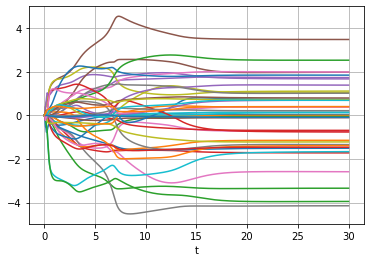

In [86]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.ylim(0,10)
plt.show()

In [87]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(LL+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [88]:
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi

In [89]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [90]:
psi = var_ansatz(start_point,psi_0)

In [91]:
psi_ground = eigenvec[:,0]


In [92]:
expt_value_u = np.zeros(len(time_domain))
energy = np.zeros(len(time_domain))
psi = var_ansatz(start_point,psi_0)
for tt in range(len(time_domain)):
    theta = []
    for i in range(coeff*N):
        theta.append(Y[tt][i])

    psi_var = var_ansatz(theta,psi_0)
    
    for i in range(LL+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

    expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
    energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)


(0.94, 0.98)

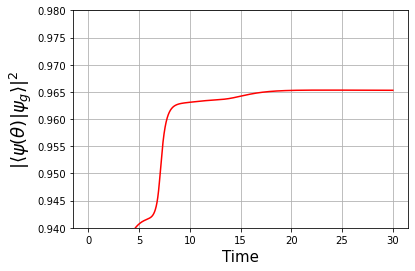

In [93]:
plt.plot(time_domain,expt_value_u, color = "red")
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.xlim(0,10)
plt.ylim(0.94,0.98)

#plt.savefig("Imaginary_time_evolution_fidelity_2d_1plaquette_M=0.1_N=3.pdf",bbox_inches = "tight")

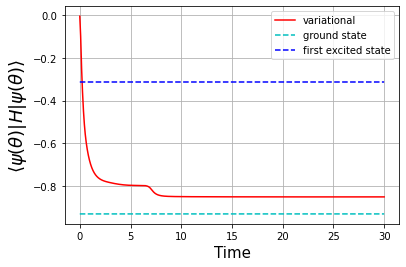

In [94]:
plt.plot(time_domain,energy, color = "red",label = "variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c", label = "ground state")
plt.plot(time_domain,eigenval[1]*np.ones(len(time_domain)), ls = "--", color ="b", label = "first excited state")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.xlim(0,10)
plt.legend()
#plt.ylim(0.9,0.95)

#plt.savefig("Imaginary_time_evolution_energy_2d_1plaquette_M=0.1_N=3.pdf",bbox_inches = "tight")

In [55]:
print(expt_value_u[-1])

0.9676777220675808


In [ ]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
